In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def load_data_intraday(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    data = pd.read_csv(filename, 
                       usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates=[['Date', 'Time']], )
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'],axis=1,inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    return data

dataset = load_data_intraday("@GC_15min_Exchange.txt")

In [2]:
dataset.tail(10)

open    high     low   close  volume  dayofweek  day  \
date_time                                                                     
2019-11-08 14:45:00  1462.9  1463.1  1462.3  1462.7    1109          4    8   
2019-11-08 15:00:00  1462.6  1463.0  1462.3  1462.8    1082          4    8   
2019-11-08 15:15:00  1462.8  1463.0  1462.0  1462.0     825          4    8   
2019-11-08 15:30:00  1462.0  1462.4  1460.7  1460.8    1884          4    8   
2019-11-08 15:45:00  1460.8  1461.5  1460.4  1460.5    2164          4    8   
2019-11-08 16:00:00  1460.6  1460.7  1459.4  1459.5    3093          4    8   
2019-11-08 16:15:00  1459.5  1459.8  1458.7  1459.2    1397          4    8   
2019-11-08 16:30:00  1459.1  1459.7  1459.1  1459.3     450          4    8   
2019-11-08 16:45:00  1459.2  1459.3  1458.6  1459.0     715          4    8   
2019-11-08 17:00:00  1459.0  1460.0  1458.8  1459.8     839          4    8   

                     month  year  dayofyear  quarter  hour  minute  
date_time                                                           
2019-11-08 14:45:00     11  2019        312        4    14      45  
2019-11-08 15:00:00     11  2019        312        4    15       0  
2019-11-08 15:15:00     11  2019        312        4    15      15  
2019-11-08 15:30:00     11  2019        312        4    15      30  
2019-11-08 15:45:00     11  2019        312        4    15      45  
2019-11-08 16:00:00     11  2019        312        4    16       0  
2019-11-08 16:15:00     11  2019        312        4    16      15  
2019-11-08 16:30:00     11  2019        312        4    16      30  
2019-11-08 16:45:00     11  2019        312        4    16      45  
2019-11-08 17:00:00     11  2019        312        4    17       0

In [3]:
def stop_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup stop
    Viene verificata il superamento del massimo (long) o minimo (short) sul level
    """
    service_dataframe = pd.DataFrame(index = dataframe.index)
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high

    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

def limit_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup limit
    Viene verificata il raggiungimento del minimo (long) o massimo (short) sul level
    """
    service_dataframe = pd.DataFrame()
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high
    
    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) & \
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

In [4]:
def marketposition_generator(enter_rules,exit_rules):
    """
    Funzione per calcolare il marketposition date due serie di enter_rules and exit_rules
    """
    service_dataframe = pd.DataFrame(index = enter_rules.index)
    service_dataframe['enter_rules'] = enter_rules
    service_dataframe['exit_rules'] = exit_rules
    
    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:
            if i == 1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)
        
    service_dataframe['mp_new'] = mp
    service_dataframe.mp_new = service_dataframe.mp_new.shift(1)
    service_dataframe.iloc[0,2] = 0
    service_dataframe.to_csv("marketposition_generator.csv")
    return service_dataframe.mp_new

In [5]:
def apply_trading_system(imported_dataframe, bigpointvalue, tick, direction, order_type, 
                         enter_level, enter_rules, exit_rules):
    dataframe = imported_dataframe.copy()
    if ORDER_TYPE == "stop":
        enter_rules = stop_check(dataframe,enter_rules,enter_level,direction)
    if ORDER_TYPE == "limit":
        enter_rules = limit_check(dataframe,enter_rules,enter_level,direction)
        
    dataframe['enter_level'] = enter_level
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)
    
    dataframe["mp"] = marketposition_generator(dataframe.enter_rules,dataframe.exit_rules)
 
    if ORDER_TYPE == "market":
        dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                             dataframe.open, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / dataframe.open, np.nan)
    if ORDER_TYPE == "stop":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)   
    if ORDER_TYPE == "limit":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)                                                      
        
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    dataframe["events_in"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(1) == 0), "entry", "")
    if INSTRUMENT == 1:
        dataframe["number_of_stocks"] = dataframe["number_of_stocks"].apply(lambda x: round(x,0))\
                                        .fillna(method='ffill')
        
    if direction == "long":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                                    (dataframe.open.shift(-1) - dataframe.entry_price)
                                                    * dataframe.number_of_stocks - 2 * COSTS, 
                                                    dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.open.shift(-1) - dataframe.entry_price) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
            
    if direction == "short":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                            (dataframe.entry_price - dataframe.open.shift(-1))\
                                            * dataframe.number_of_stocks - 2 * COSTS,
                                            dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.entry_price - dataframe.open.shift(-1)) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
        
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0)
    dataframe["events_out"] = np.where((dataframe.mp == 1) & (dataframe.exit_rules == -1), "exit", "")      
    dataframe["operations"] = np.where((dataframe.exit_rules == -1) & (dataframe.mp == 1), 
                                        dataframe.open_operations, np.nan)
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    dataframe.to_csv("trading_system_export.csv")
    return dataframe

# Funzioni utilizzate:

In [6]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def load_data_intraday(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    data = pd.read_csv(filename, 
                       usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates=[['Date', 'Time']], )
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'],axis=1,inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    return data

def load_data_daily(filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    data = pd.read_csv(filename, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    return data
    
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))
        
def plot_equity(equity,color):
    """
    Funzione per stampare un'equity line
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def drawdown(equity):
    """
    Funzione che calcola il draw down data un'equity line
    """
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def plot_drawdown(equity,color):
    """
    Funzione per graficare la curva di draw down
    """
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def plot_double_equity(closed_equity,open_equity):
    """
    Funzione per stampare due equity sovrapposte
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red')
    plt.plot(closed_equity, color='green')
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def profit(equity):
    return round(equity[-1],2)
    
def operation_number(operations):
    return operations.count()
    
def avg_trade(operations):
    return round(operations.mean(),2)
    
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)
    
def avgdrawdown_nozero(equity):
    """
    calcola la media del draw down storico
    non considerando i valori nulli (nuovi massimi di equity line)
    """
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

def avg_loss(operations):
    return round(operations[operations < 0].mean(),2)
    
def max_loss(operations):
    return round(operations.min(),2)
    
def max_loss_date(operations):
    return operations.idxmin()
    
def avg_gain(operations):
    return round(operations[operations > 0].mean(),2)
    
def max_gain(operations):
    return round(operations.max(),2)
    
def max_gain_date(operations):
    return operations.idxmax()
    
def gross_profit(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor(operations):
    a = gross_profit(operations)
    b = gross_loss(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)
        
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)
    
def reward_risk_ratio(operations):
    if operations[operations <= 0].mean() != 0:
        return round((operations[operations > 0].mean() / -operations[operations <= 0].mean()),2)
    else:
        return np.inf
        
def delay_between_peaks(equity):
    """
    Funzione per calcolare i ritardi istantanei in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else 0)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    #print(work_df.iloc[-20:,:])
    a = pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).cumsum())
    return a

def max_delay_between_peaks(equity):
    """
    Funzione per calcolare il più lungo ritardo in barre dall'ultimo massimo
    Input: equity line
    """
    a = delay_between_peaks(equity)
    return a.max()
    
def avg_delay_between_peaks(equity):
    """
    Funzione per calcolare il ritardo medio in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else np.nan)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    work_df.dropna(inplace = True)
    a = work_df['delay_elements'].groupby(work_df['cumsum']).sum()
    return round(a.mean(),2)
    
def plot_annual_histogram(operations):
    yearly = operations.resample('A').sum()
    colors = pd.Series()
    colors = yearly.apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(yearly)
    plt.subplots(figsize=(10, 7), dpi=200)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     yearly,
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Years')
    plt.ylabel('Profit - Loss')
    plt.title('Yearly Profit-Loss - by Gandalf Project R&D')
    plt.xticks(index, yearly.index.year, rotation=90)
    plt.grid(True)
    plt.show()
    return
    
def plot_monthly_bias_histogram(operations):
    monthly = pd.DataFrame(operations.fillna(0)).resample('M').sum()
    monthly['Month'] = monthly.index.month
    biasMonthly = []
    months = []

    for month in range(1, 13):
        months.append(month)
    for month in months:
        biasMonthly.append(monthly[(monthly['Month'] == month)].mean())

    biasMonthly = pd.DataFrame(biasMonthly)
    column = biasMonthly.columns[0]
    colors = pd.Series()
    colors = biasMonthly[column].apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(biasMonthly)
    plt.subplots(figsize=(14, 6), dpi=300)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     biasMonthly[column],
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Months')
    plt.ylabel('Average Profit - Loss')
    plt.title('Average Monthly Profit-Loss - by Gandalf Project R&D')
    months_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                    "October", "November", "December"]
    plt.xticks(index, months_names, rotation=45)
    plt.grid(True)
    plt.show()
    return
    
def plot_equity_heatmap(operations,annotations):
    monthly = operations.resample('M').sum()
    toHeatMap = pd.DataFrame(monthly)
    toHeatMap["Year"] = toHeatMap.index.year
    toHeatMap["Month"] = toHeatMap.index.month
    Show = toHeatMap.groupby(by=['Year','Month']).sum().unstack()
    Show.columns = ["January","February","March","April","May","June",
                    "July","August","September","October","November","December"]
    plt.figure(figsize=(8,6),dpi=120)
    sns.heatmap(Show, cmap="RdYlGn", linecolor="white", linewidth=0.1, annot=annotations, 
                vmin=-max(monthly.min(),monthly.max()), vmax=monthly.max())
    return
    
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance Report - by Gandalf Project R&D")
    print("")
    print("Profit:                  ", profit(open_equity))
    print("Operations:              ", operation_number(operations))
    print("Average Trade:           ", avg_trade(operations))
    print("")
    print("Profit Factor:           ", profit_factor(operations))
    print("Gross Profit:            ", gross_profit(operations))
    print("Gross Loss:              ", gross_loss(operations))
    print("")
    print("Percent Winning Trades:  ", percent_win(operations))
    print("Percent Losing Trades:   ", 100 - percent_win(operations))
    print("Reward Risk Ratio:       ", reward_risk_ratio(operations))
    print("")
    print("Max Gain:                ", max_gain(operations), " in date ", max_gain_date(operations))
    print("Average Gain:            ", avg_gain(operations))
    print("Max Loss:                ", max_loss(operations), " in date ", max_loss_date(operations))
    print("Average Loss:            ", avg_loss(operations))
    print("")
    print("Avg Open Draw Down:      ", avgdrawdown_nozero(open_equity))
    print("Max Open Draw Down:      ", max_draw_down(open_equity))
    print("")
    print("Avg Closed Draw Down:    ", avgdrawdown_nozero(trading_system.closed_equity))
    print("Max Closed Draw Down:    ", max_draw_down(trading_system.closed_equity))
    print("")
    print("Avg Delay Between Peaks: ", avg_delay_between_peaks(trading_system.open_equity))
    print("Max Delay Between Peaks: ", max_delay_between_peaks(trading_system.open_equity))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

import math

def tick_correction_up(level,tick):
    if level != level:
        level = 0
    multiplier = math.ceil(level/tick)
    return multiplier * tick

def tick_correction_down(level,tick):
    if level != level:
        level = 0
    multiplier = math.floor(level/tick)
    return multiplier * tick

# GC: sistema stop hhv92 con filtro dayofweek long

Elaboration starts at:  2019-11-27 18:33:36.266042

Performance Report - by Gandalf Project R&D

Profit:                   105540.0
Operations:               395
Average Trade:            267.19

Profit Factor:            2.0
Gross Profit:             211340.0
Gross Loss:               -105800.0

Percent Winning Trades:   61.52
Percent Losing Trades:    38.48
Reward Risk Ratio:        1.25

Max Gain:                 4860.0  in date  2011-09-04 22:00:00
Average Gain:             869.71
Max Loss:                 -7010.0  in date  2008-10-12 22:00:00
Average Loss:             -700.66

Avg Open Draw Down:       -2099.71
Max Open Draw Down:       -13530.0

Avg Closed Draw Down:     -2331.25
Max Closed Draw Down:     -9870.0

Avg Delay Between Peaks:  756.81
Max Delay Between Peaks:  68250


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


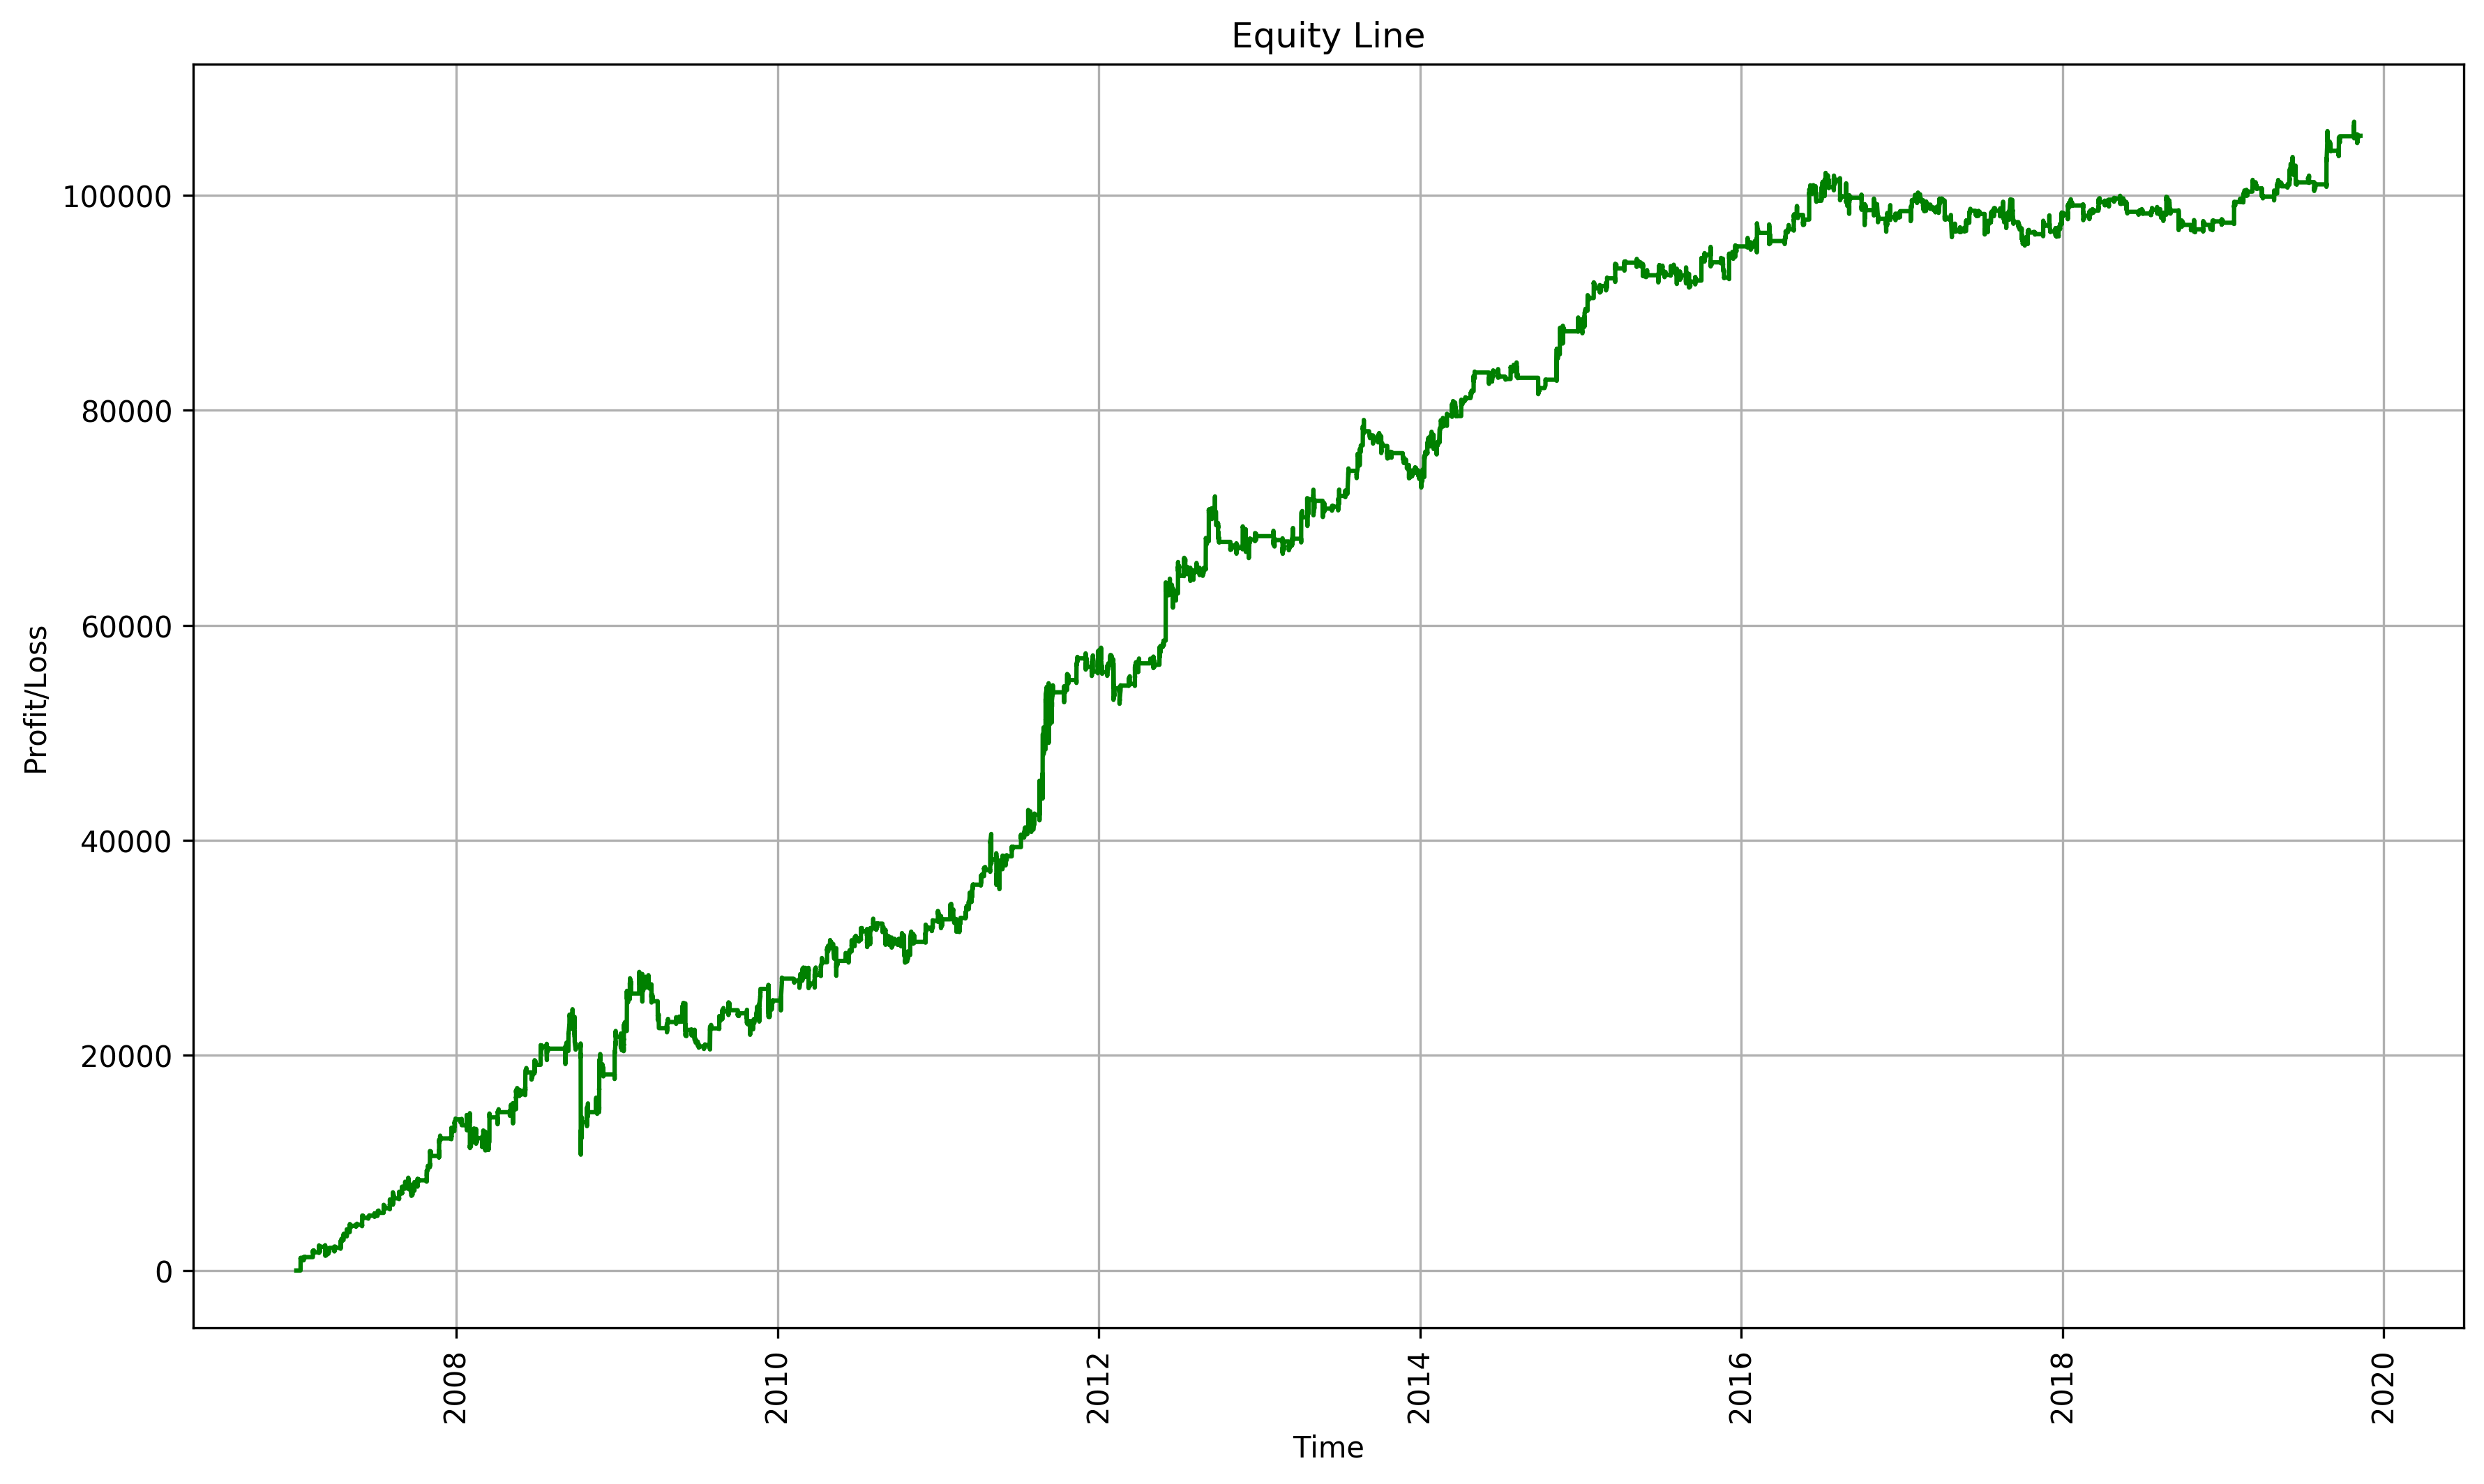

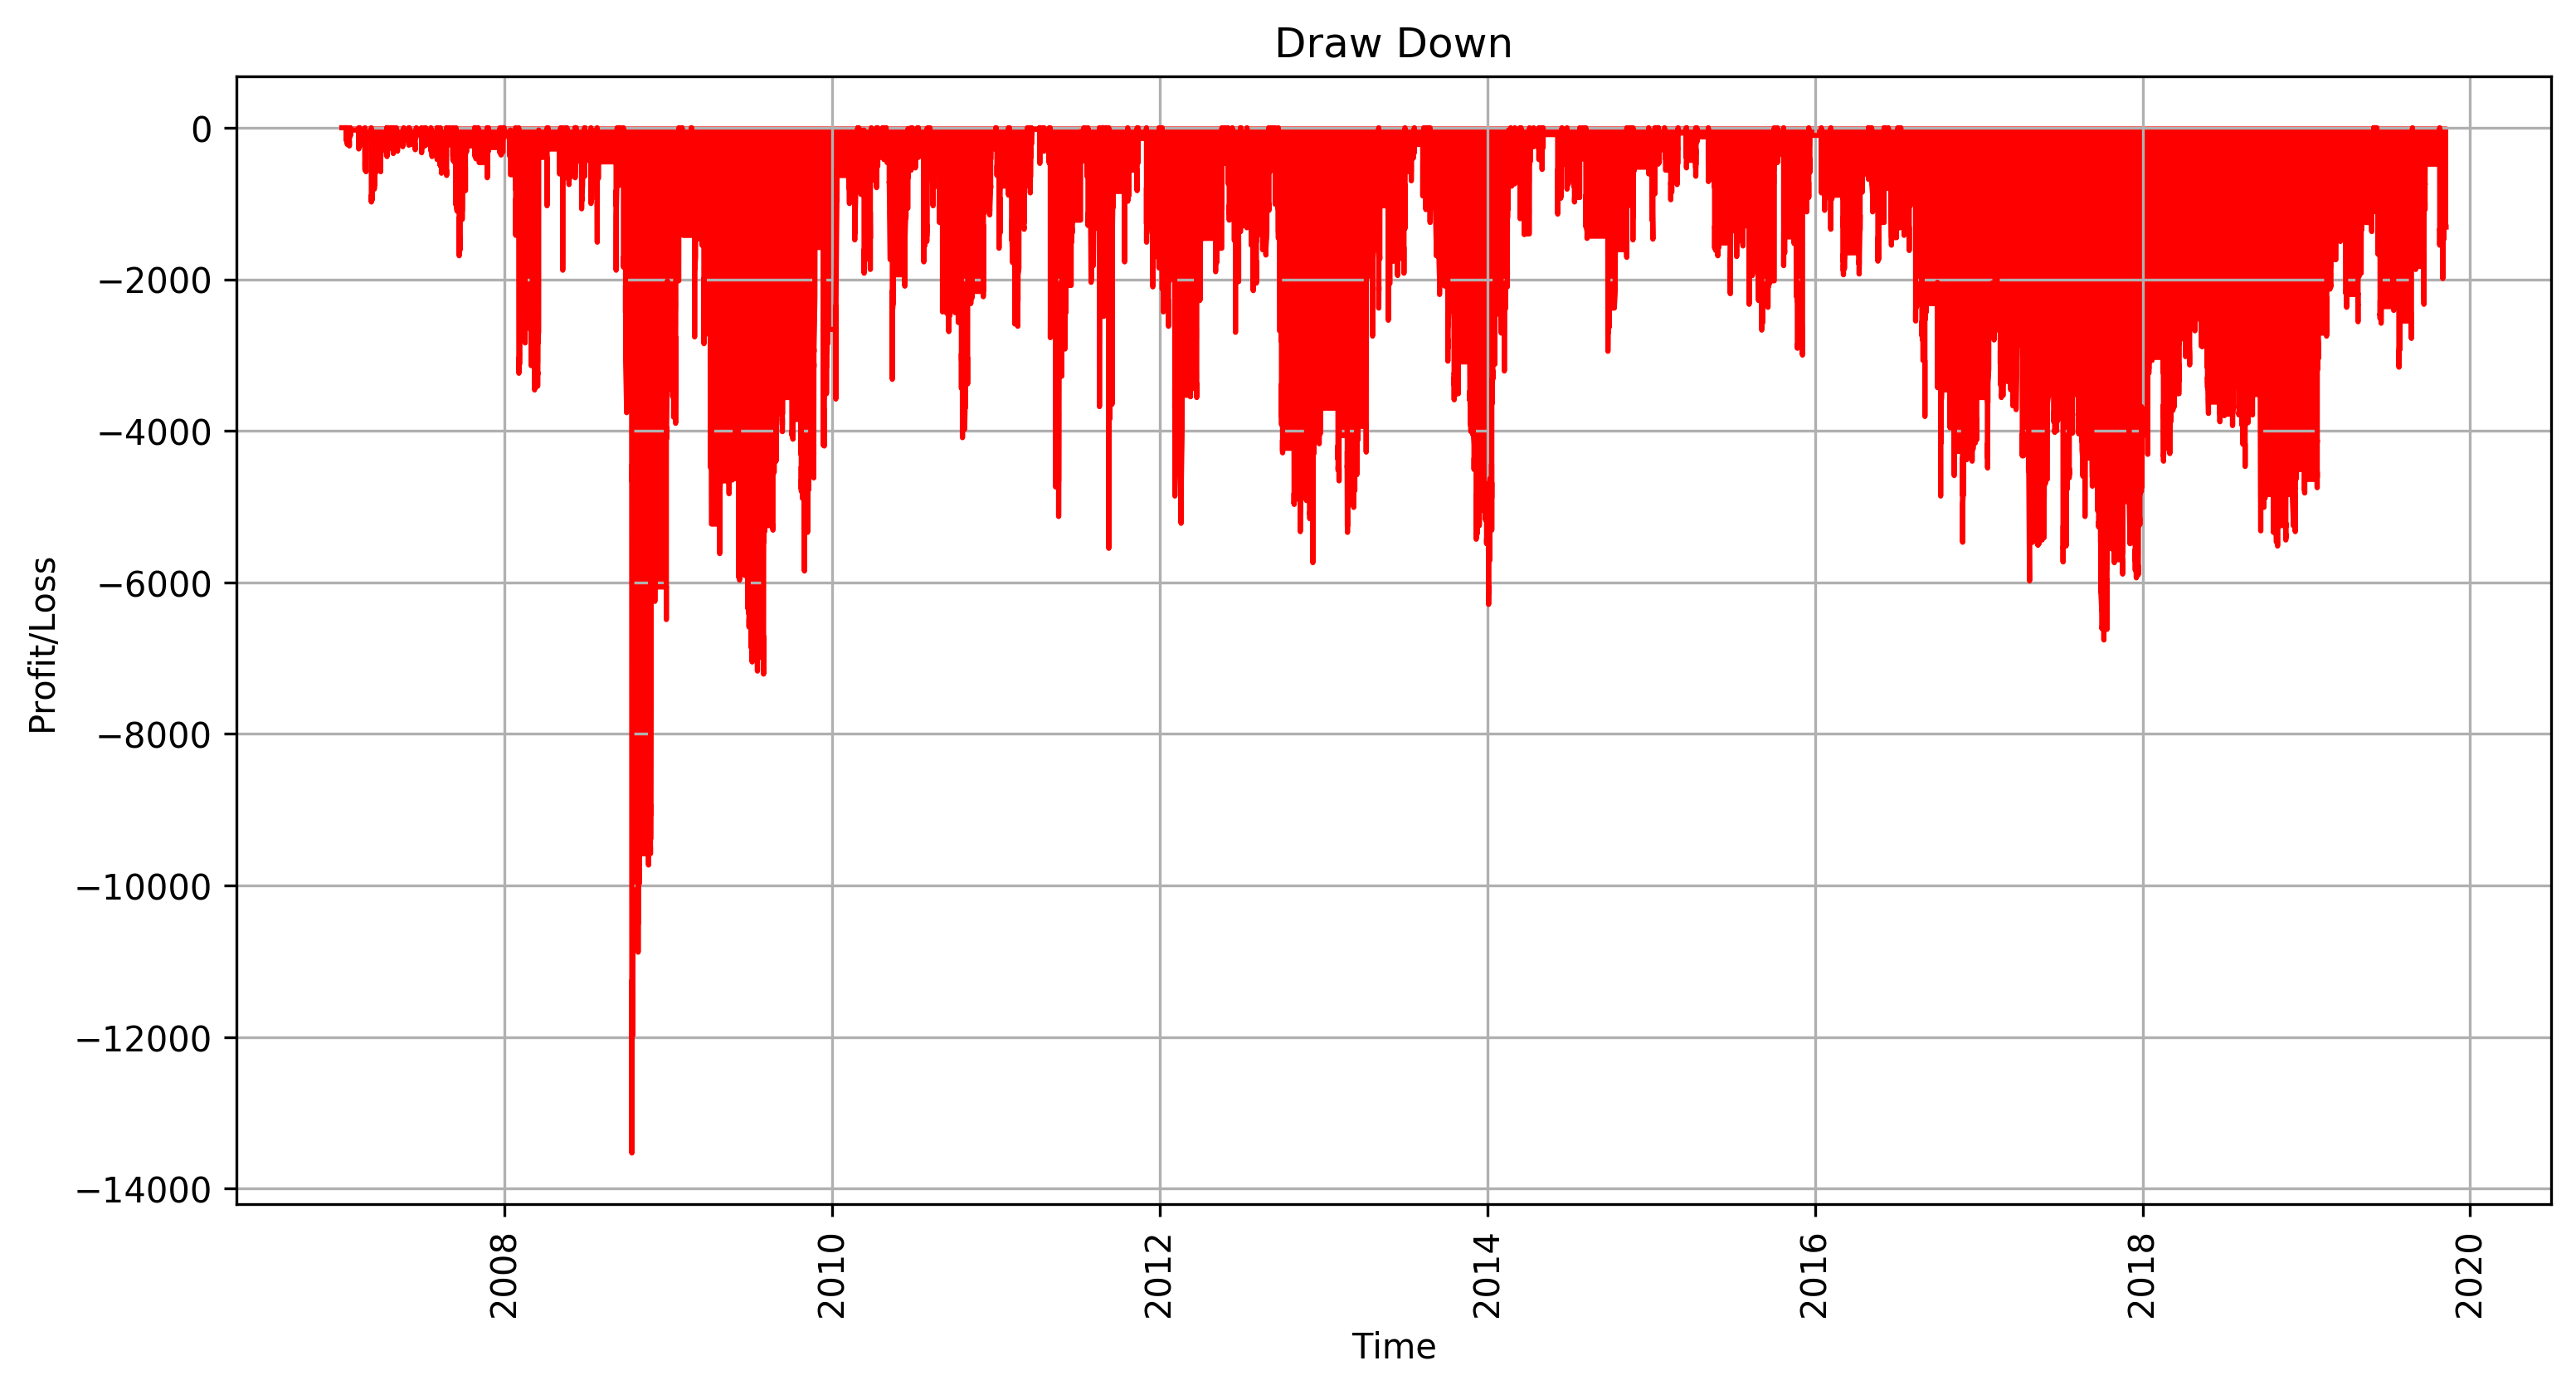

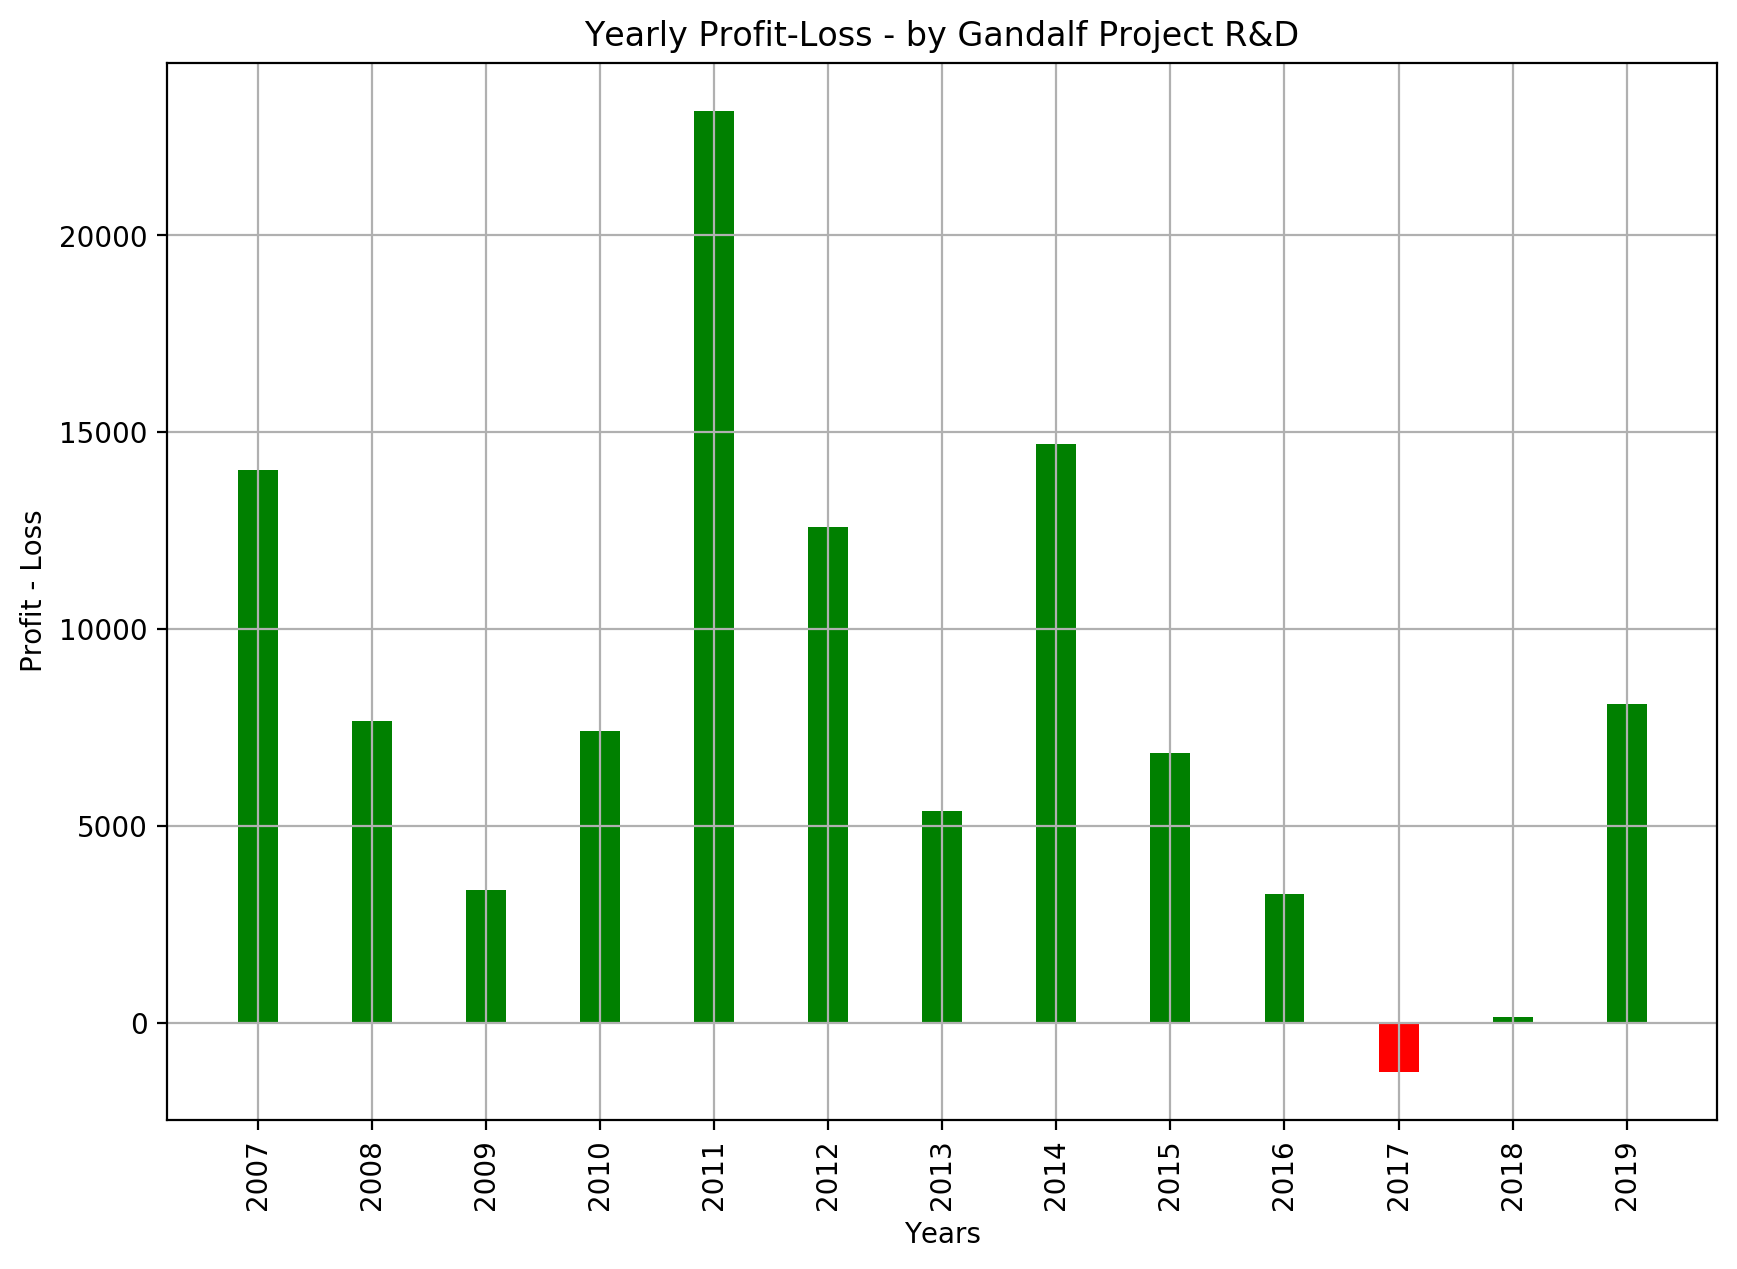

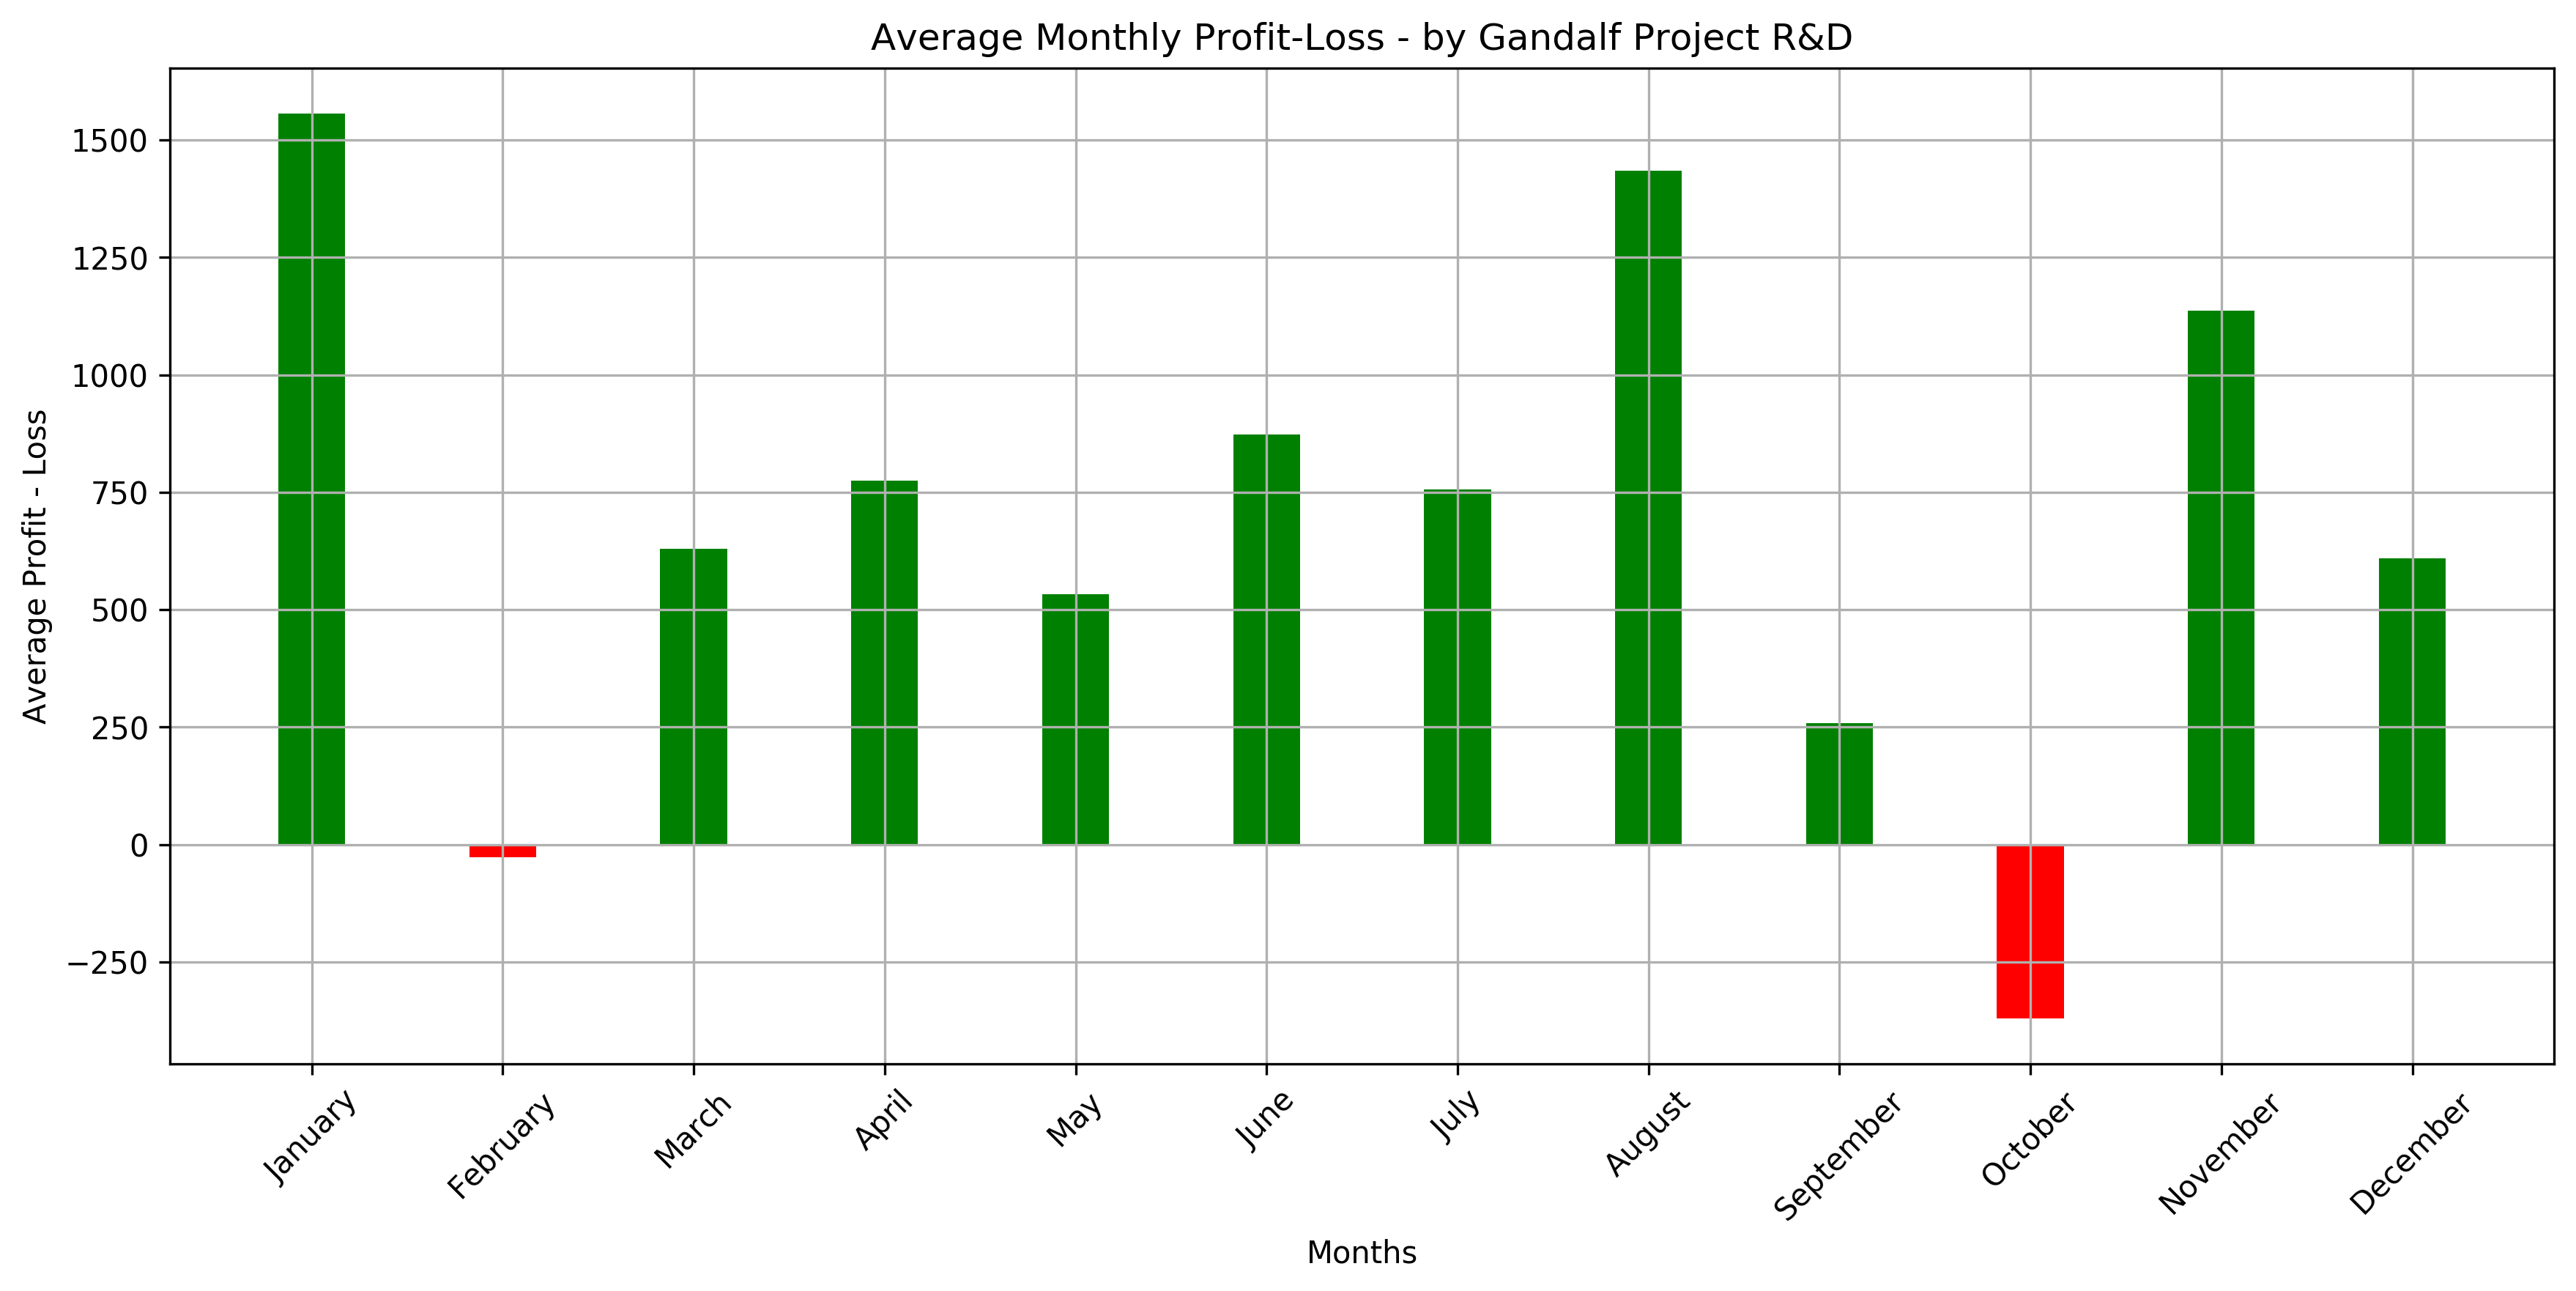

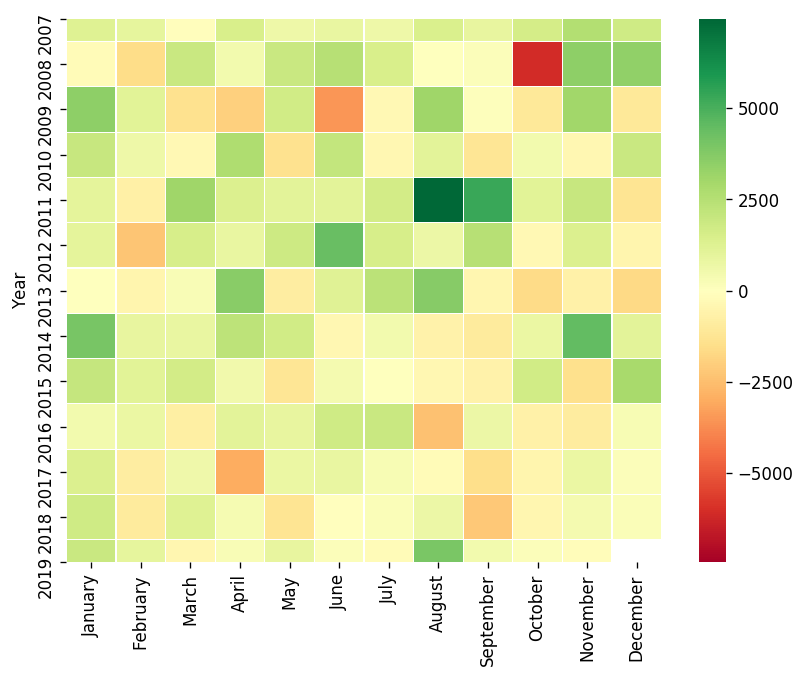

In [7]:
dataset = load_data_intraday("@GC_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.1
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules = dataset.dayofweek == 4
enter_level = dataset.hhv92.shift(1)
exit_rules = dataset.hour == 22

print("Elaboration starts at: ", datetime.datetime.now())
print("")

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, enter_level, 
                                      enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

# Ulteriori Sistemi

In [8]:
dataset = load_data_intraday("@NG_60min_Exchange.txt")

In [9]:
def create_daily_high(dataframe):
    """
    Function to create daily levels 
    alternative to resample method
    """
    service = dataframe.copy()
    service["Weekday"] = service.index.dayofweek
    service["Day"] = service.index.day.values
    service["Week"] = service.index.week.values
    service["Month"] = service.index.month.values
    service["Year"] = service.index.year.values
    service["Condition"] = np.where(service["Day"] != service["Day"].shift(1),1,0)
    service["Grouper"] = service.Condition.cumsum()
    service['high'].groupby(service['Grouper']).max()
    
    indexes = service[service.Condition == 1].index
    
    DailyHigh = service['high'].groupby(service['Grouper']).max()
    temporary = pd.DataFrame(DailyHigh)
    temporary["Dates"] = indexes
    temporary.set_index("Dates", inplace=True)
    
    service["DailyHigh"] = temporary.high.shift(1)
    service.fillna(method = 'ffill')
    return service.DailyHigh

def create_weekly_low(dataframe):
    """
    Function to create weekly levels 
    alternative to resample method
    """
    service = dataframe.copy()
    #service["Week"] = service.index.week
    service["Weekday"] = service.index.dayofweek
    service["Day"] = service.index.day.values
    service["Week"] = service.index.week.values
    service["Month"] = service.index.month.values
    service["Year"] = service.index.year.values
    service["Condition"] = np.where(service["Week"] != service["Week"].shift(1),1,0)
    service["Grouper"] = service.Condition.cumsum()
    service['low'].groupby(service['Grouper']).min()
    
    indexes = service[service.Condition == 1].index
    
    WeeklyLow = service['low'].groupby(service['Grouper']).min()
    temporary = pd.DataFrame(WeeklyLow)
    temporary["Dates"] = indexes
    temporary.set_index("Dates", inplace=True)
    
    service["WeeklyLow"] = temporary.low.shift(1)
    service.fillna(method = 'ffill')
    return service.WeeklyLow

def create_weekly_low_from_sunday(dataframe):
    """
    Function to create weekly levels 
    alternative to resample method
    """
    service = dataframe.copy()
    service["Week"] = service.index.week
    service["Weekday"] = service.index.dayofweek.values
    # we change dayofweek to start weeks on sunday!
    service["NewWeekday"] = service.Weekday.apply(lambda x: x + 1 if x < 6 else 0)
    service["NewWeek"] = np.where(service["NewWeekday"] < service["NewWeekday"].shift(1),1,0).cumsum()
    service["Day"] = service.index.day.values
    service["Week"] = service.index.week.values
    service["Month"] = service.index.month.values
    service["Year"] = service.index.year.values
    service["Condition"] = np.where(service["NewWeek"] != service["NewWeek"].shift(1),1,0)
    service["Grouper"] = service.Condition.cumsum()
    service['low'].groupby(service['Grouper']).min()
    
    indexes = service[service.Condition == 1].index
    
    WeeklyLow = service['low'].groupby(service['Grouper']).min()
    temporary = pd.DataFrame(WeeklyLow)
    temporary["Dates"] = indexes
    temporary.set_index("Dates", inplace=True)
    
    service["WeeklyLow"] = temporary.low.shift(1)
    service.fillna(method = 'ffill')
    return service.WeeklyLow

#dataset["weekly_low1"] = create_weekly_low_from_sunday(dataset)
#dataset["weekly_low1"] = dataset["weekly_low1"].fillna(method = 'ffill')
#dataset.iloc[:,4:].head(300)

Performance Report - by Gandalf Project R&D

Profit:                   28070.0
Operations:               205
Average Trade:            136.93

Profit Factor:            1.46
Gross Profit:             89190.0
Gross Loss:               -61120.0

Percent Winning Trades:   58.54
Percent Losing Trades:    41.46
Reward Risk Ratio:        1.03

Max Gain:                 3860.0  in date  2008-08-28 17:00:00
Average Gain:             743.25
Max Loss:                 -3460.0  in date  2012-06-14 17:00:00
Average Loss:             -736.39

Avg Open Draw Down:       -2729.41
Max Open Draw Down:       -8400.0

Avg Closed Draw Down:     -2877.0
Max Closed Draw Down:     -7650.0

Avg Delay Between Peaks:  1512.39
Max Delay Between Peaks:  78695


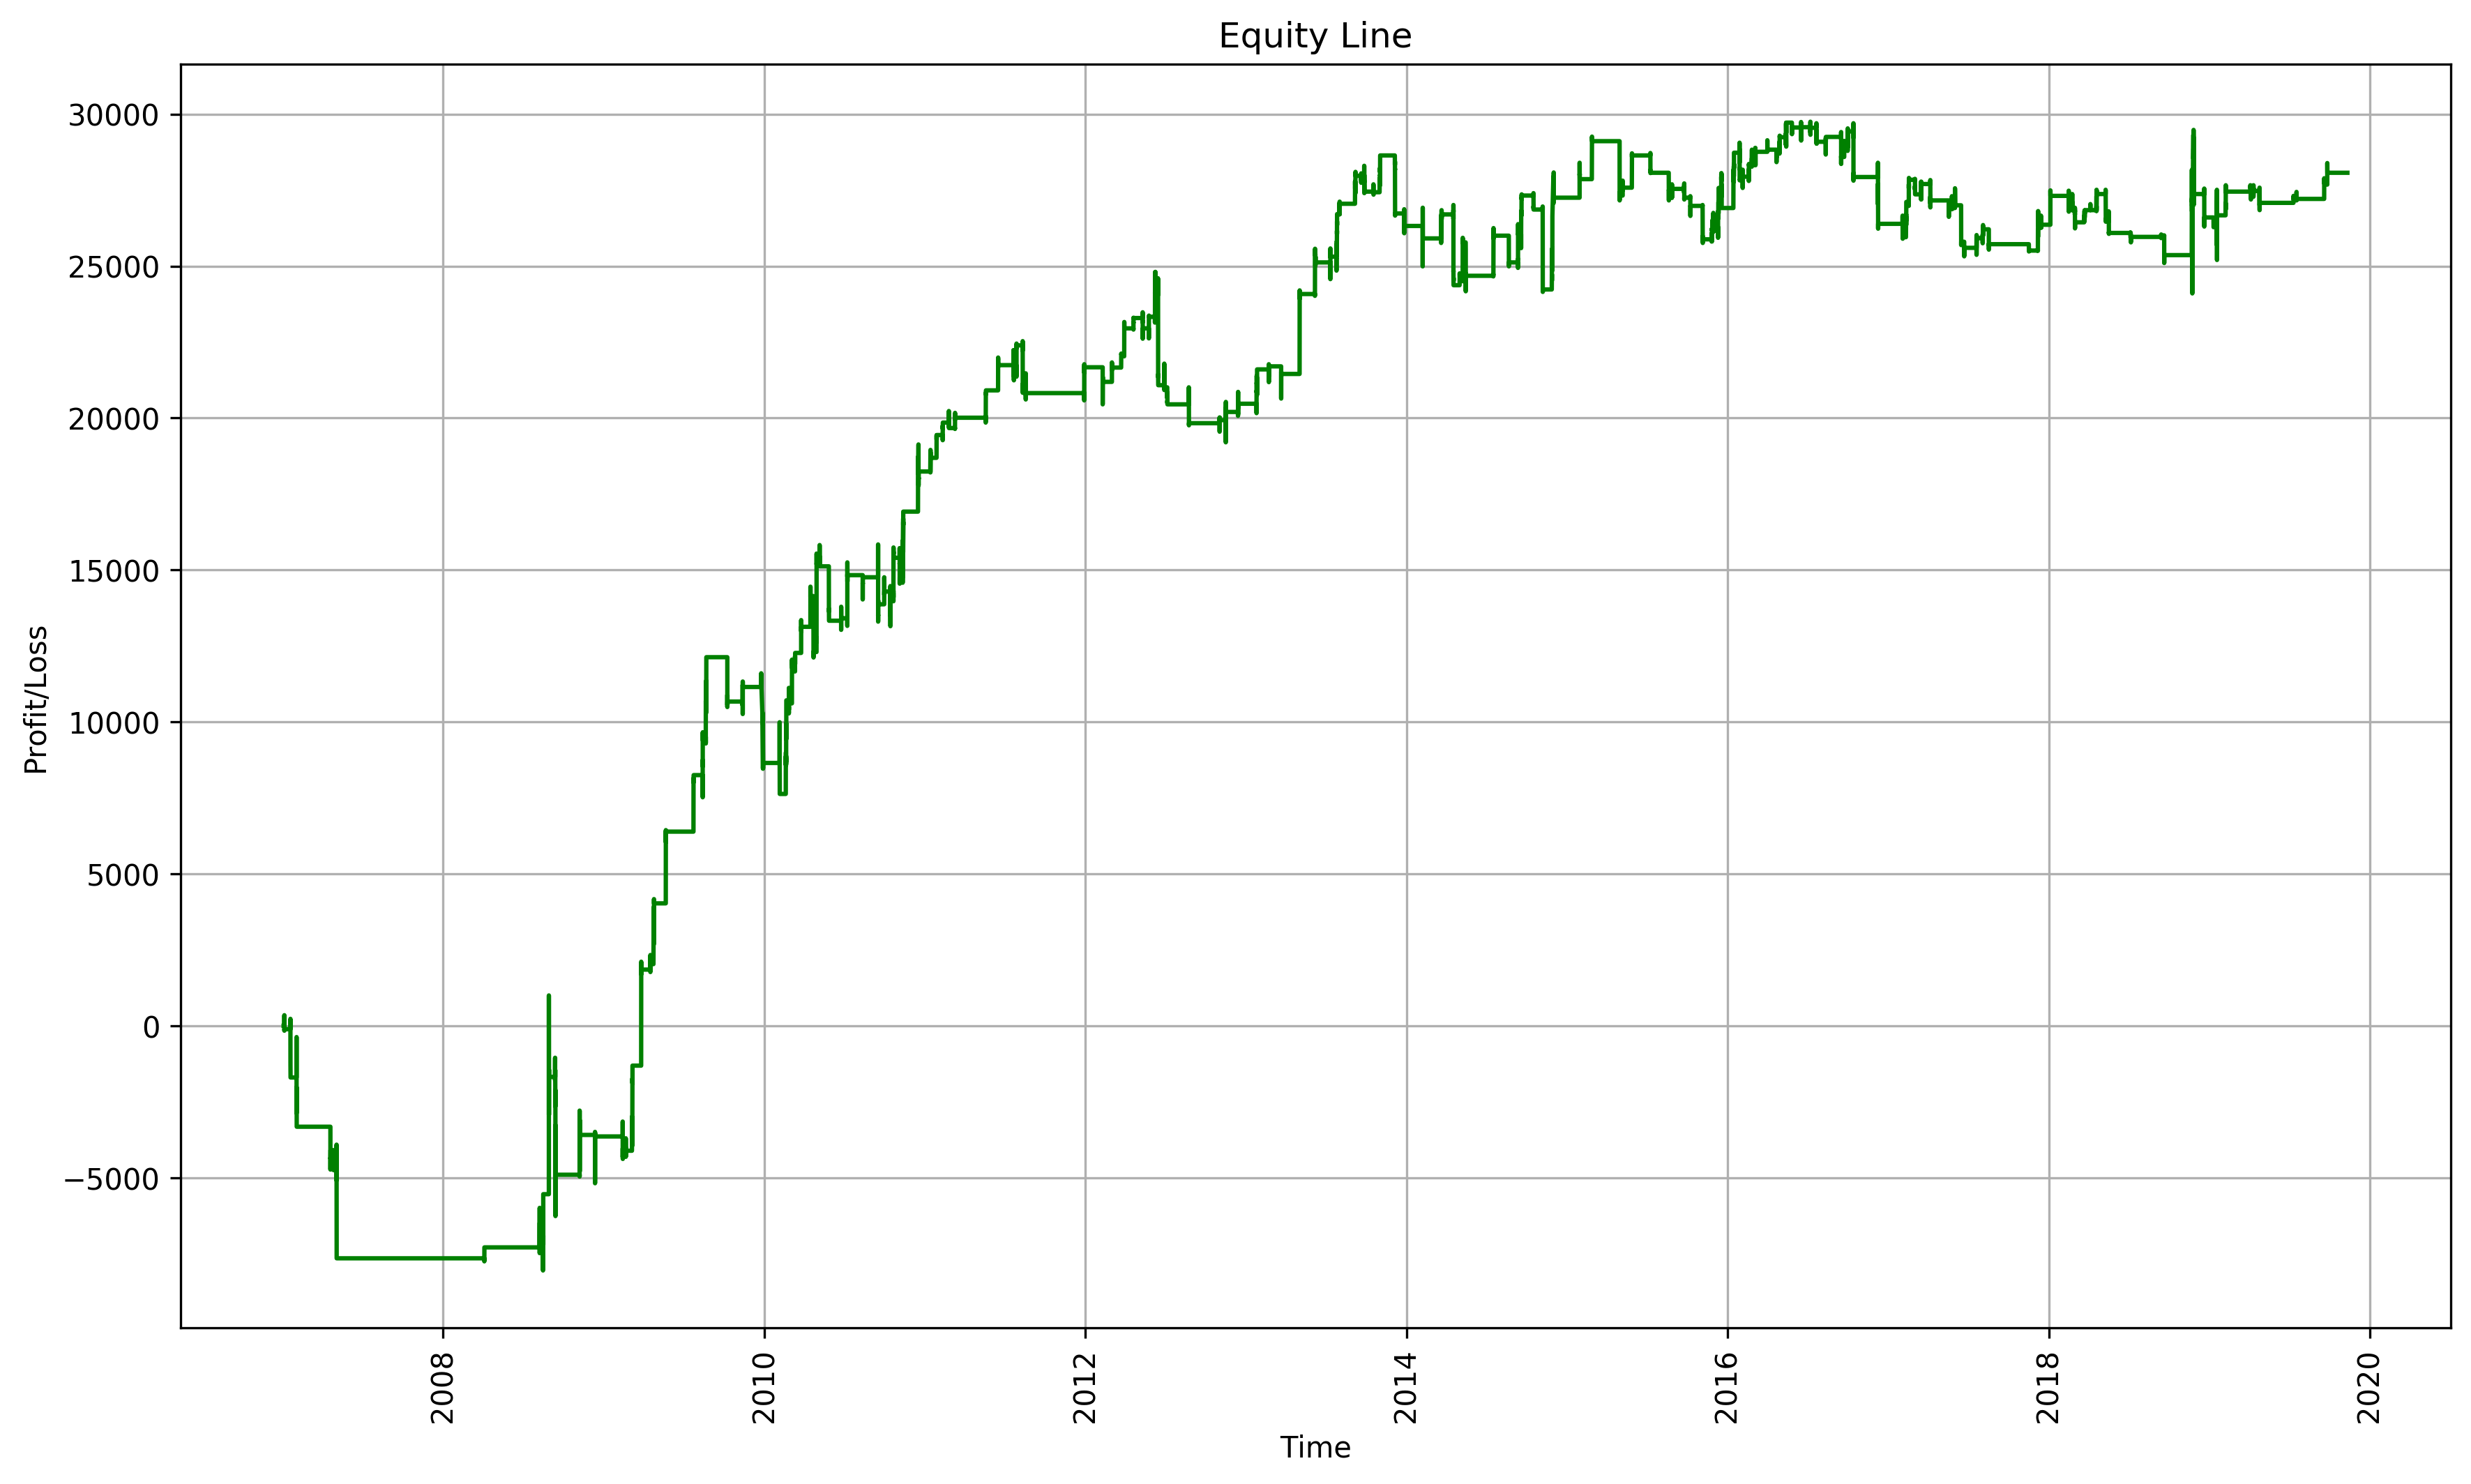

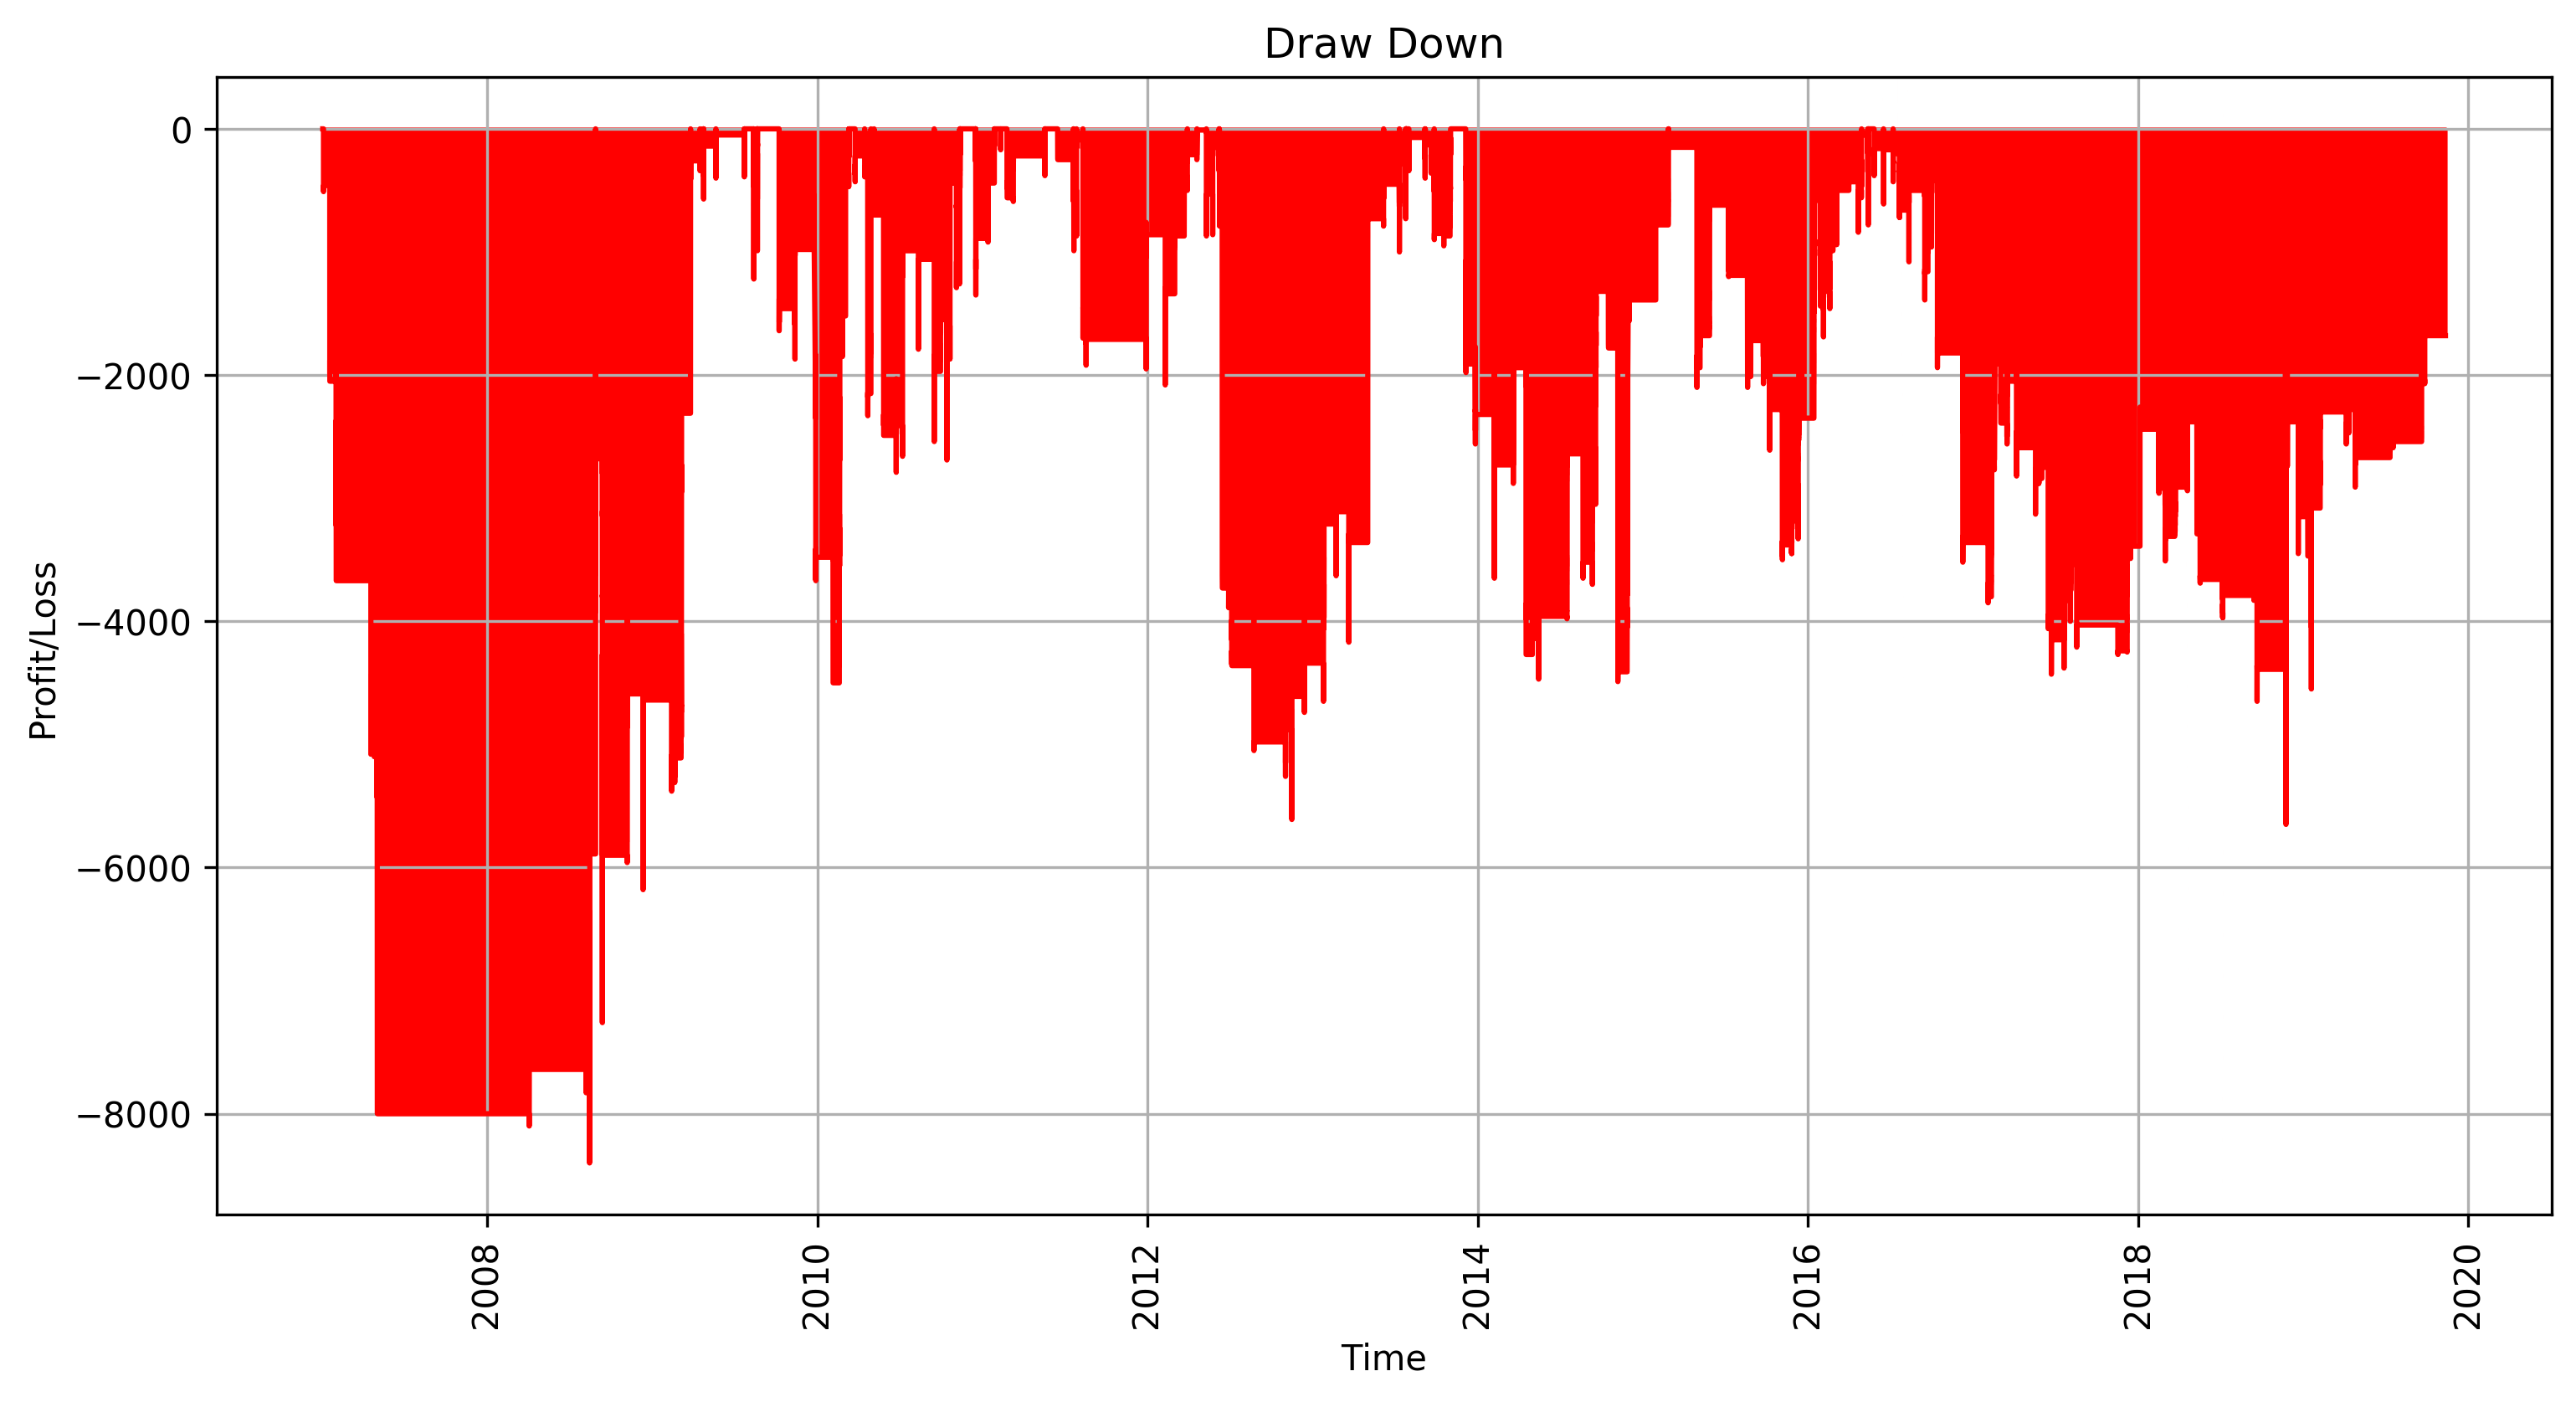

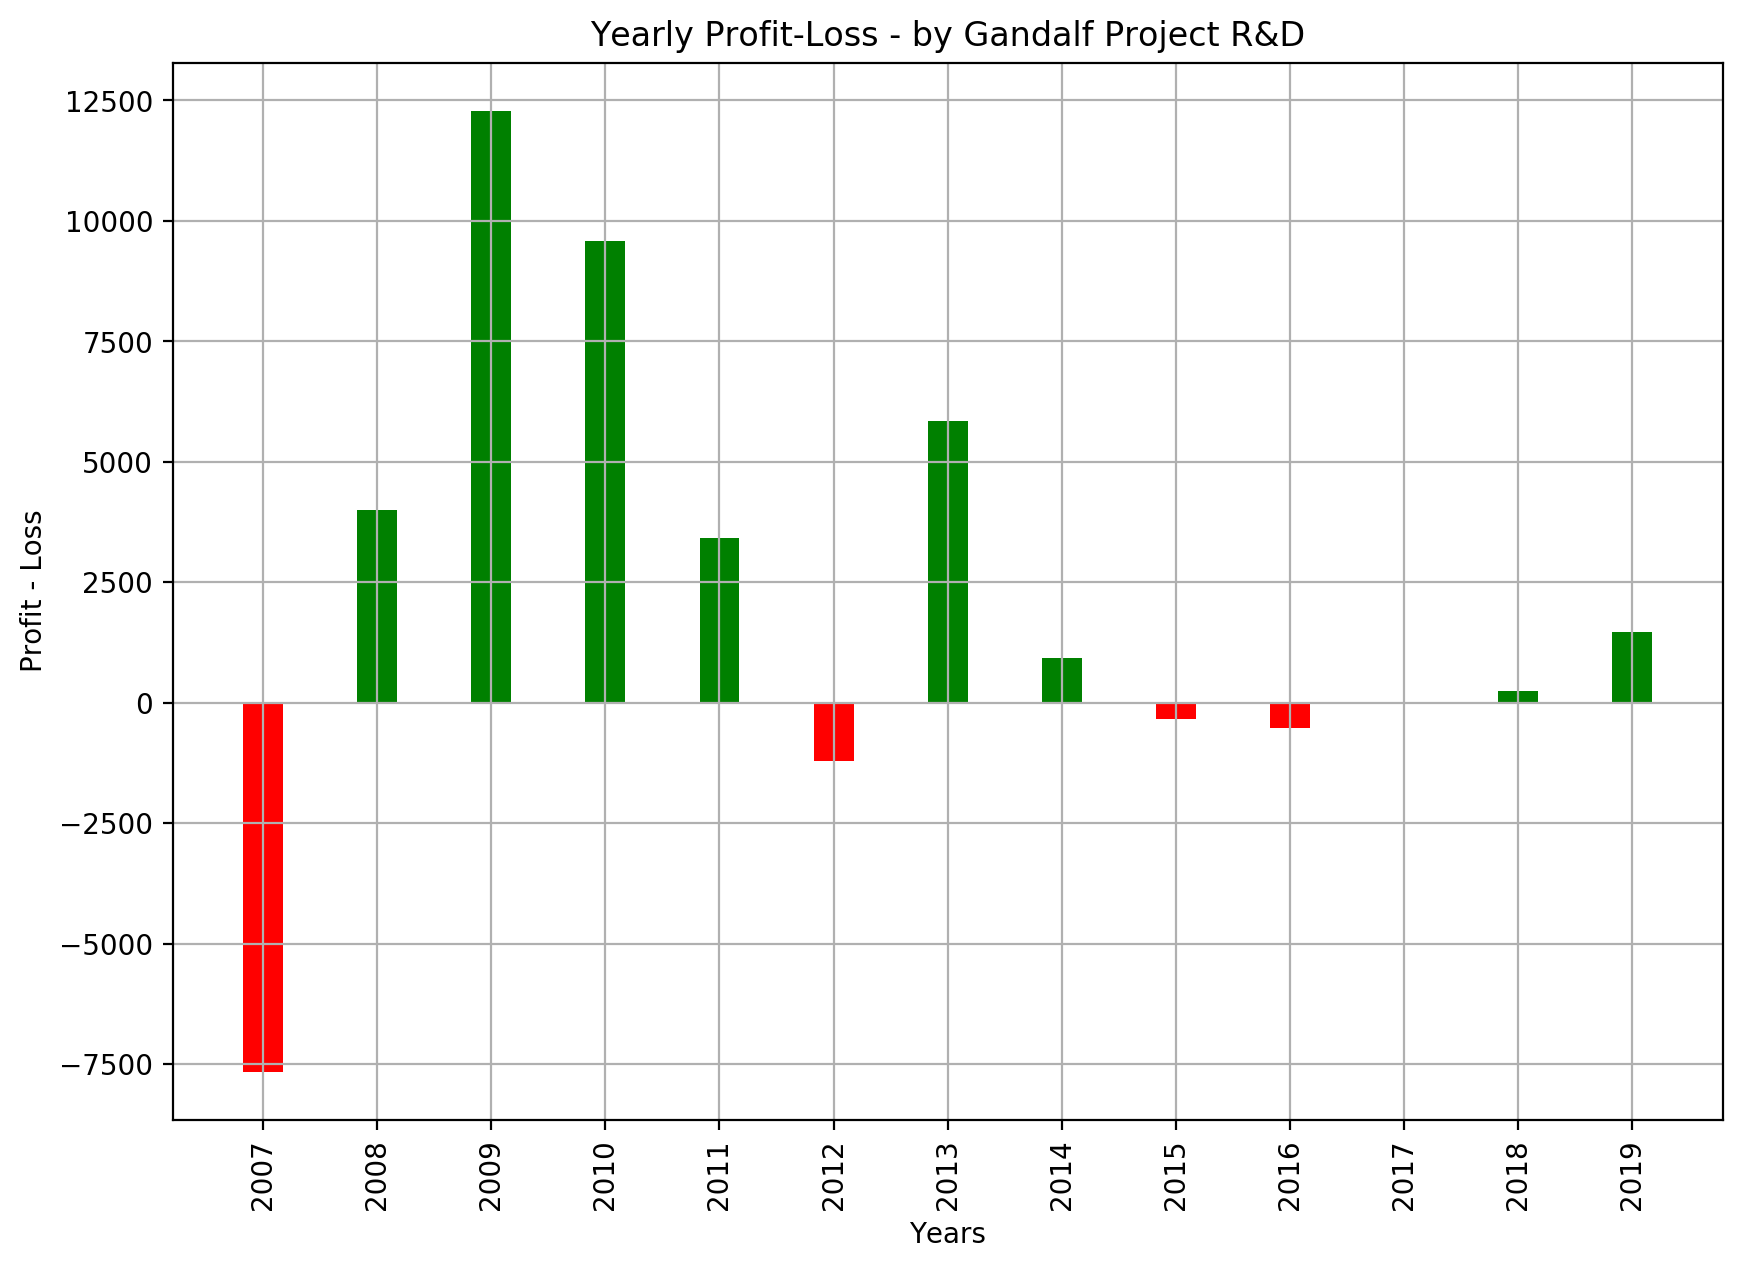

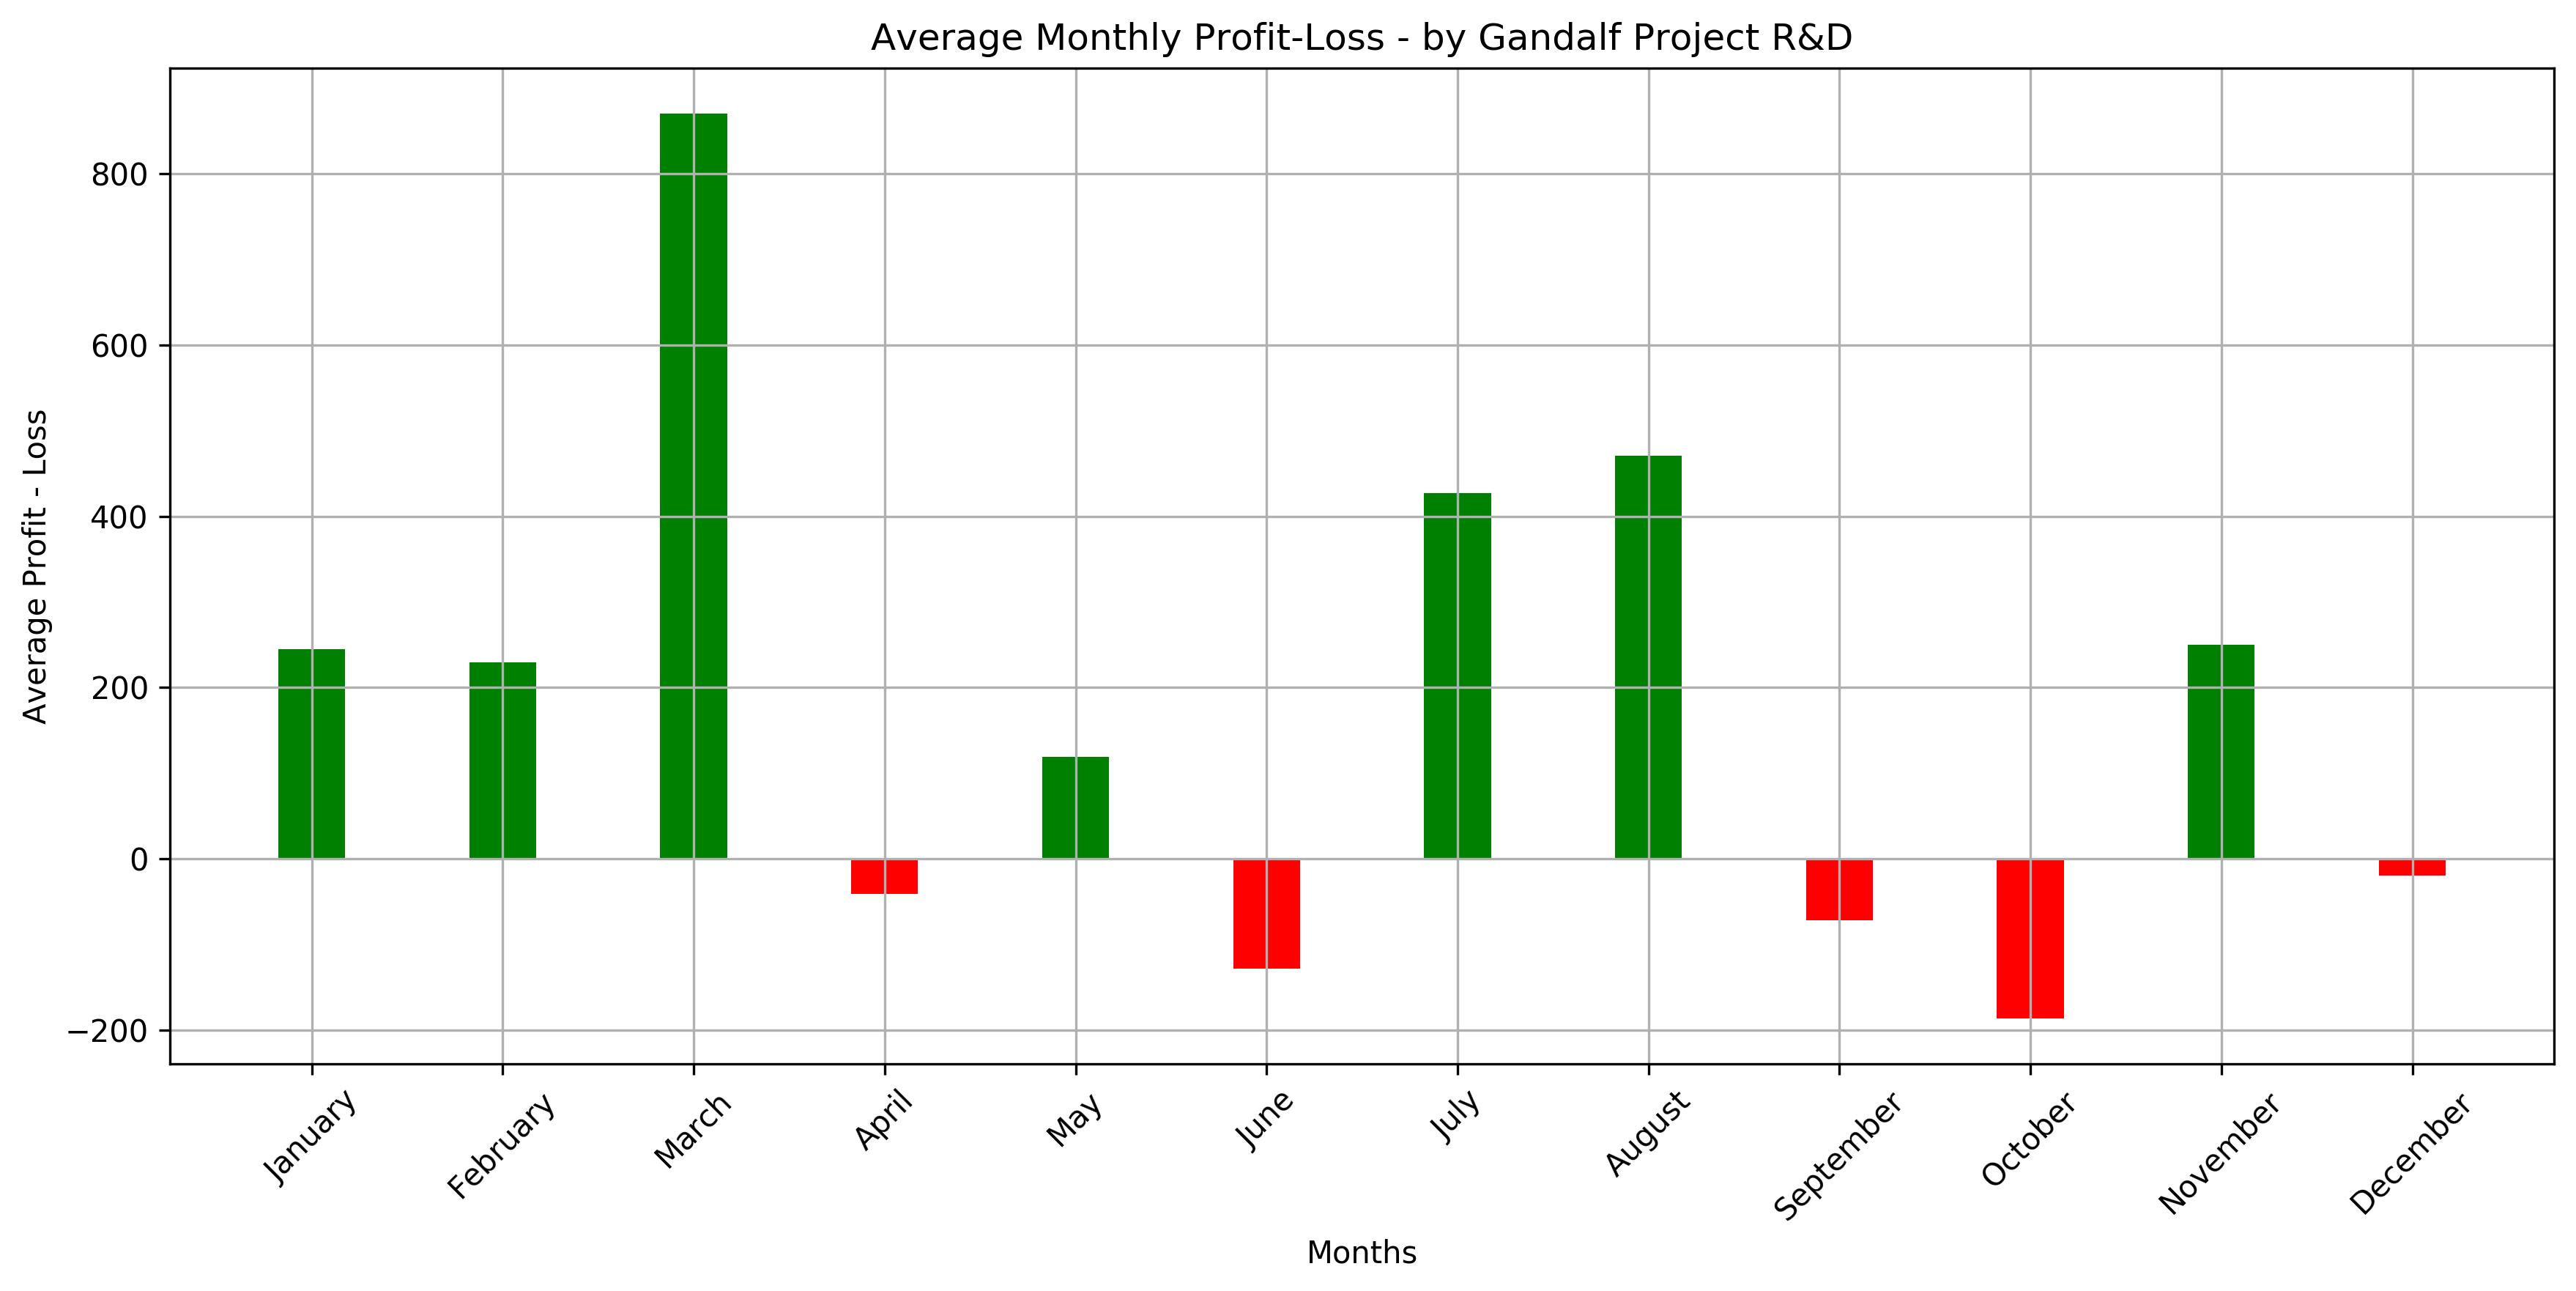

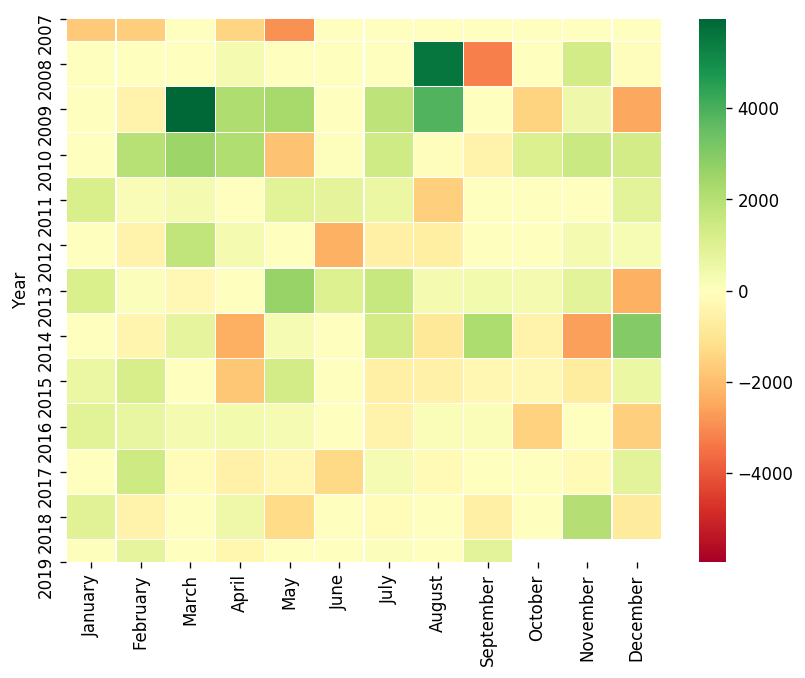

In [10]:
dataset = load_data_intraday("@NG_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
#dataset["weekly_low1"] = create_weekly_low_from_sunday(dataset)
#dataset["weekly_low1"] = dataset["weekly_low1"].fillna(method = 'ffill')
dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.low.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.low.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 10000
TICK = 0.001
OPERATION_MONEY = 10000
DIRECTION = "short"
ORDER_TYPE = "stop"
enter_level = dataset.llv92.shift(1)

enter_rules = blastoff & (dataset.dayofweek == 3)
exit_rules = dataset.hour == 17

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

# Base breakout long

Elaboration starts at:  2019-11-27 18:38:41.214080
Performance Report - by Gandalf Project R&D

Profit:                   200370.0
Operations:               2014
Average Trade:            99.49

Profit Factor:            1.33
Gross Profit:             808690.0
Gross Loss:               -608320.0

Percent Winning Trades:   53.87
Percent Losing Trades:    46.13
Reward Risk Ratio:        1.14

Max Gain:                 8780.0  in date  2008-09-17 22:00:00
Average Gain:             745.34
Max Loss:                 -7010.0  in date  2008-10-12 22:00:00
Average Loss:             -661.22

Avg Open Draw Down:       -3877.21
Max Open Draw Down:       -20020.0

Avg Closed Draw Down:     -3645.59
Max Closed Draw Down:     -18290.0

Avg Delay Between Peaks:  347.51
Max Delay Between Peaks:  28115


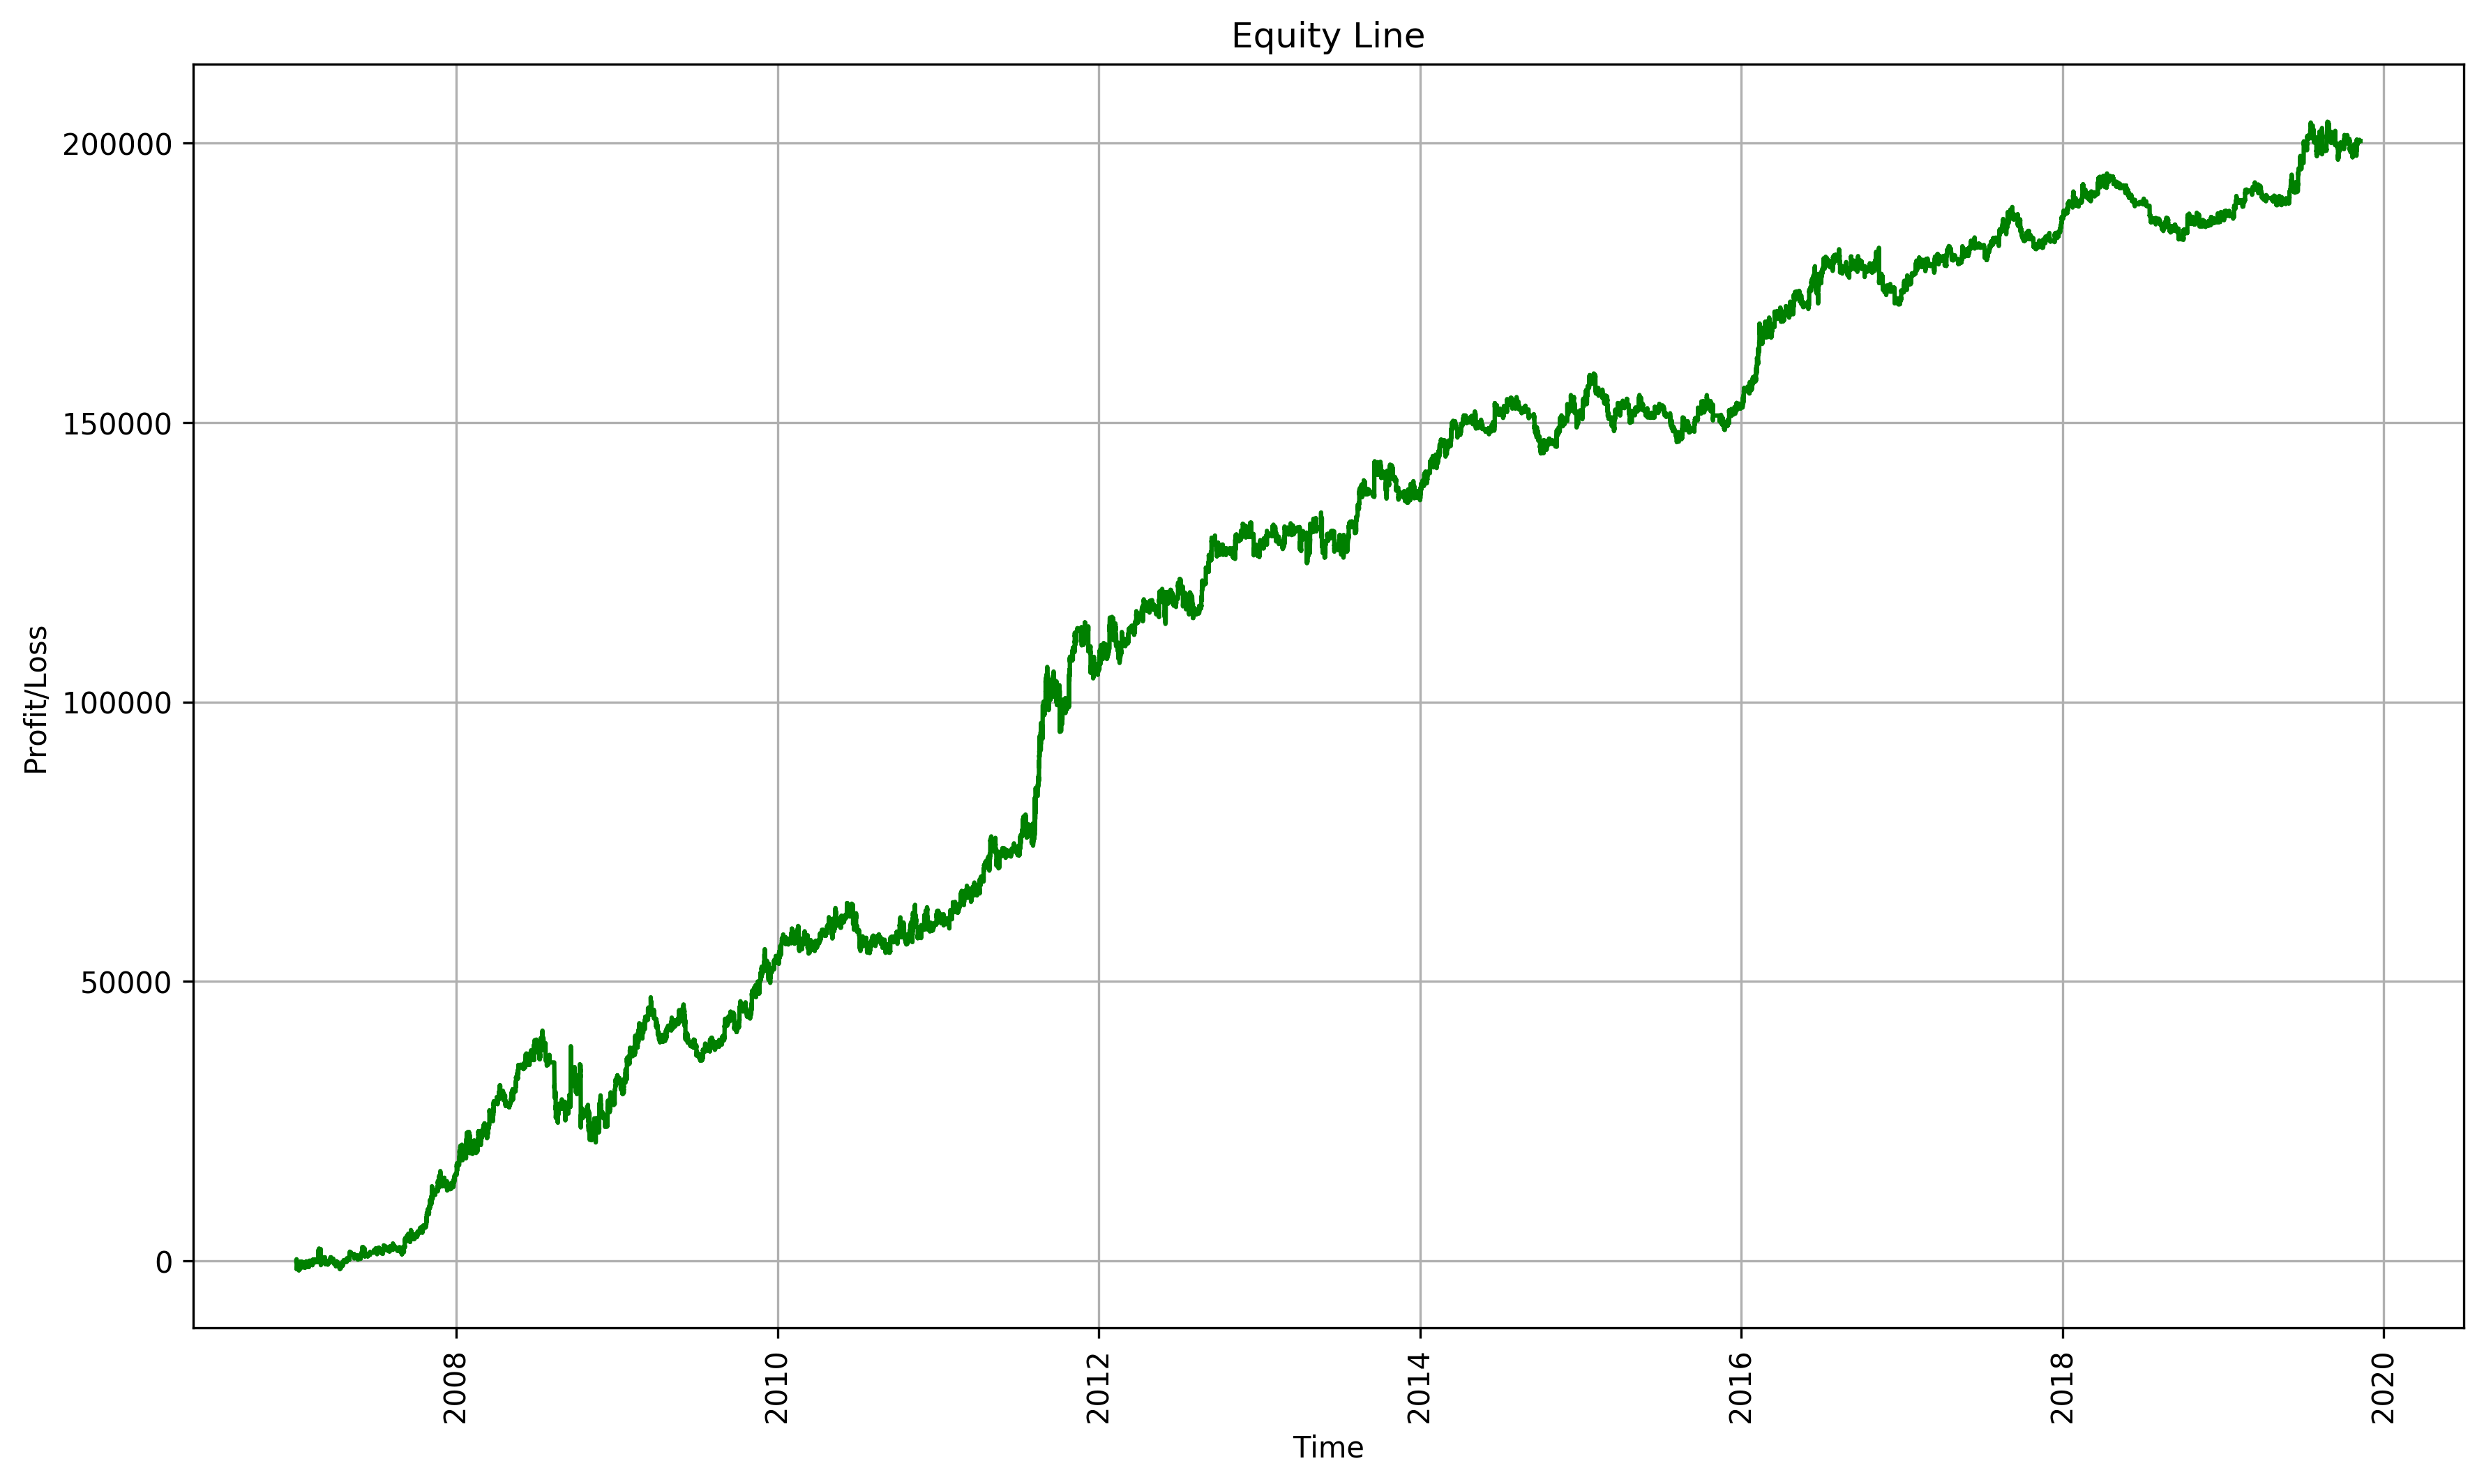

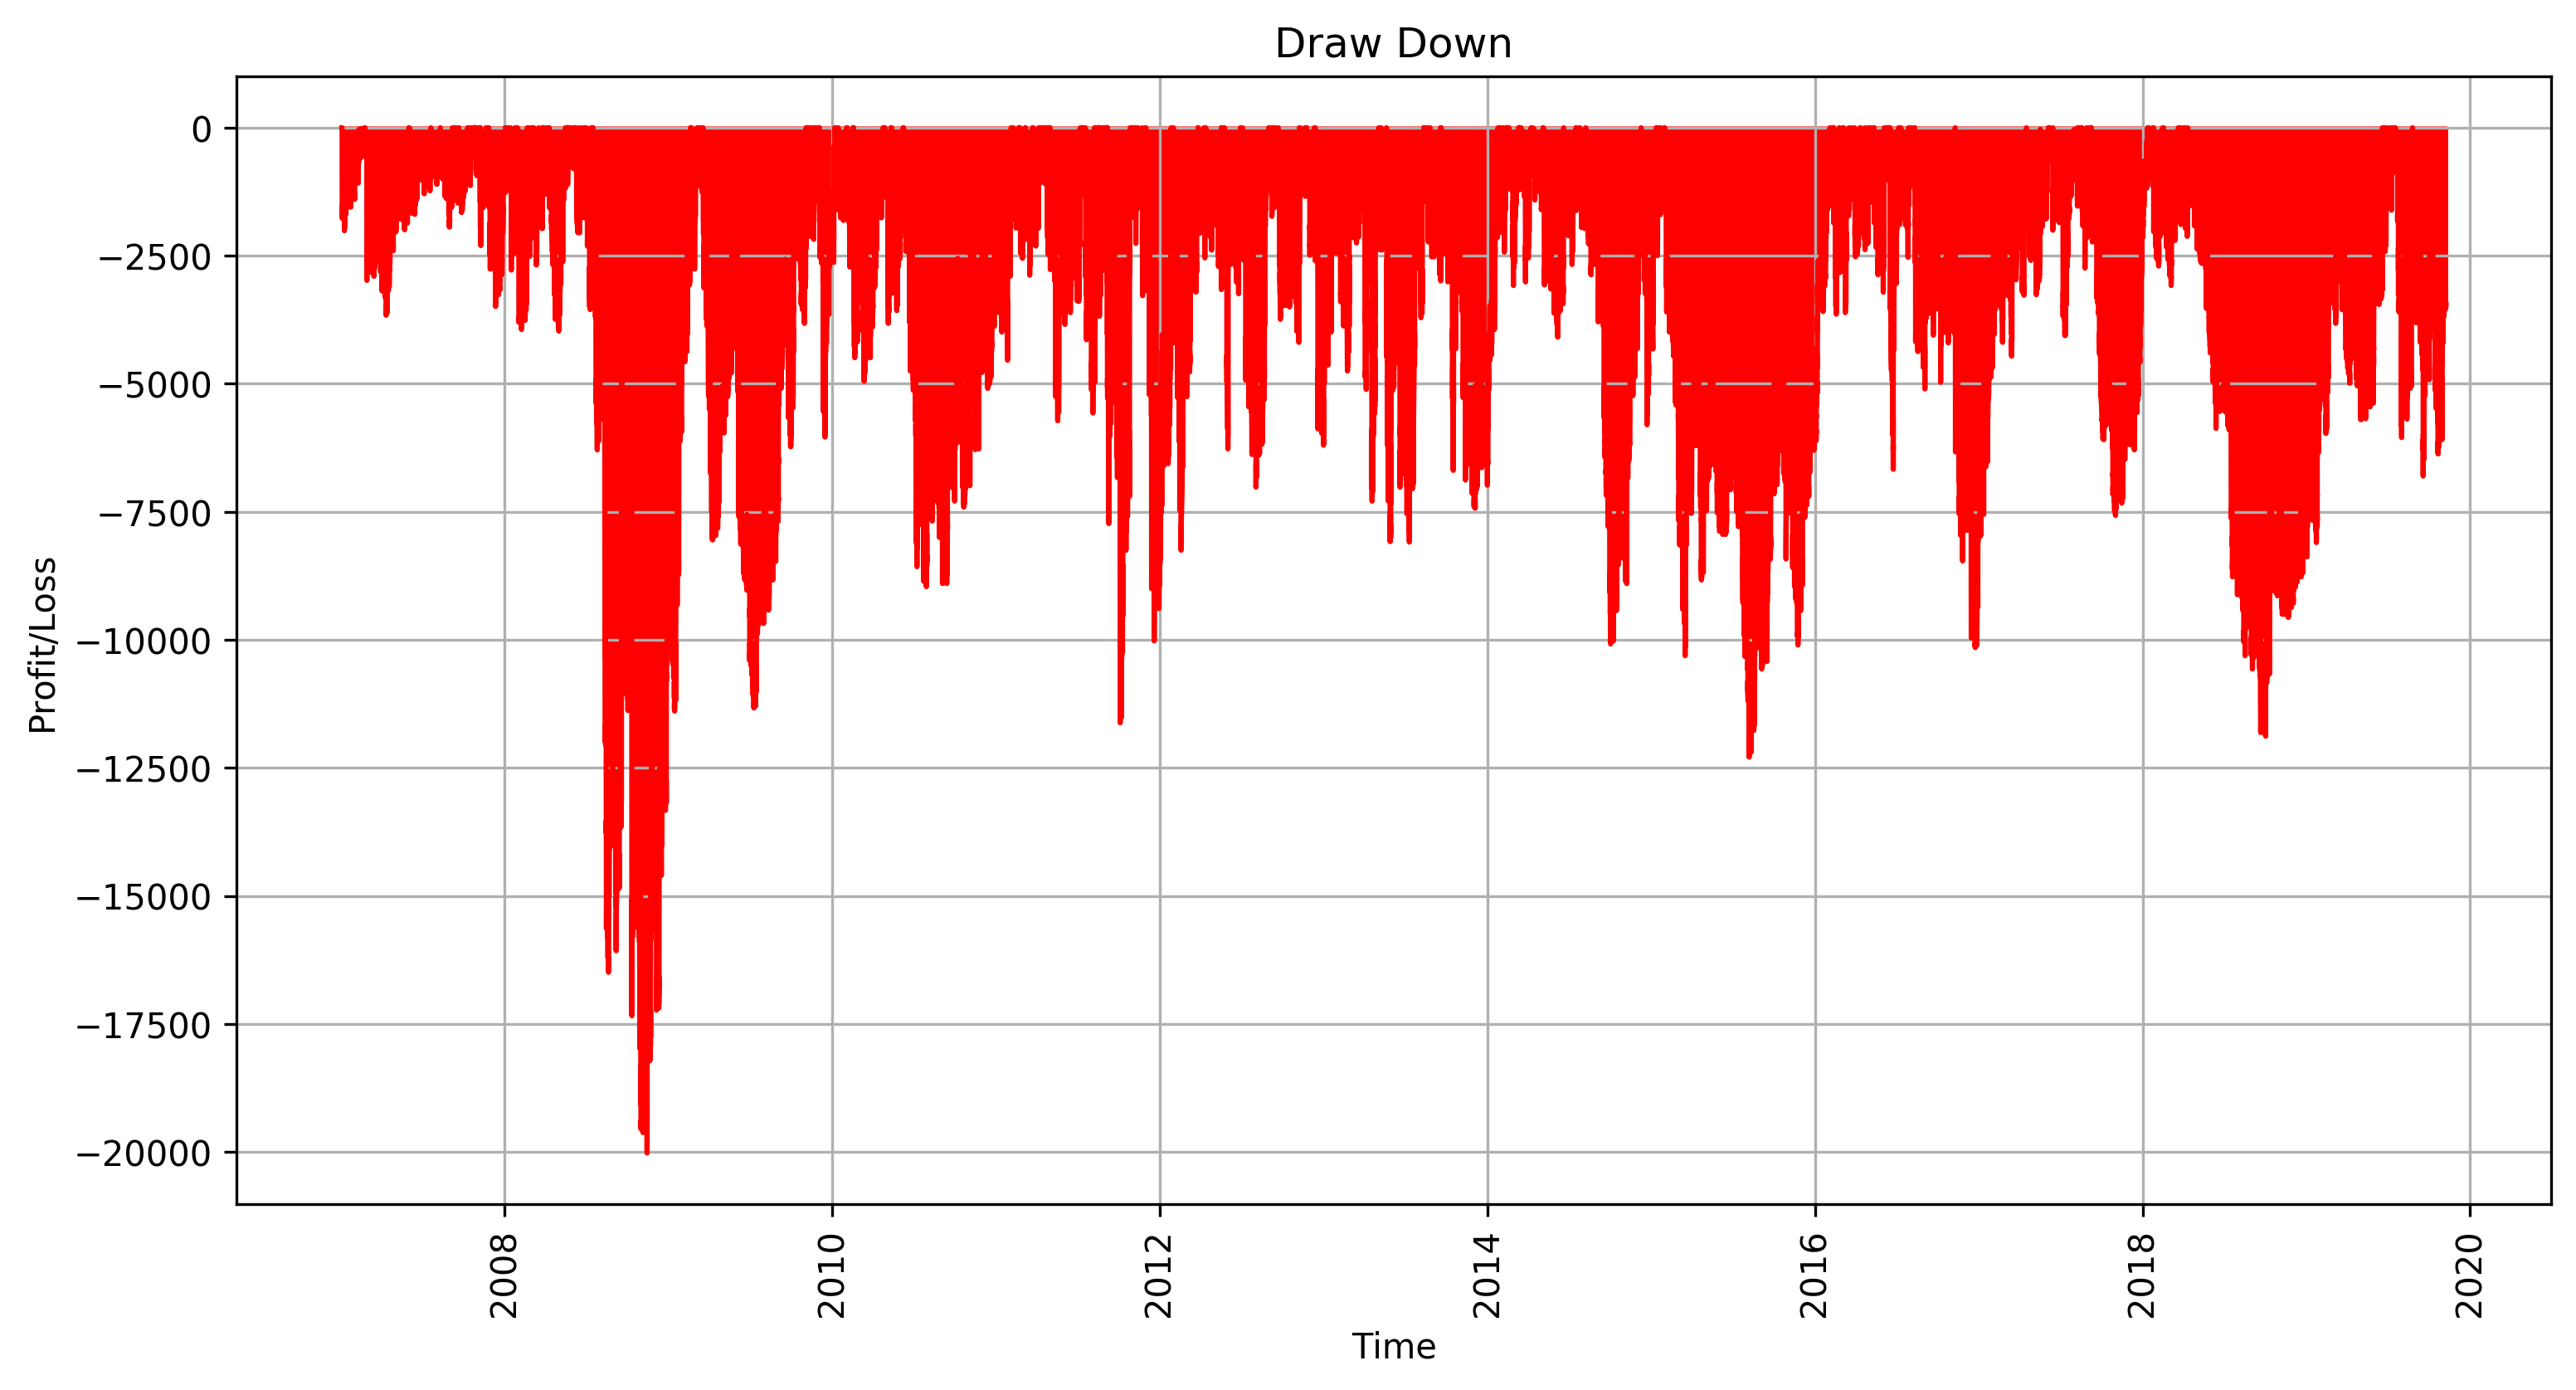

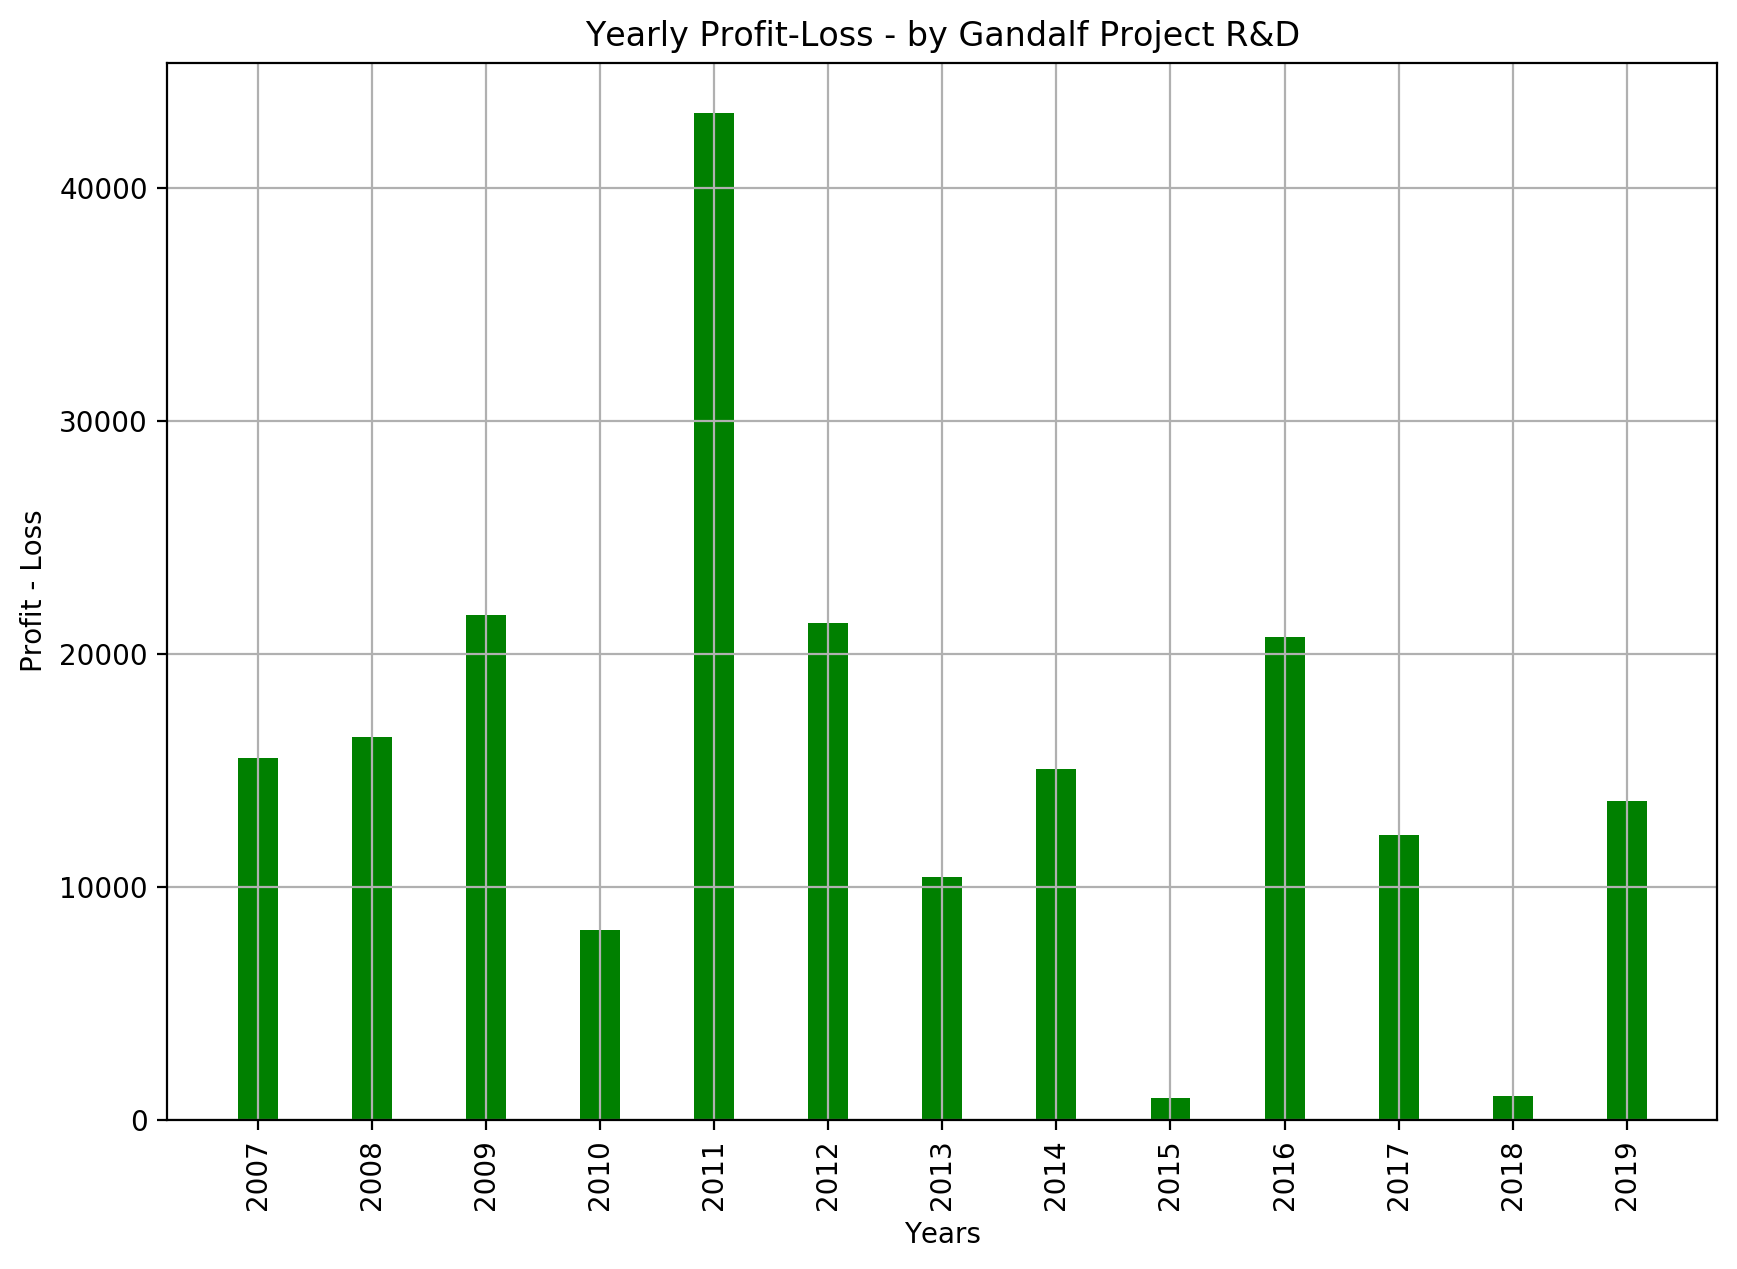

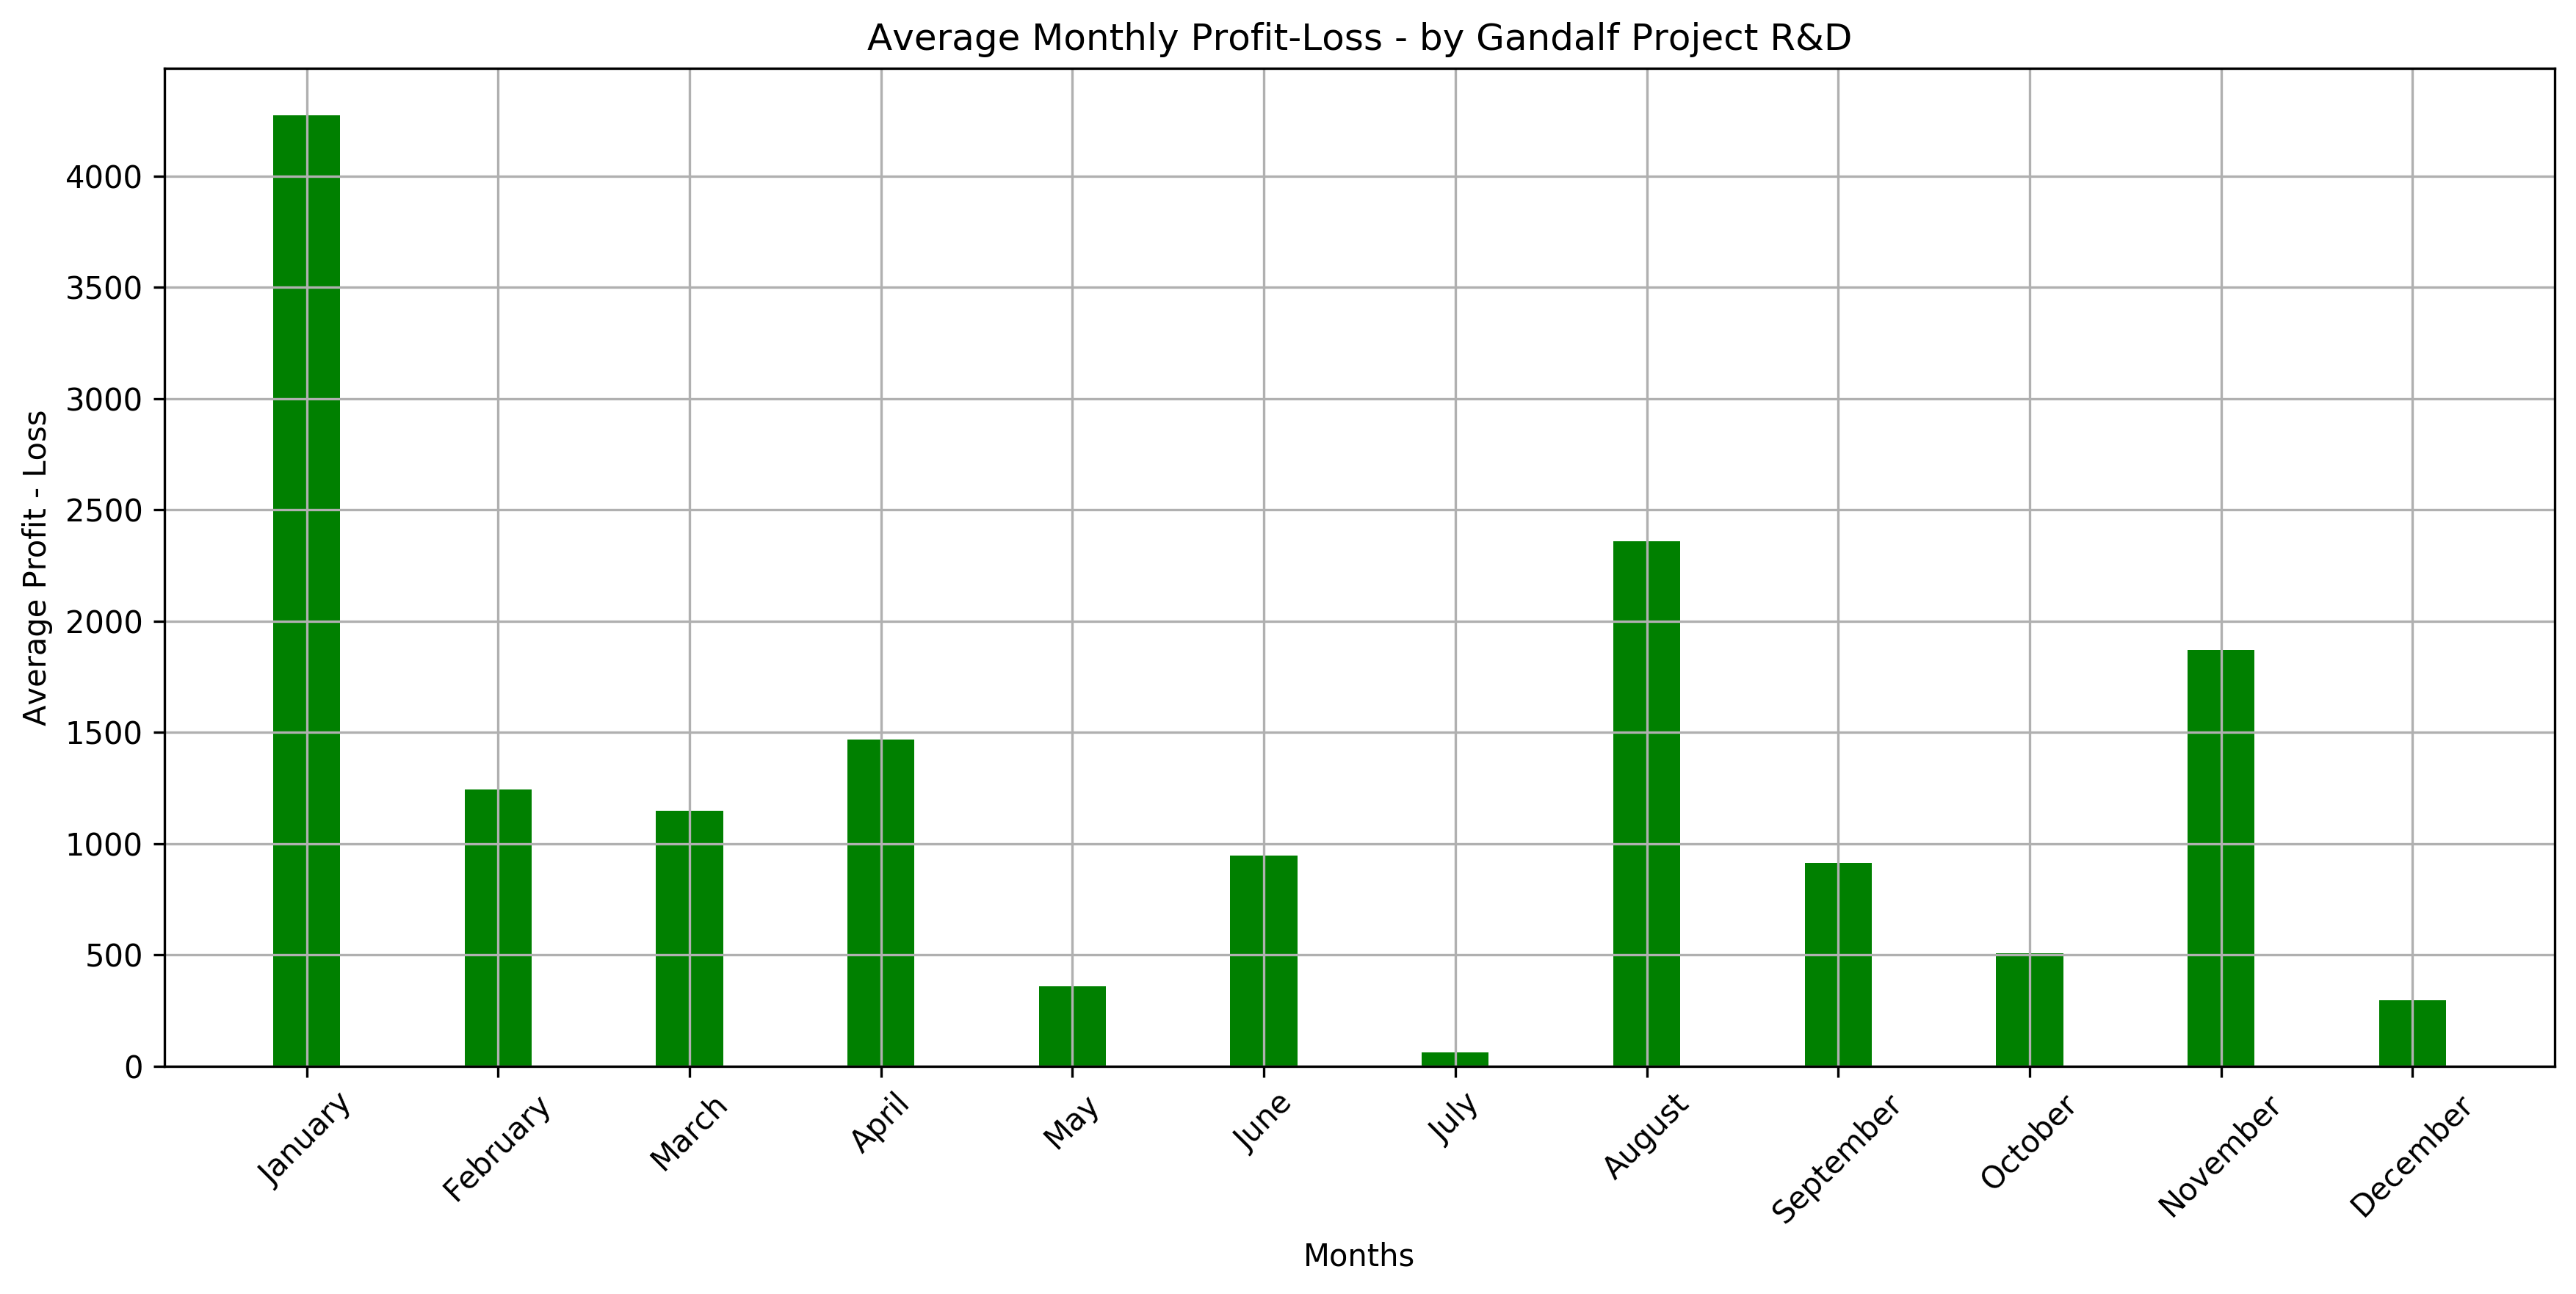

Elaboration ends at:  2019-11-27 18:39:04.813043
Elaboration time:  0:00:23.598963


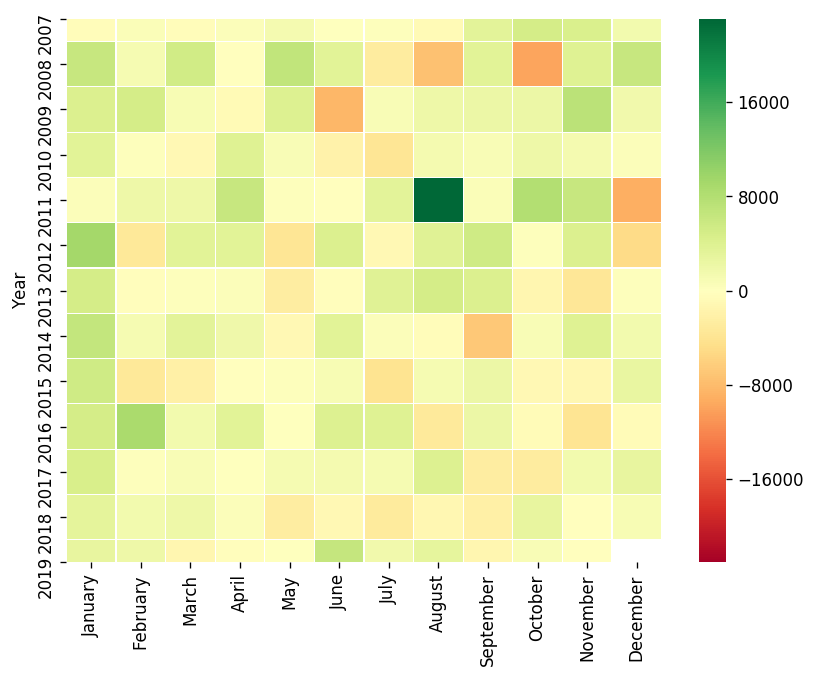

In [14]:
dataset = load_data_intraday("@GC_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.low.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.low.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.1
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"
enter_level = dataset.hhv92.shift(1)

enter_rules = dataset.close > 0 #blastoff
exit_rules = dataset.hour == 22

start = datetime.datetime.now()
print("Elaboration starts at: ", start)

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

end = datetime.datetime.now()
print("Elaboration ends at: ", end)
elaboration_time = end - start
print("Elaboration time: ", elaboration_time)

# Short con Blastoff, filtro temporale e dayofweek

Elaboration starts at:  2019-11-27 18:39:49.719153
Performance Report - by Gandalf Project R&D

Profit:                   57040.0
Operations:               499
Average Trade:            114.31

Profit Factor:            1.48
Gross Profit:             176570.0
Gross Loss:               -119530.0

Percent Winning Trades:   51.7
Percent Losing Trades:    48.3
Reward Risk Ratio:        1.38

Max Gain:                 3820.0  in date  2011-12-14 11:00:00
Average Gain:             684.38
Max Loss:                 -2700.0  in date  2013-10-22 11:00:00
Average Loss:             -506.48

Avg Open Draw Down:       -2014.9
Max Open Draw Down:       -8110.0

Avg Closed Draw Down:     -1904.38
Max Closed Draw Down:     -5610.0

Avg Delay Between Peaks:  1714.25
Max Delay Between Peaks:  60969


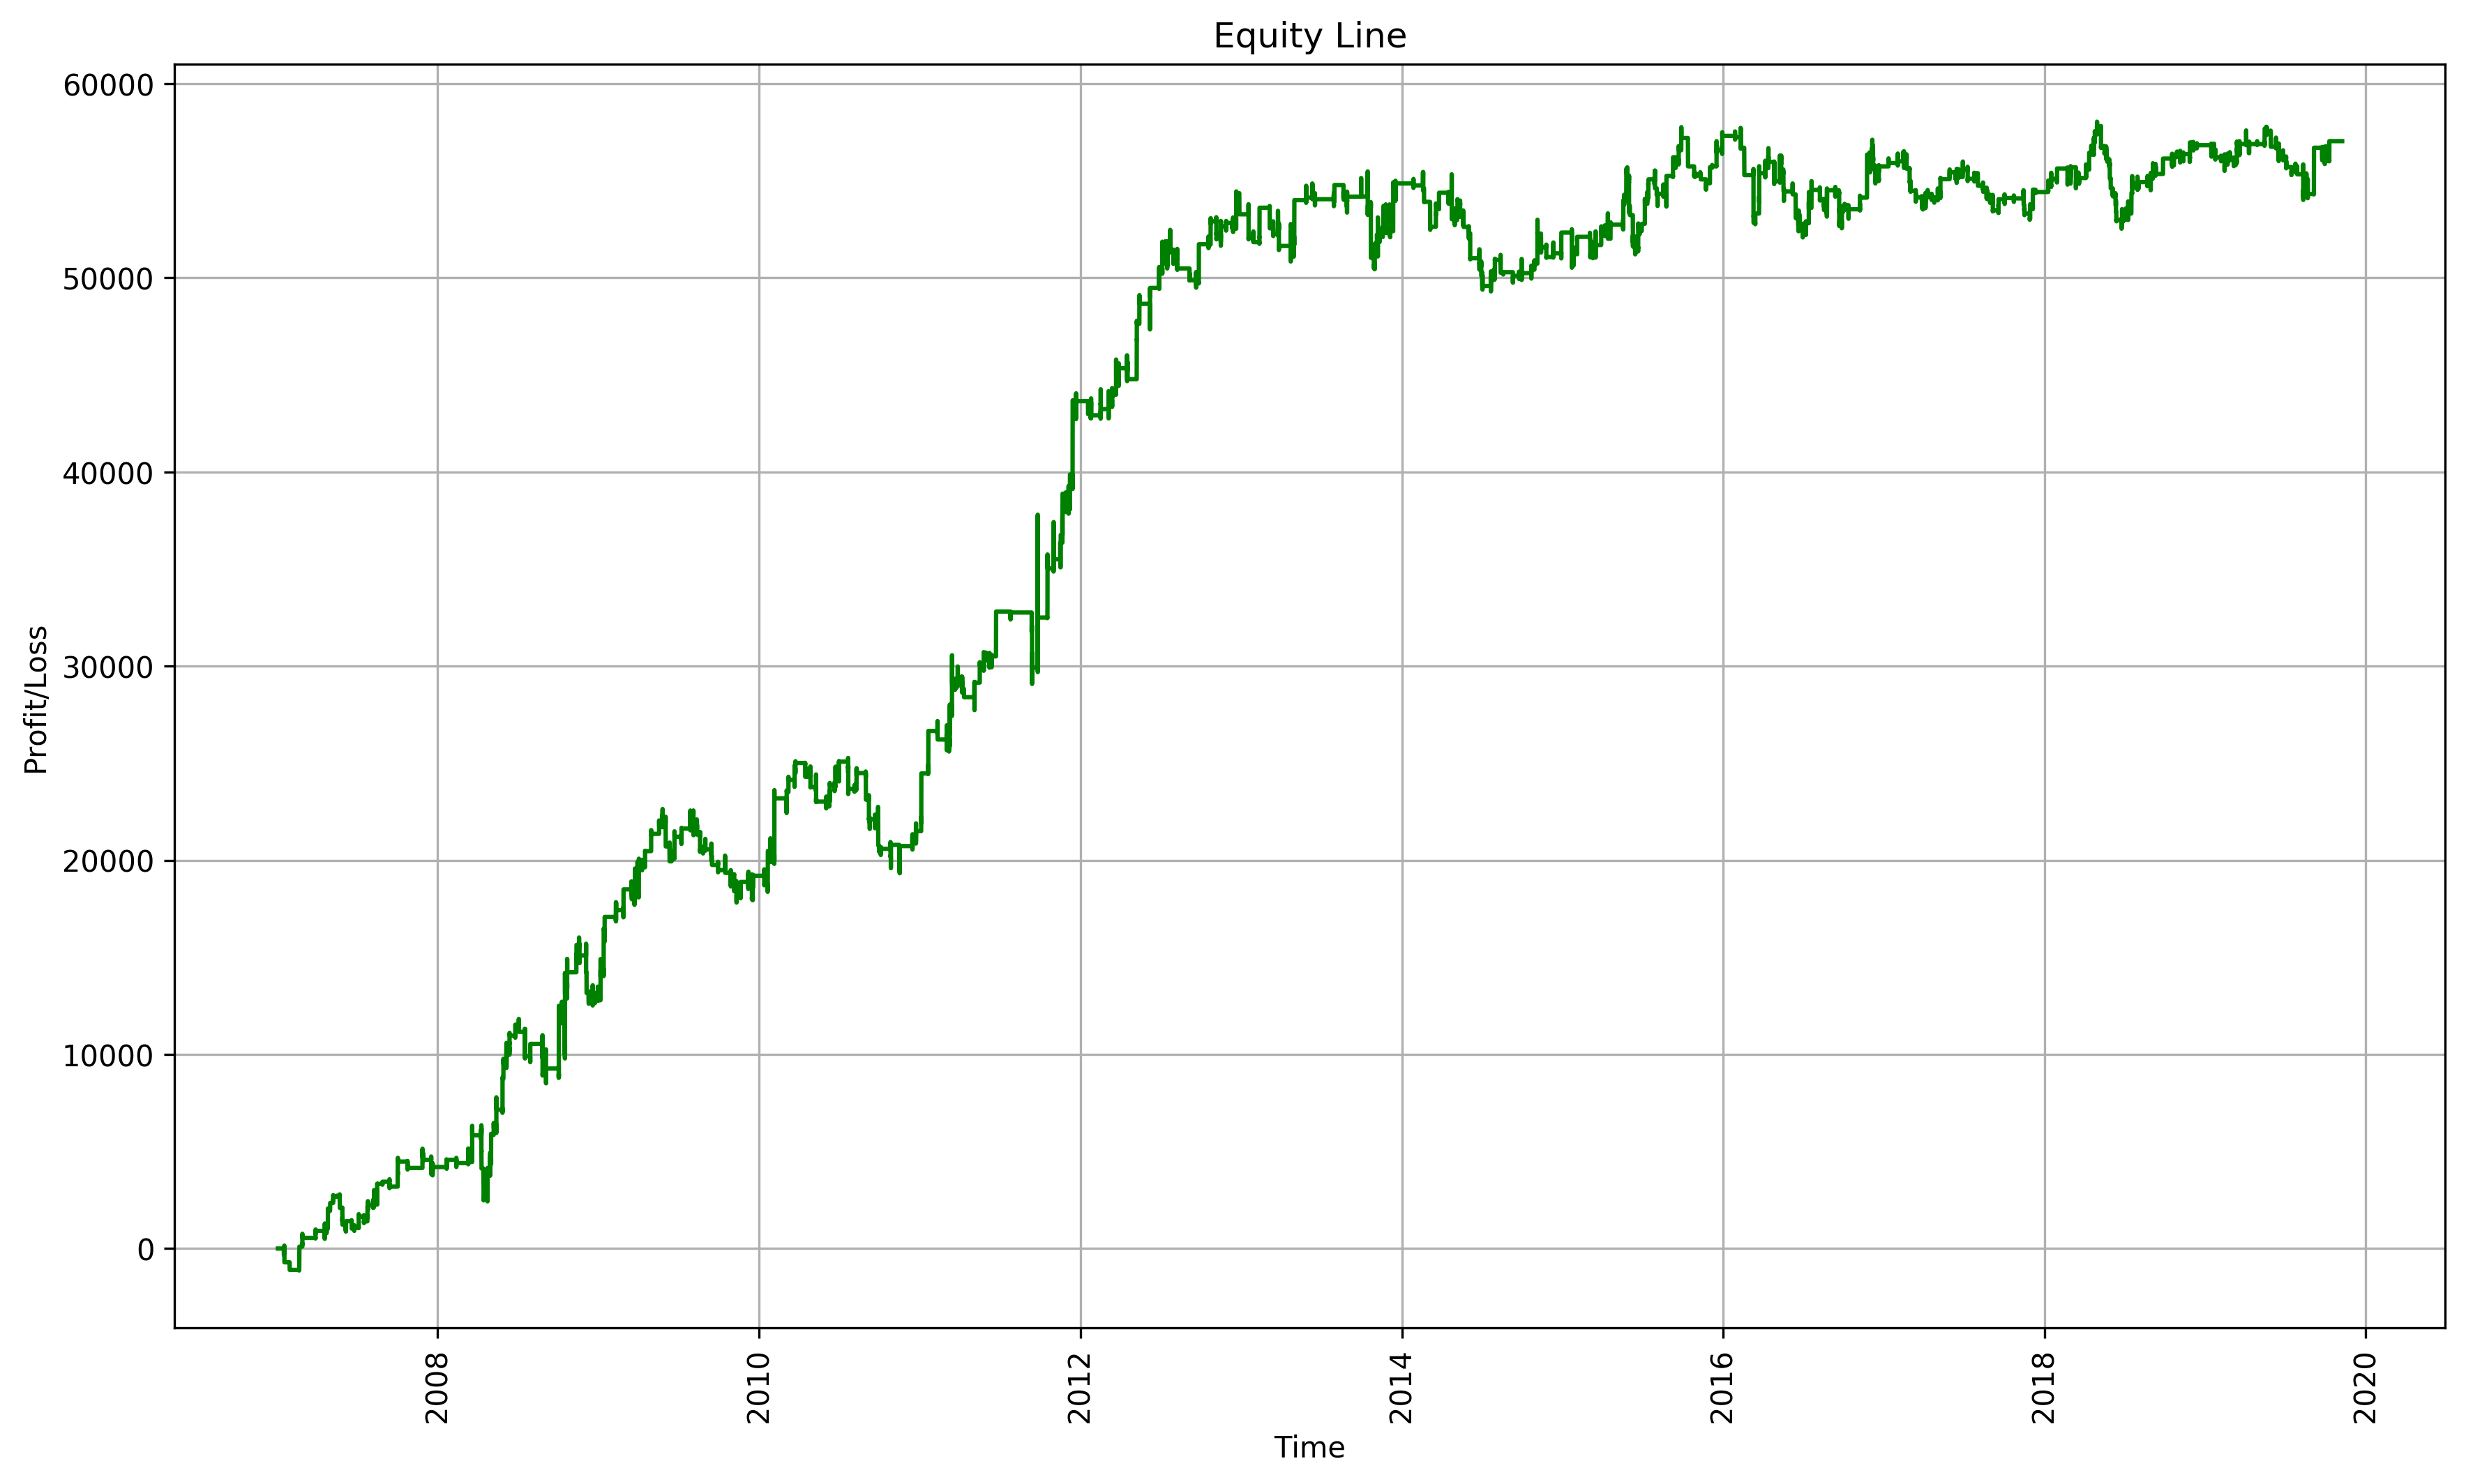

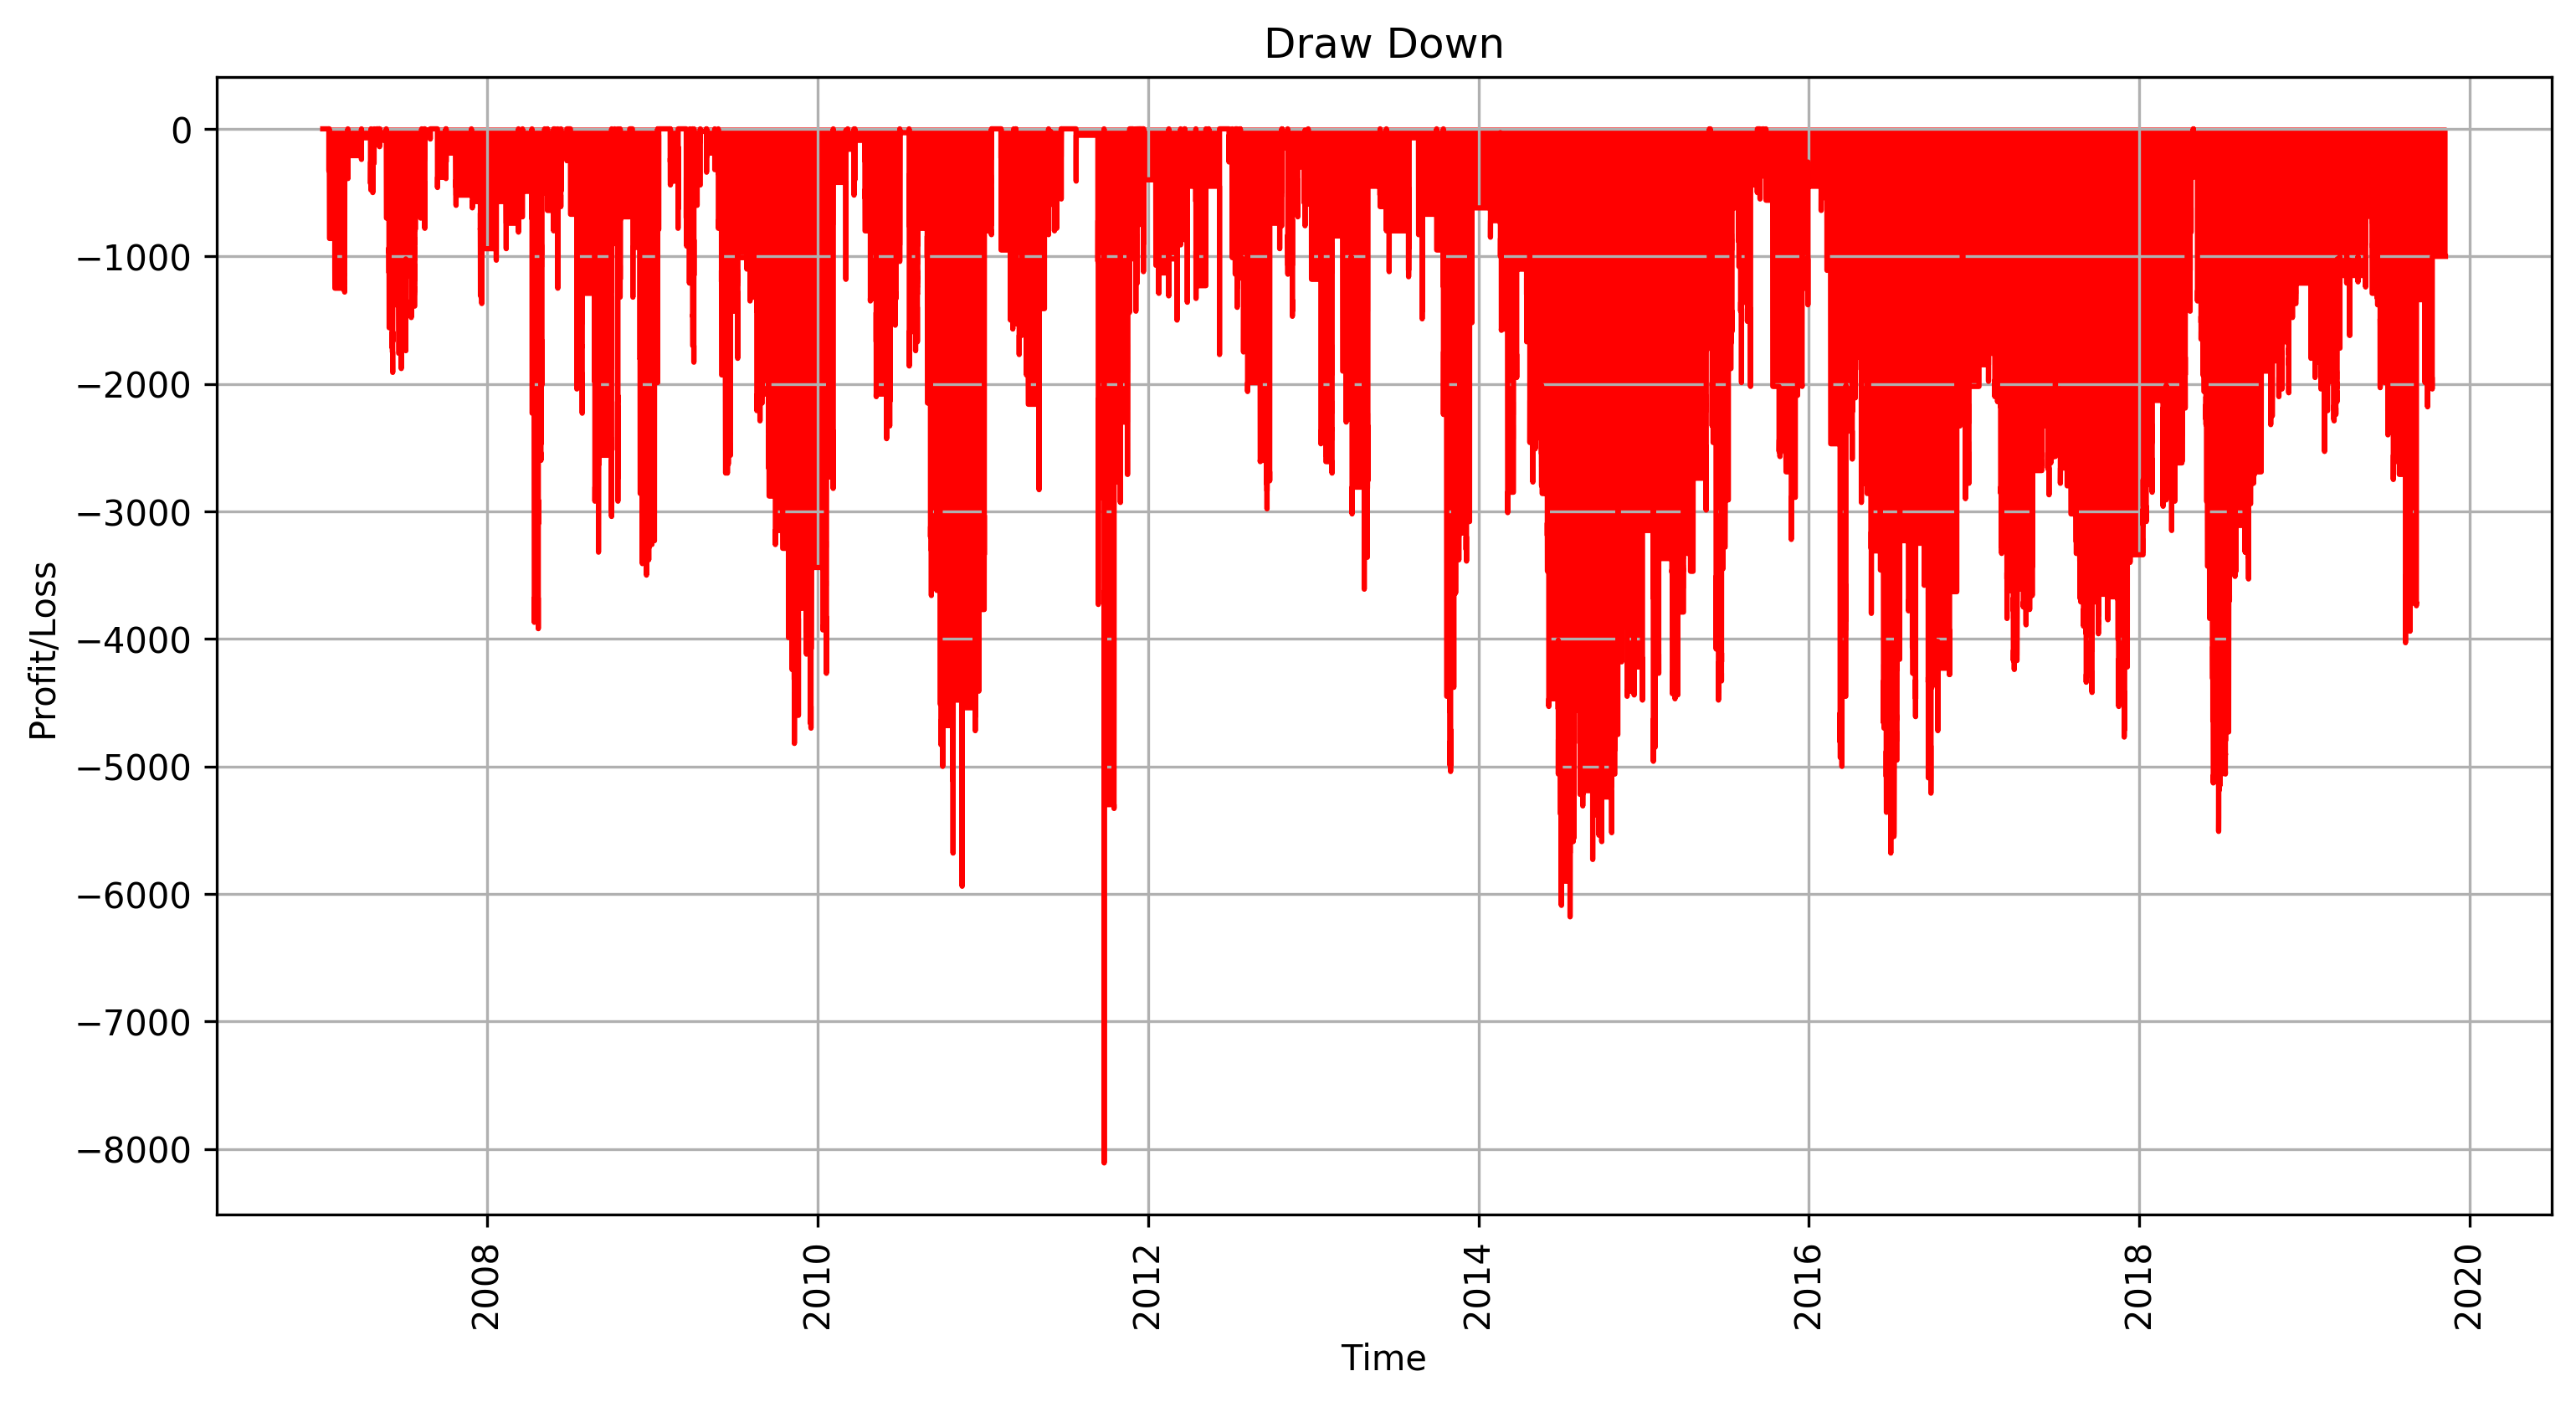

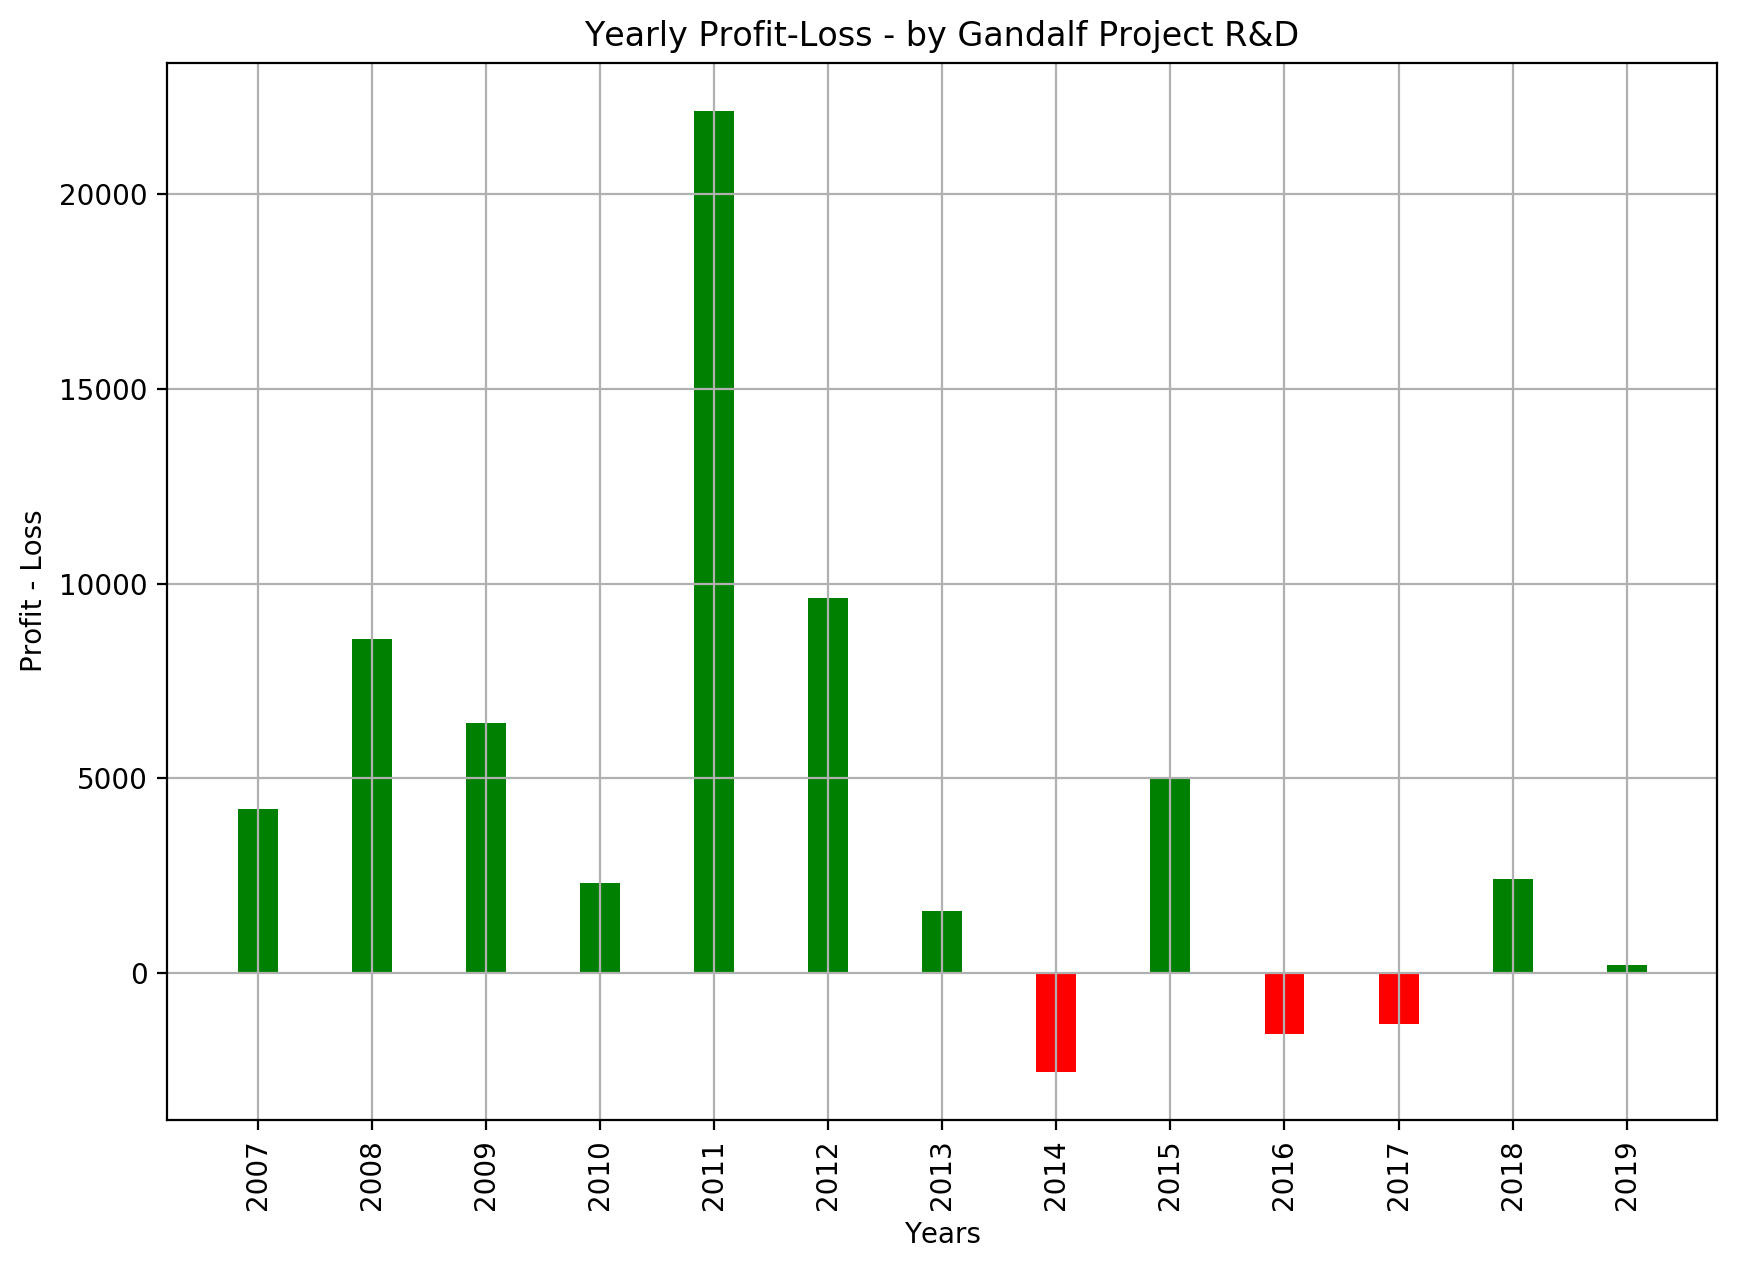

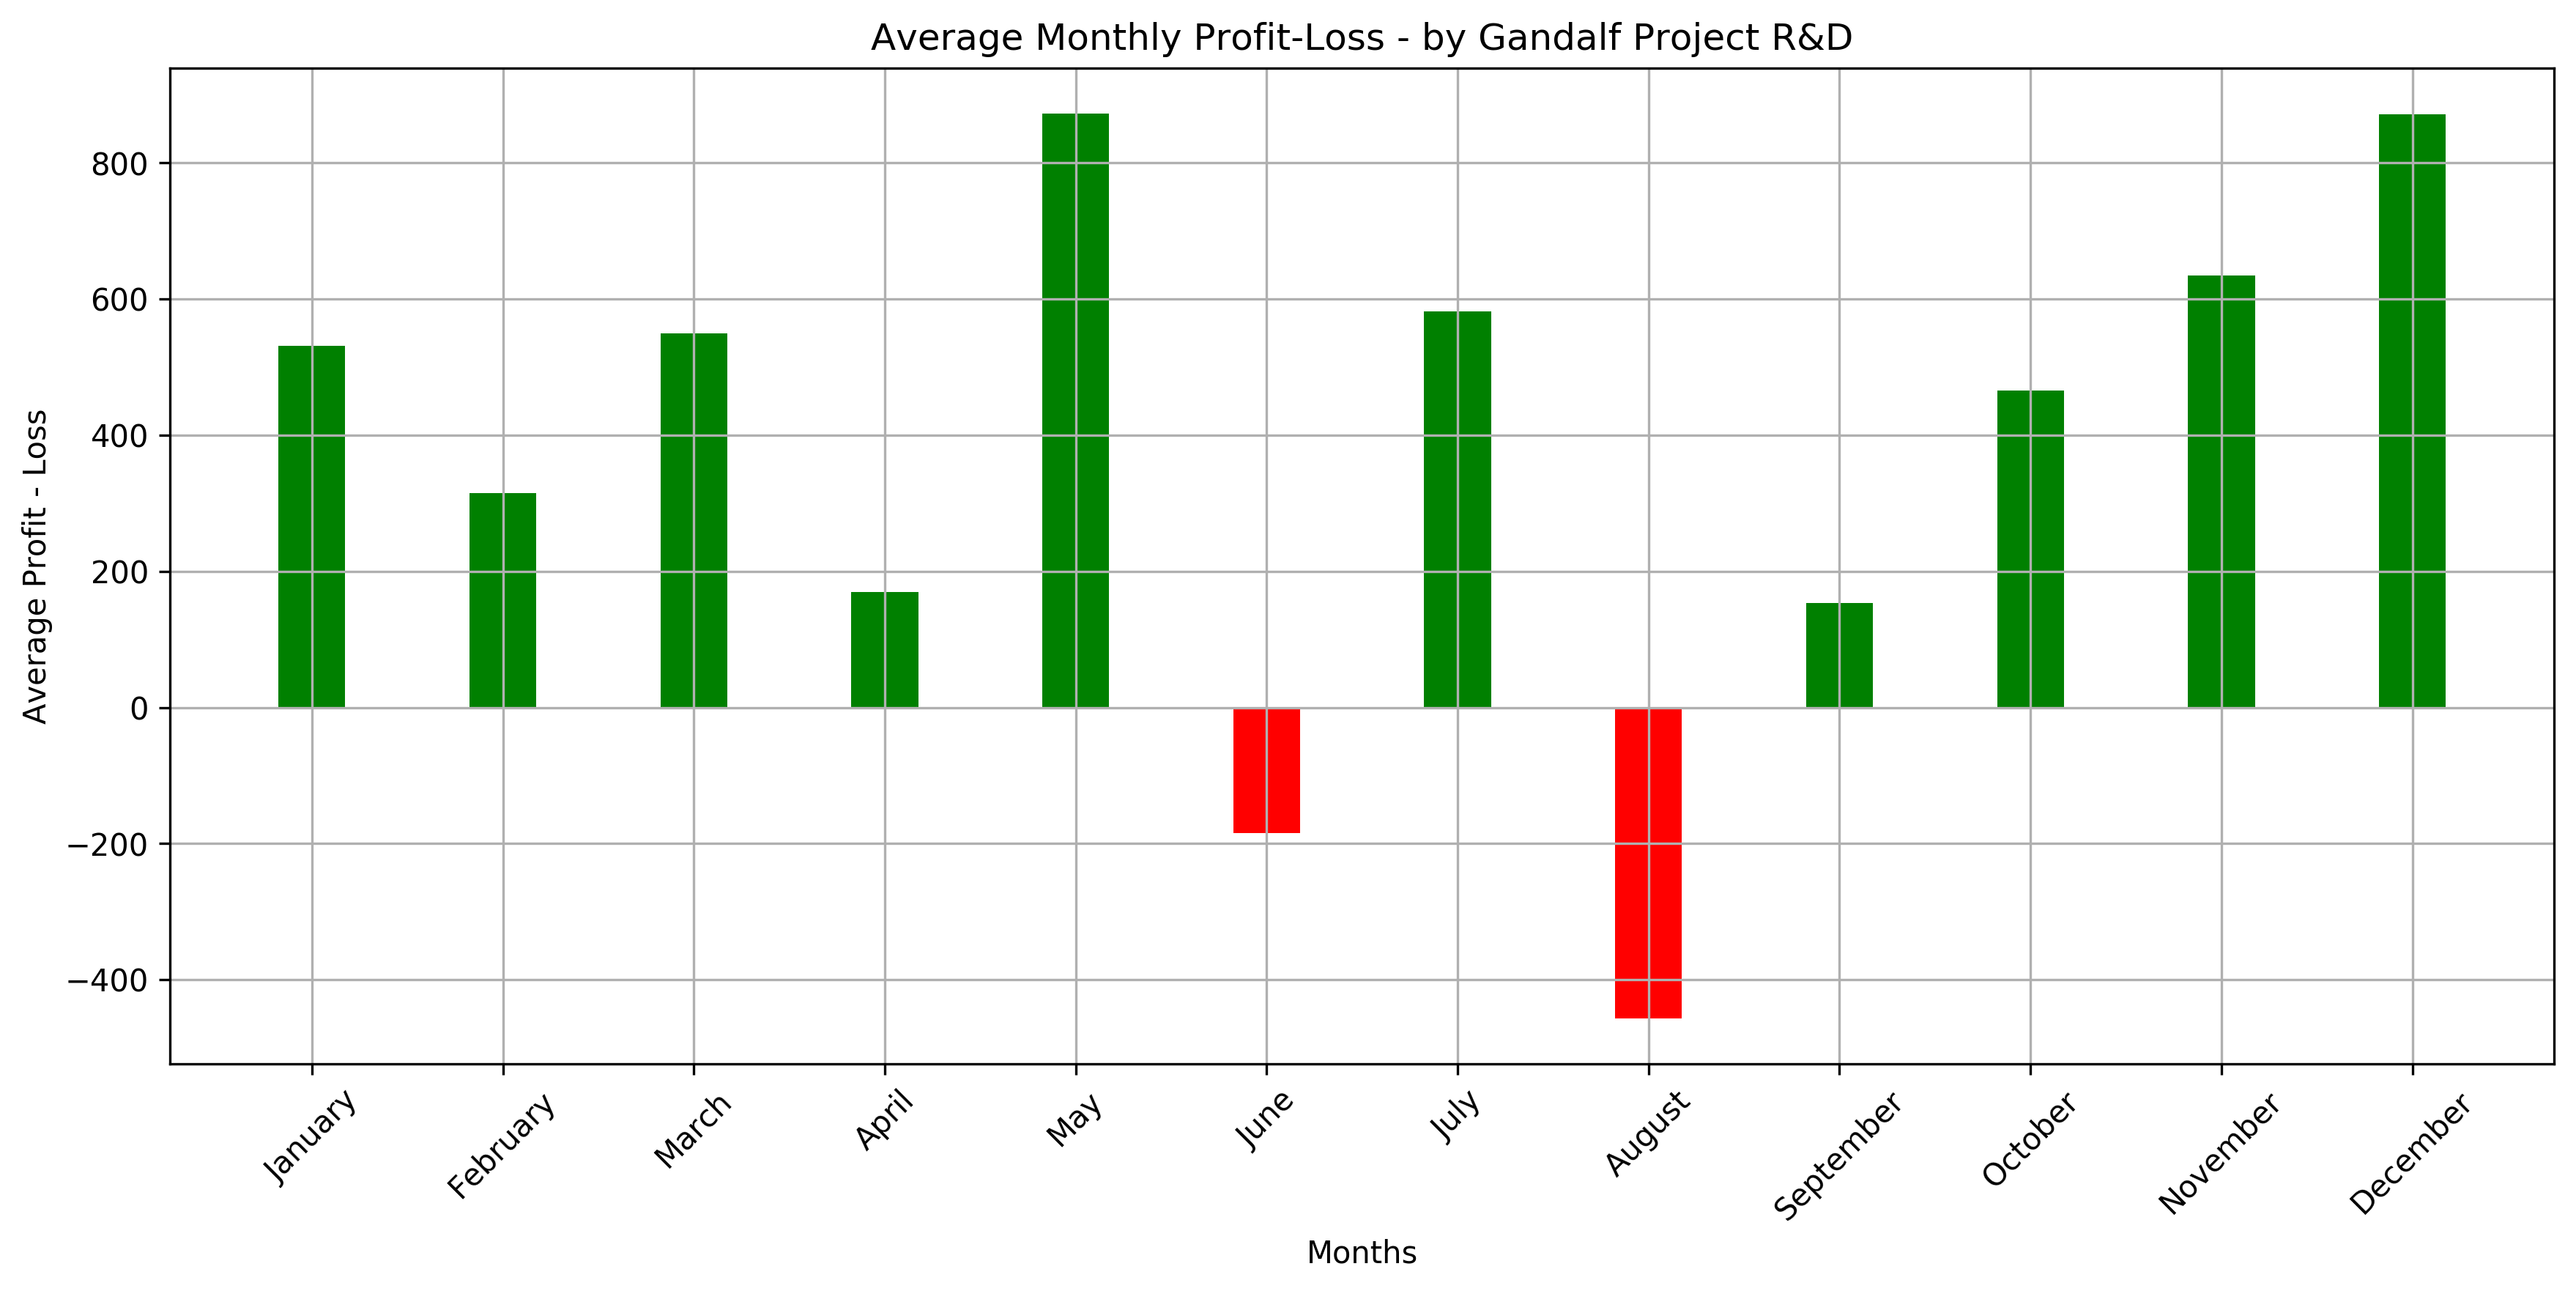

Elaboration ends at:  2019-11-27 18:40:11.119318
Elaboration time:  0:00:21.400165


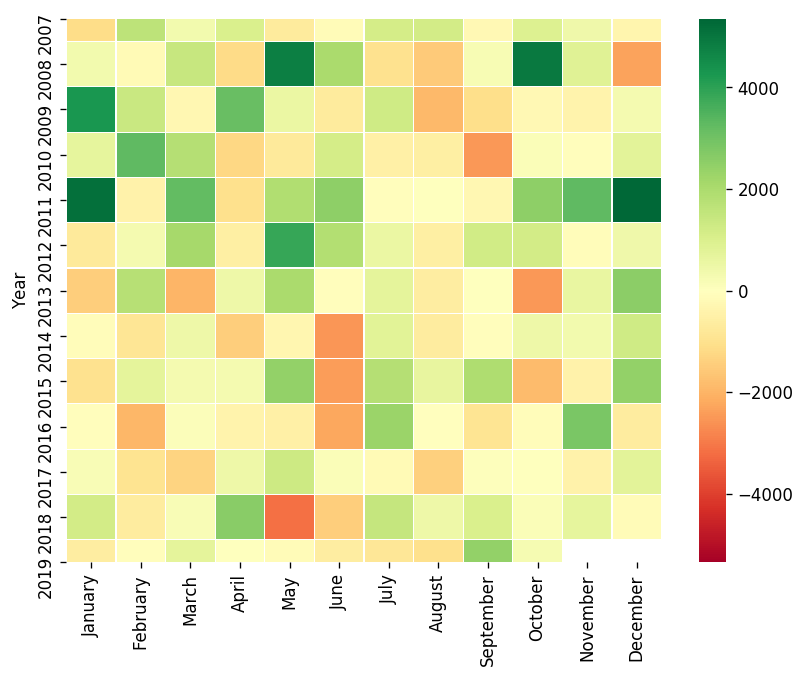

In [15]:
dataset = load_data_intraday("@GC_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.low.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.low.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.1
OPERATION_MONEY = 10000
DIRECTION = "short"
ORDER_TYPE = "stop"
enter_level = dataset.llv92.shift(1)

enter_rules = blastoff & (dataset.dayofweek != 4) & (dataset.hour < 10)
exit_rules = dataset.hour == 11

start = datetime.datetime.now()
print("Elaboration starts at: ", start)

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

end = datetime.datetime.now()
print("Elaboration ends at: ", end)
elaboration_time = end - start
print("Elaboration time: ", elaboration_time)

# Long con Blastoff, filtro temporale e dayofweek

Elaboration starts at:  2019-11-27 18:40:53.774861
Performance Report - by Gandalf Project R&D

Profit:                   87760.0
Operations:               645
Average Trade:            136.06

Profit Factor:            1.63
Gross Profit:             227130.0
Gross Loss:               -139370.0

Percent Winning Trades:   53.64
Percent Losing Trades:    46.36
Reward Risk Ratio:        1.41

Max Gain:                 5440.0  in date  2016-06-24 03:00:00
Average Gain:             656.45
Max Loss:                 -2700.0  in date  2010-11-12 03:00:00
Average Loss:             -472.44

Avg Open Draw Down:       -2256.47
Max Open Draw Down:       -8880.0

Avg Closed Draw Down:     -2288.57
Max Closed Draw Down:     -8560.0

Avg Delay Between Peaks:  720.88
Max Delay Between Peaks:  32922


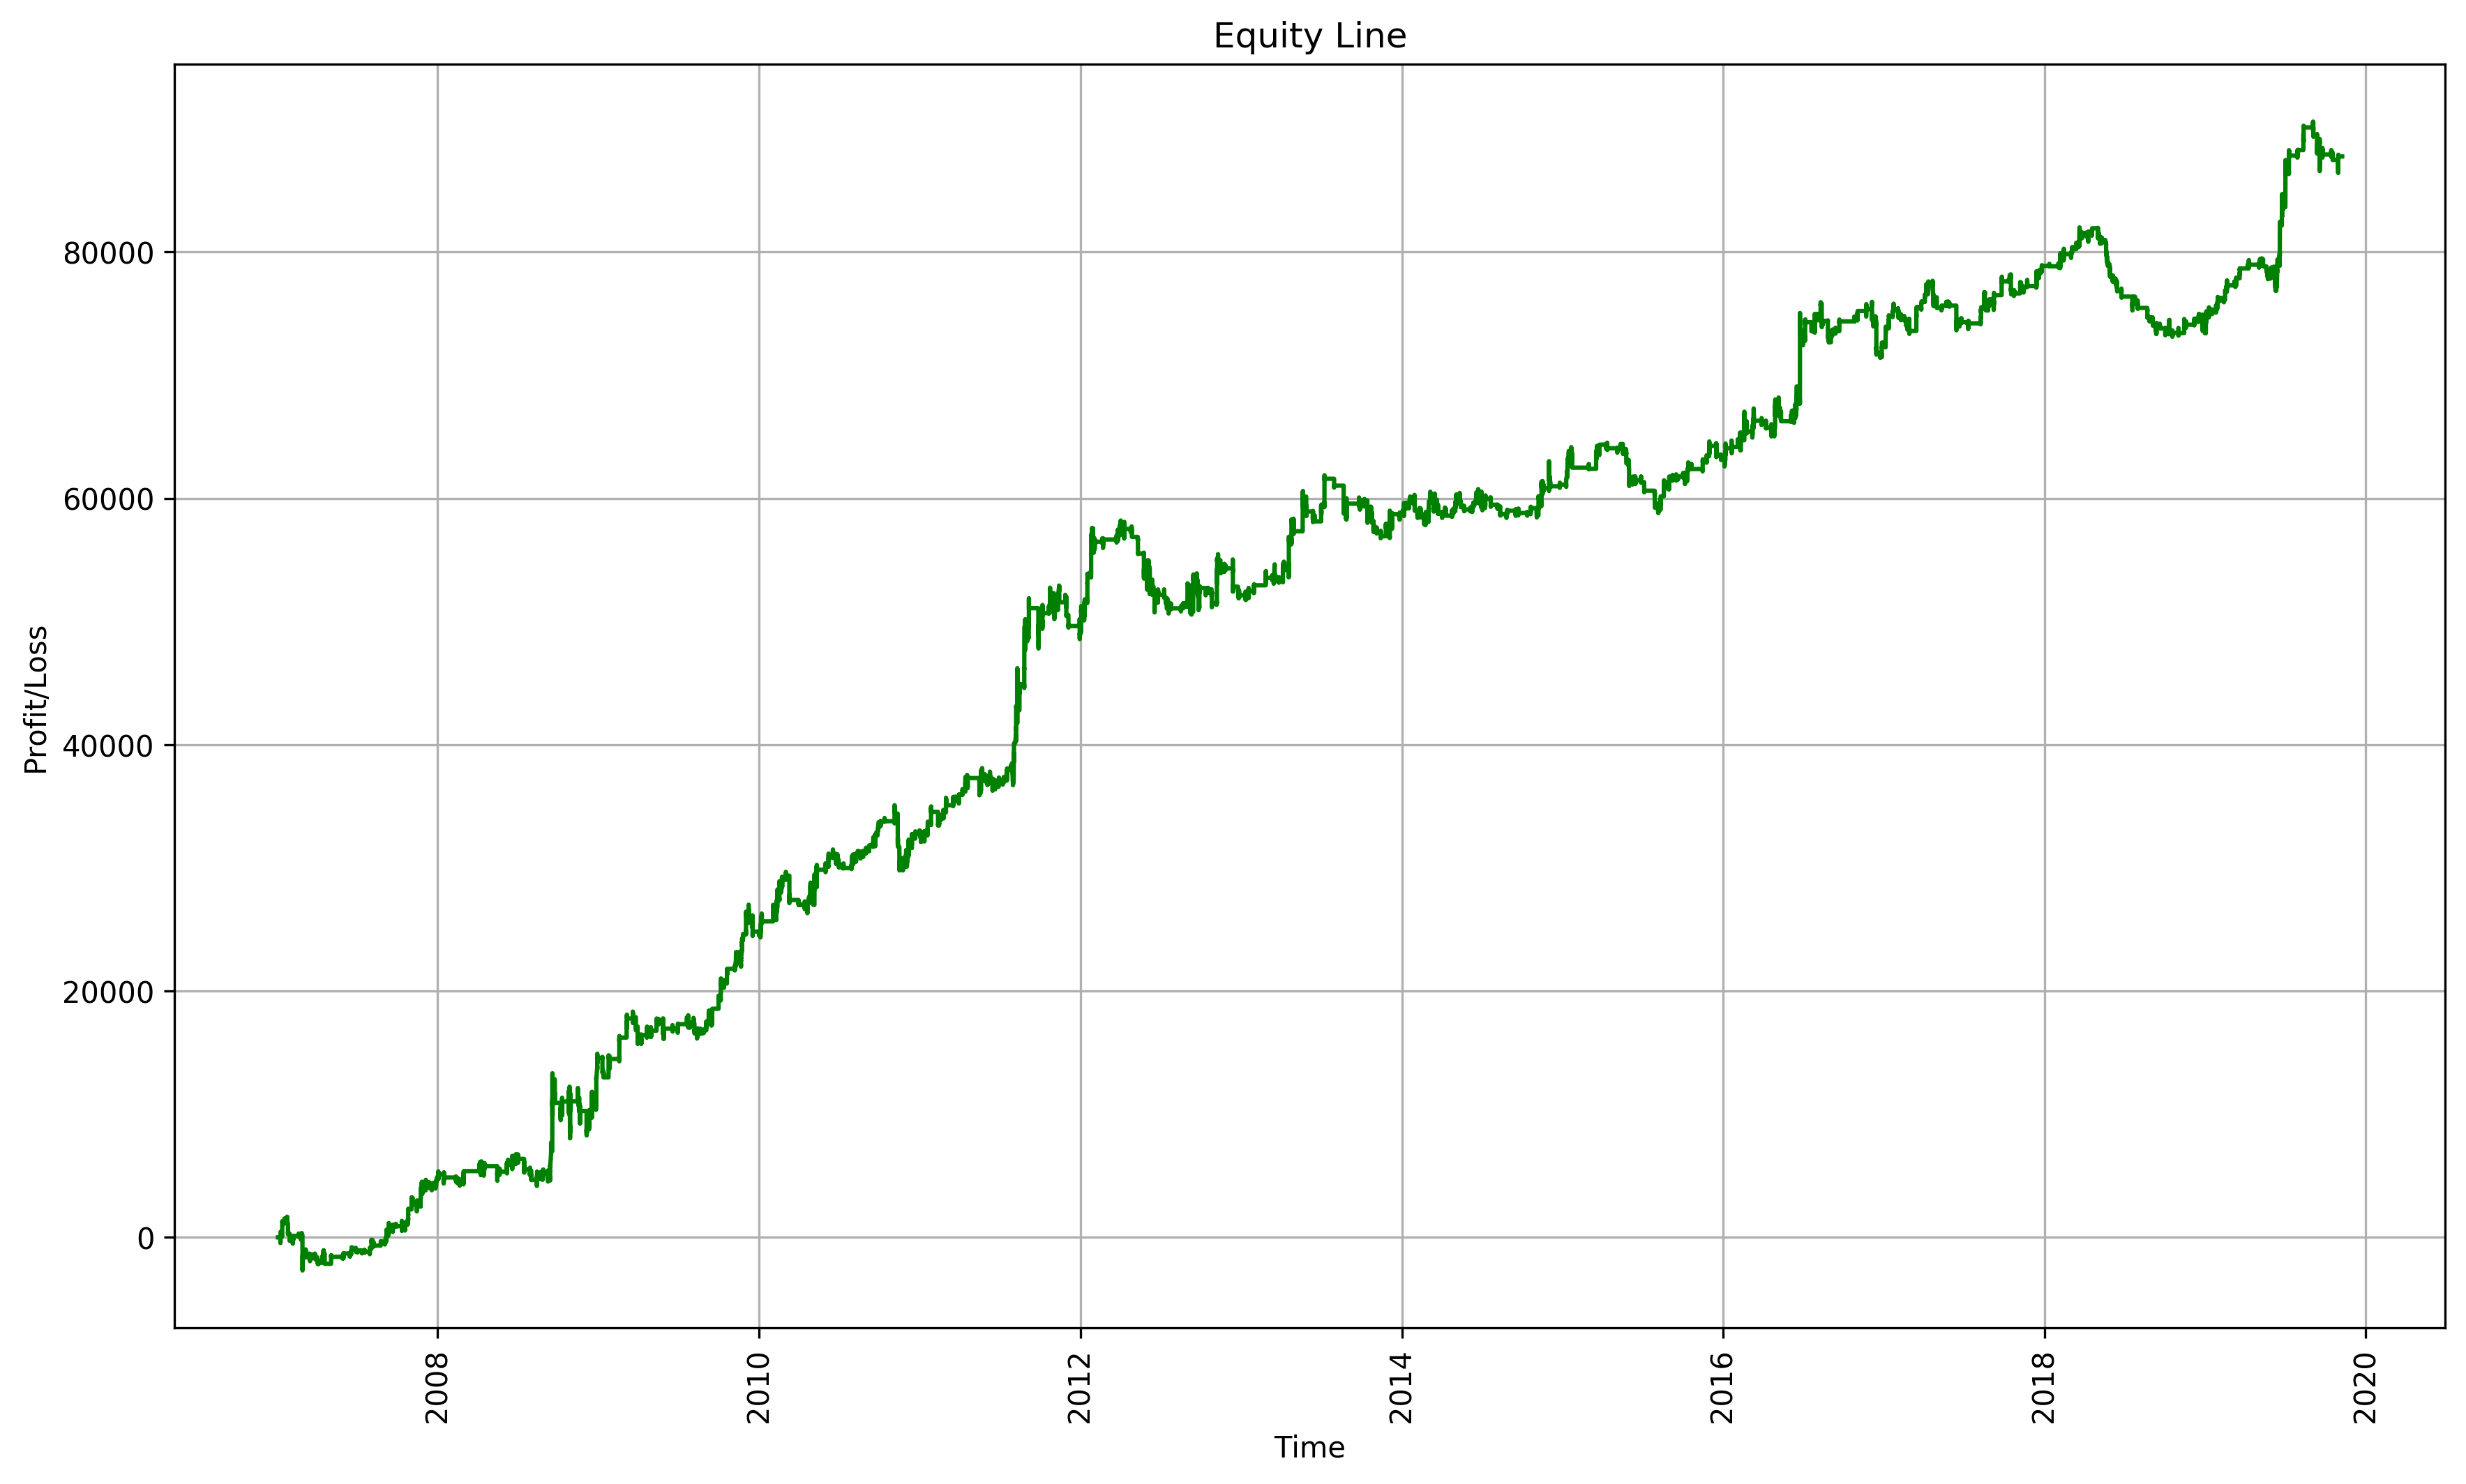

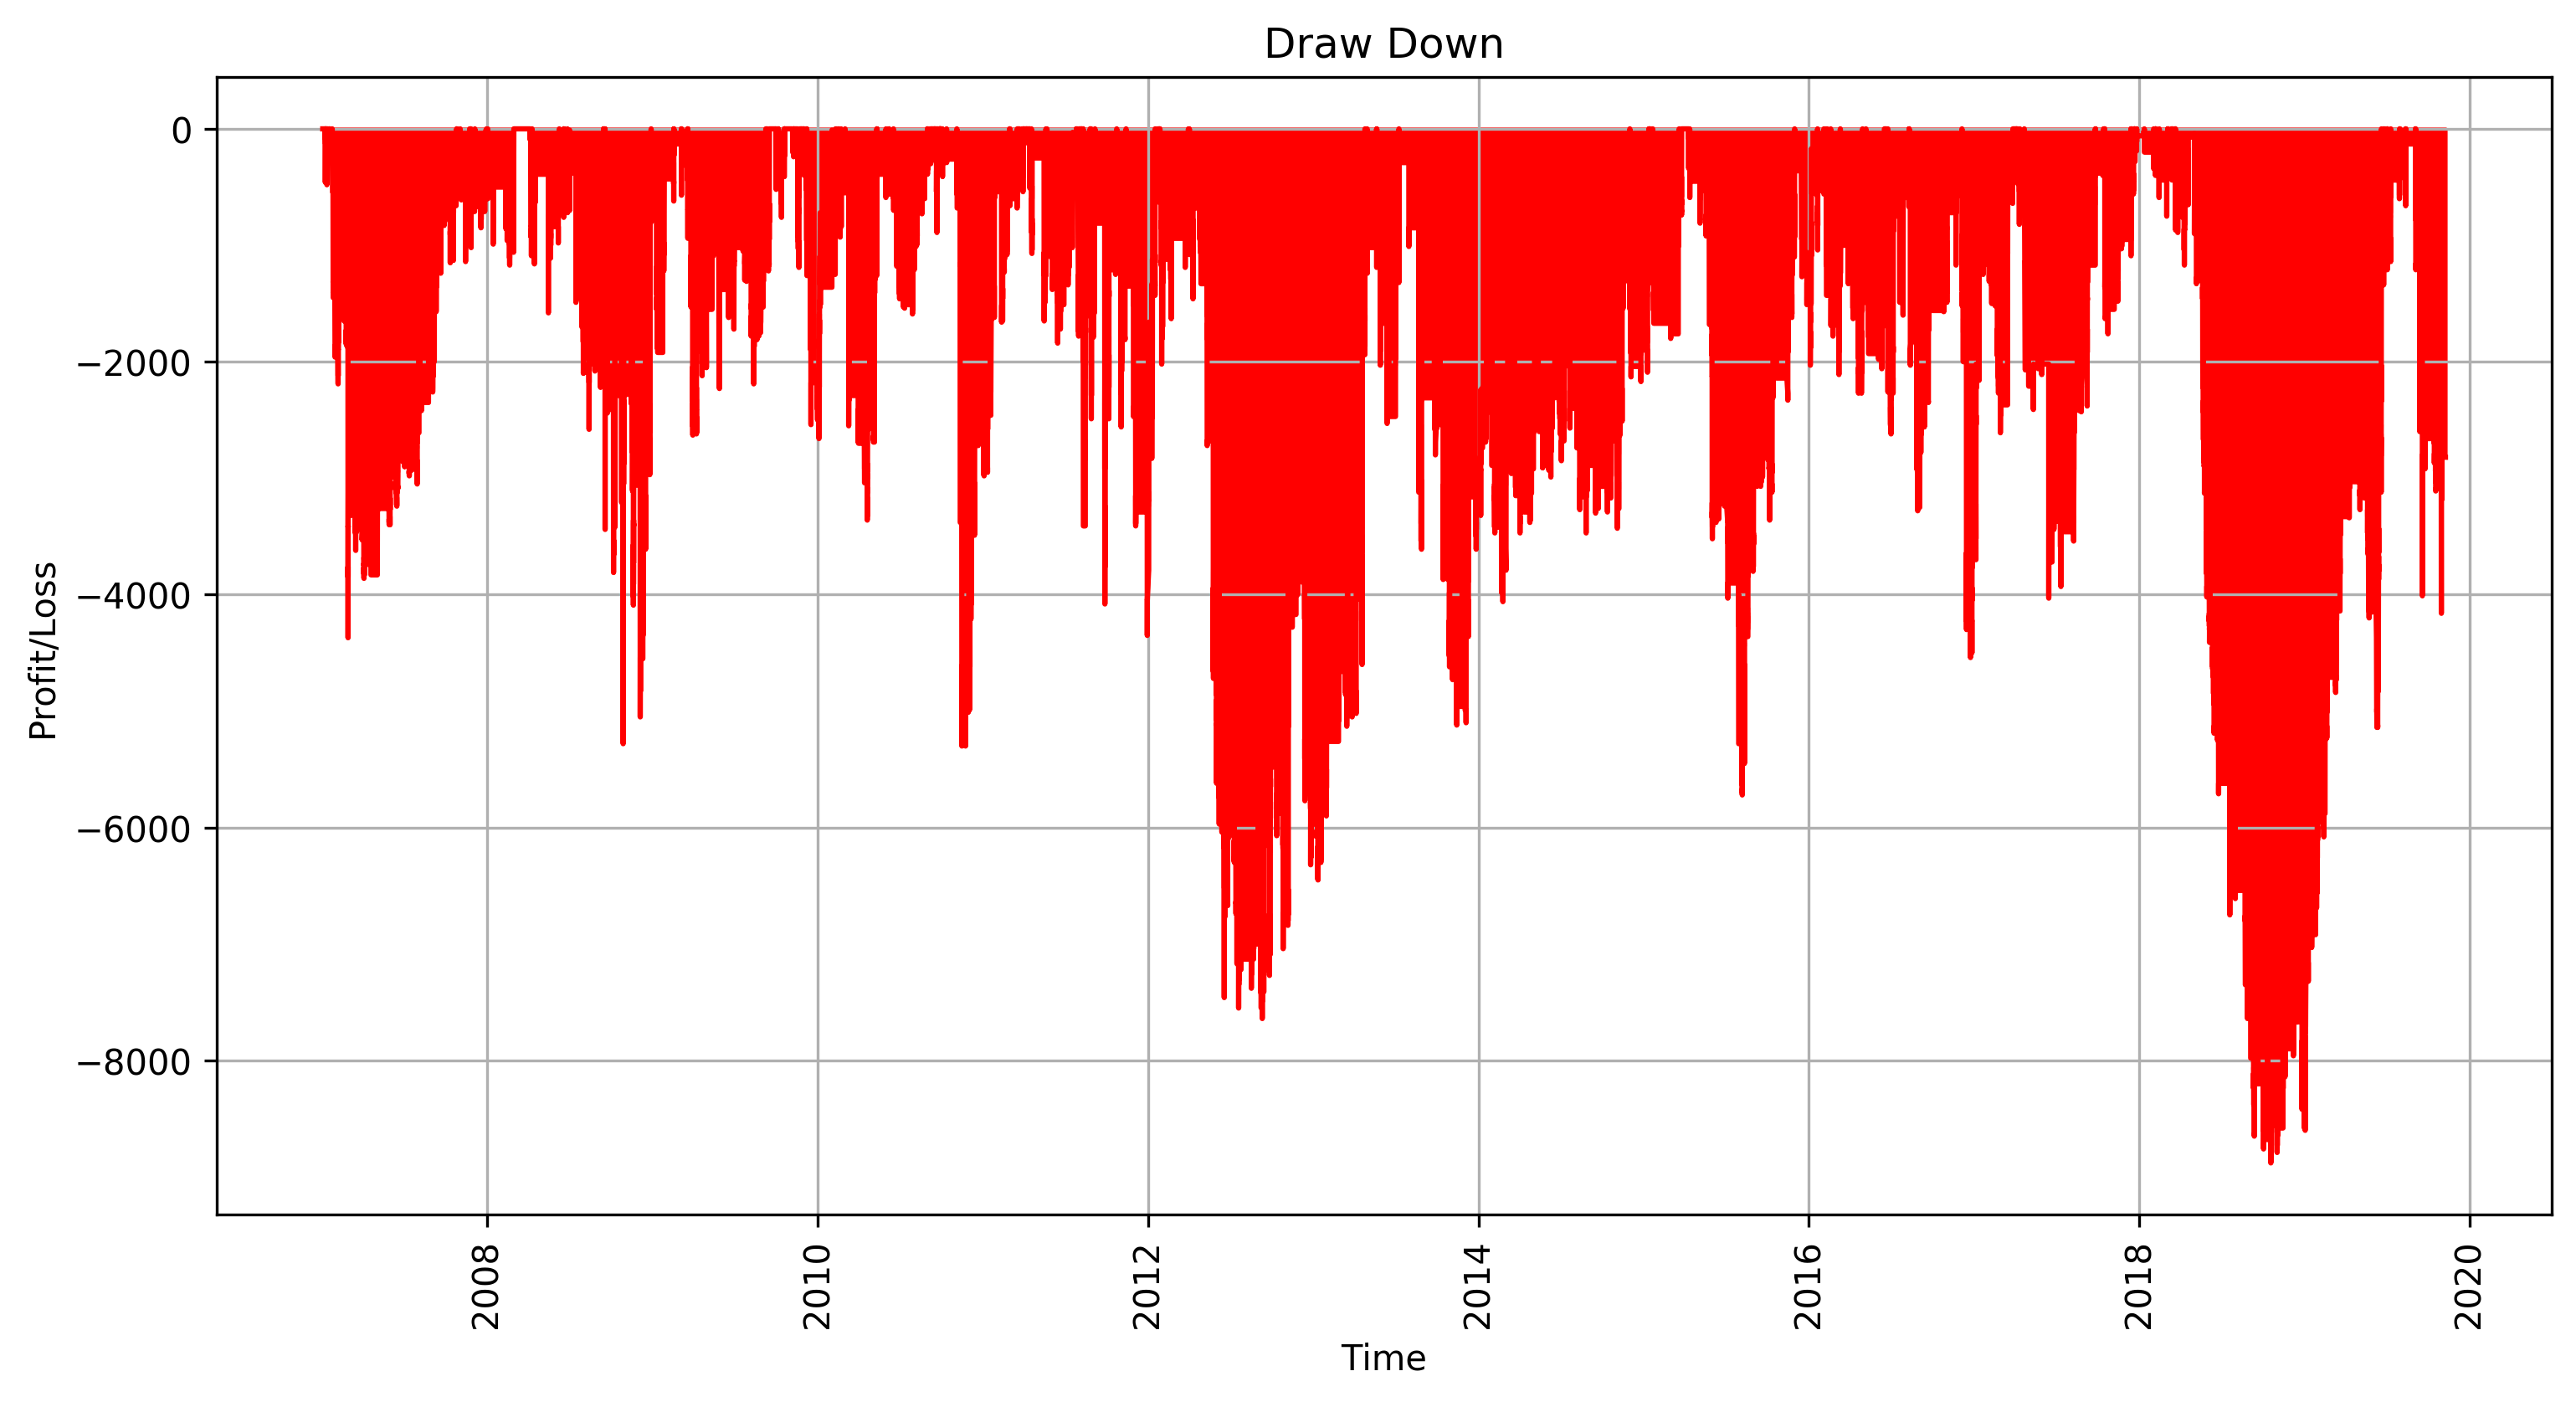

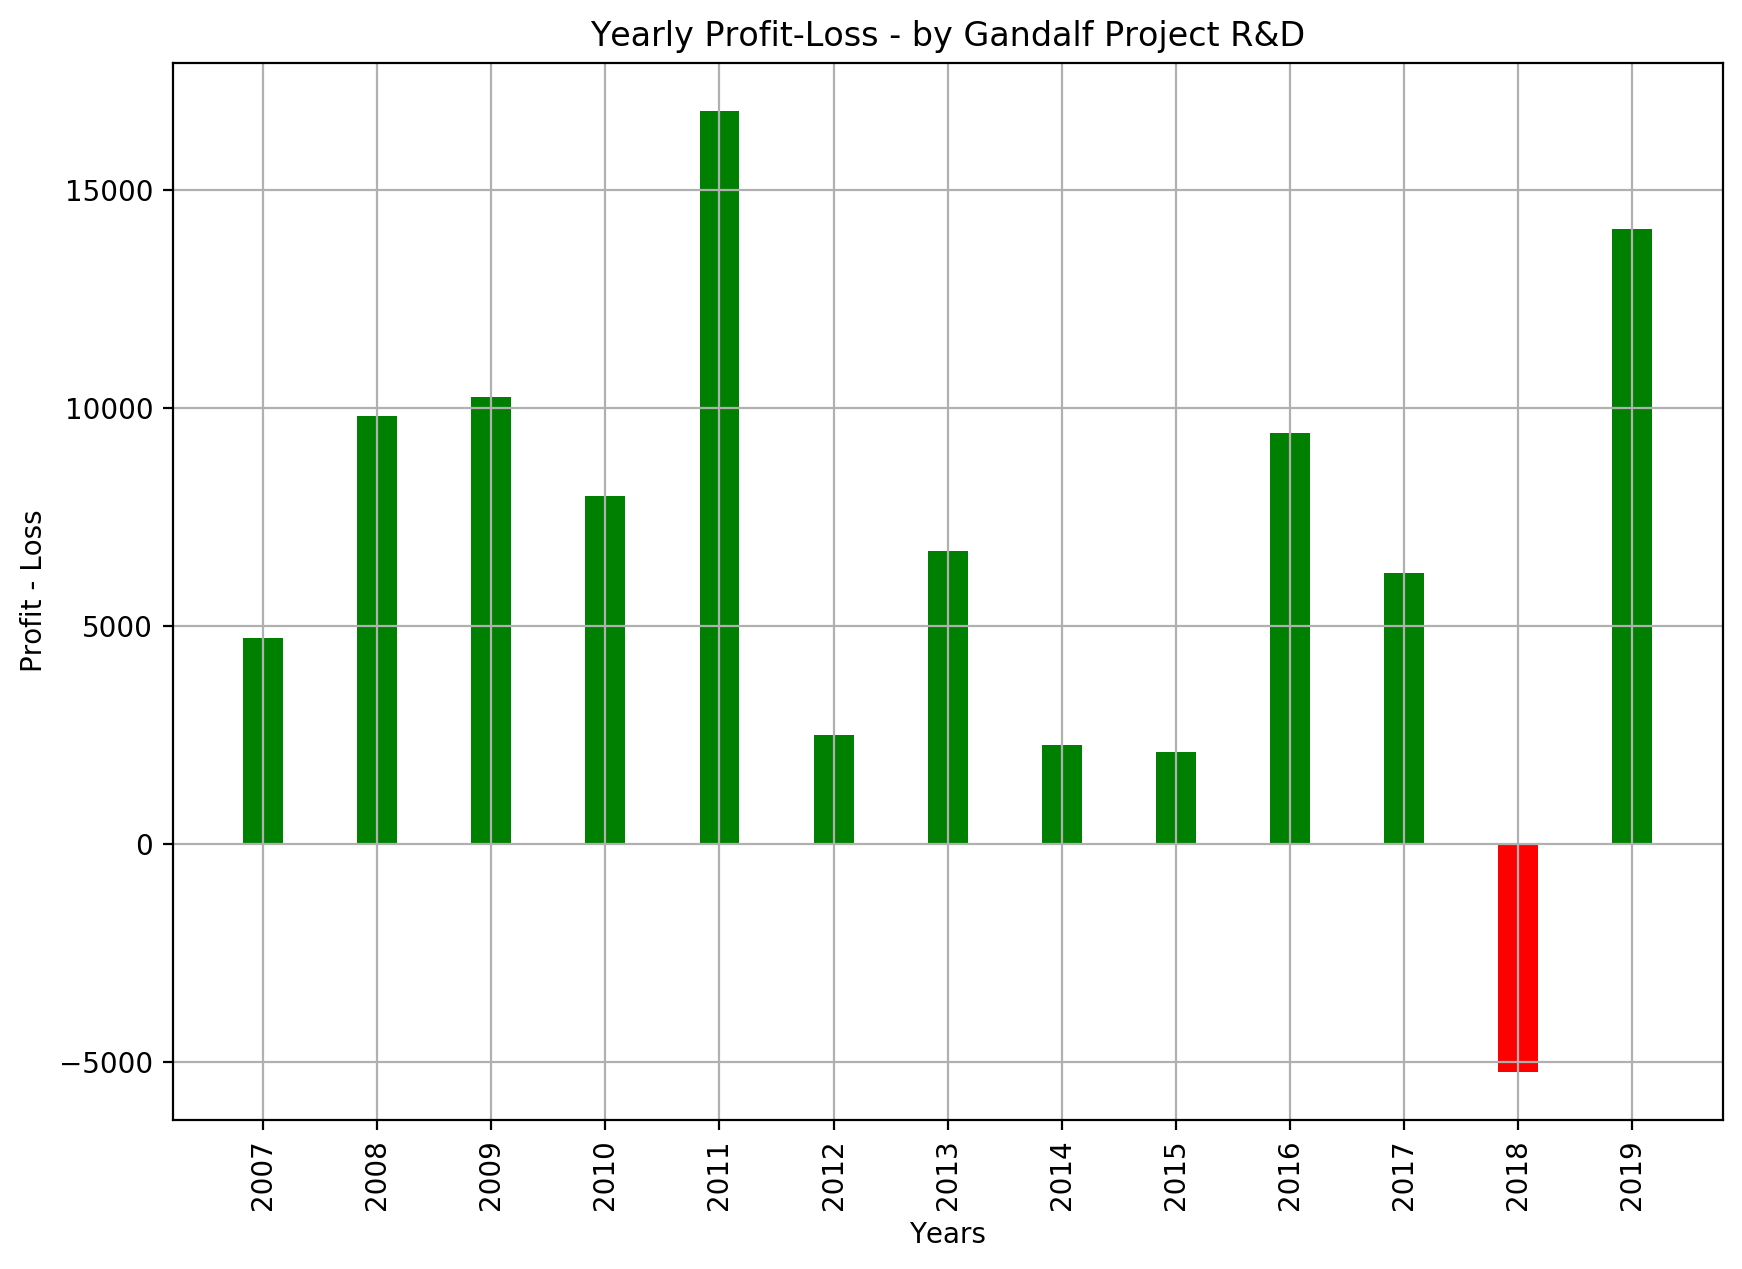

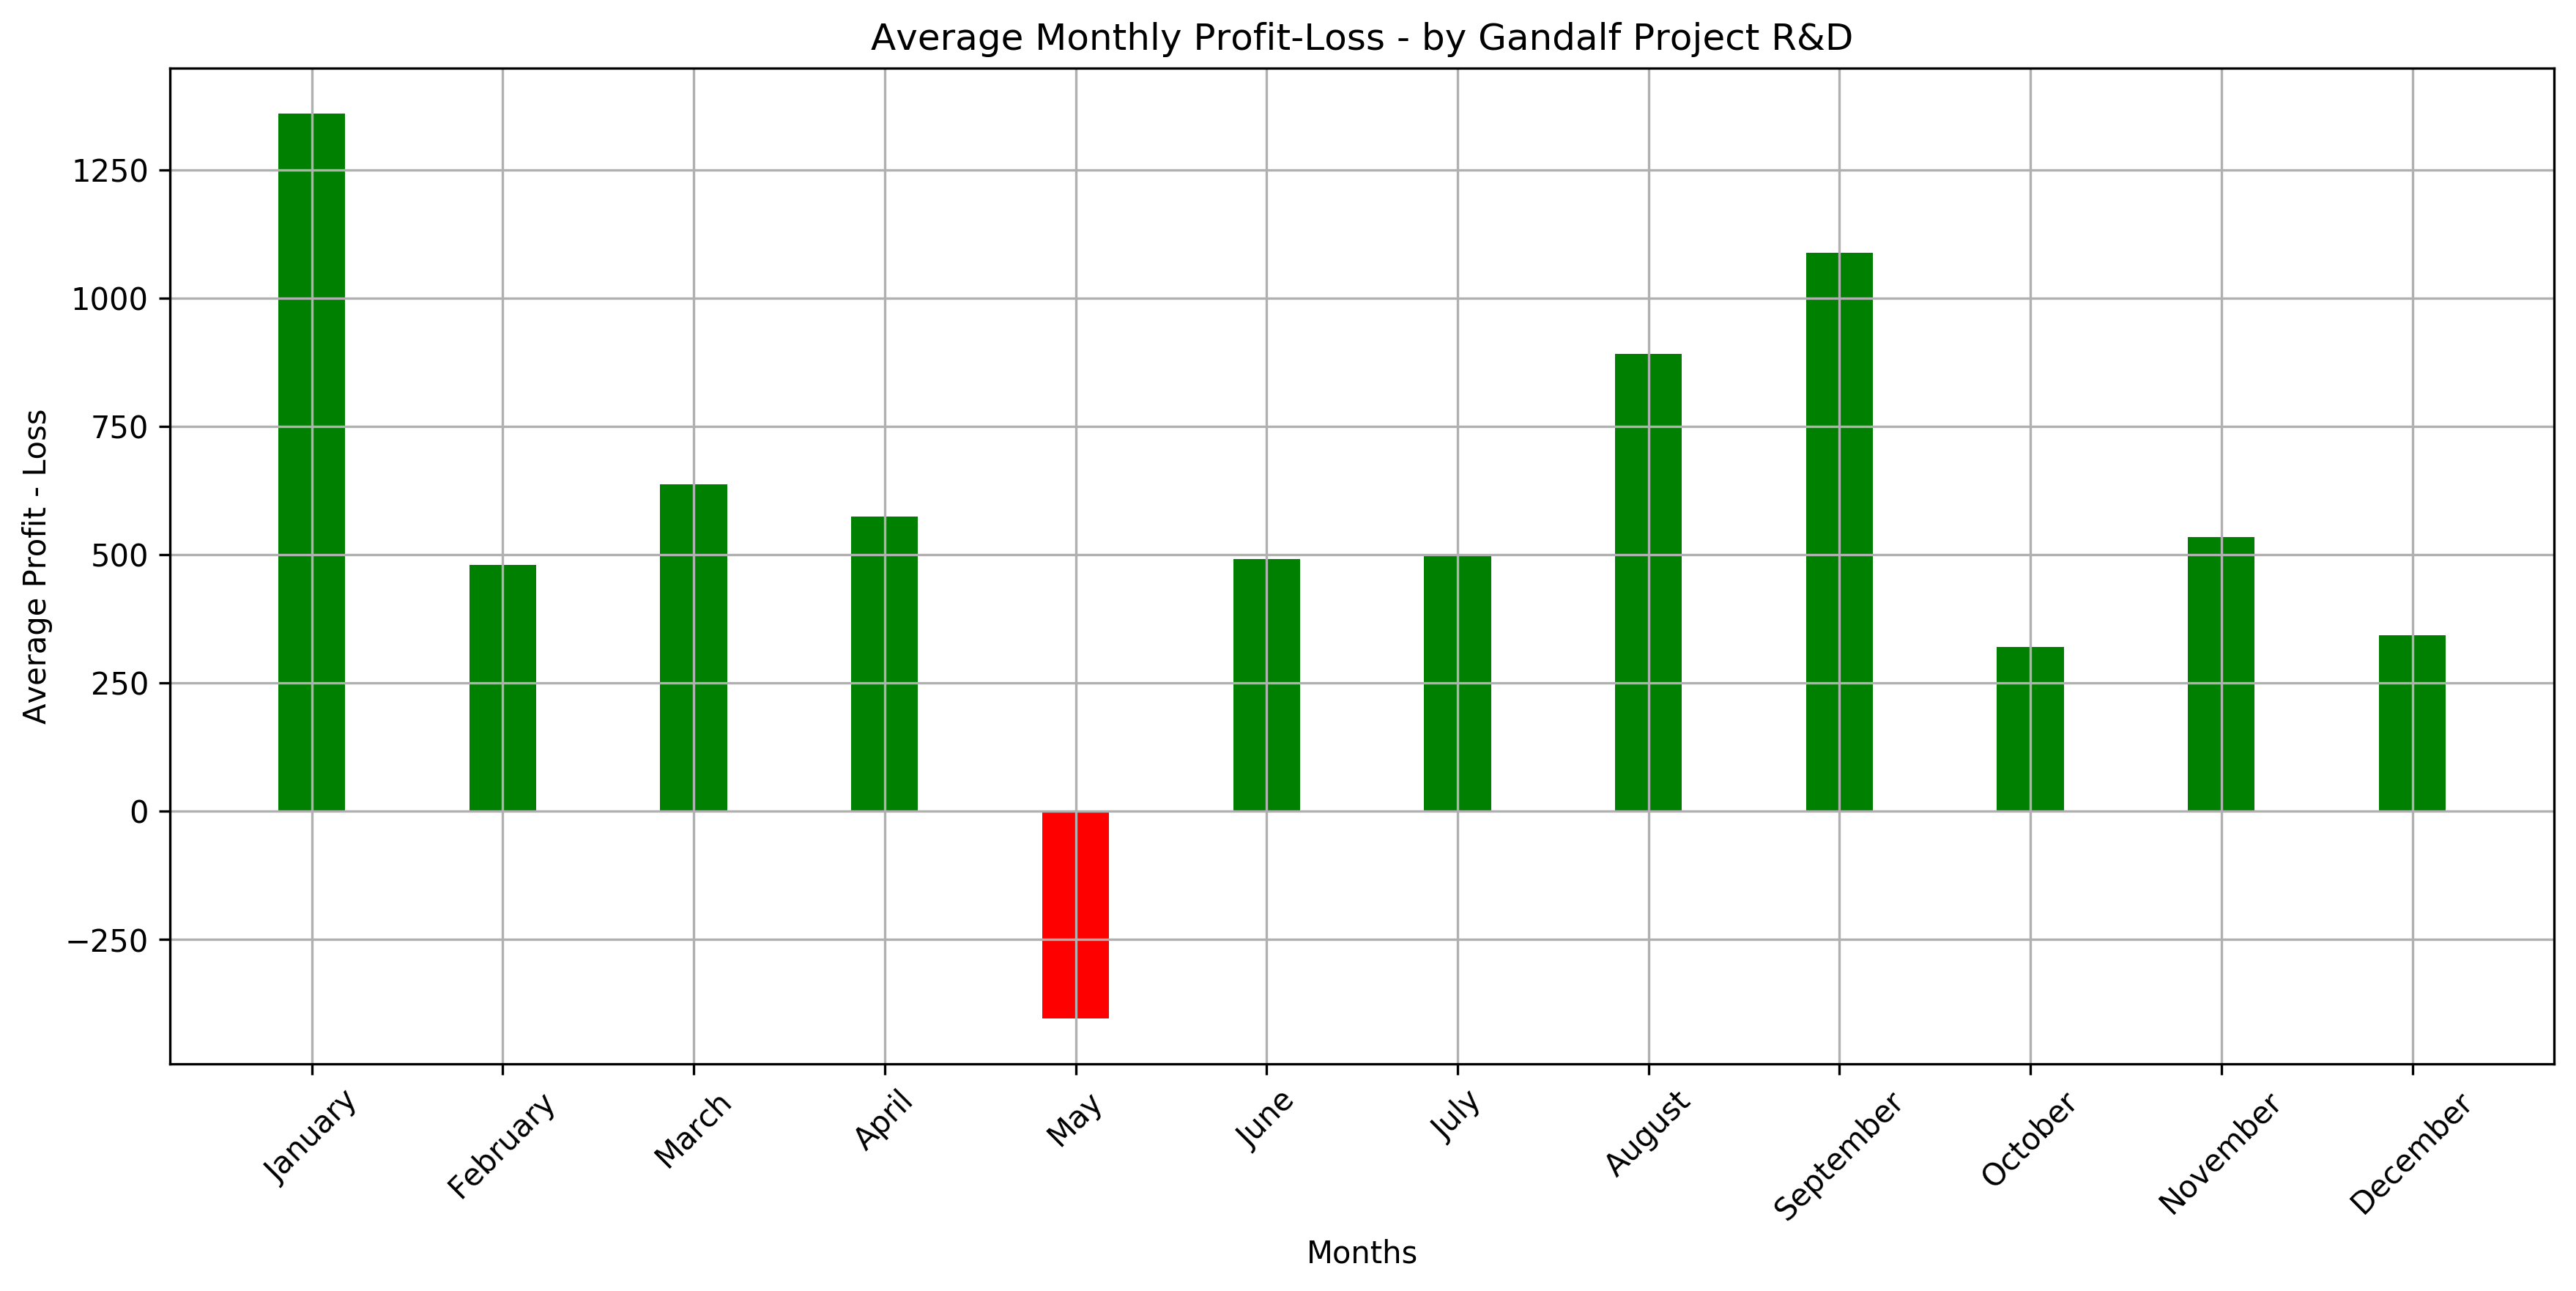

Elaboration ends at:  2019-11-27 18:41:15.503855
Elaboration time:  0:00:21.728994


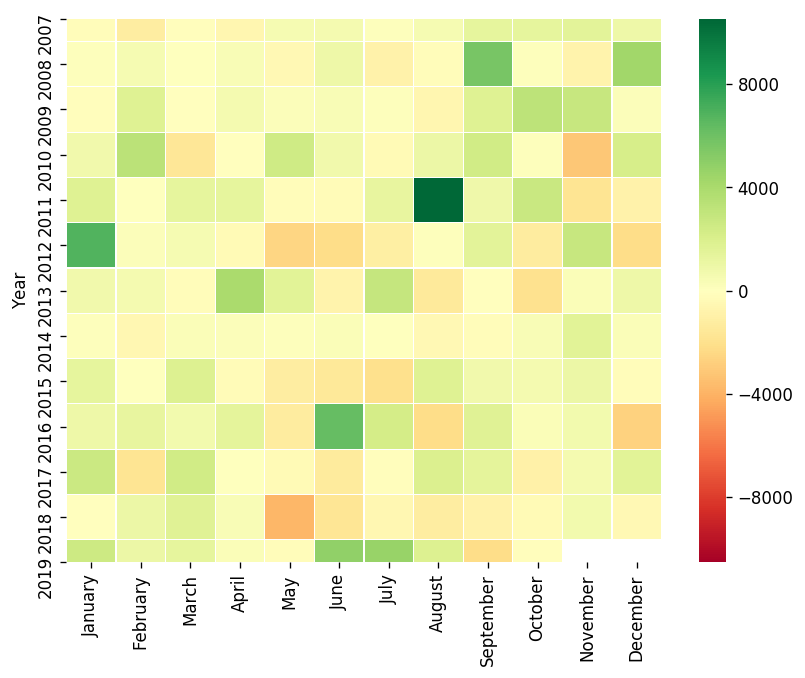

In [16]:
dataset = load_data_intraday("@GC_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.low.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.low.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.1
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"
enter_level = dataset.daily_high1.shift(1)

enter_rules = (blastoff) & (dataset.hour > 10) #blastoff
exit_rules = dataset.hour == 3

start = datetime.datetime.now()
print("Elaboration starts at: ", start)

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

end = datetime.datetime.now()
print("Elaboration ends at: ", end)
elaboration_time = end - start
print("Elaboration time: ", elaboration_time)

# Breakout 60 min LONG PL

Performance Report - by Gandalf Project R&D

Profit:                   83925.0
Operations:               1363
Average Trade:            61.57

Profit Factor:            1.59
Gross Profit:             226755.0
Gross Loss:               -142830.0

Percent Winning Trades:   54.0
Percent Losing Trades:    46.0
Reward Risk Ratio:        1.35

Max Gain:                 3245.0  in date  2008-09-18 02:00:00
Average Gain:             308.09
Max Loss:                 -2090.0  in date  2008-09-19 02:00:00
Average Loss:             -229.63

Avg Open Draw Down:       -1428.48
Max Open Draw Down:       -6610.0

Avg Closed Draw Down:     -1363.18
Max Closed Draw Down:     -5310.0

Avg Delay Between Peaks:  187.87
Max Delay Between Peaks:  8117


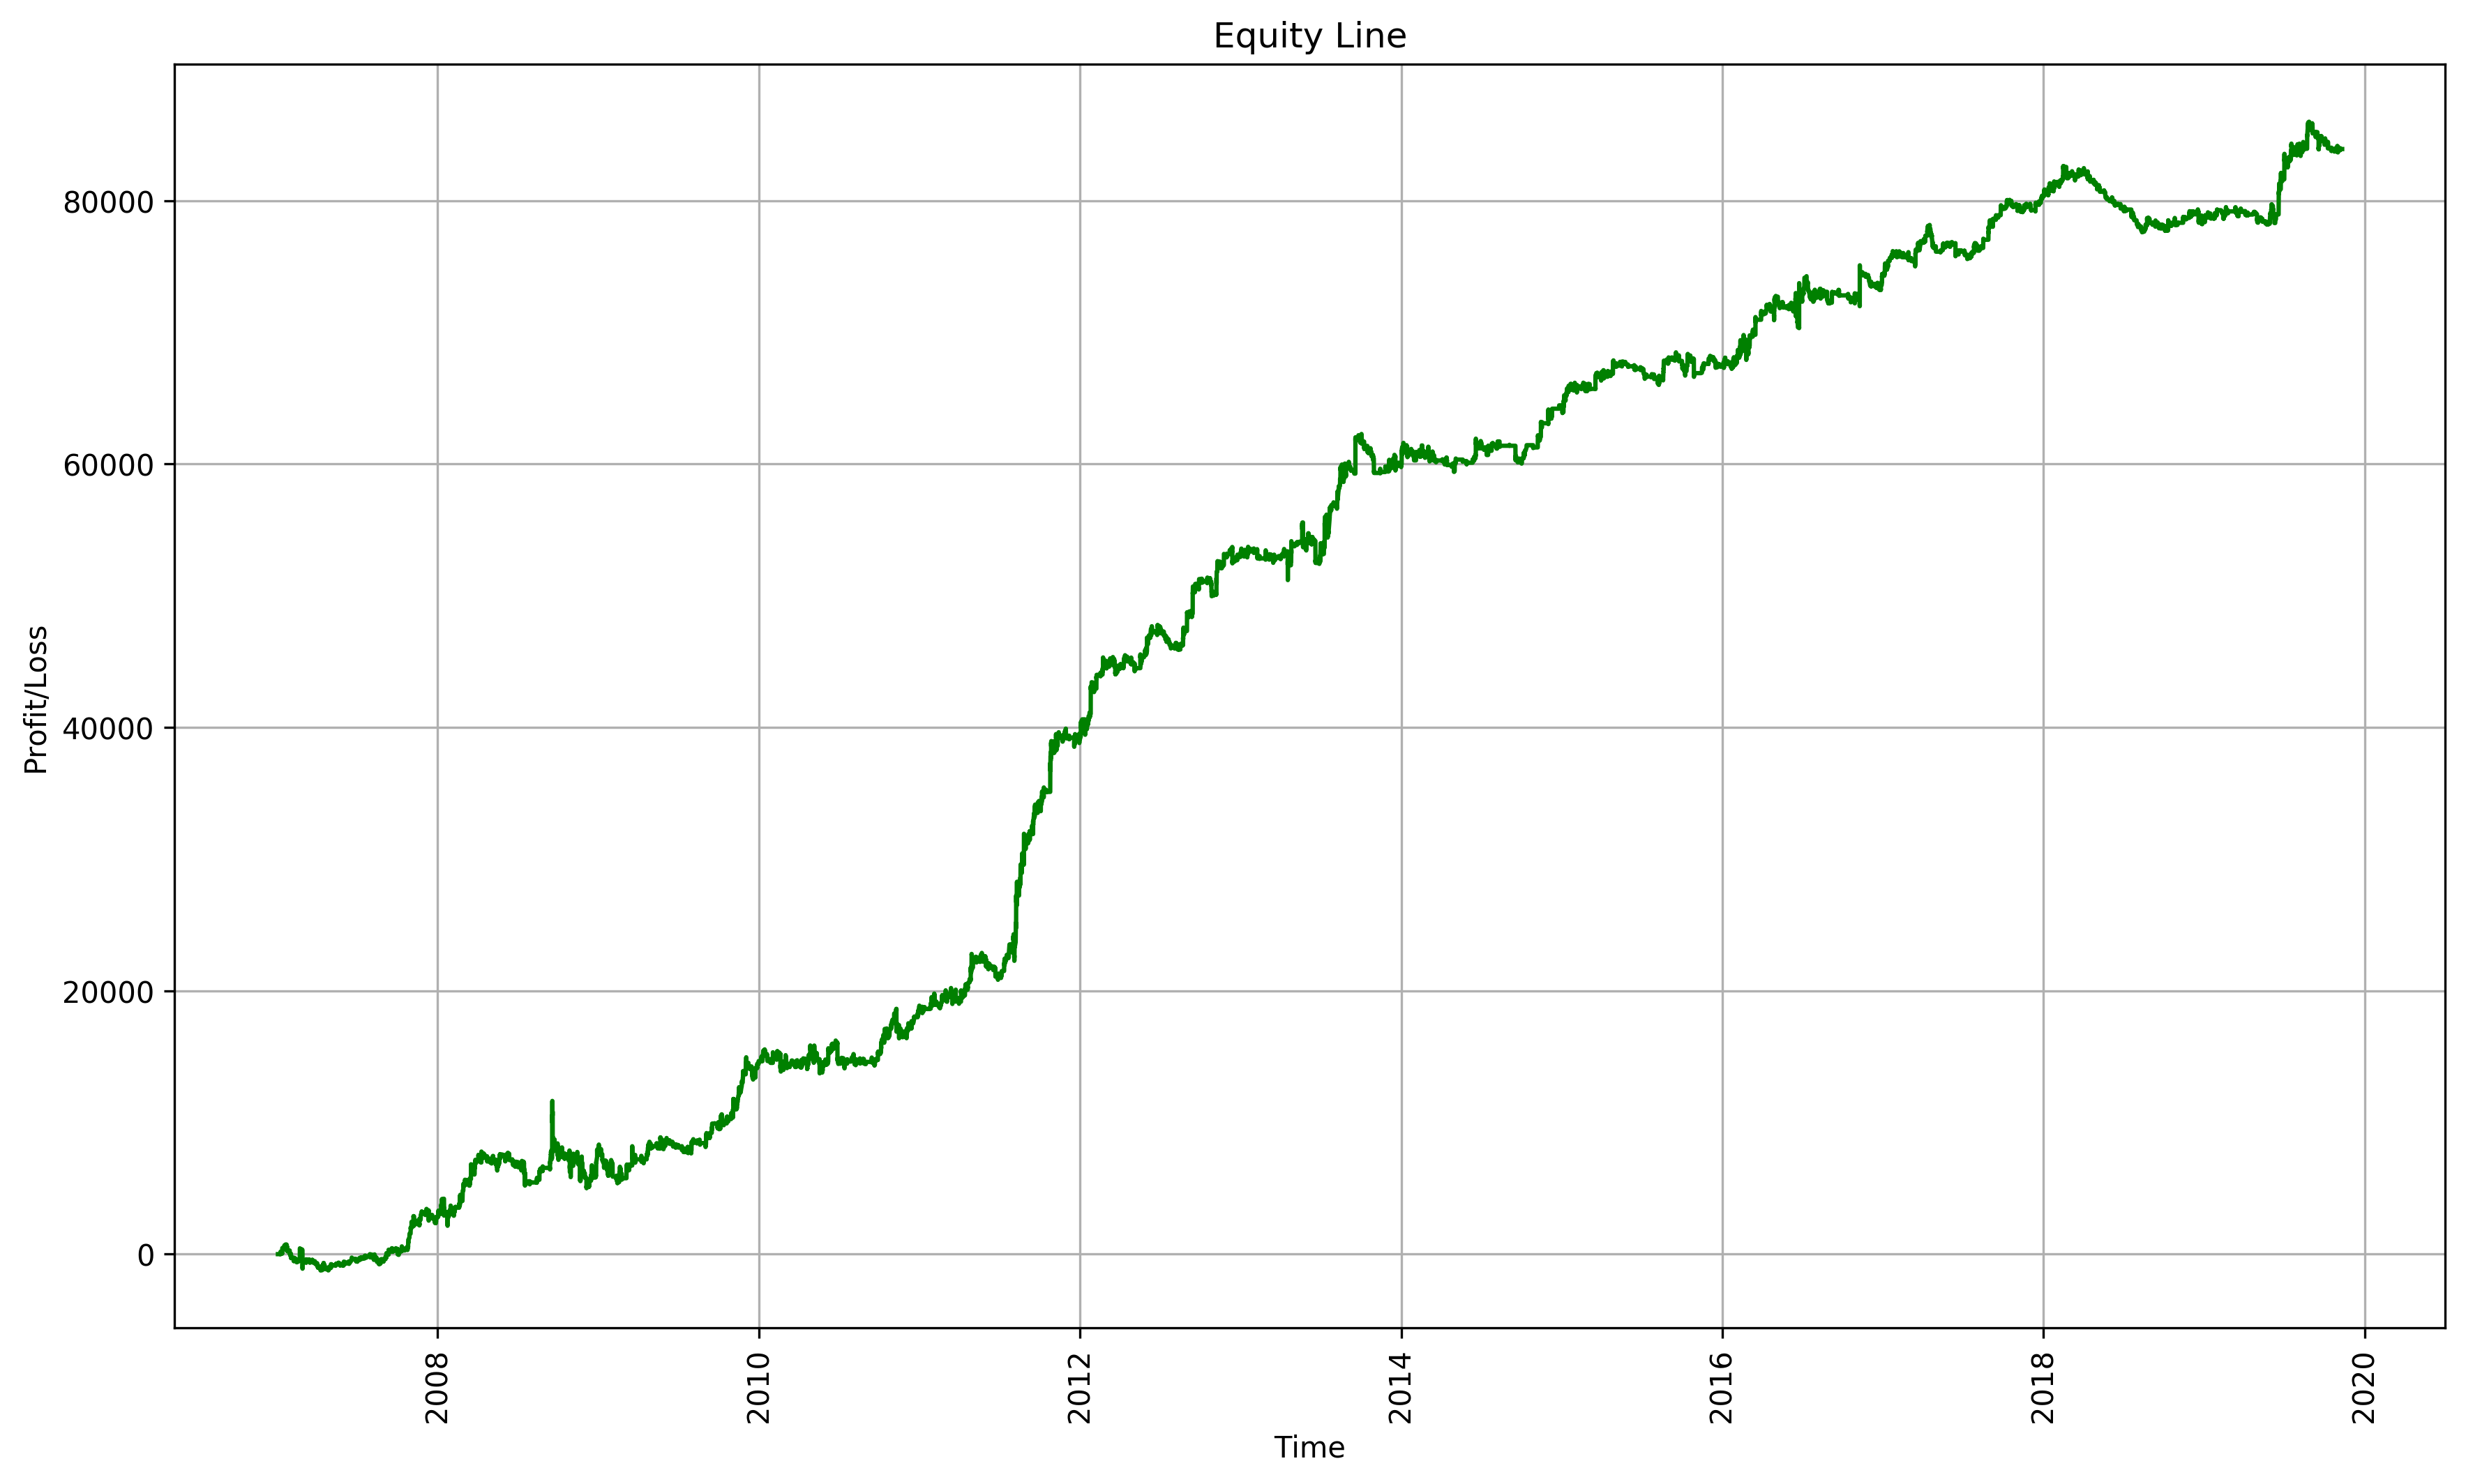

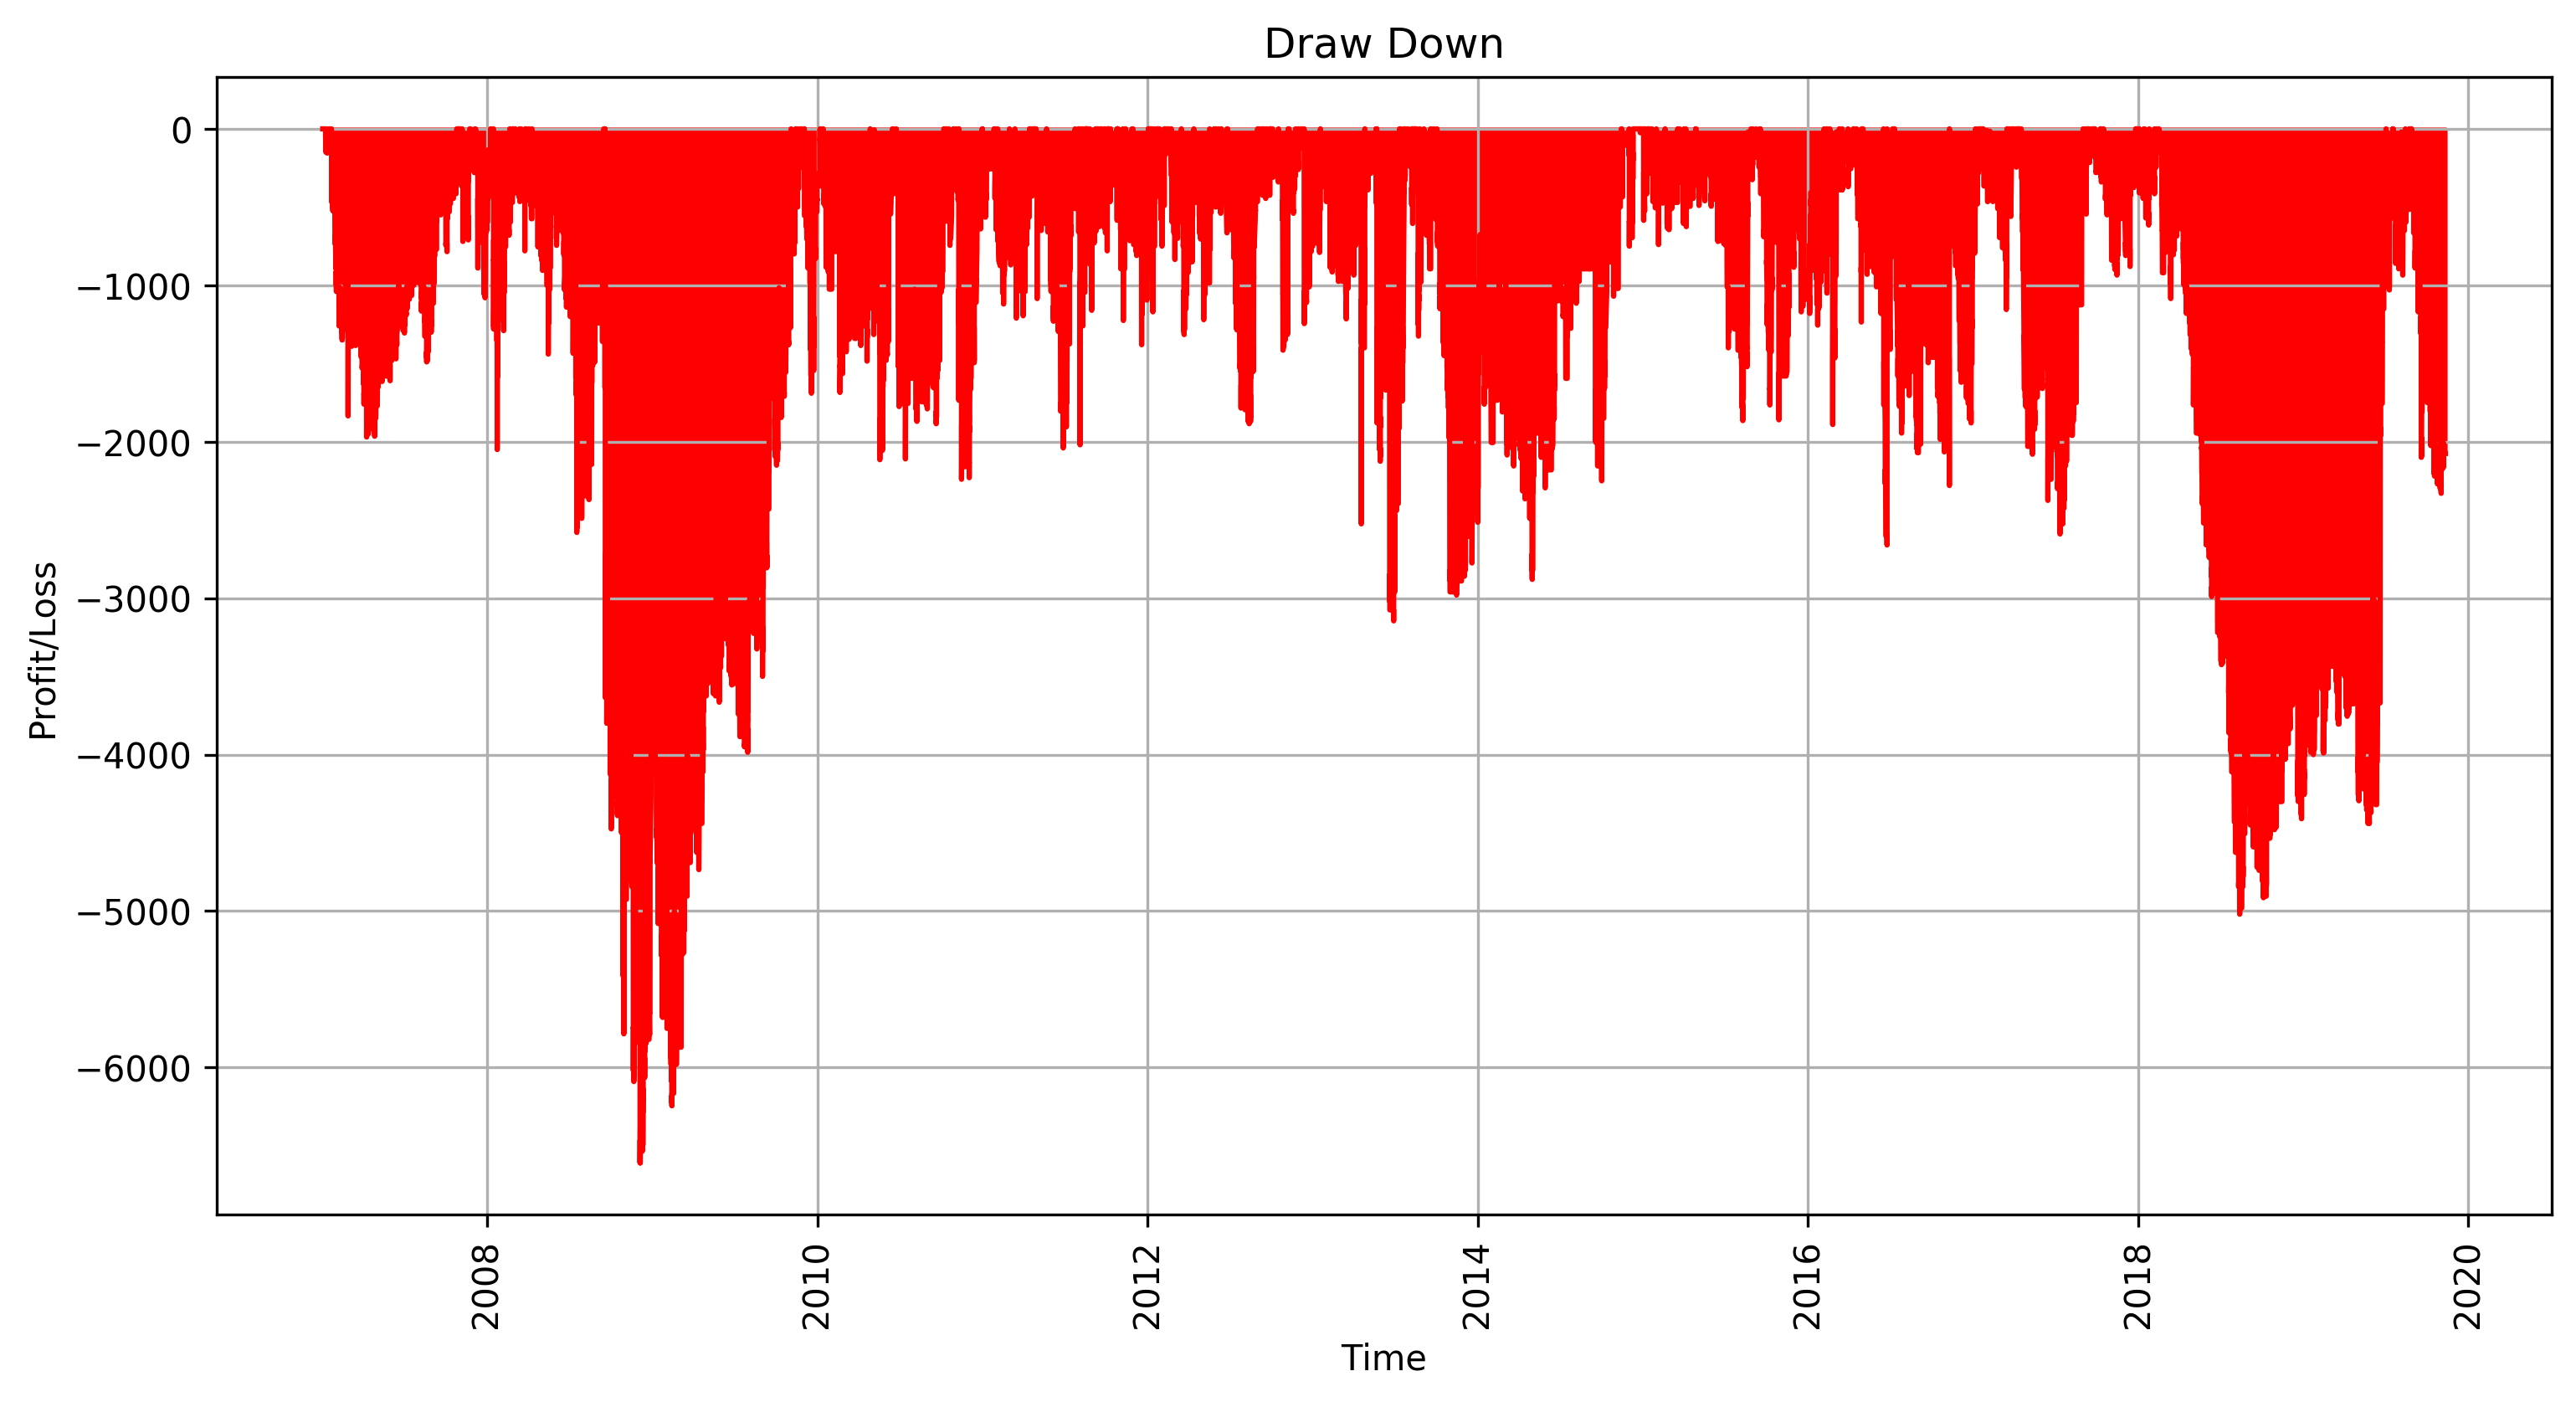

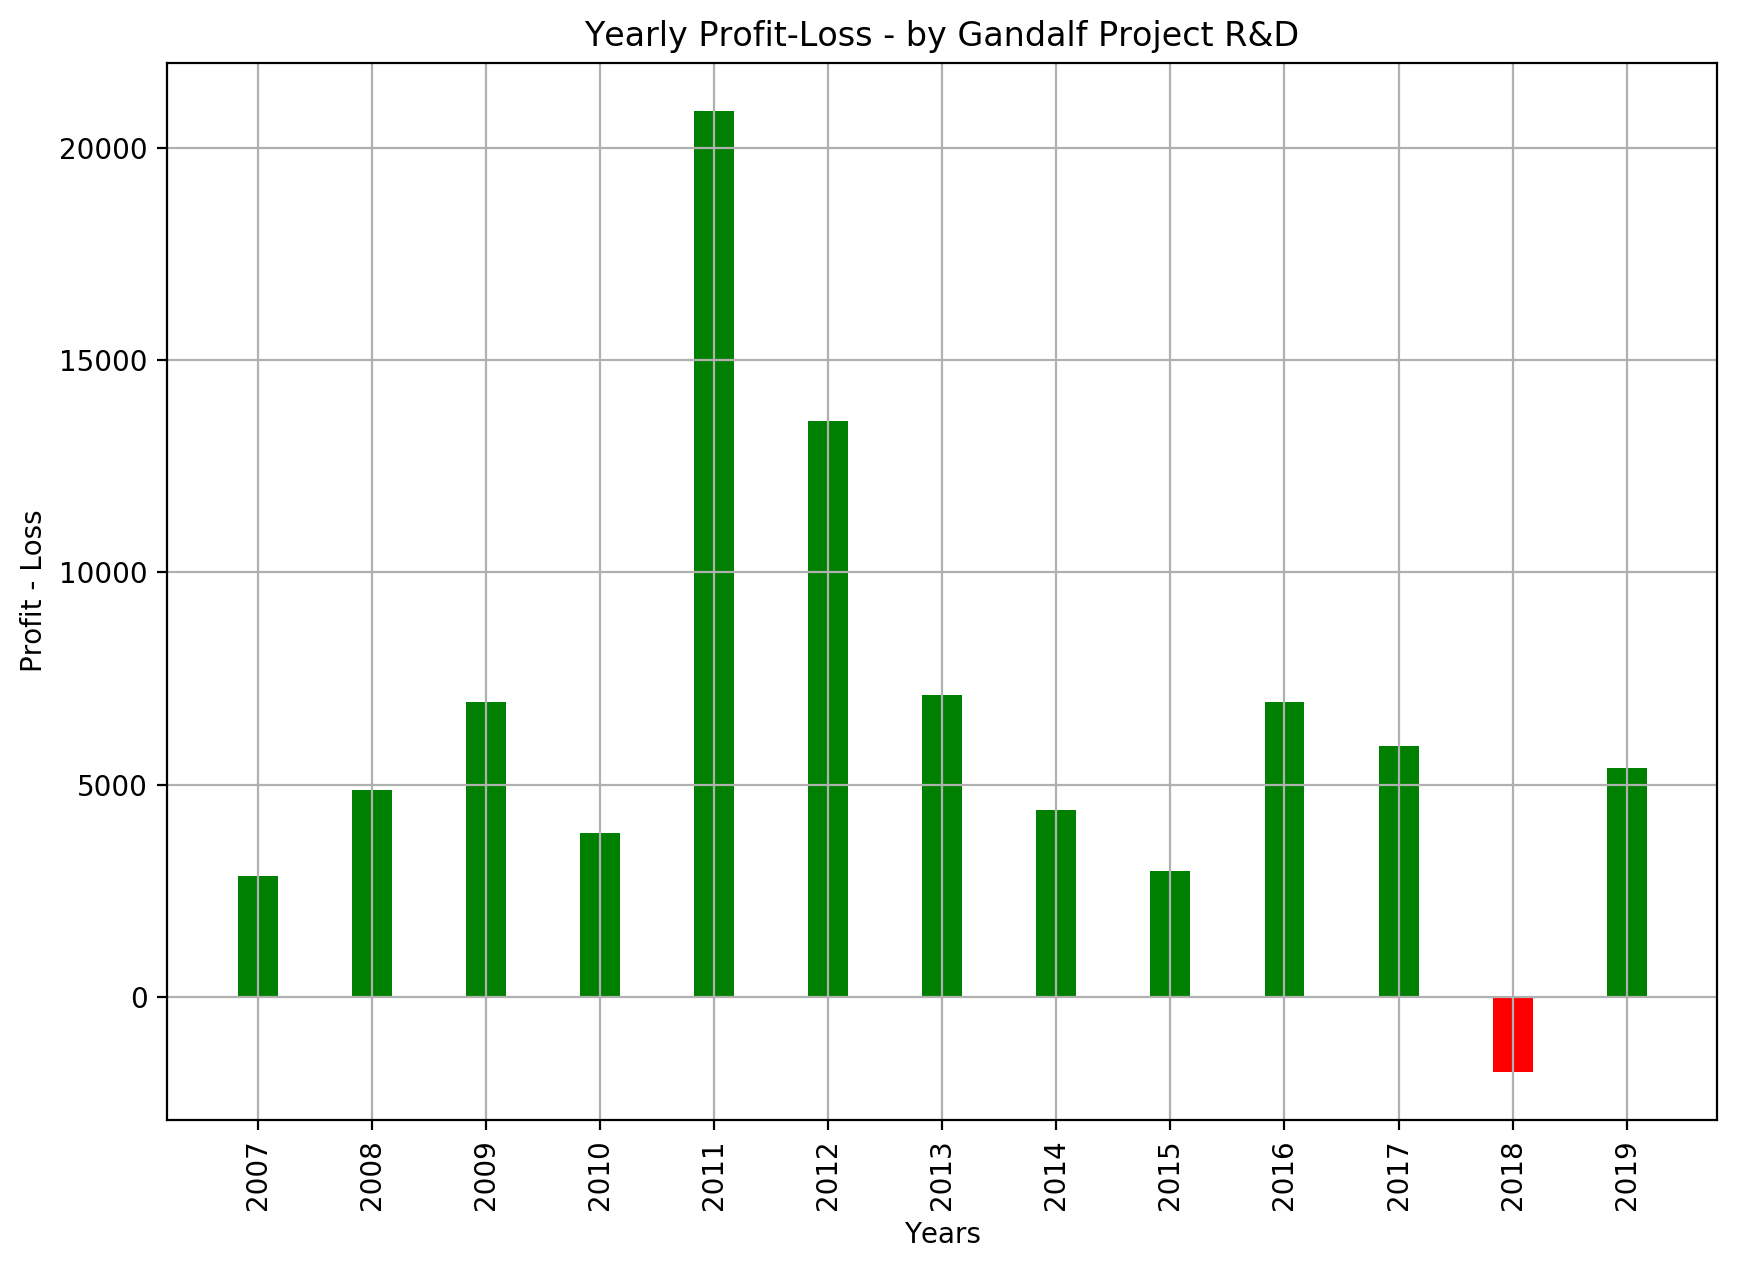

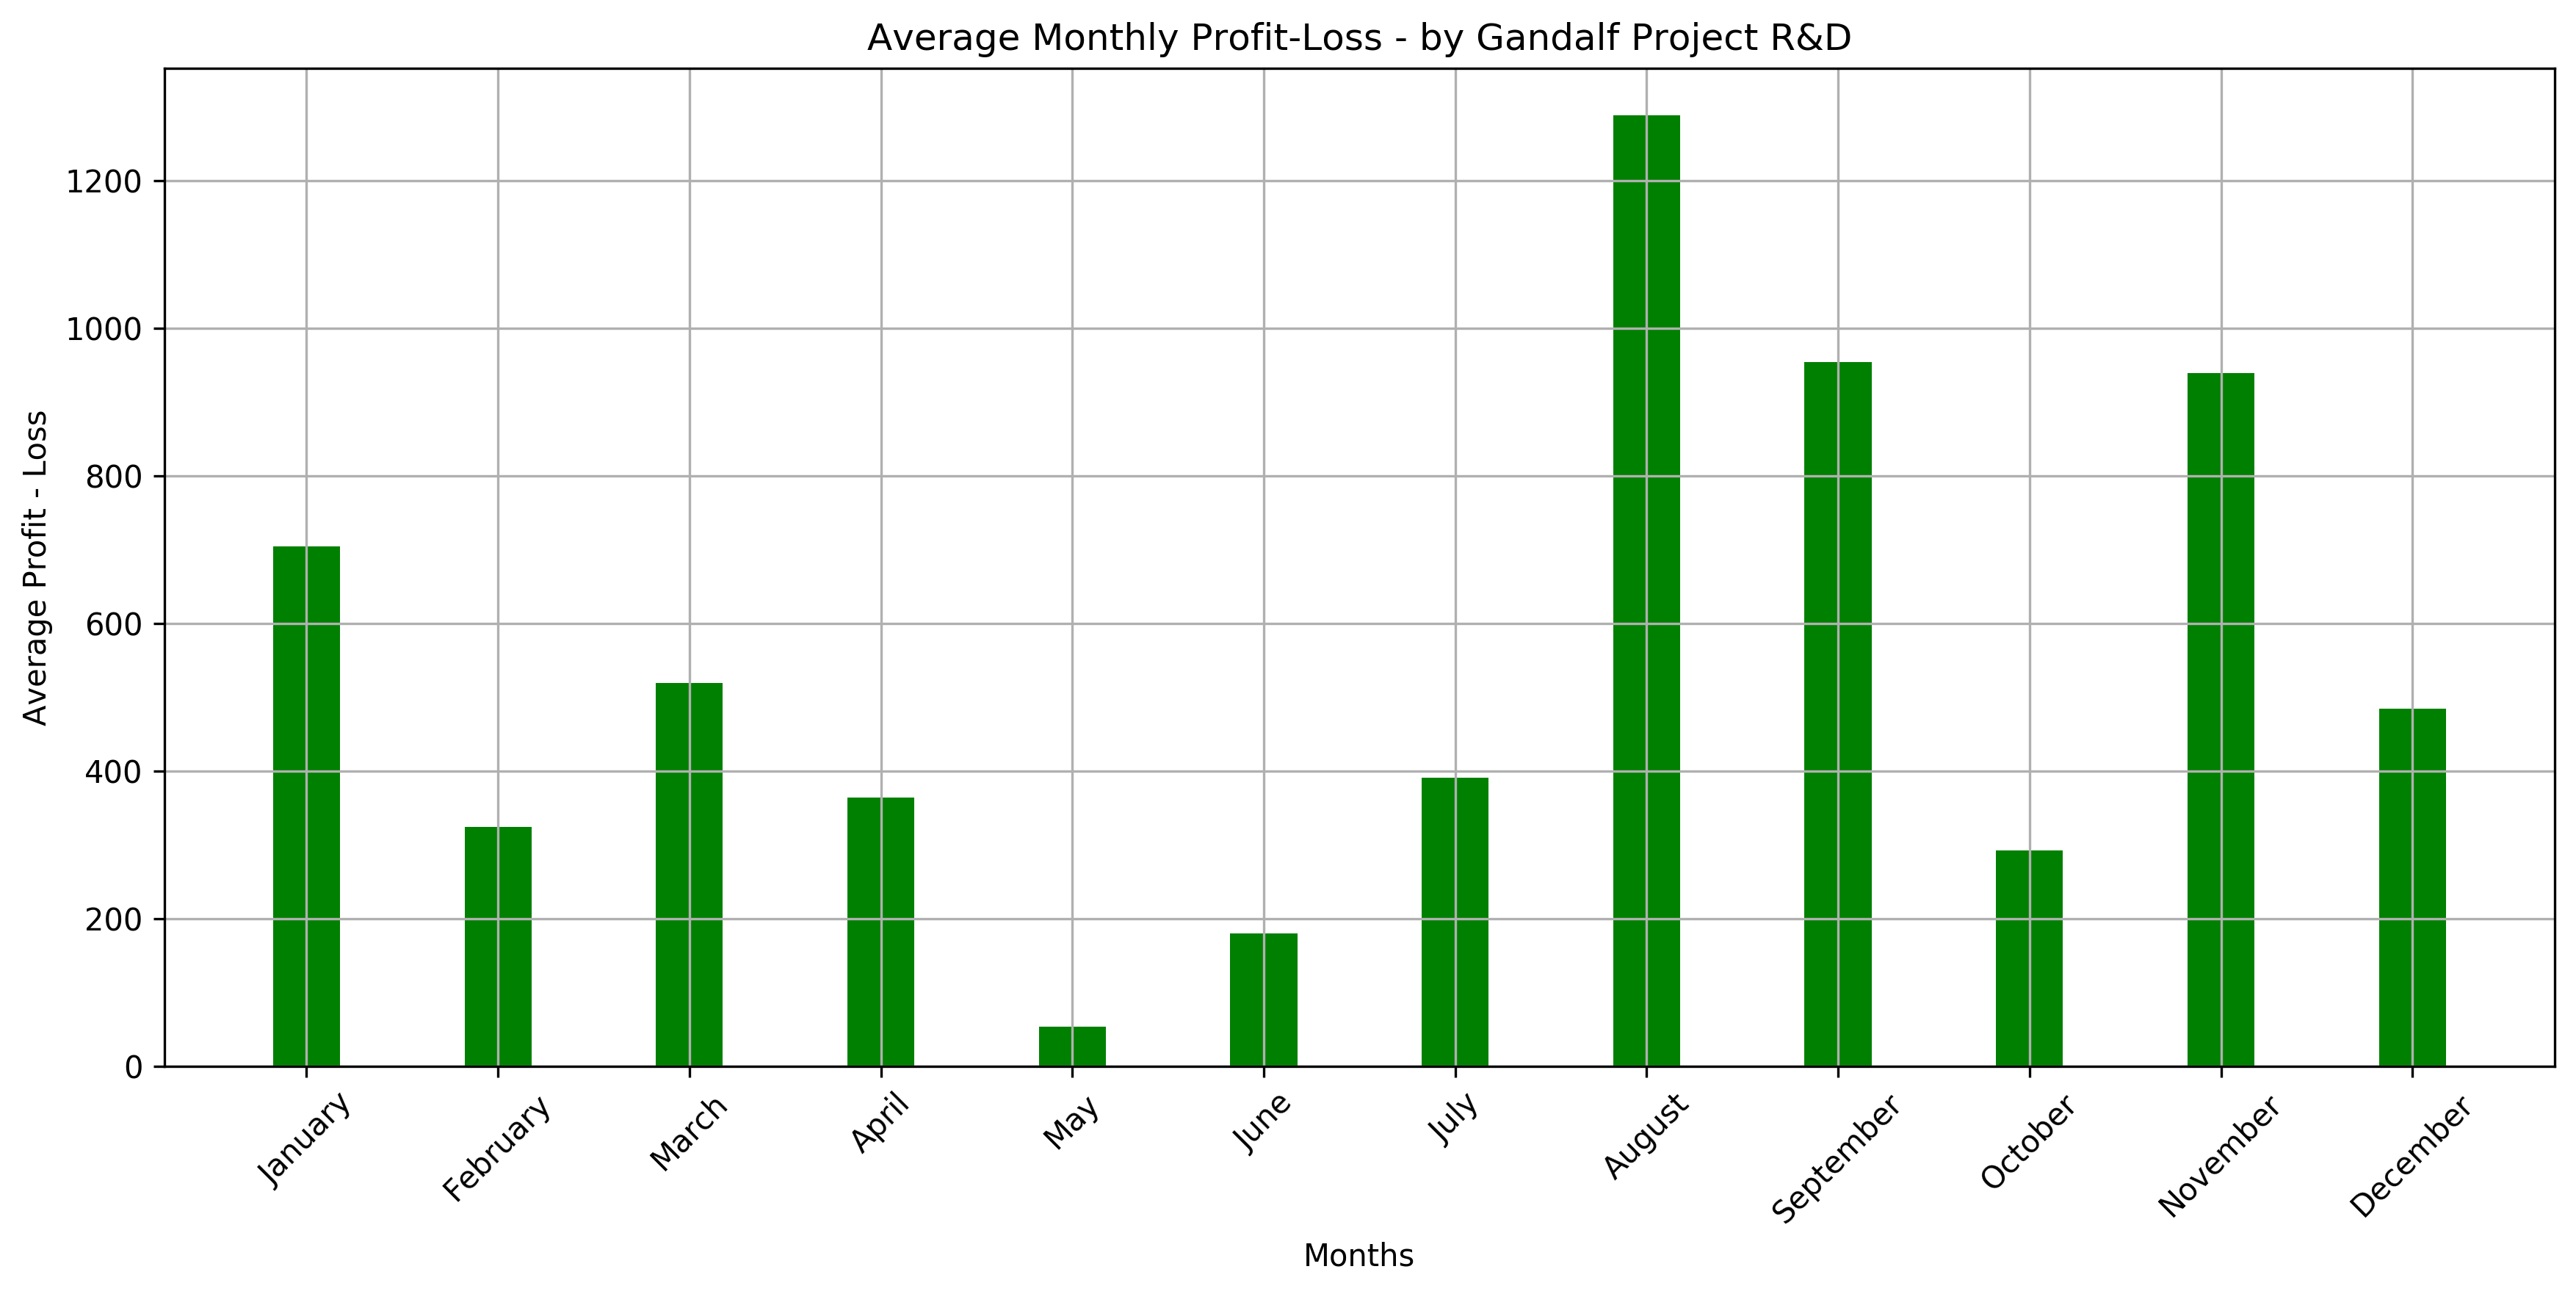

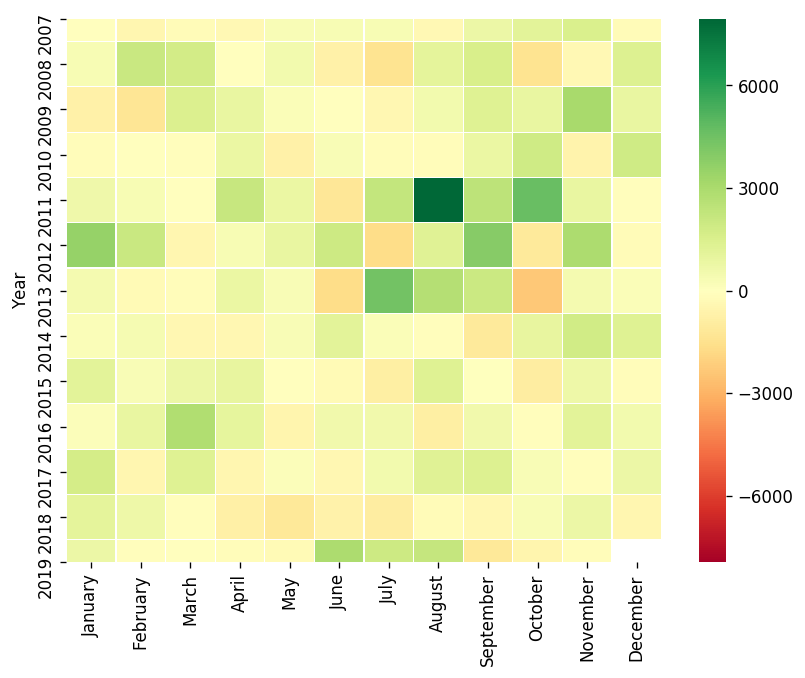

In [17]:
dataset = load_data_intraday("@PL_60min_Exchange.txt")

dataset["hhv23"] = dataset.high.rolling(23).max()
dataset["llv23"] = dataset.low.rolling(23).min()
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 50
TICK = 0.1
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"
enter_level = dataset.hhv23.shift(1)

enter_rules = dataset.hour > 9
exit_rules = dataset.hour == 2

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

# Breakout 60 min SHORT PL

Performance Report - by Gandalf Project R&D

Profit:                   47380.0
Operations:               1262
Average Trade:            37.54

Profit Factor:            1.29
Gross Profit:             210010.0
Gross Loss:               -162630.0

Percent Winning Trades:   50.16
Percent Losing Trades:    49.84
Reward Risk Ratio:        1.28

Max Gain:                 2405.0  in date  2011-09-22 10:00:00
Average Gain:             331.77
Max Loss:                 -2535.0  in date  2012-06-01 10:00:00
Average Loss:             -260.62

Avg Open Draw Down:       -1375.37
Max Open Draw Down:       -5515.0

Avg Closed Draw Down:     -1239.29
Max Closed Draw Down:     -5140.0

Avg Delay Between Peaks:  396.55
Max Delay Between Peaks:  12980


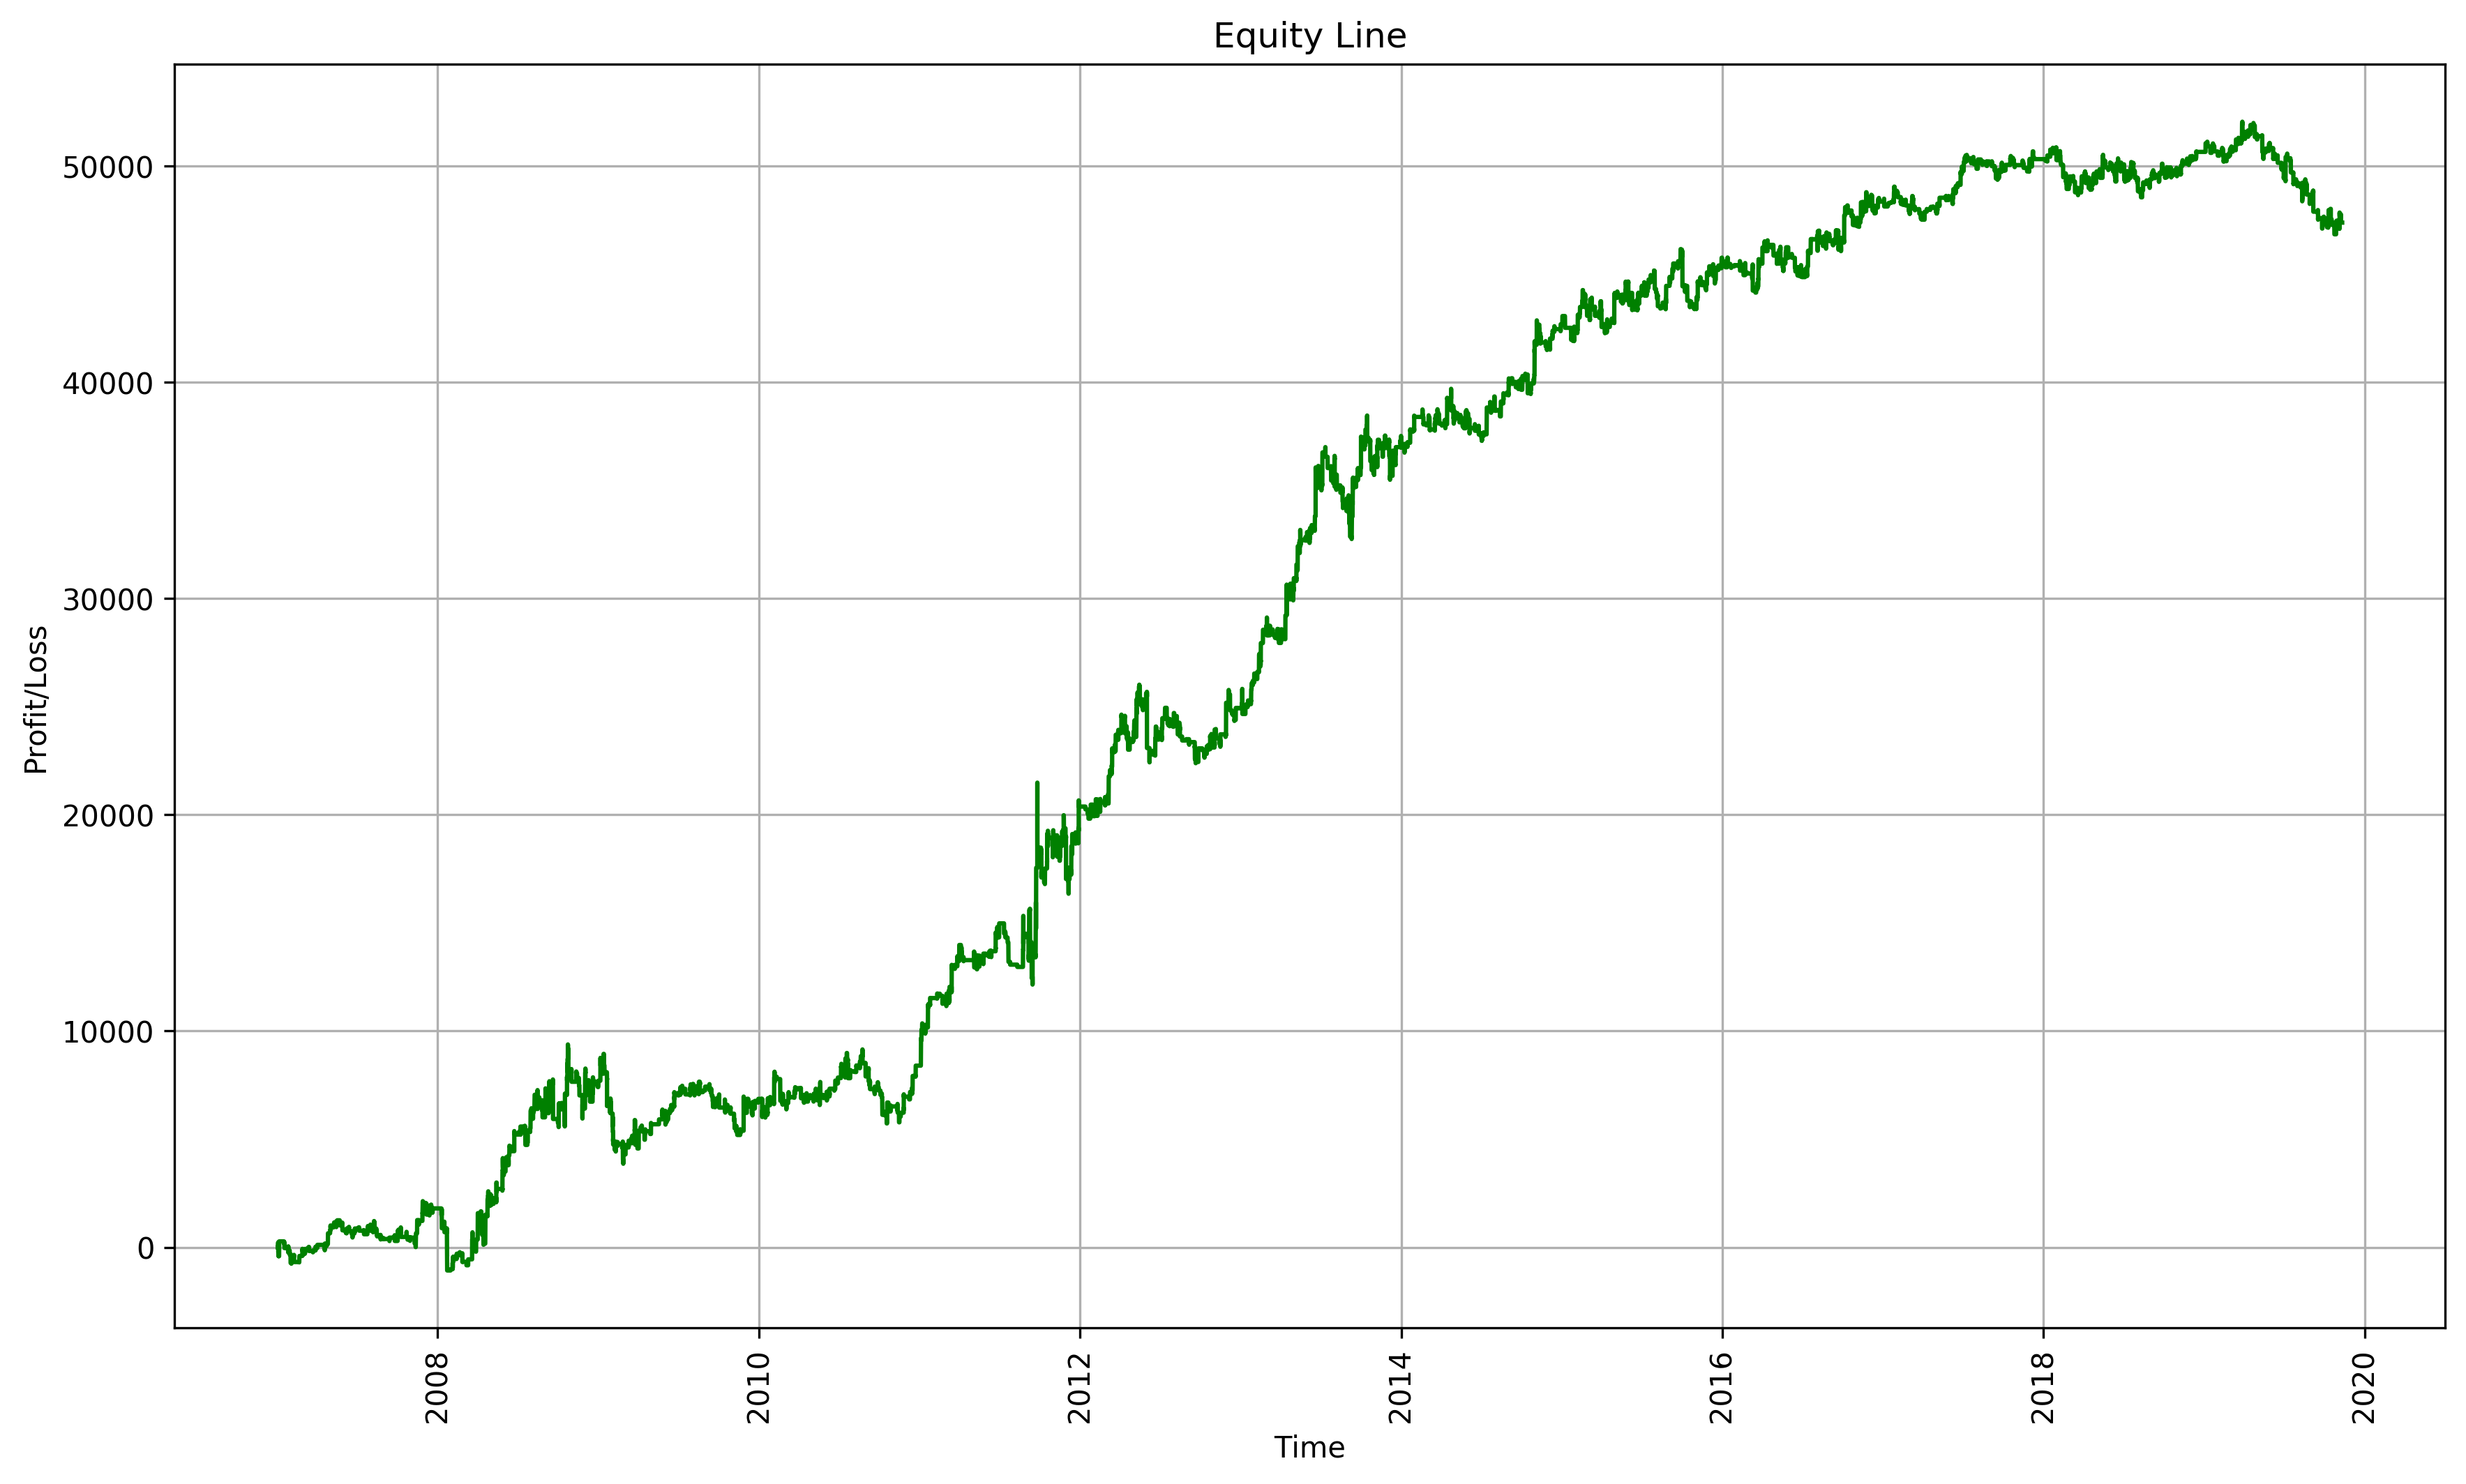

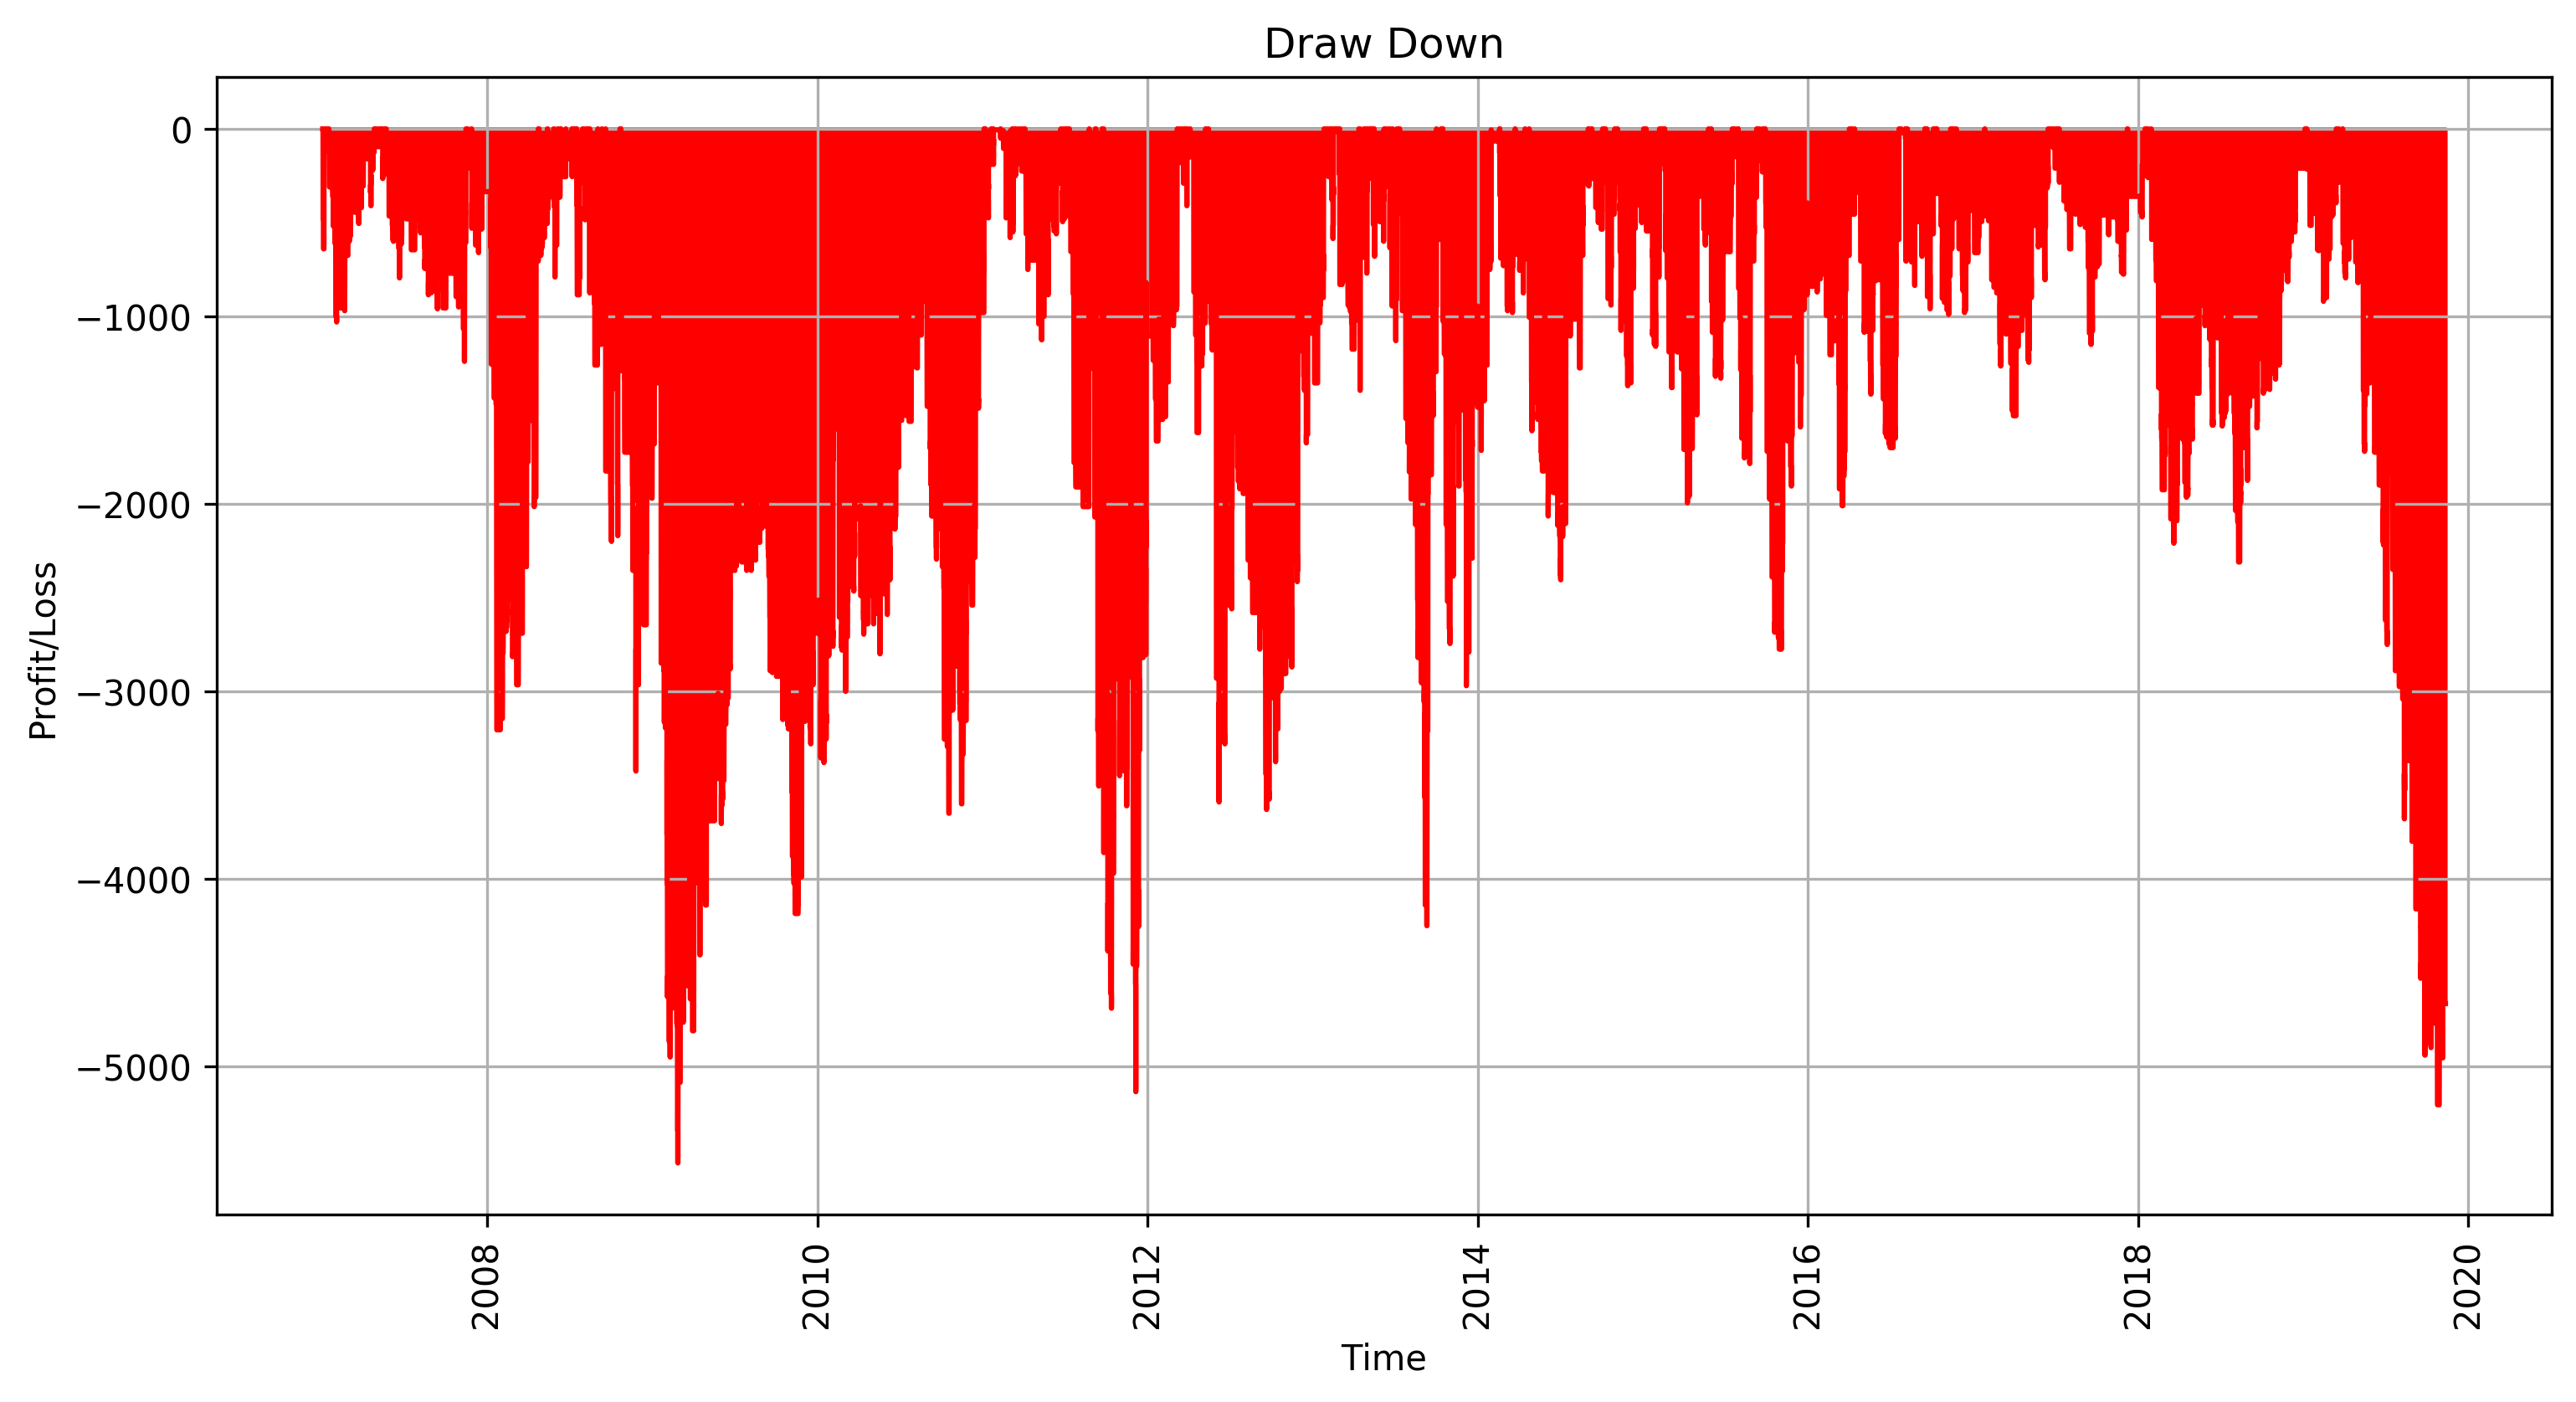

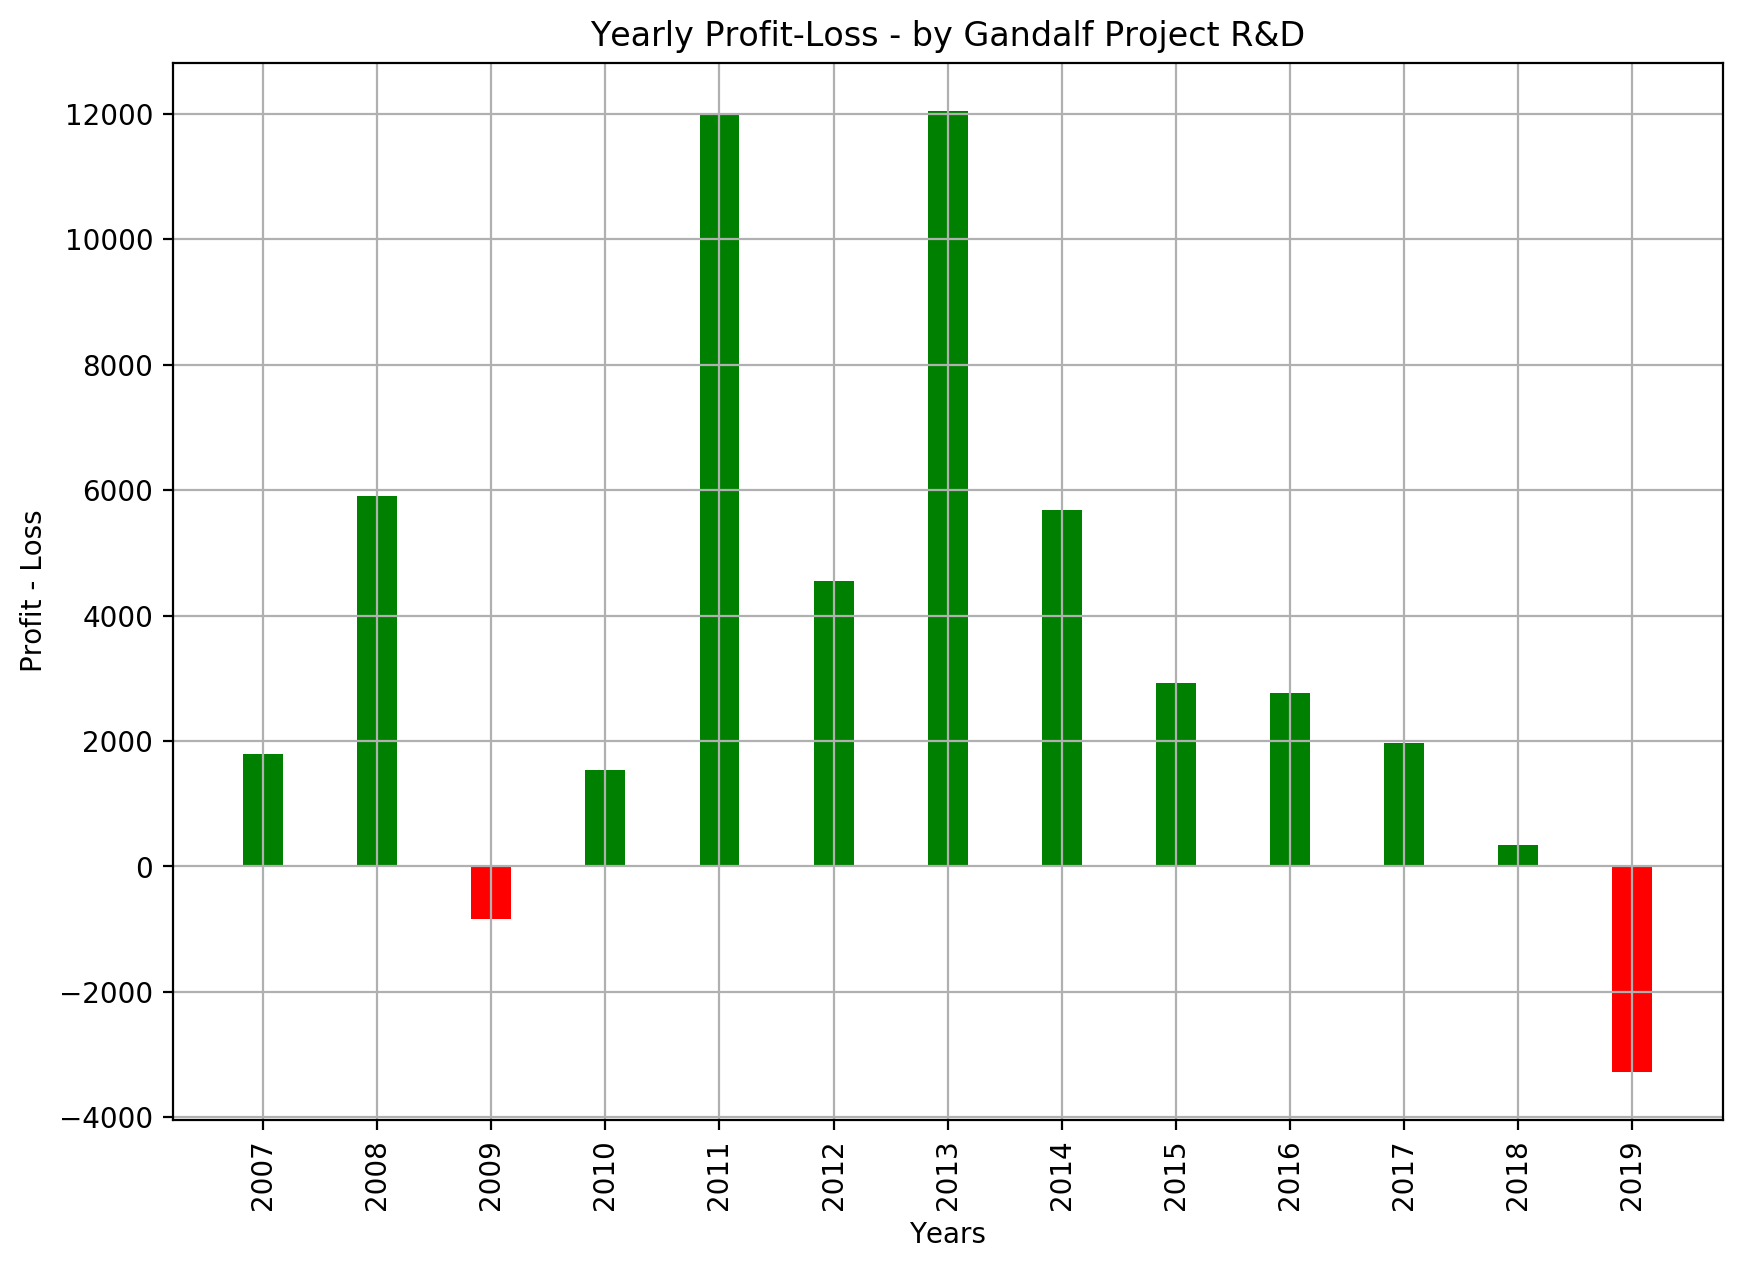

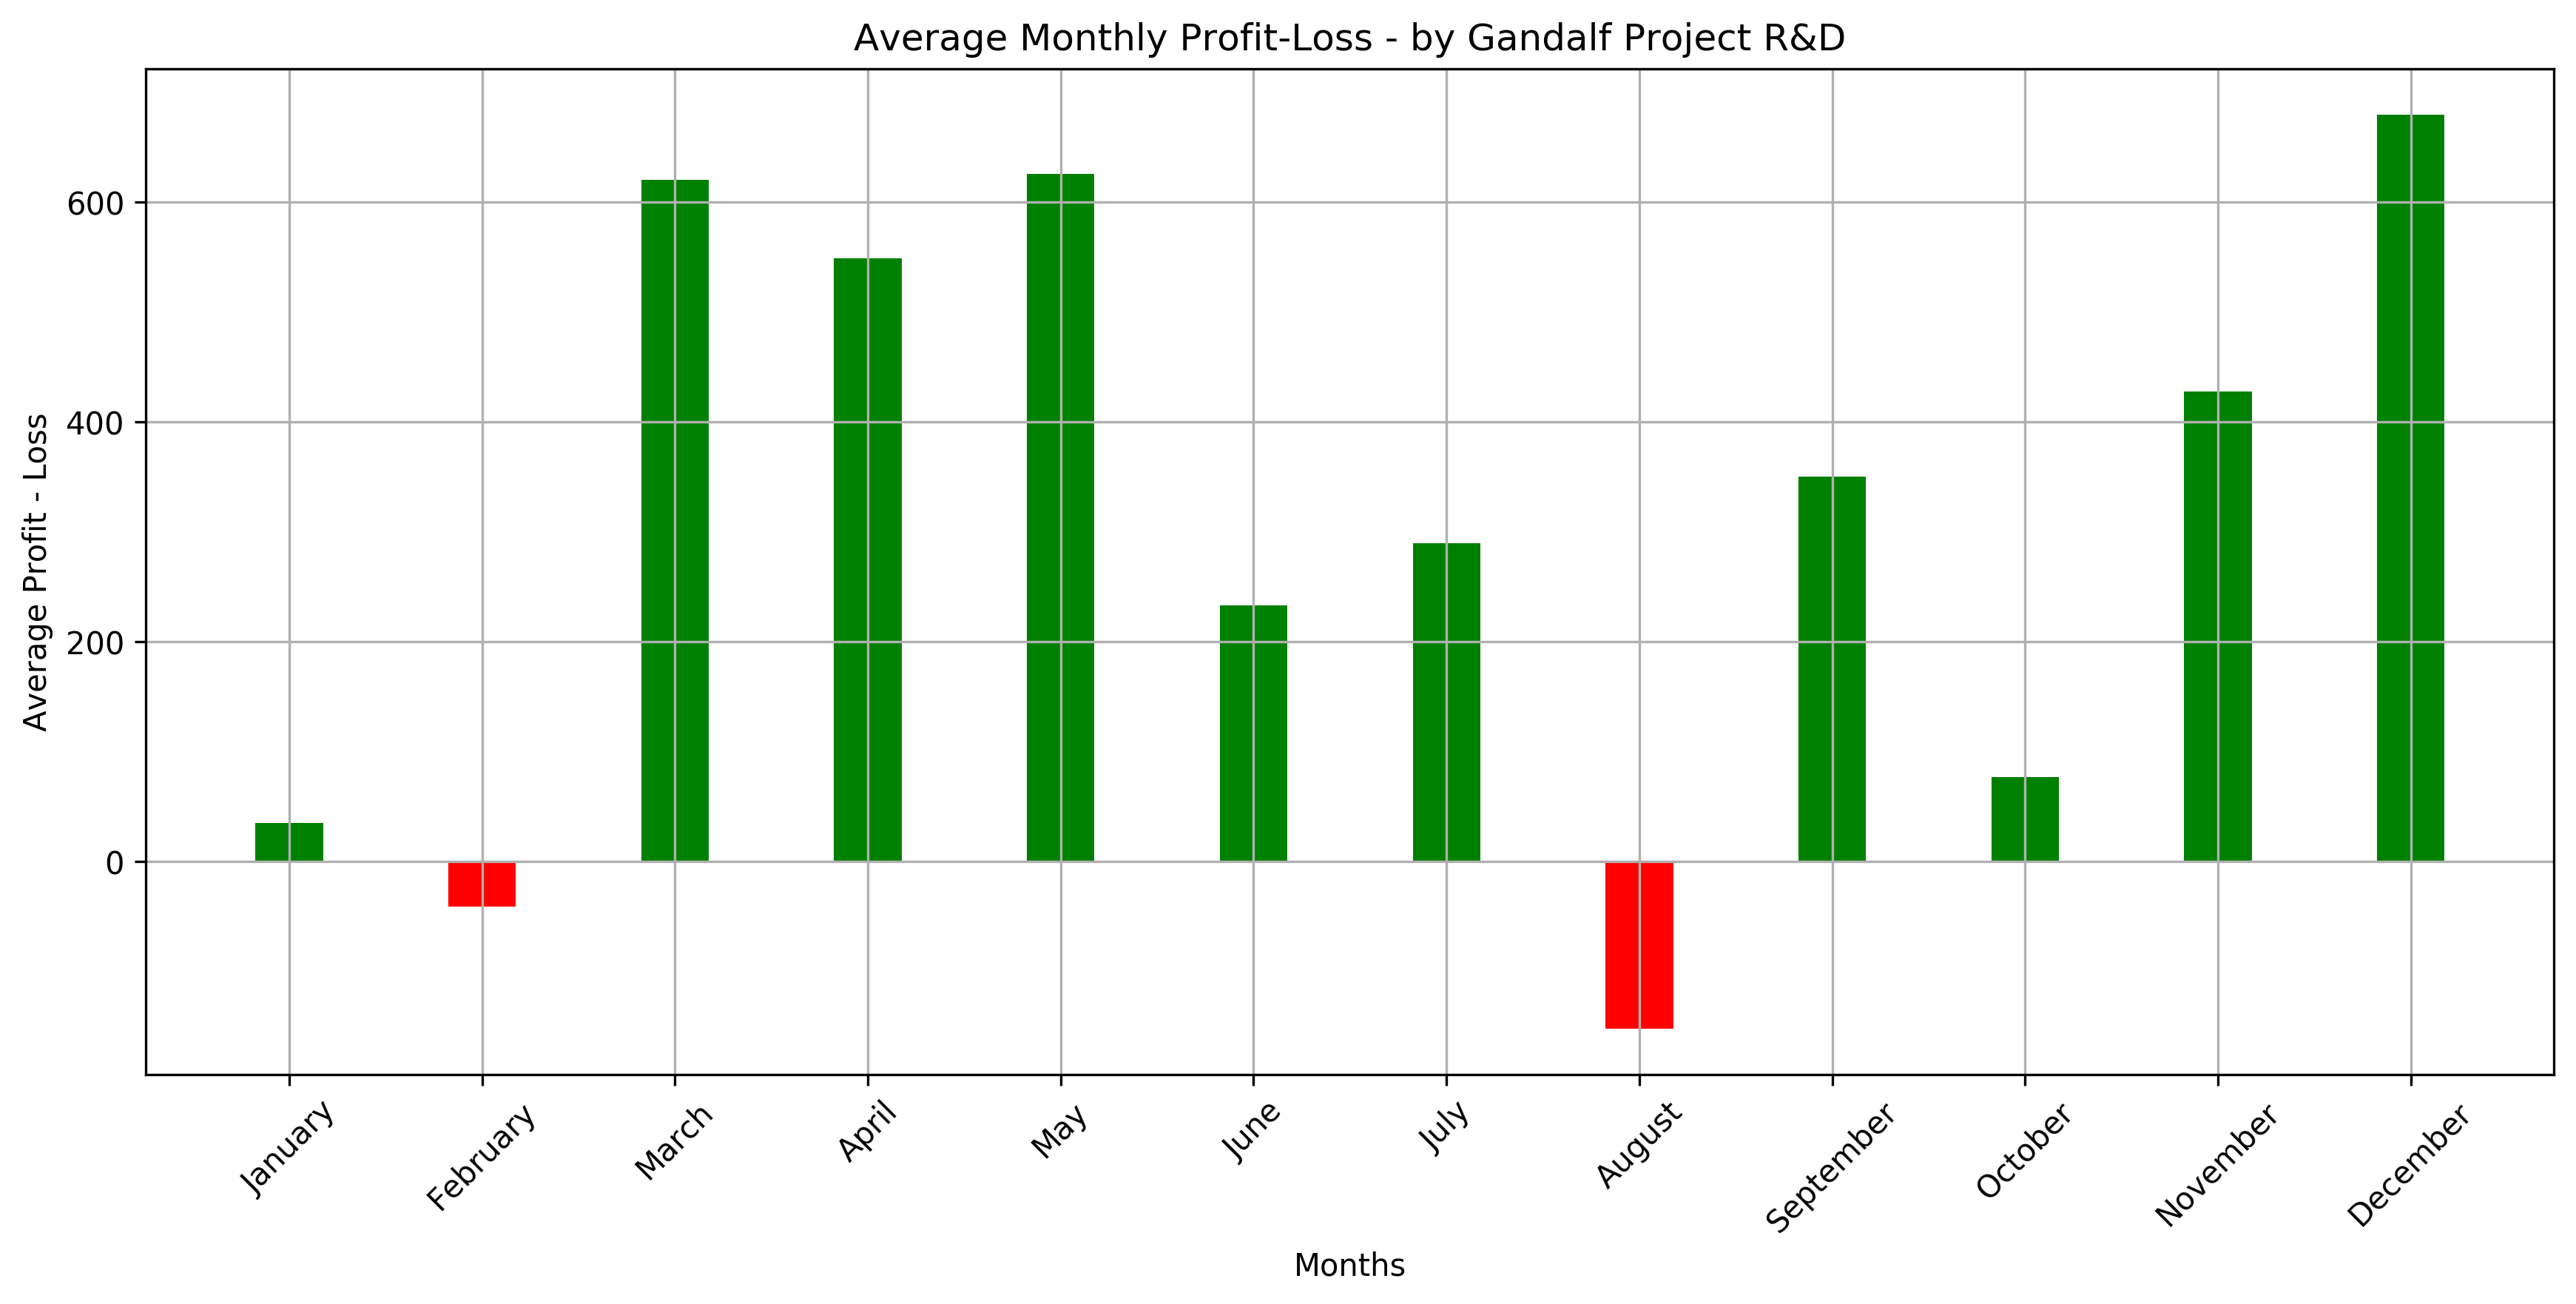

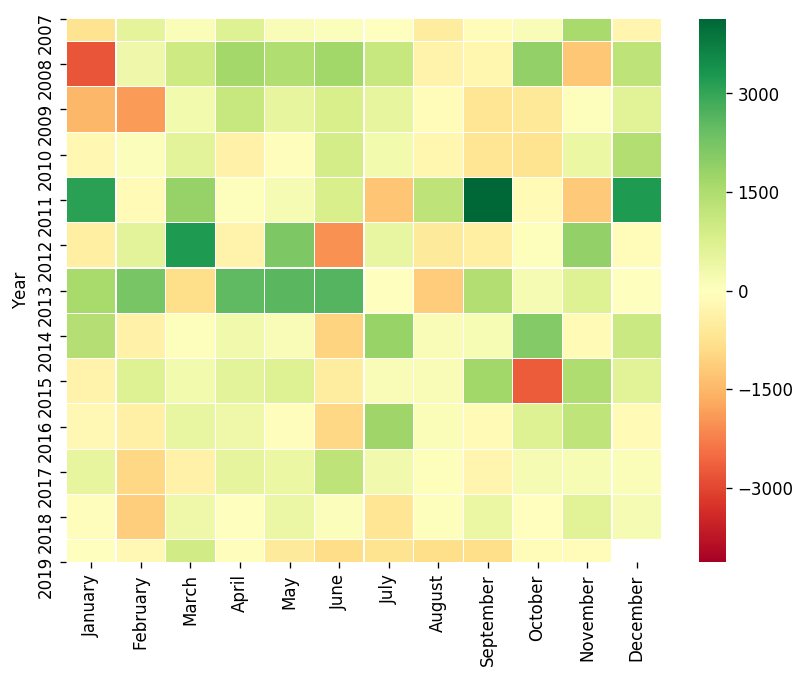

In [18]:
dataset = load_data_intraday("@PL_60min_Exchange.txt")

dataset["hhv23"] = dataset.high.rolling(23).max()
dataset["llv23"] = dataset.low.rolling(23).min()
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 50
TICK = 0.10
OPERATION_MONEY = 10000
DIRECTION = "short"
ORDER_TYPE = "stop"
enter_level = dataset.llv23.shift(1)

enter_rules = dataset.hour < 10
exit_rules = dataset.hour == 10

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

# Opening Range Breakout ORB

Performance Report - by Gandalf Project R&D

Profit:                   96120.0
Operations:               755
Average Trade:            127.31

Profit Factor:            1.45
Gross Profit:             307410.0
Gross Loss:               -211290.0

Percent Winning Trades:   53.64
Percent Losing Trades:    46.36
Reward Risk Ratio:        1.26

Max Gain:                 7450.0  in date  2007-01-21 18:15:00
Average Gain:             759.04
Max Loss:                 -5630.0  in date  2008-08-29 00:15:00
Average Loss:             -607.16

Avg Open Draw Down:       -3000.85
Max Open Draw Down:       -12140.0

Avg Closed Draw Down:     -2990.69
Max Closed Draw Down:     -9710.0

Avg Delay Between Peaks:  809.38
Max Delay Between Peaks:  59845


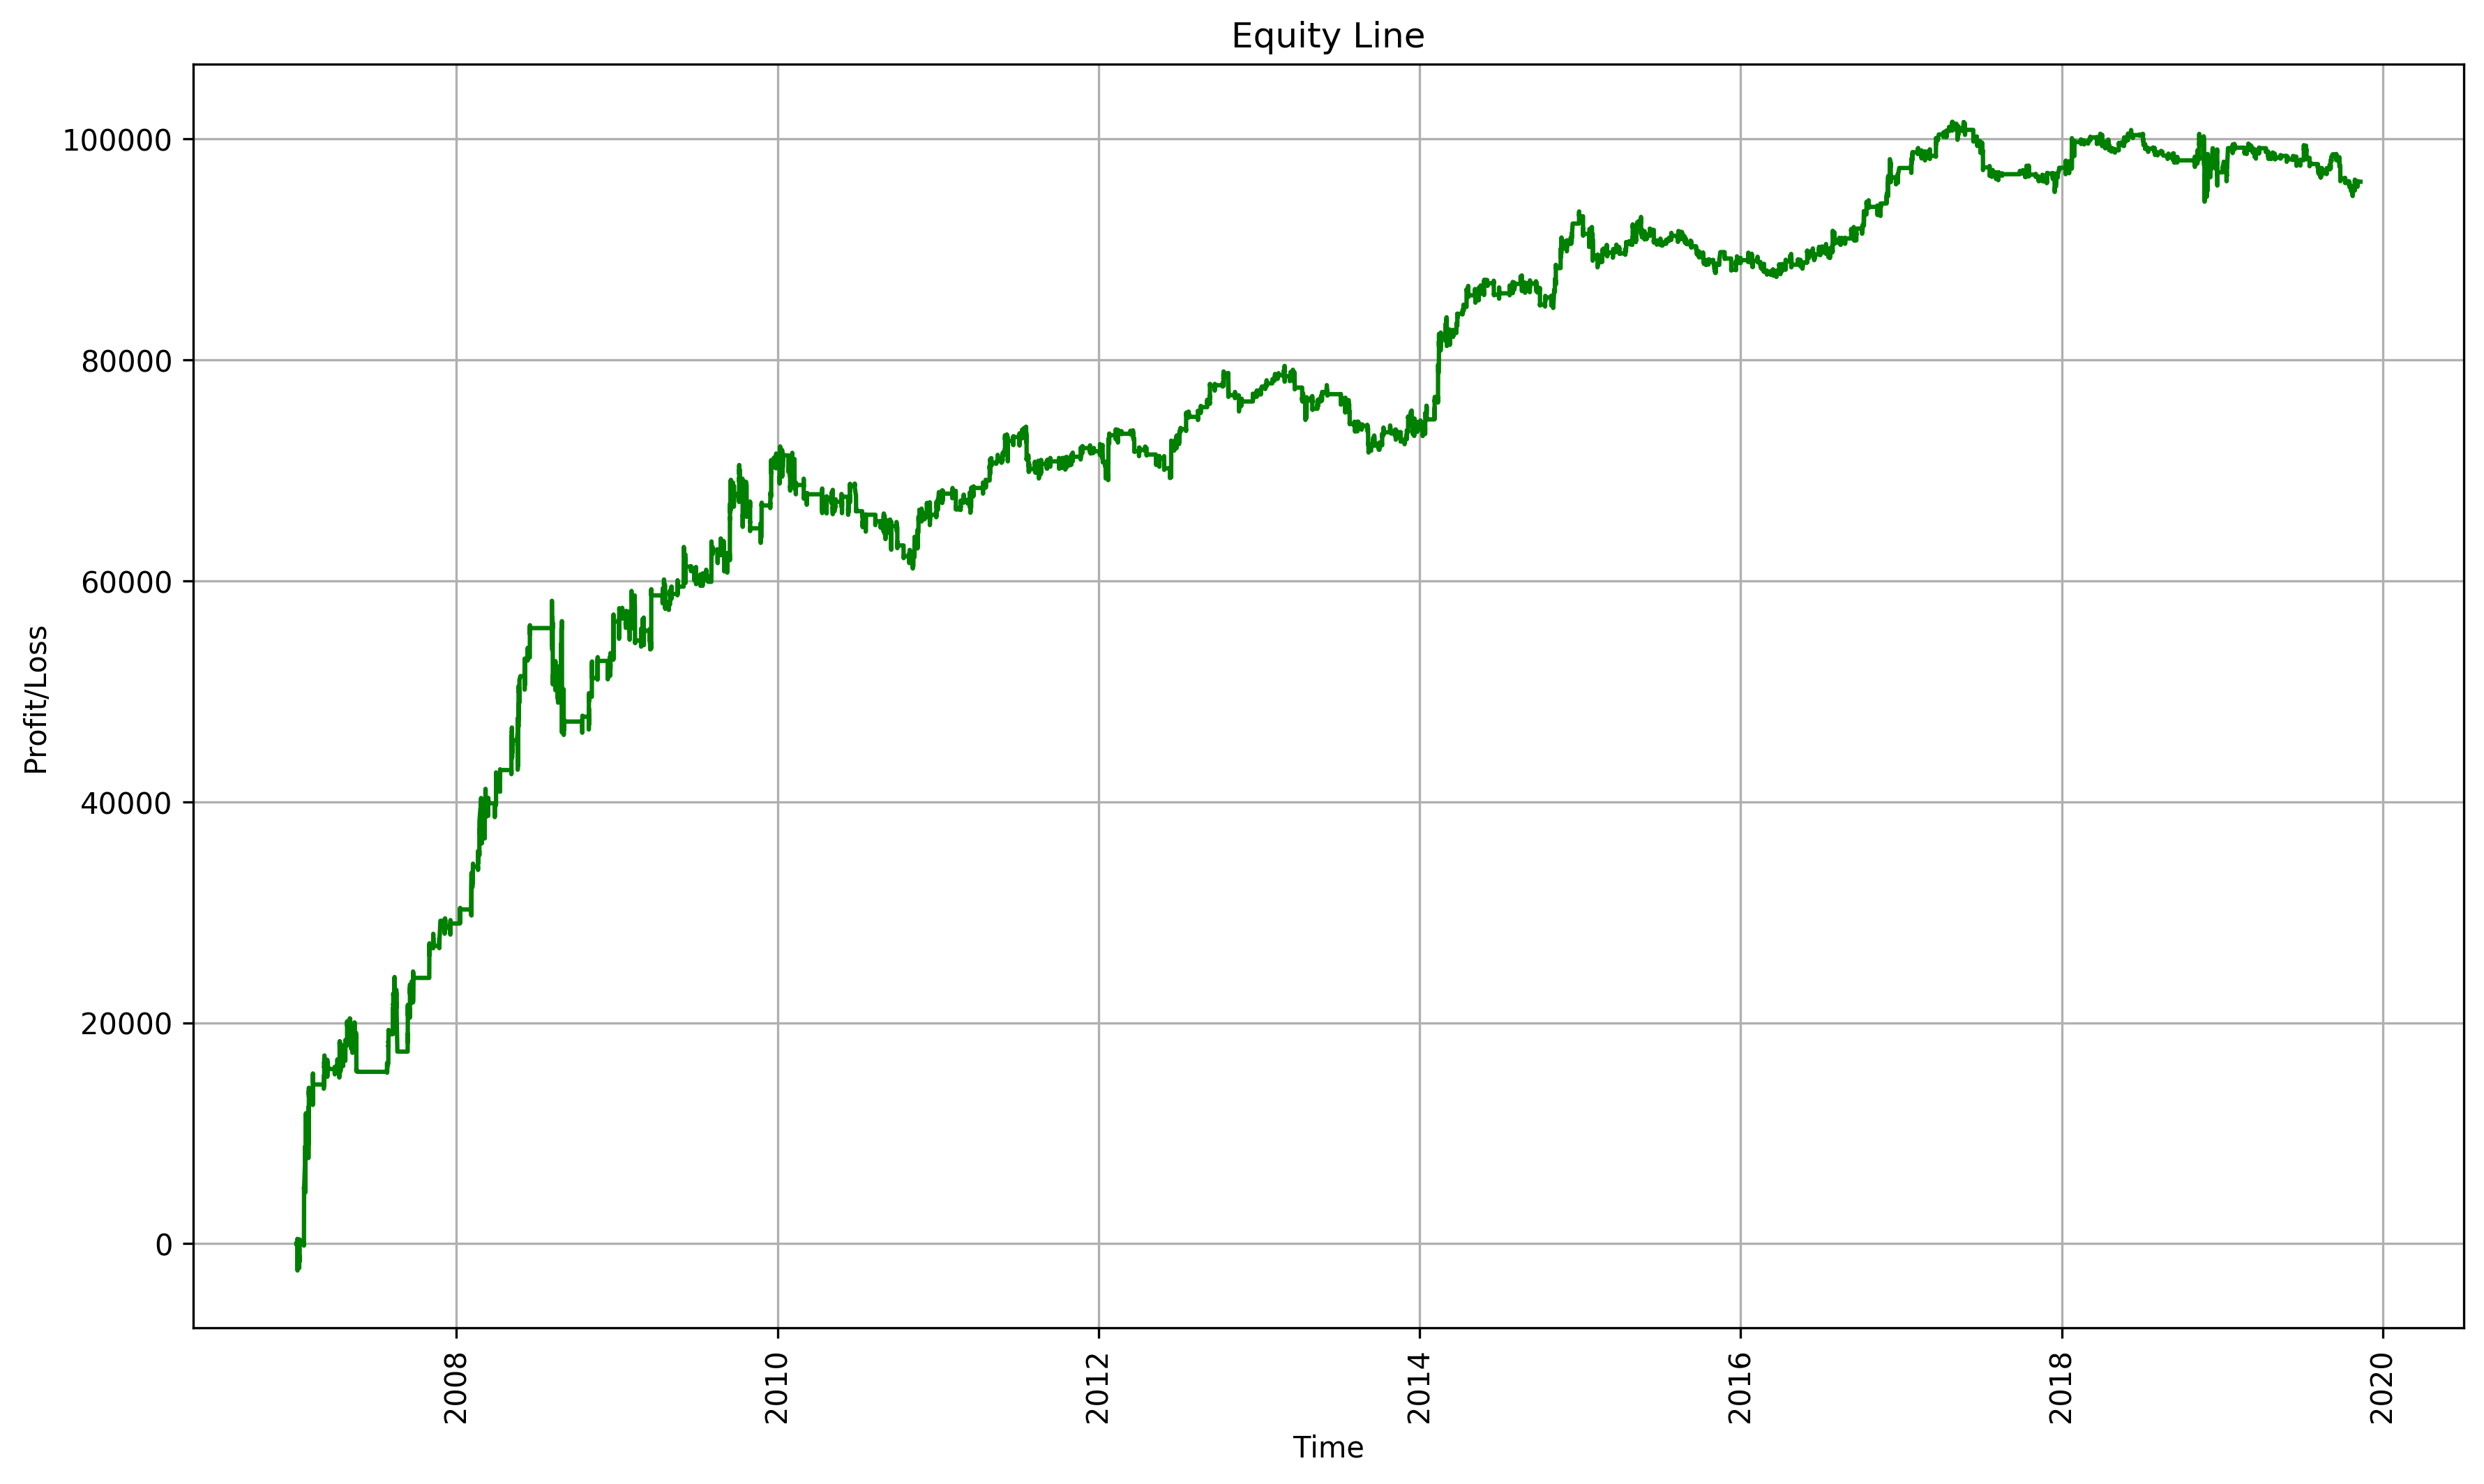

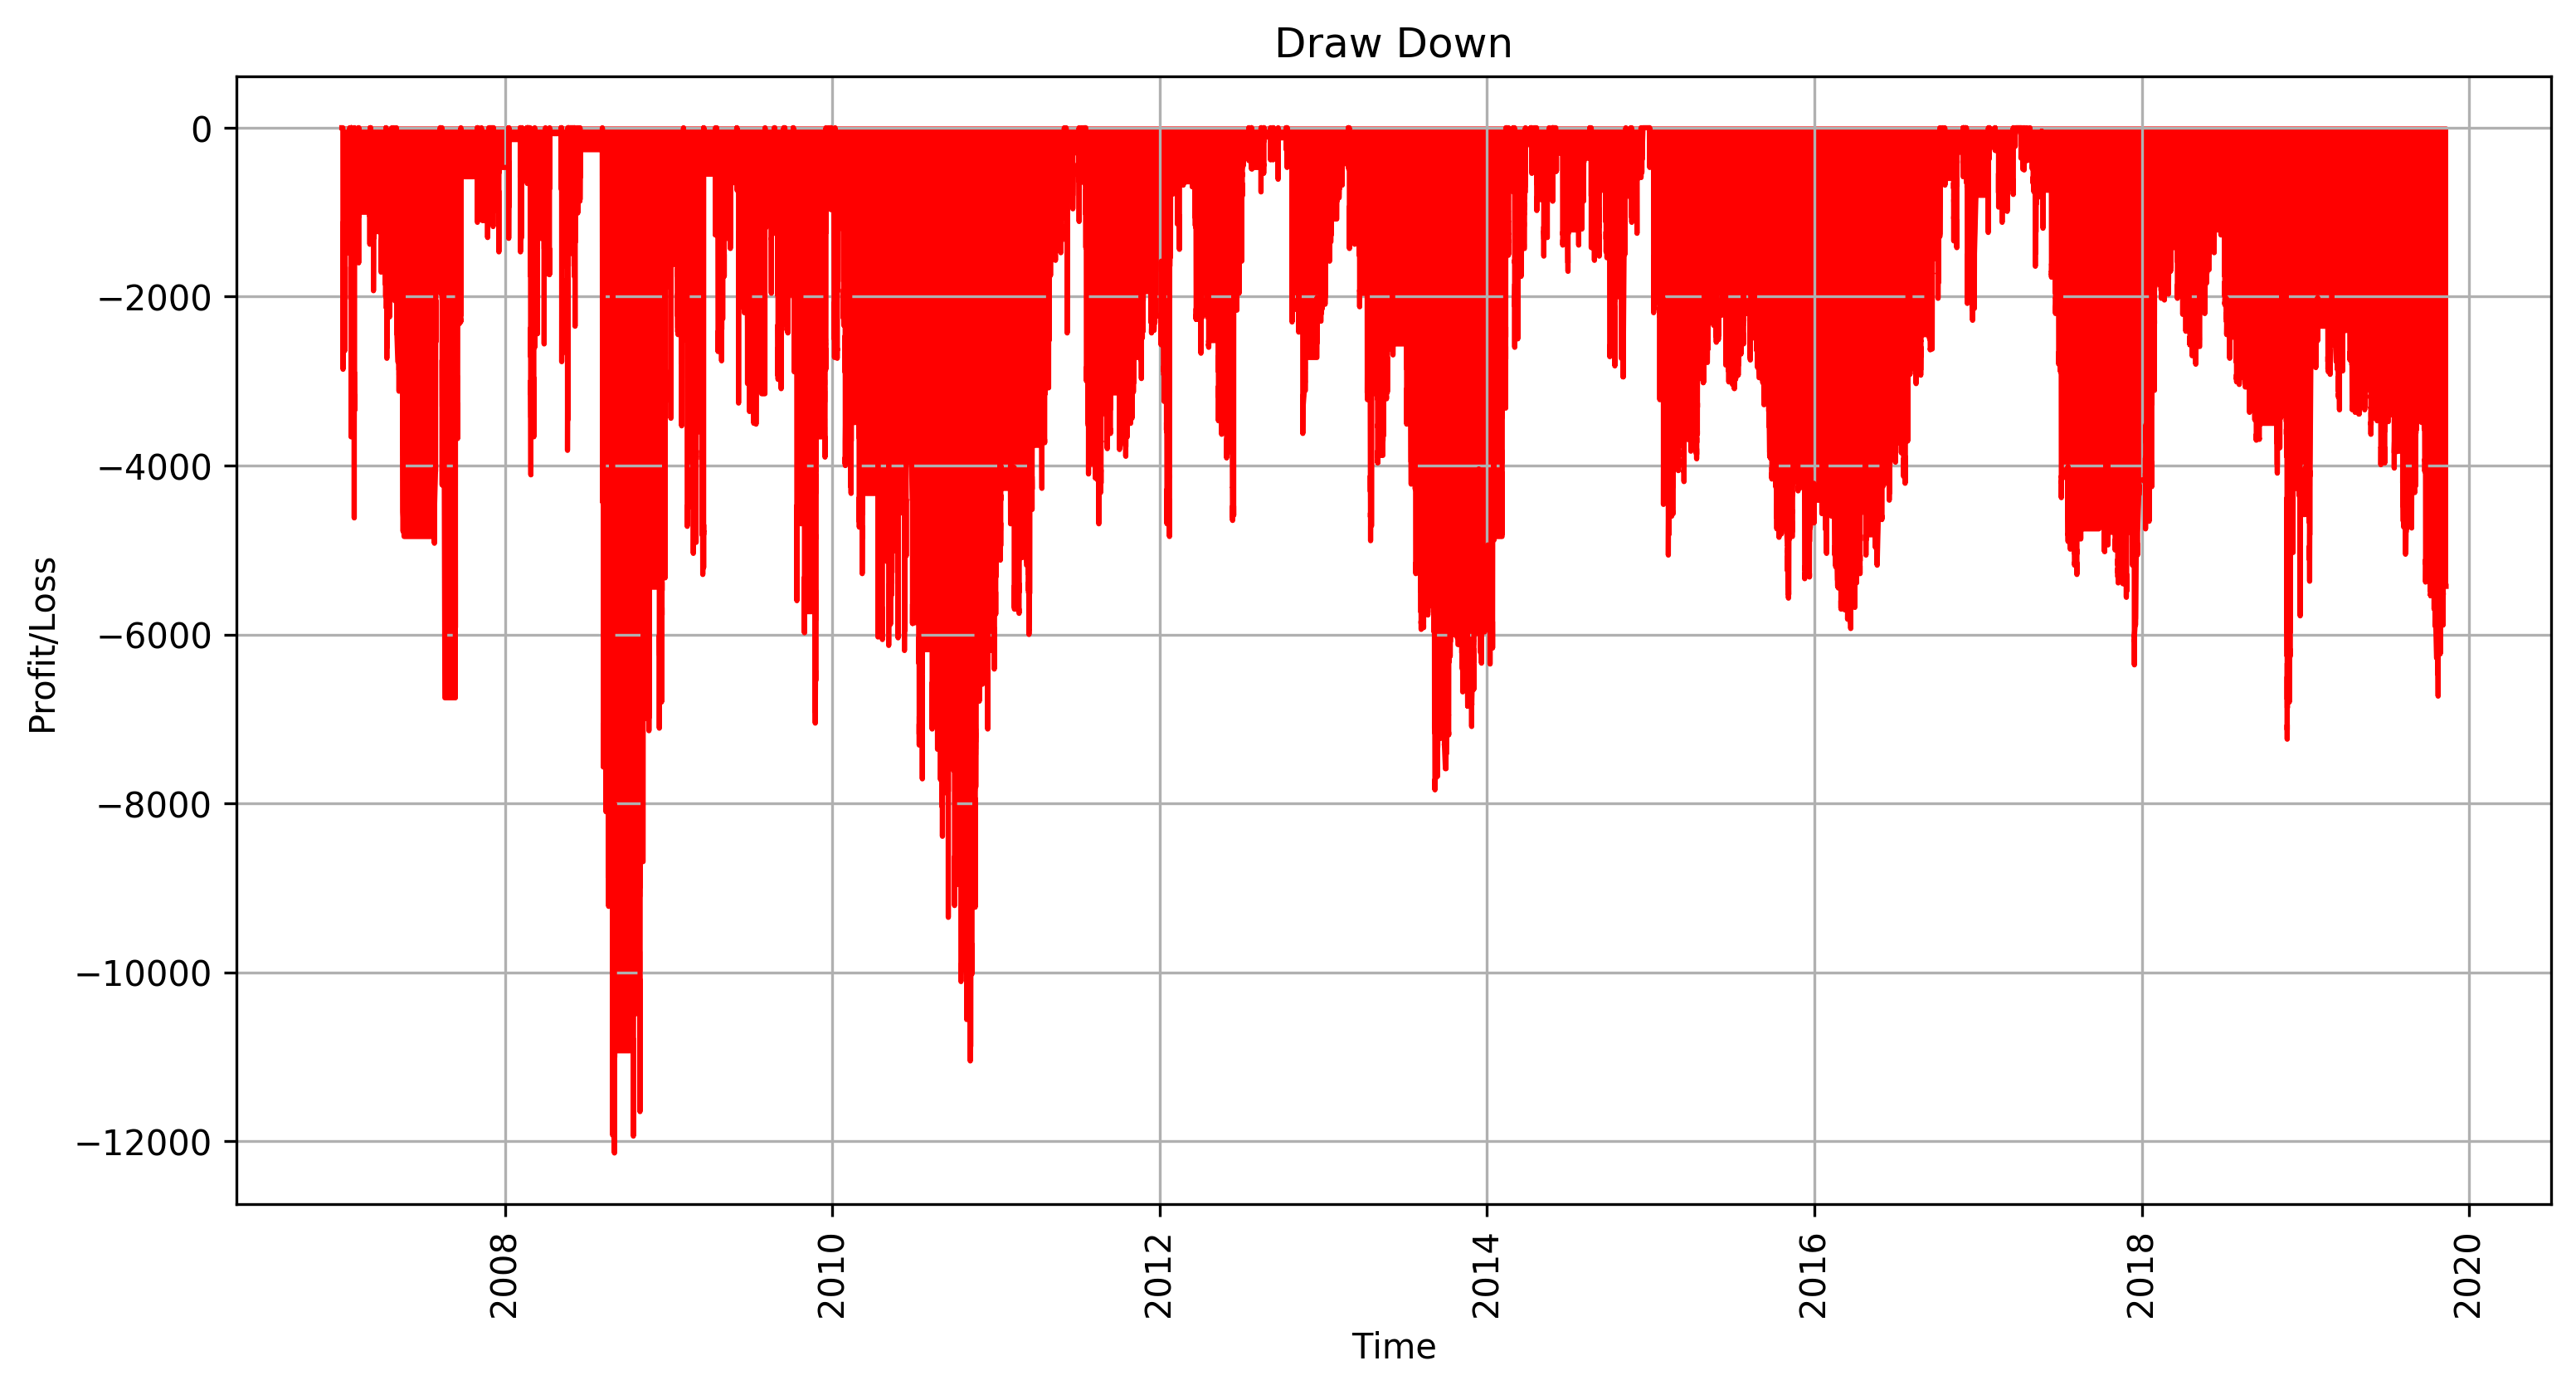

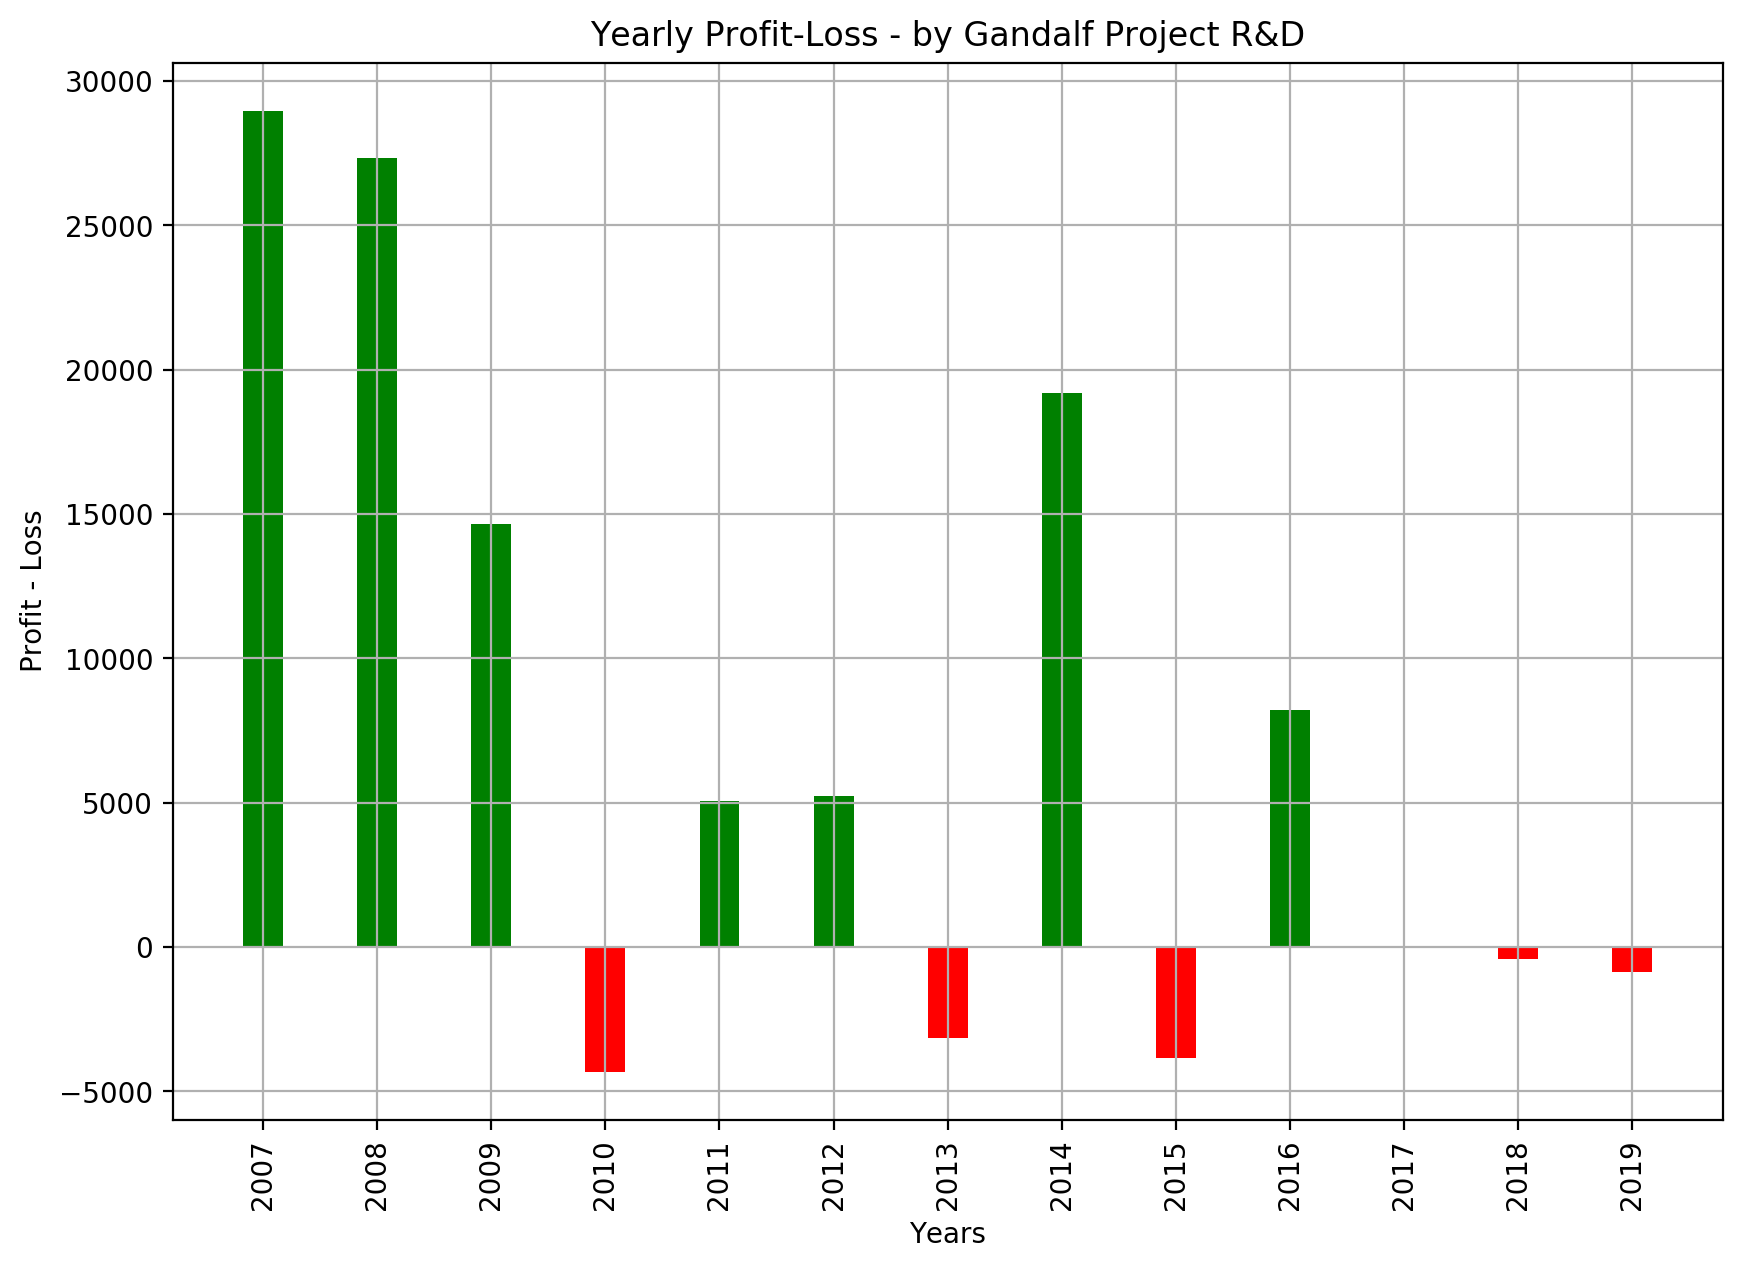

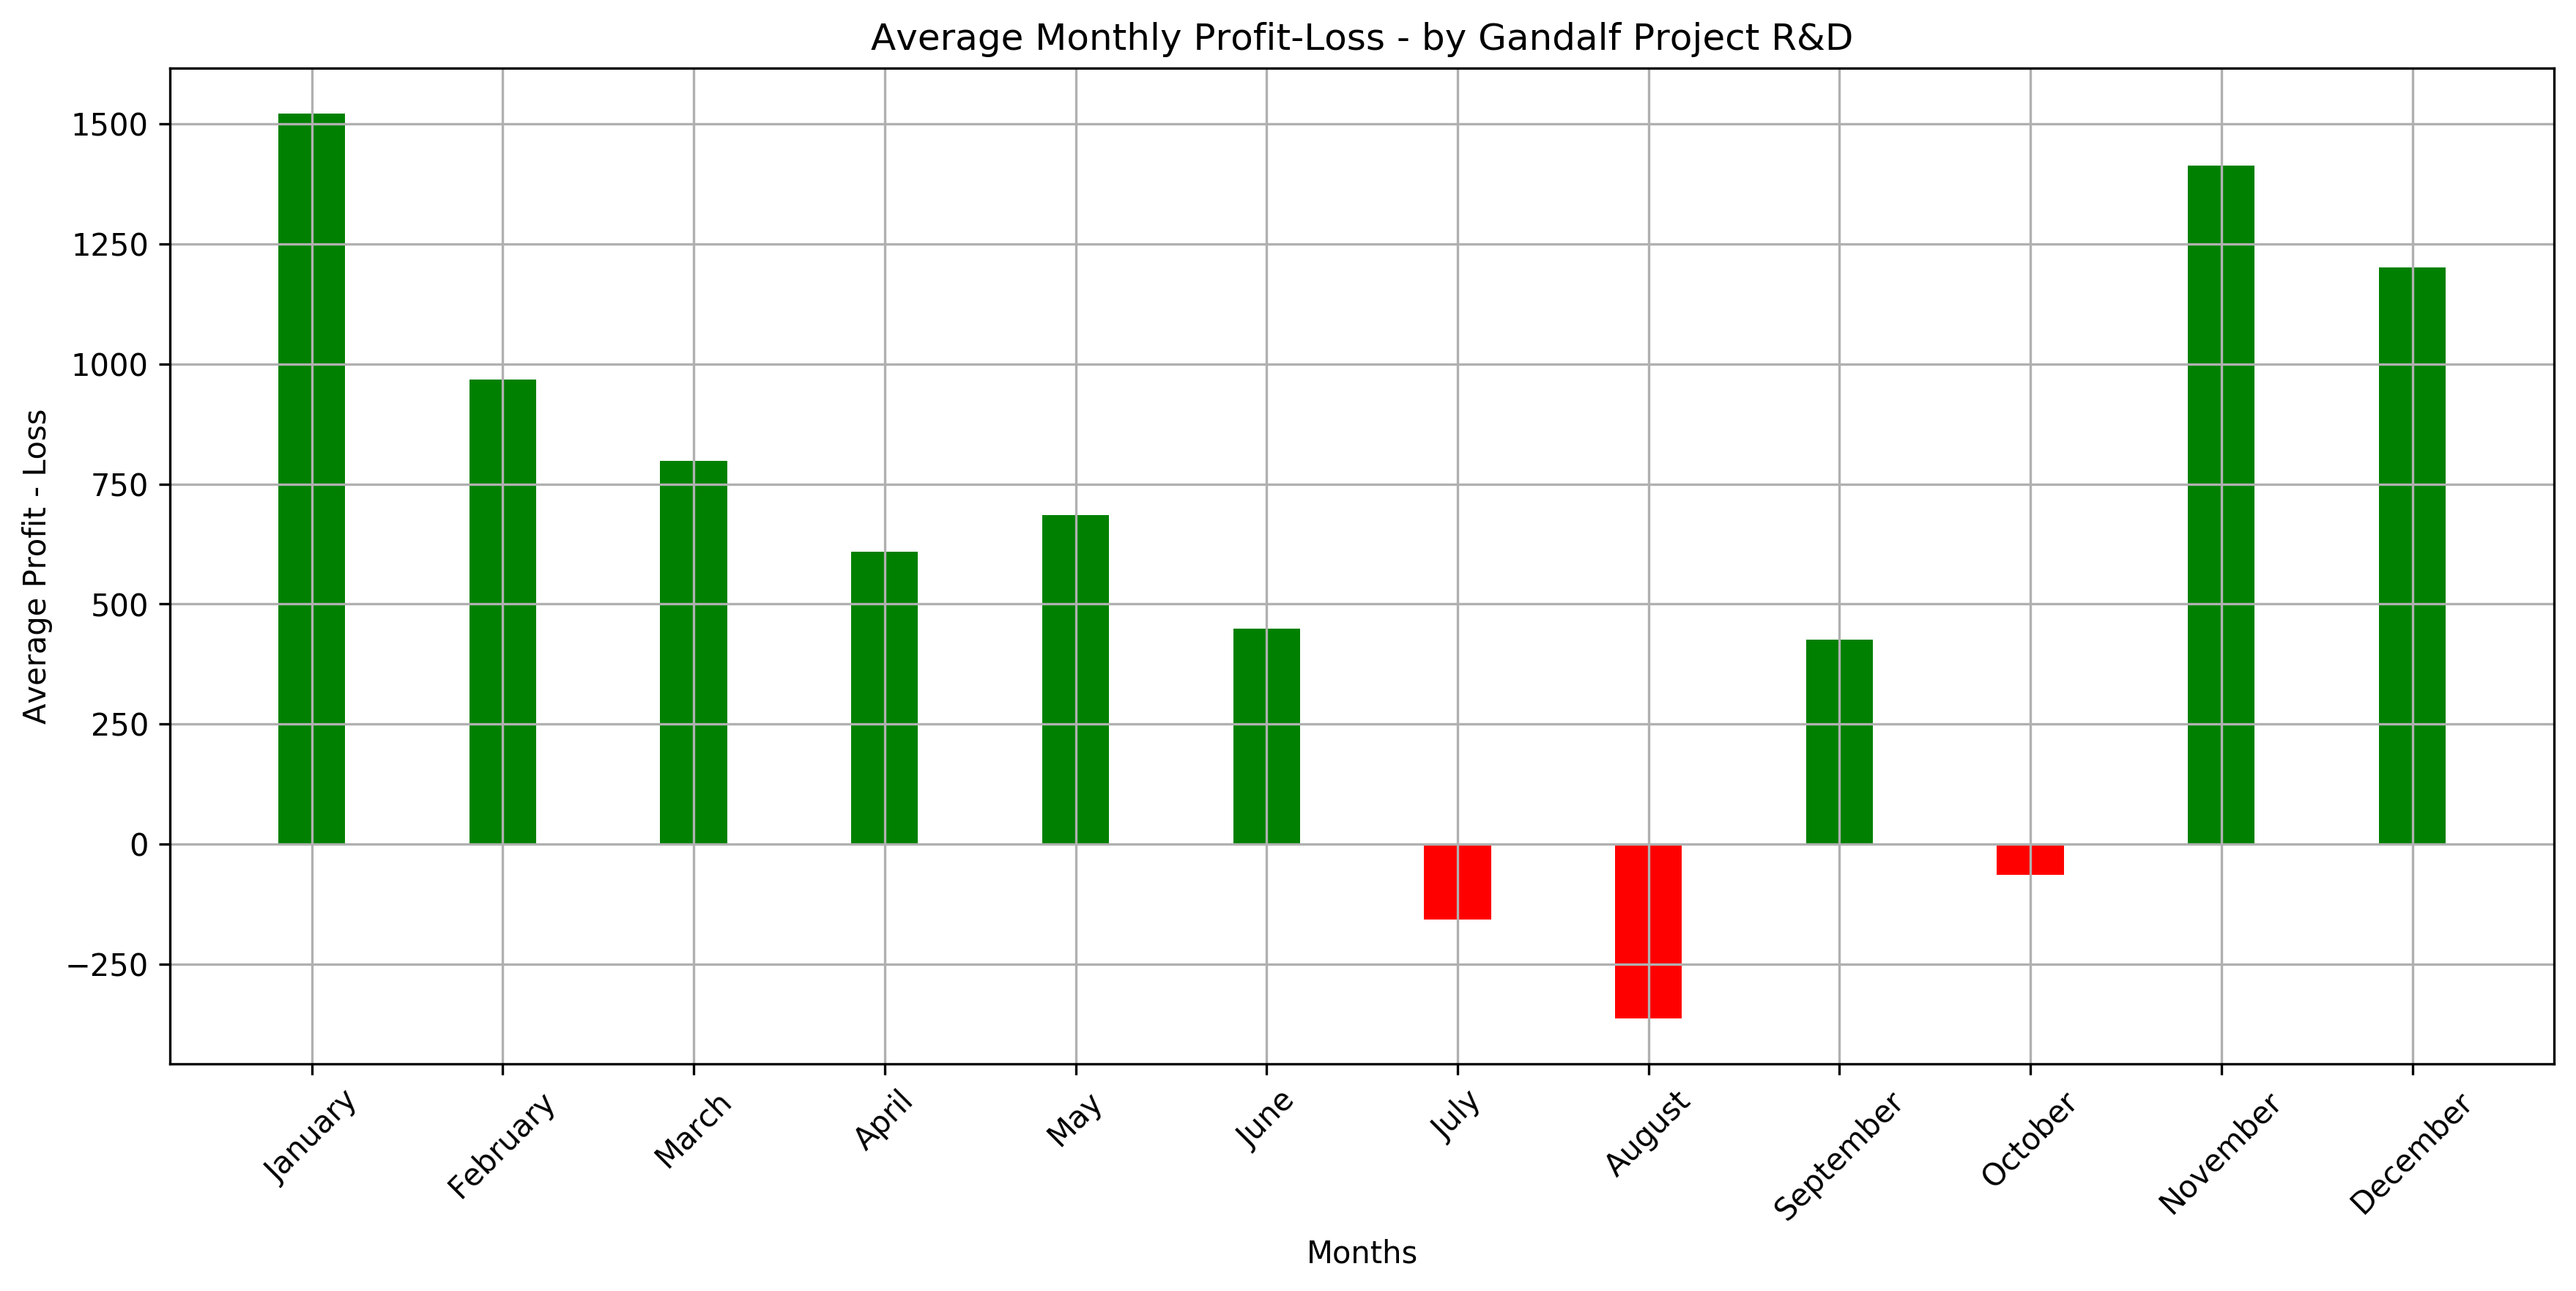

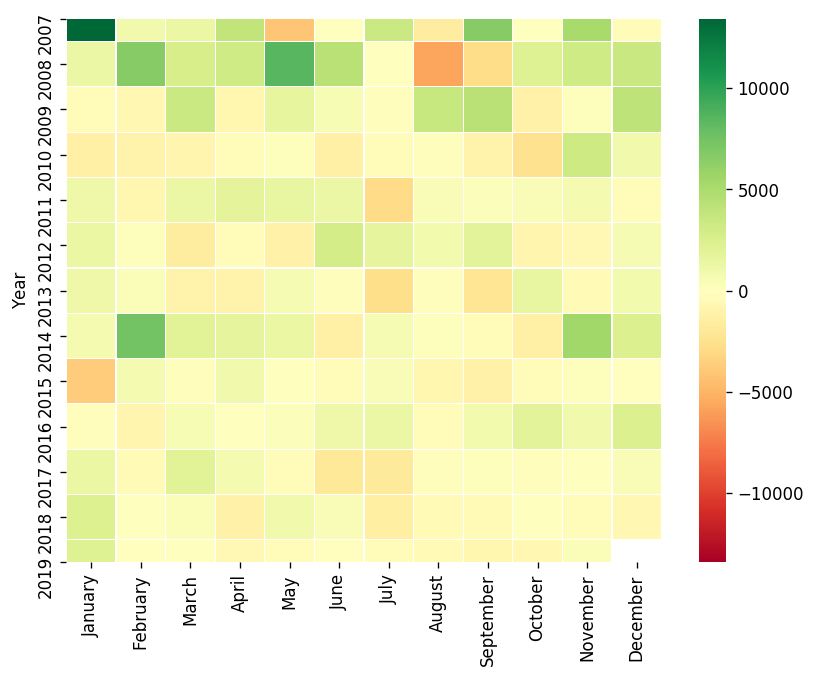

In [19]:
dataset = load_data_intraday("@NG_15min_Exchange.txt")

dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.open.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.close.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')
dataset["range1"] = dataset["daily_high1"] - dataset["daily_low1"]
dataset["ORB_UP"] = np.where(dataset.day != dataset.day.shift(1),dataset.open + 0.5 * dataset.range1,np.NaN)
dataset["ORB_UP"] = dataset["ORB_UP"].fillna(method = 'ffill')
dataset["ORB_DOWN"] = np.where(dataset.day != dataset.day.shift(1),dataset.open - 0.5 * dataset.range1,np.NaN)
dataset["ORB_DOWN"] = dataset["ORB_DOWN"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 10000
TICK = 0.001
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules = blastoff
enter_level = dataset.ORB_UP

exit_rules = (dataset.day != dataset.day.shift(1))

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

Backtesting start at: 2019-11-27 18:49:39.501188
Performance Report - by Gandalf Project R&D

Profit:                   55735.0
Operations:               750
Average Trade:            74.31

Profit Factor:            1.44
Gross Profit:             182500.0
Gross Loss:               -126765.0

Percent Winning Trades:   53.87
Percent Losing Trades:    46.13
Reward Risk Ratio:        1.23

Max Gain:                 3420.0  in date  2008-09-23 00:00:00
Average Gain:             451.73
Max Loss:                 -3700.0  in date  2008-10-31 00:00:00
Average Loss:             -369.58

Avg Open Draw Down:       -3032.41
Max Open Draw Down:       -9910.0

Avg Closed Draw Down:     -3292.25
Max Closed Draw Down:     -9440.0

Avg Delay Between Peaks:  784.65
Max Delay Between Peaks:  136912


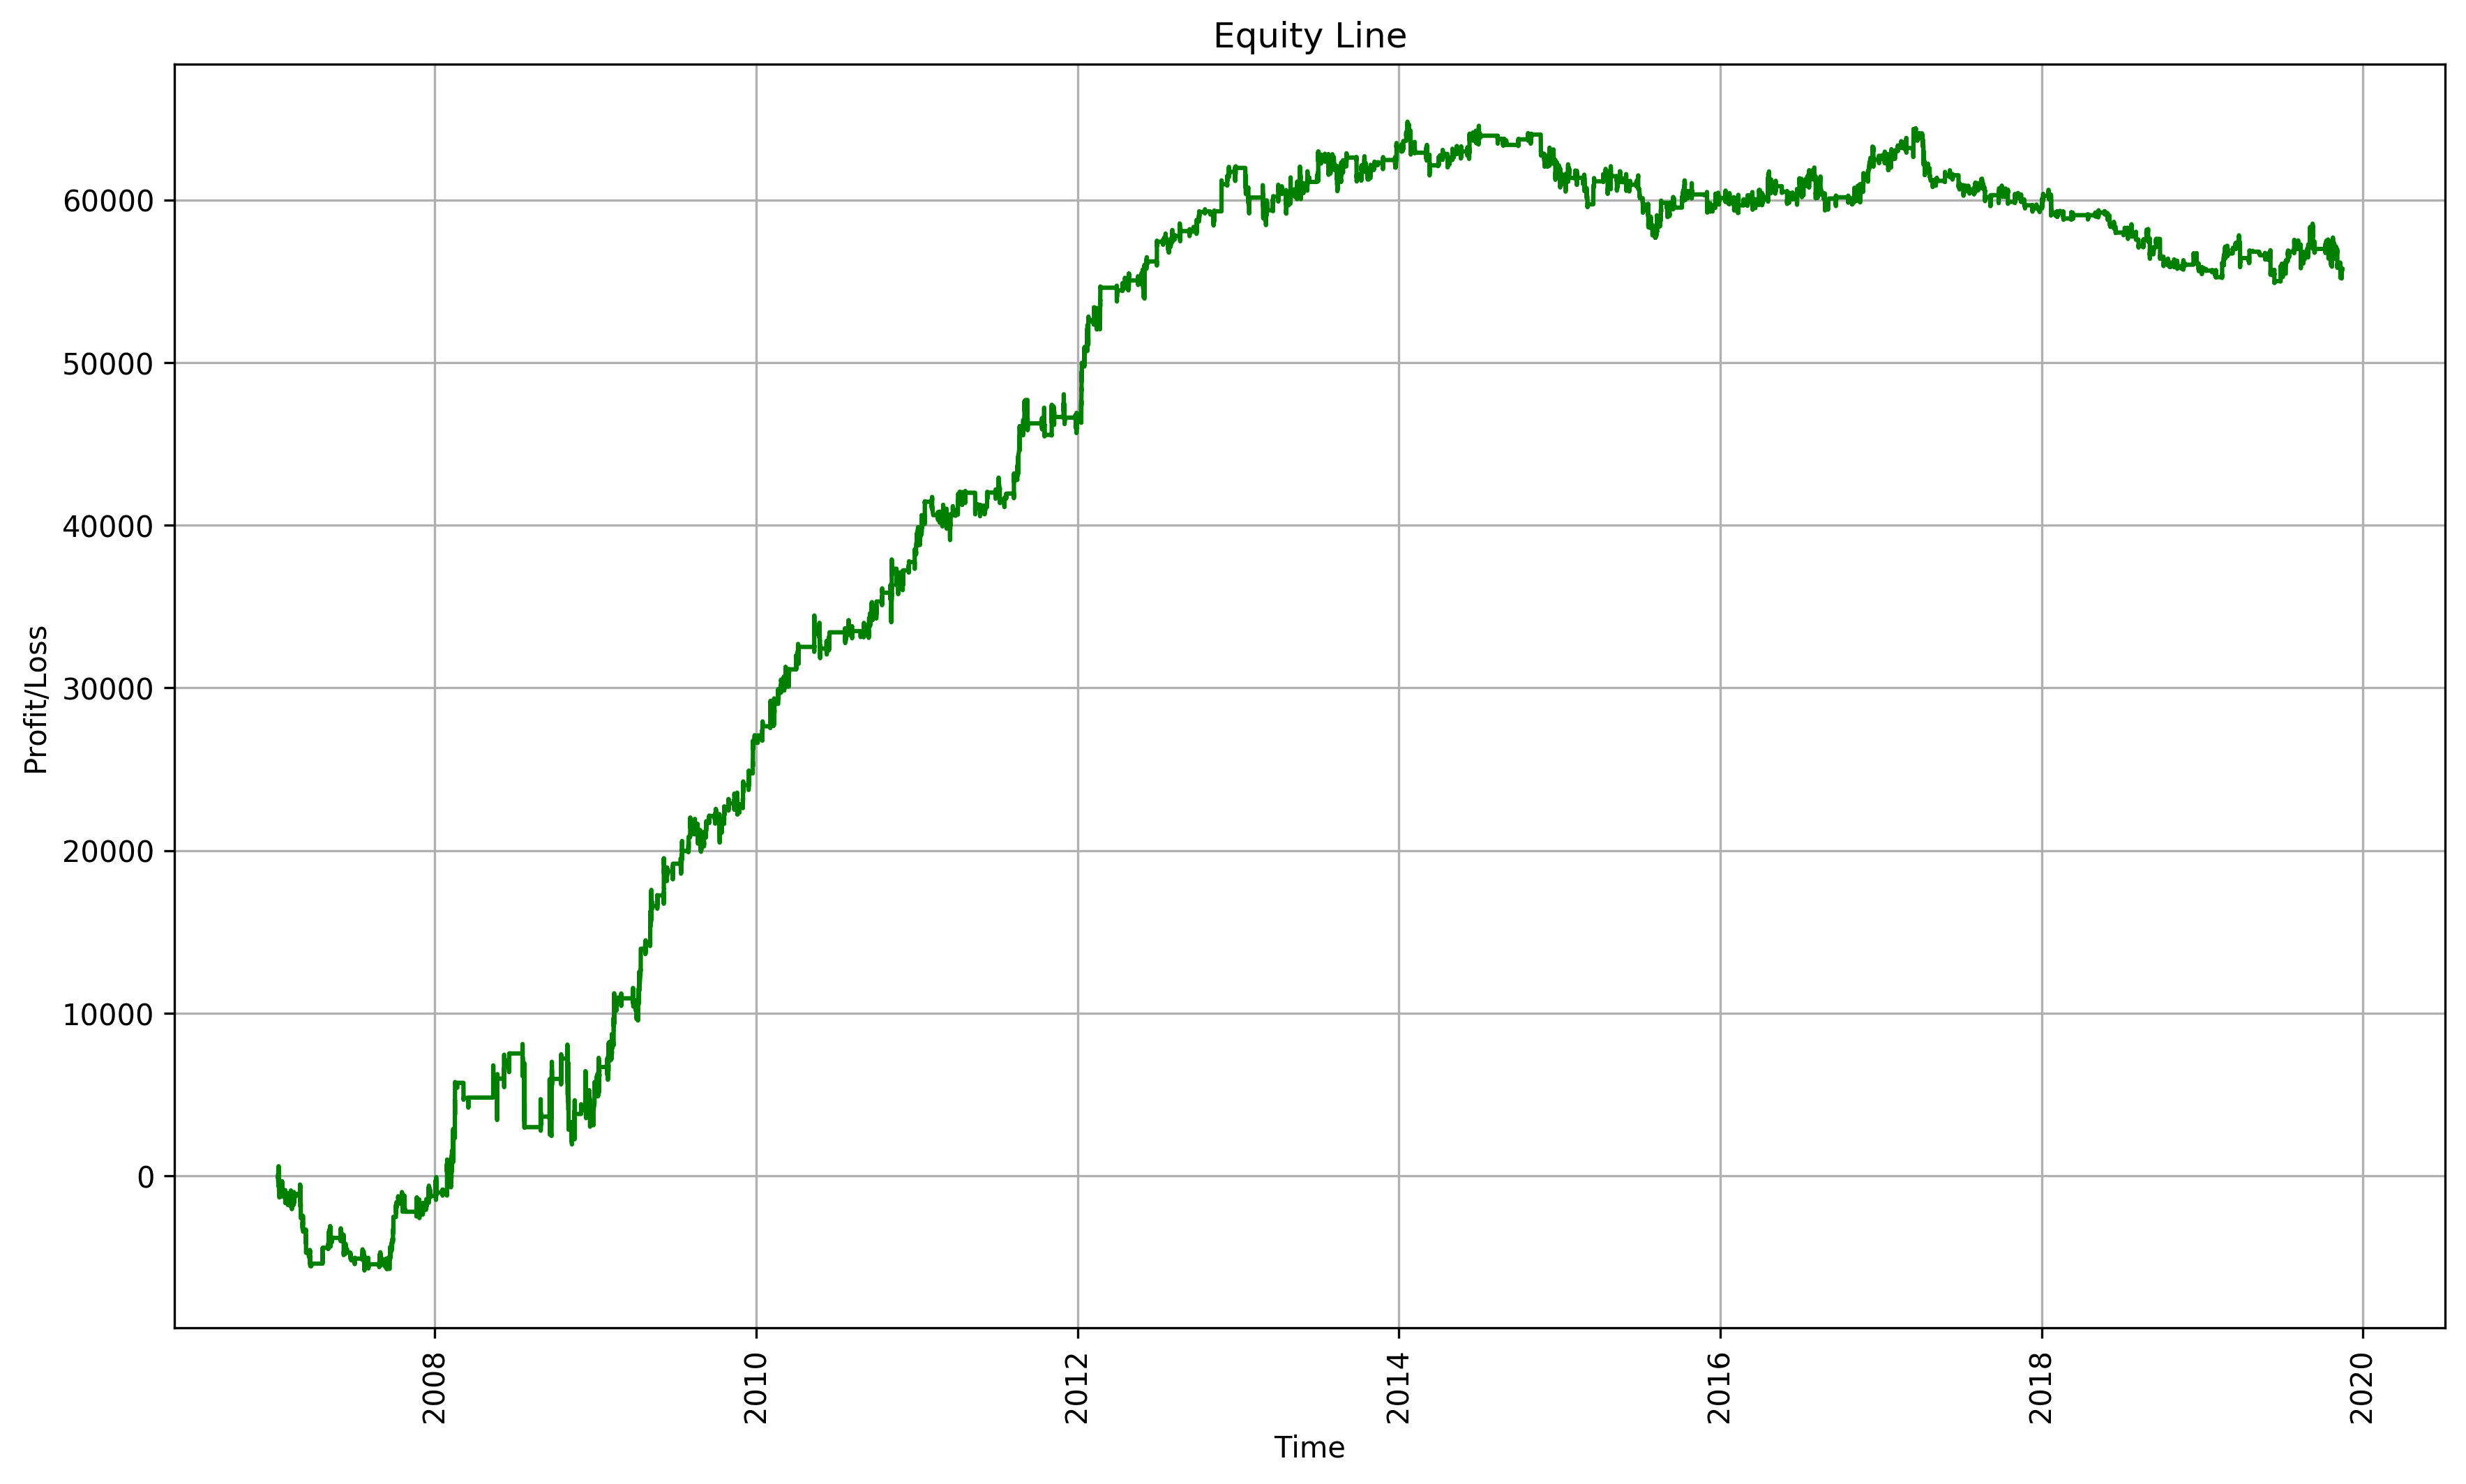

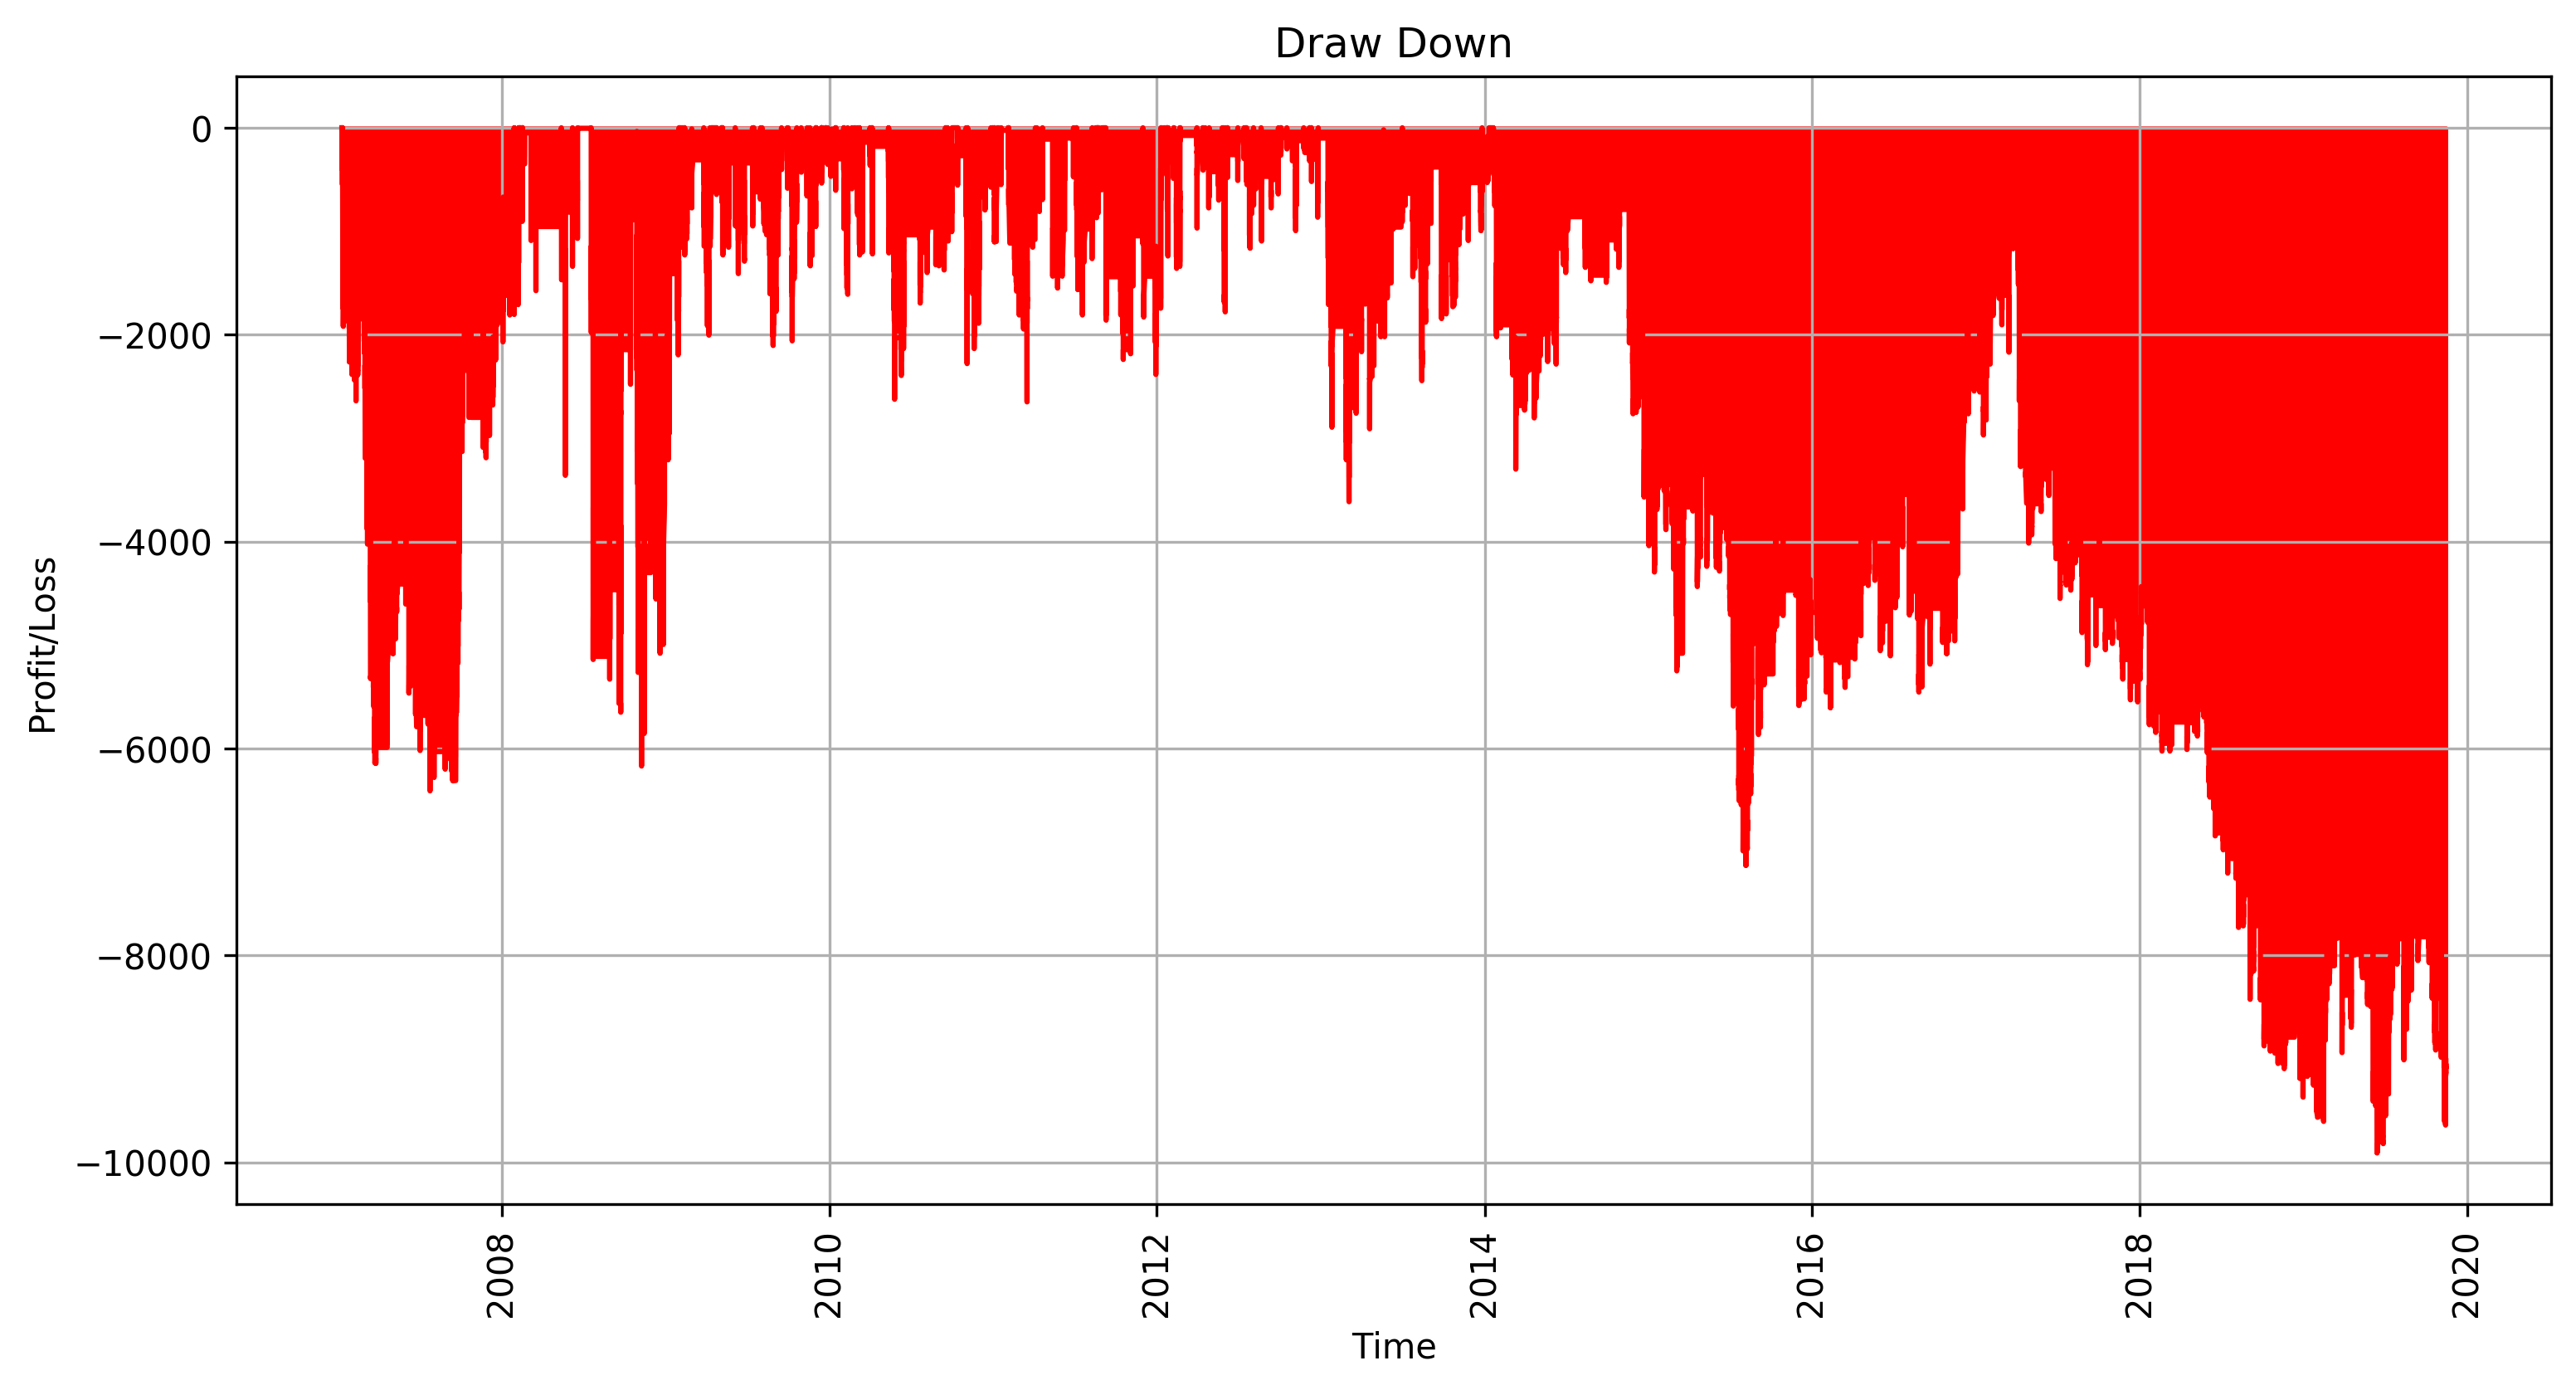

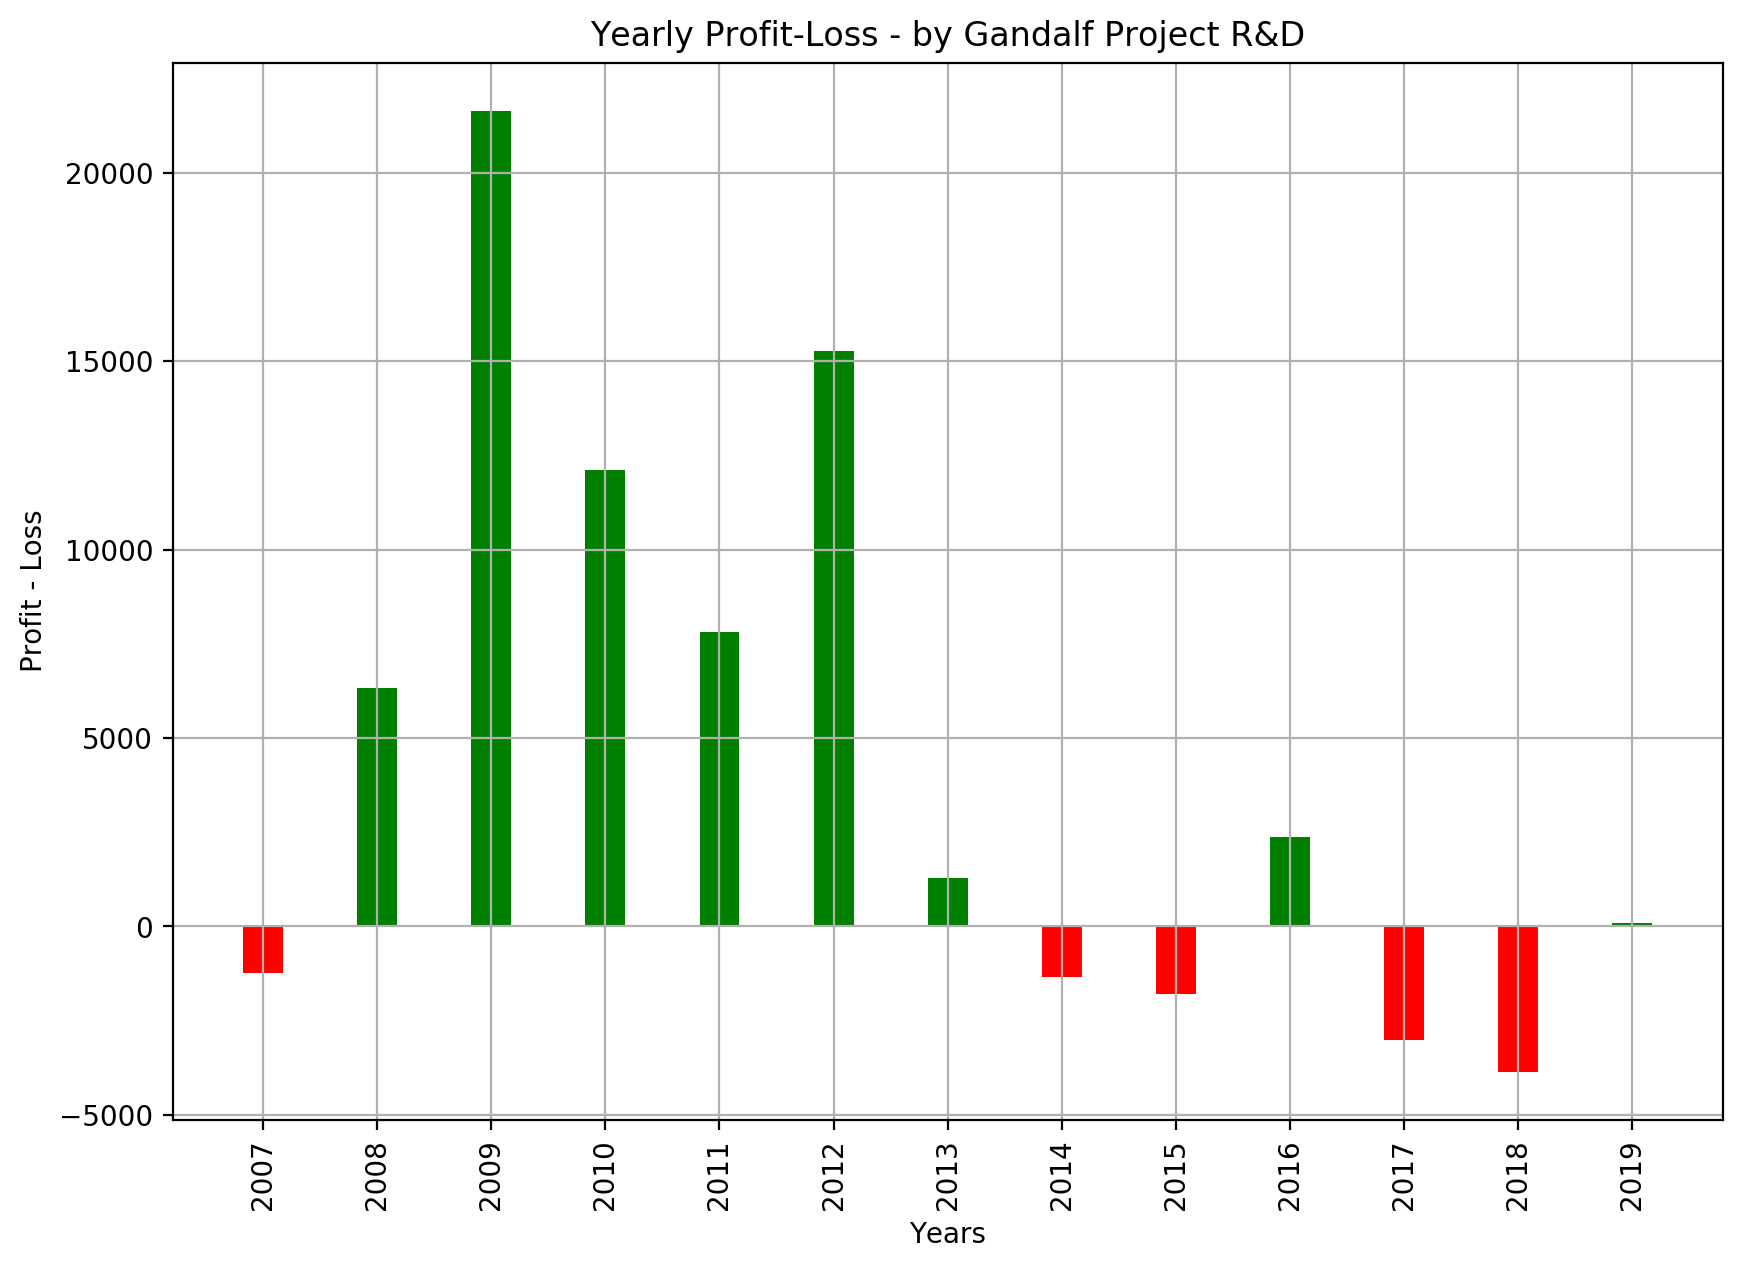

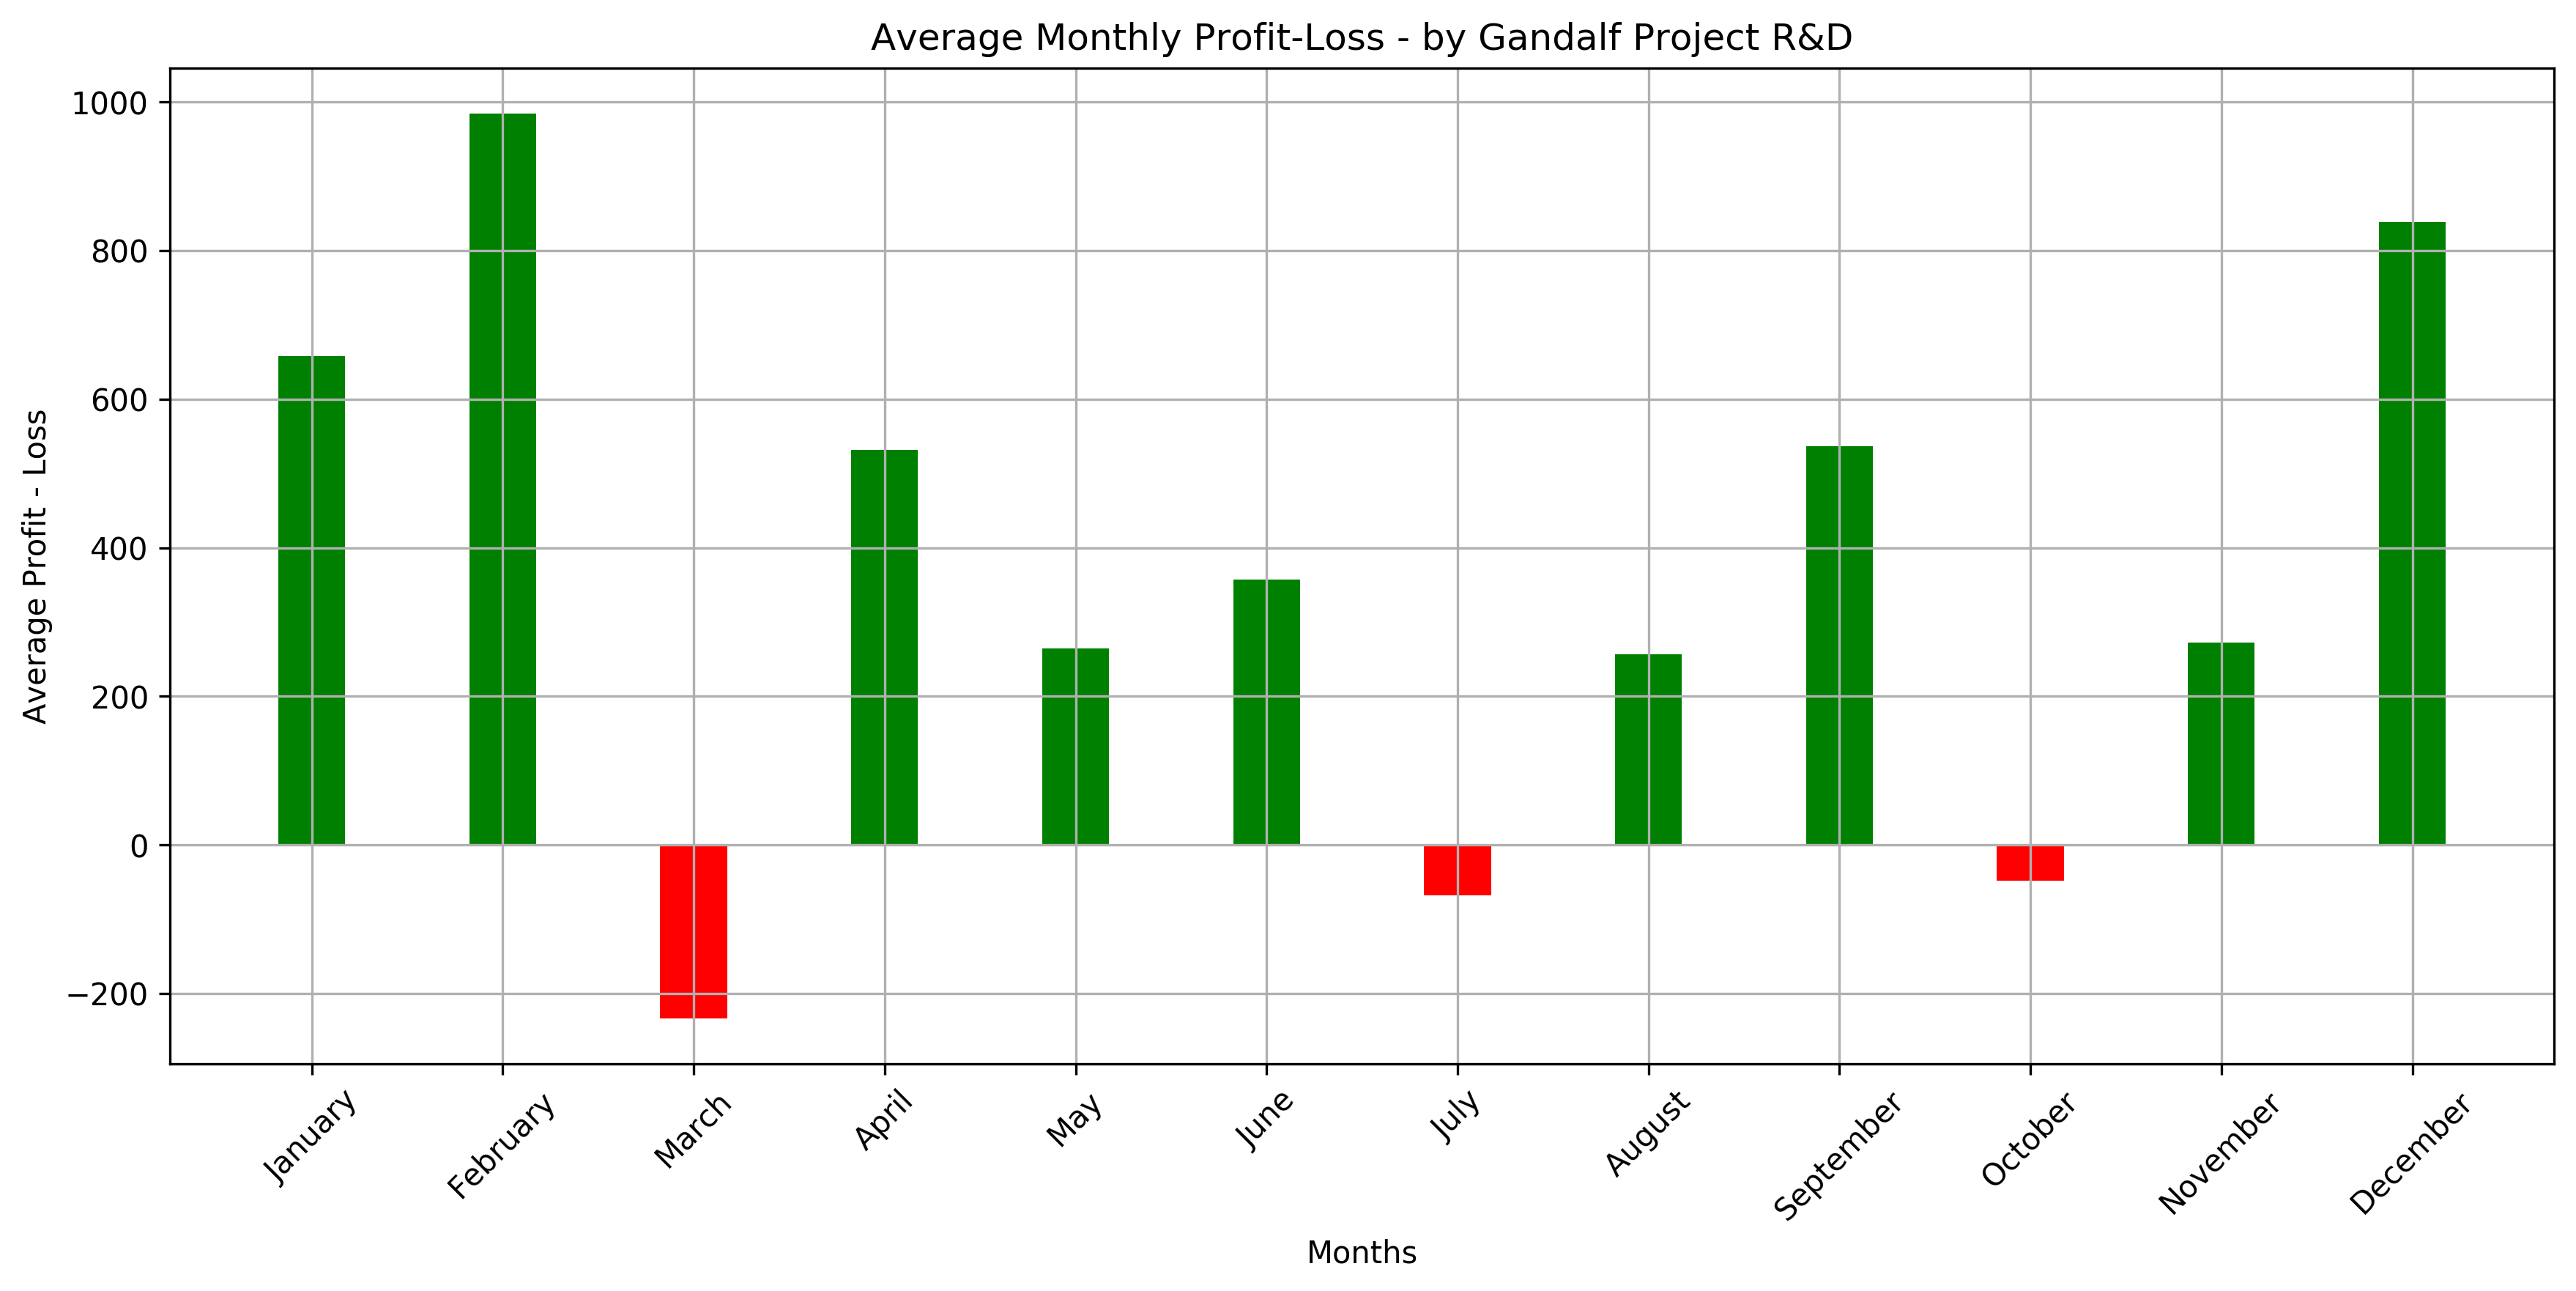

Backtesting ended in: 0:00:23.356692


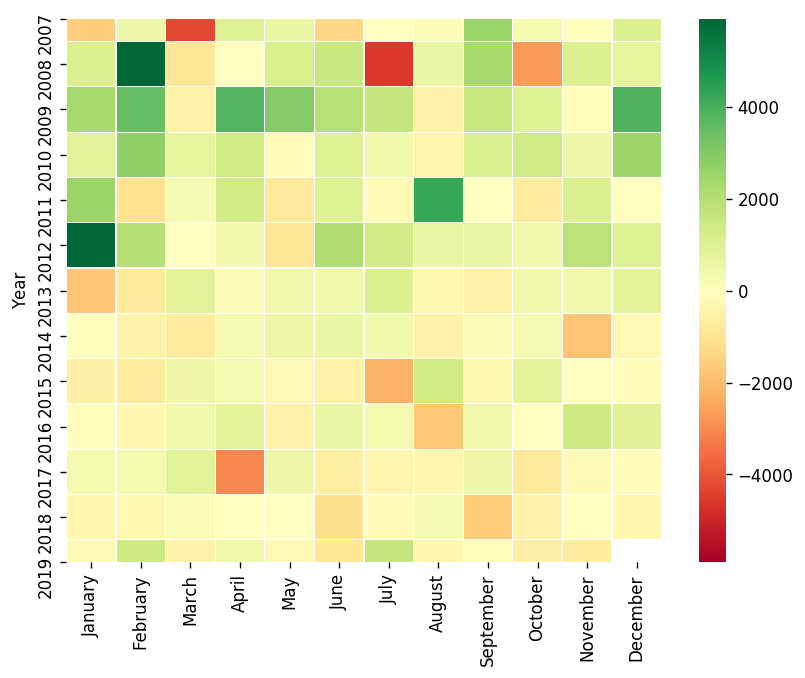

In [21]:
dataset = load_data_intraday("@PL_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.open.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.close.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')

dataset["range1"] = dataset["daily_high1"] - dataset["daily_low1"]
dataset["ORB_UP"] = np.where(dataset.day != dataset.day.shift(1),dataset.open + 0.5 * dataset.range1,np.NaN)
dataset["ORB_UP"] = dataset["ORB_UP"].fillna(method = 'ffill')
dataset["ORB_DOWN"] = np.where(dataset.day != dataset.day.shift(1),dataset.open - 0.5 * dataset.range1,np.NaN)
dataset["ORB_DOWN"] = dataset["ORB_DOWN"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 50
TICK = 0.10
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules = blastoff #dataset.dayofweek == 4
enter_level = dataset.ORB_UP

exit_rules = dataset.day != dataset.day.shift(1)

start = datetime.datetime.now()
print("Backtesting start at:", start)
trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")
    
end = datetime.datetime.now()
print("Backtesting ended in:", end - start)

Backtesting start at: 2019-11-27 18:51:25.182451
Performance Report - by Gandalf Project R&D

Profit:                   64040.0
Operations:               757
Average Trade:            84.6

Profit Factor:            1.25
Gross Profit:             322420.0
Gross Loss:               -258380.0

Percent Winning Trades:   53.24
Percent Losing Trades:    46.76
Reward Risk Ratio:        1.1

Max Gain:                 4440.0  in date  2013-08-28 00:00:00
Average Gain:             800.05
Max Loss:                 -3510.0  in date  2011-09-22 00:00:00
Average Loss:             -731.95

Avg Open Draw Down:       -3811.07
Max Open Draw Down:       -16870.0

Avg Closed Draw Down:     -3786.99
Max Closed Draw Down:     -14430.0

Avg Delay Between Peaks:  962.59
Max Delay Between Peaks:  65184


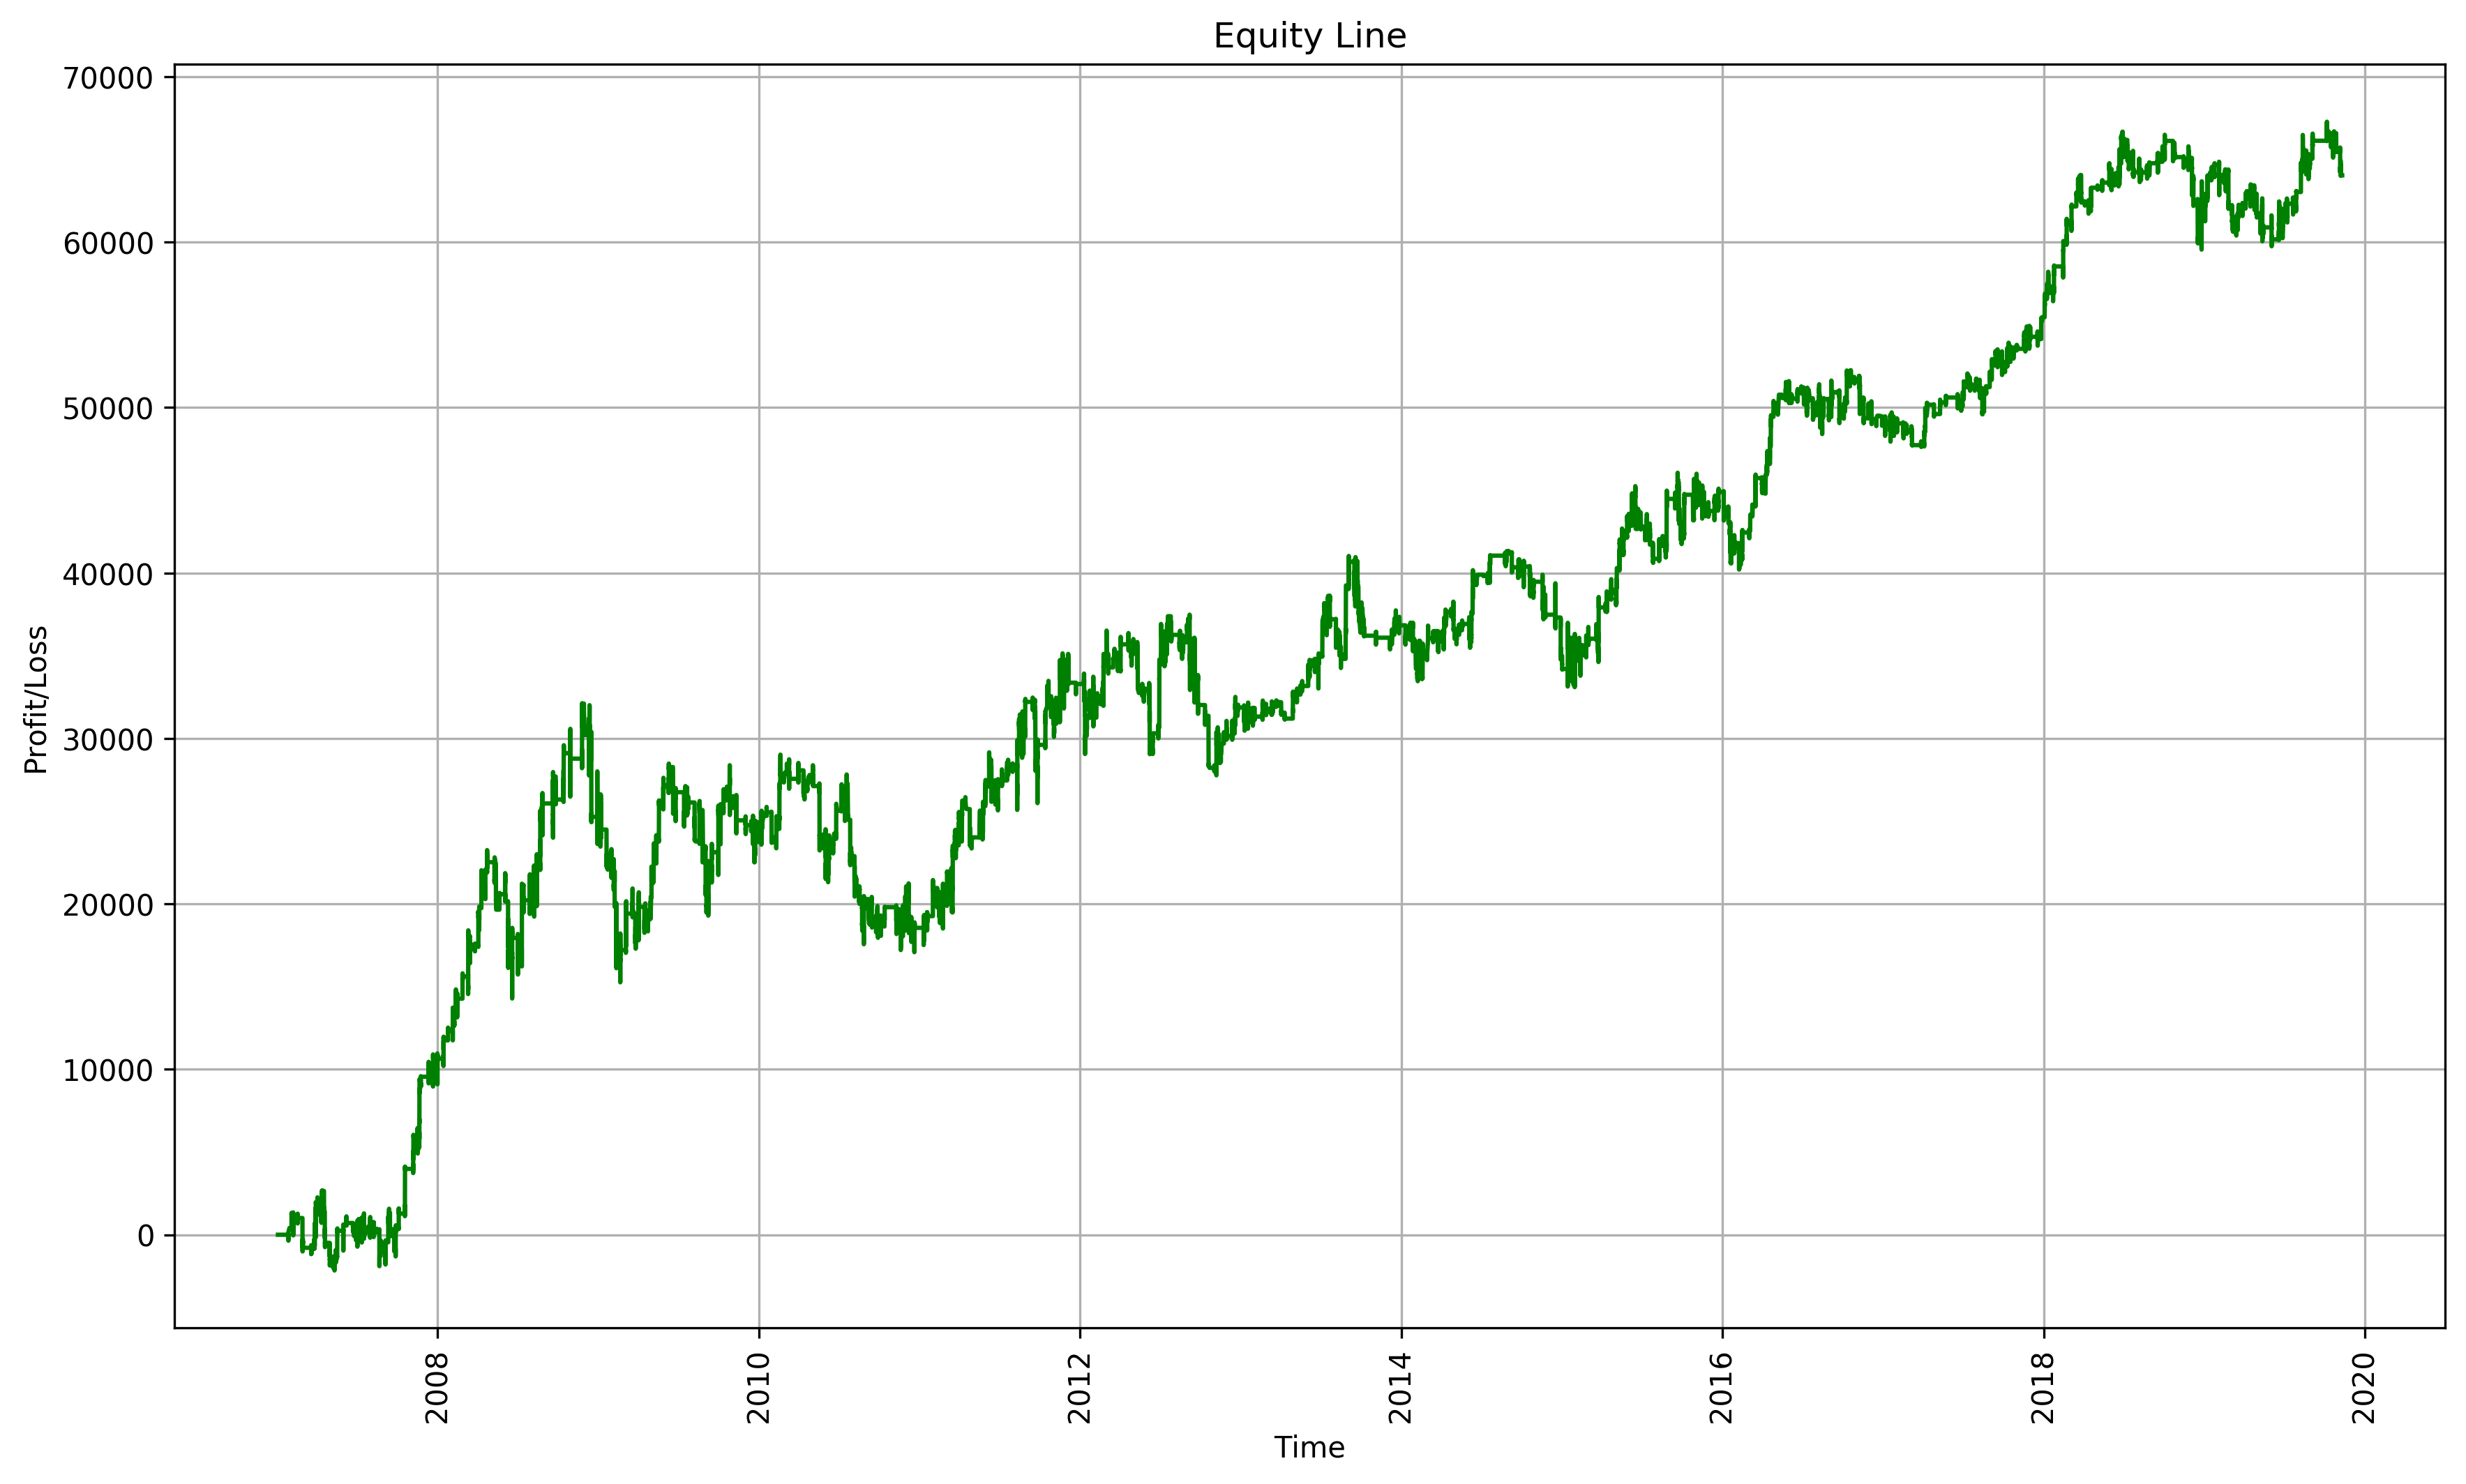

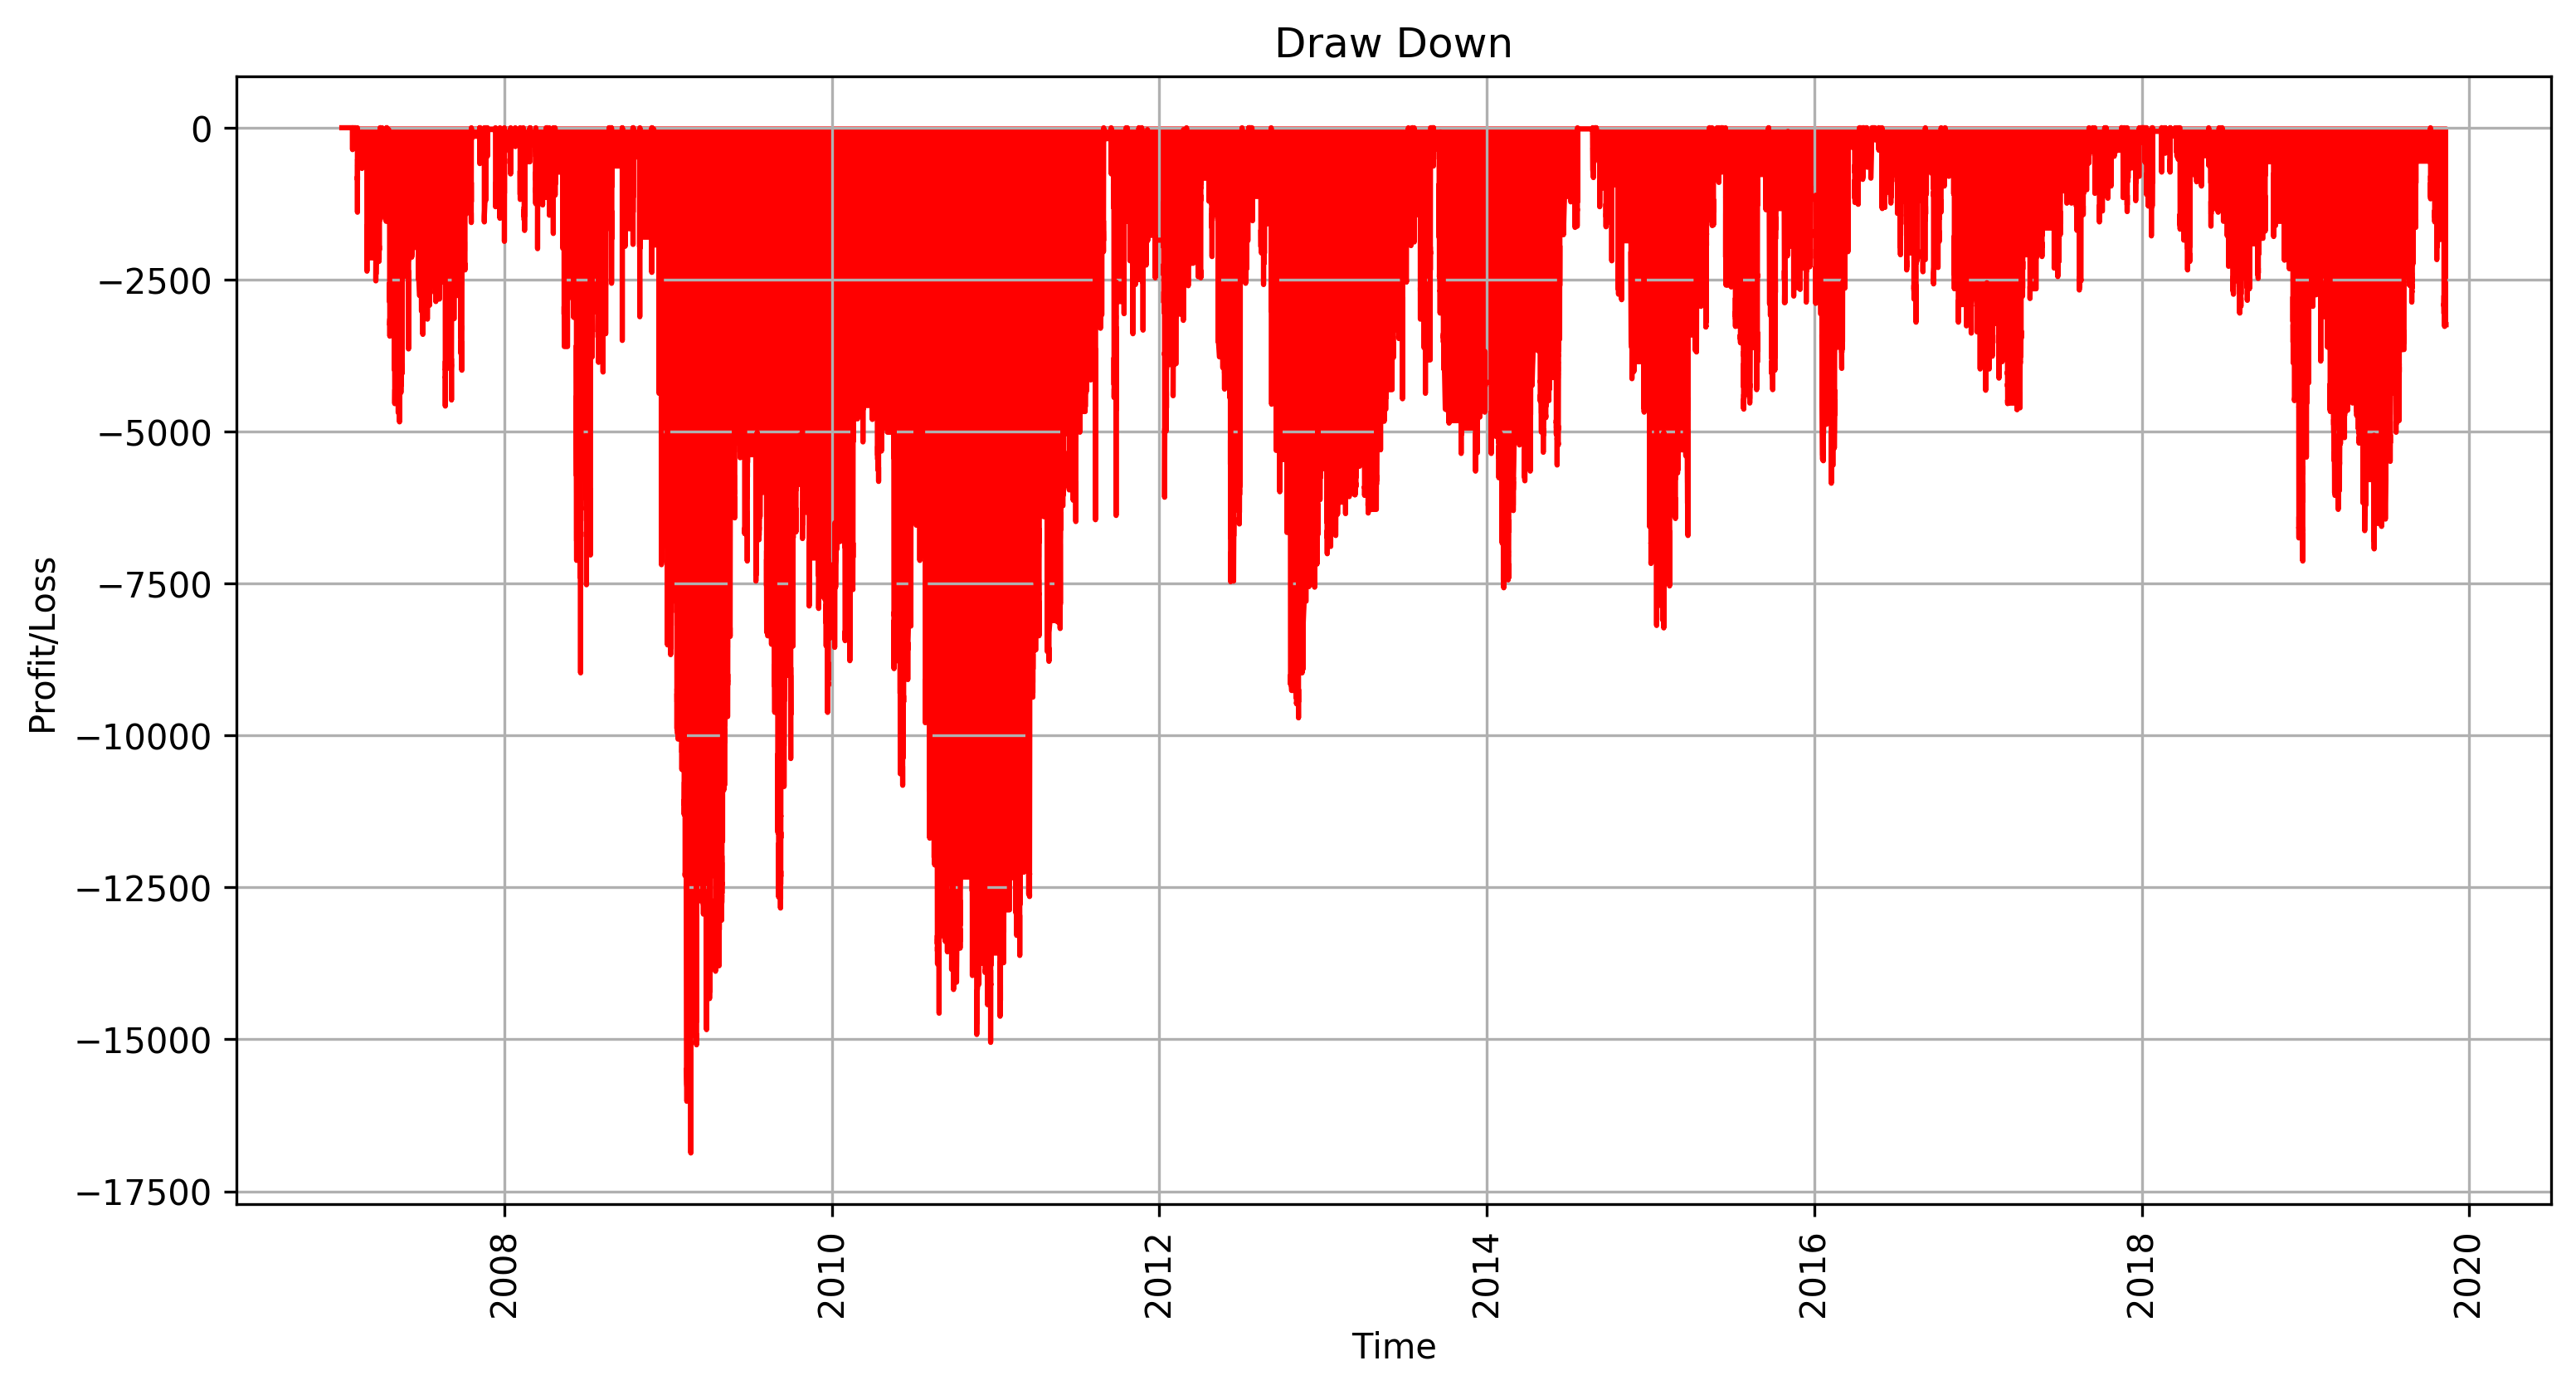

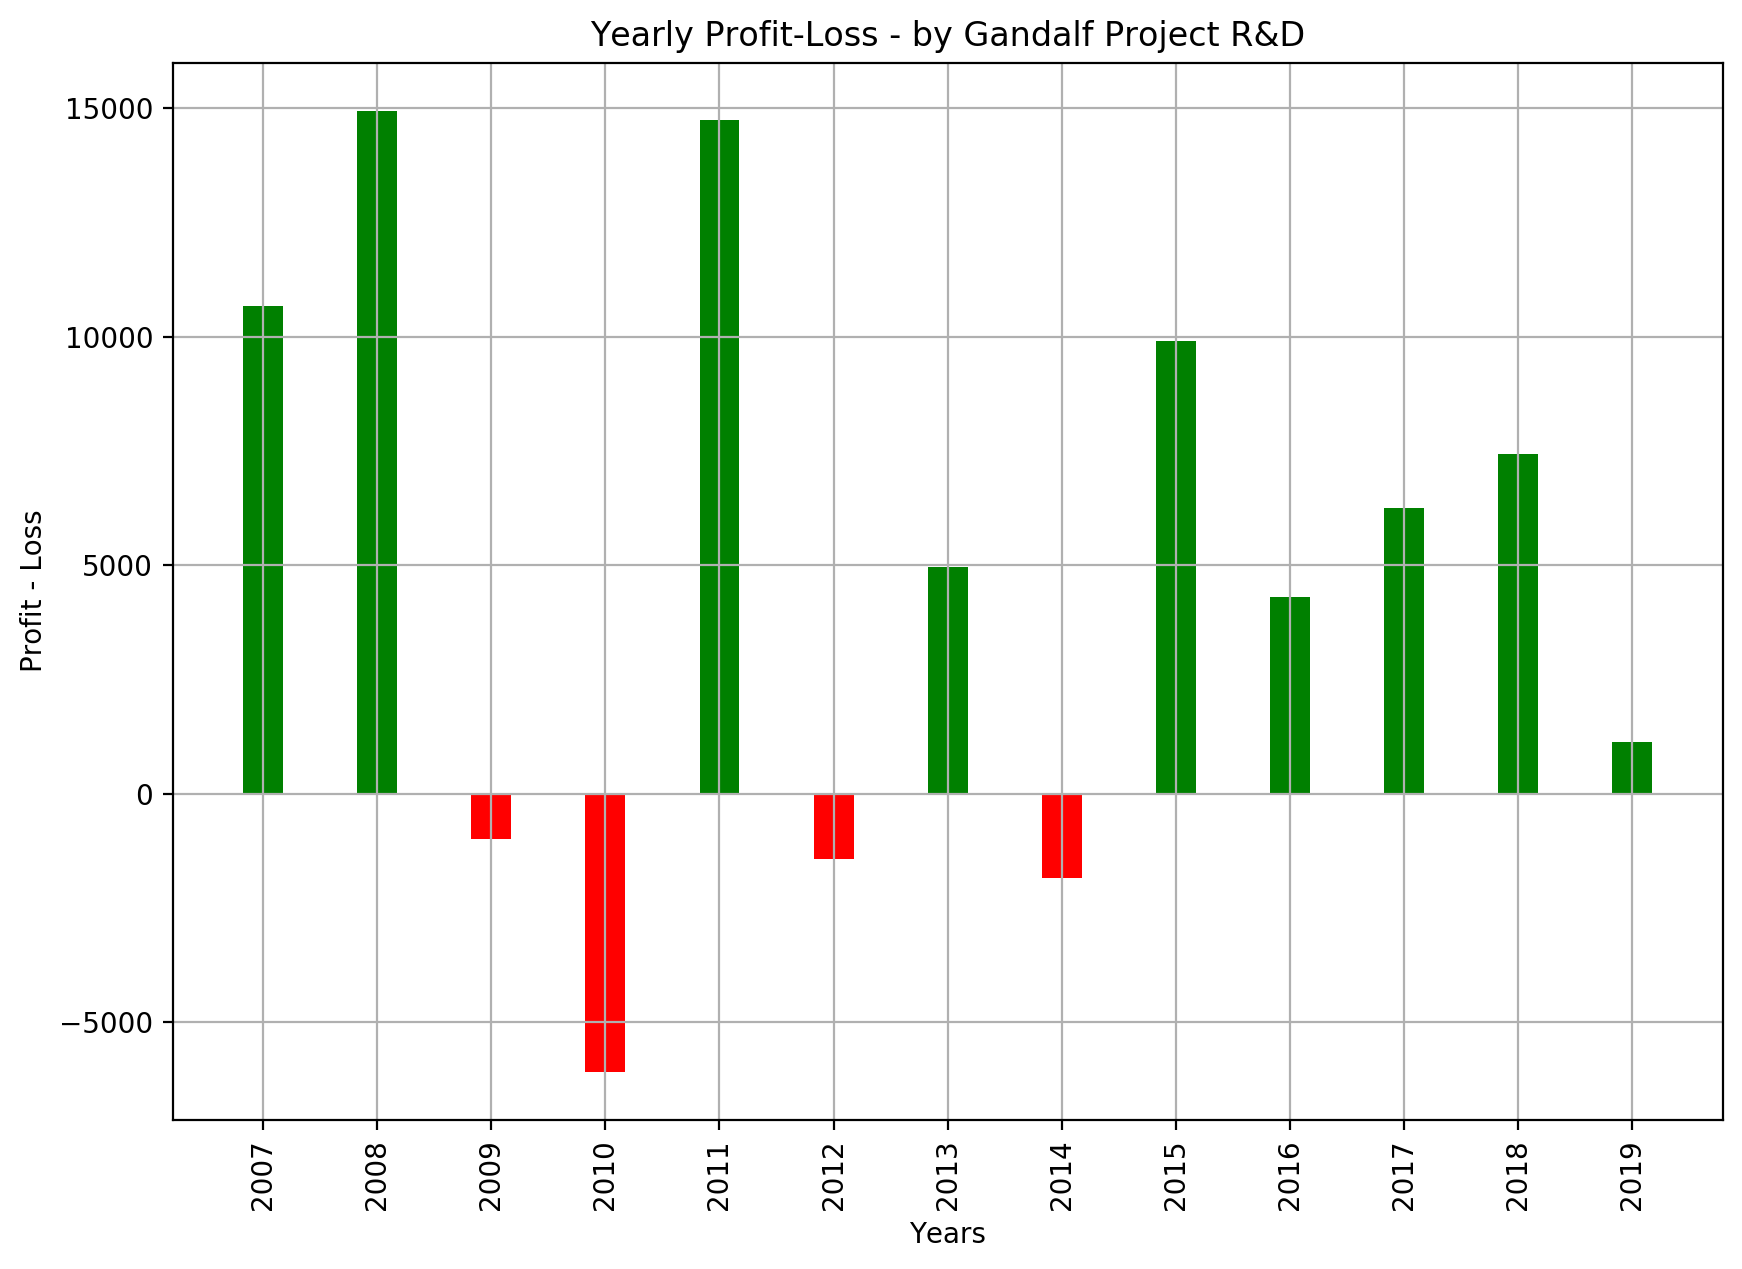

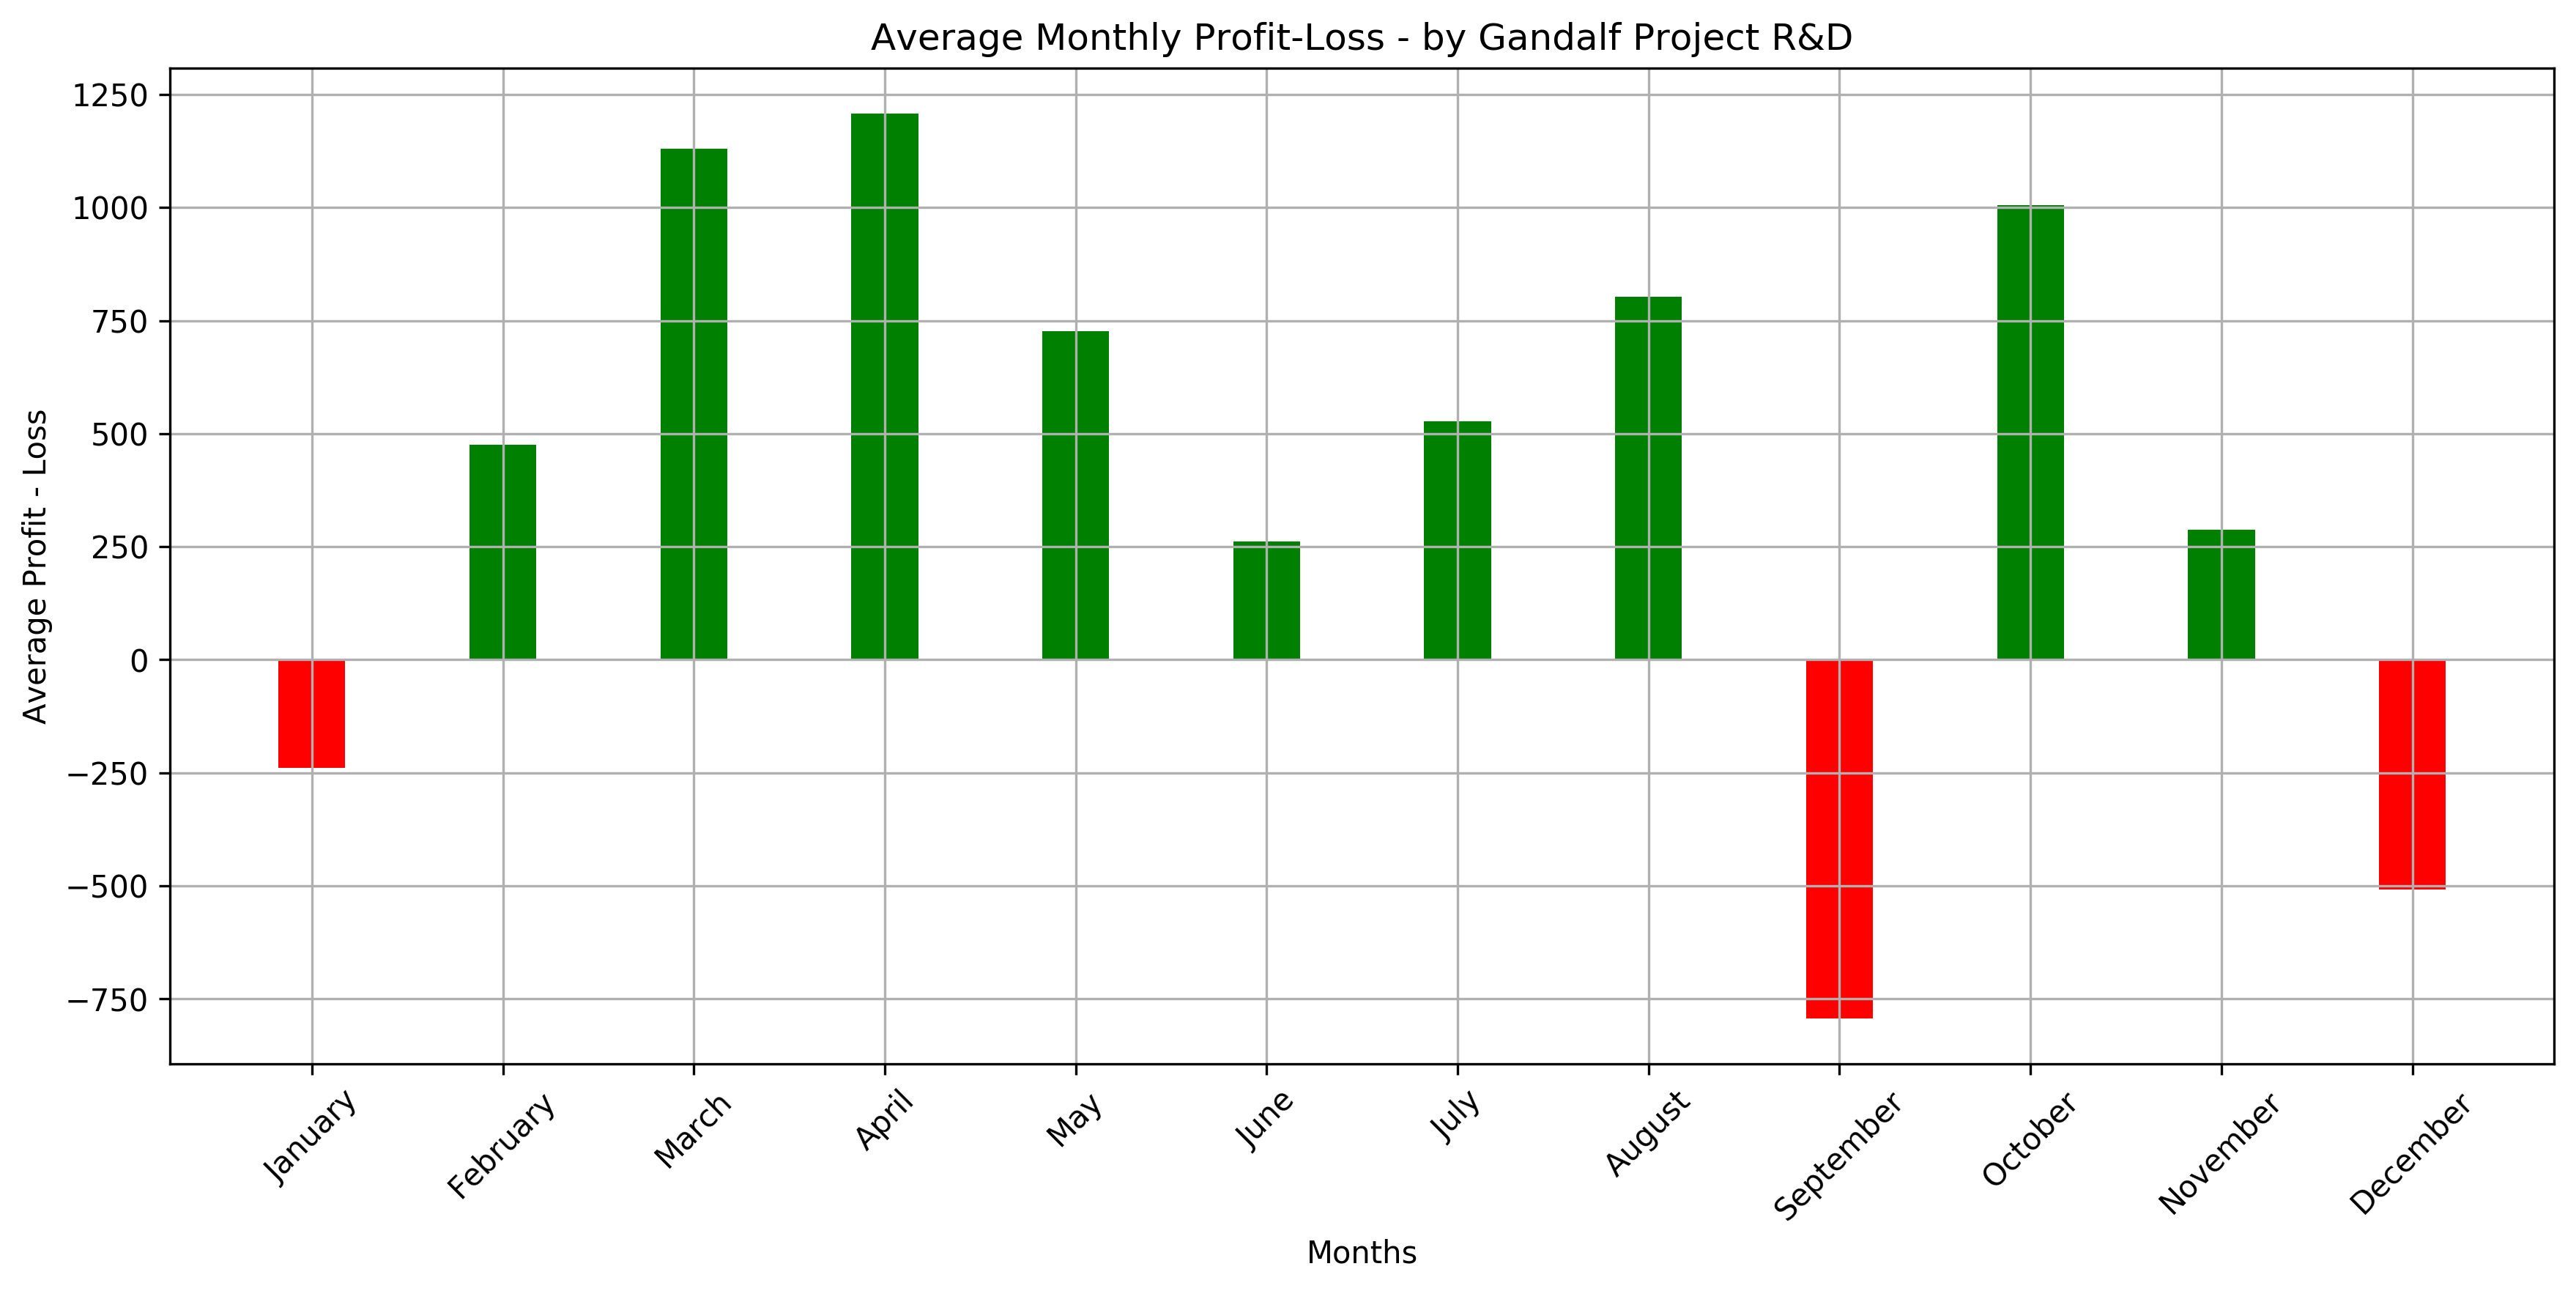

Backtesting ended in: 0:00:22.695184


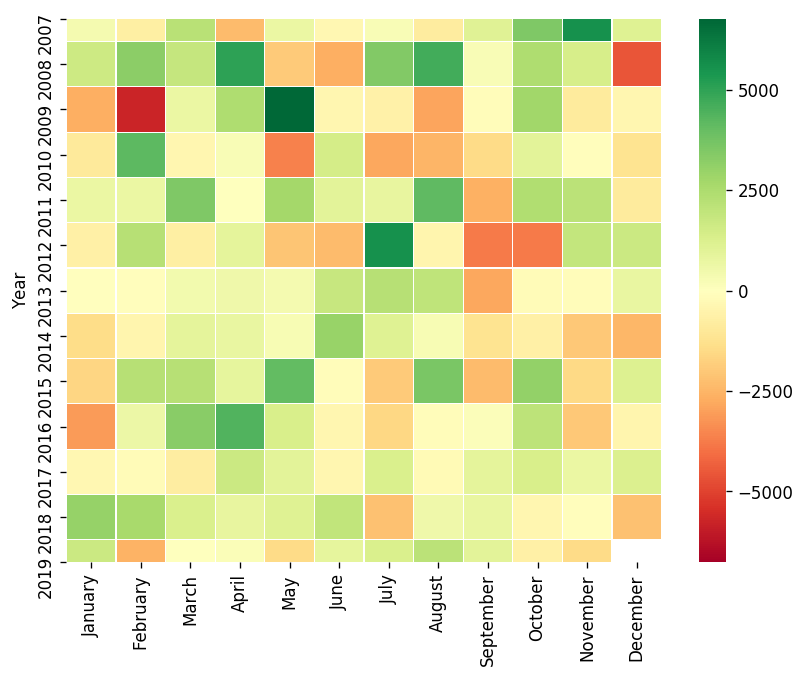

In [23]:
dataset = load_data_intraday("@CL_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.open.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.close.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')

dataset["range1"] = dataset["daily_high1"] - dataset["daily_low1"]
dataset["ORB_UP"] = np.where(dataset.day != dataset.day.shift(1),dataset.open + 0.5 * dataset.range1,np.NaN)
dataset["ORB_UP"] = dataset["ORB_UP"].fillna(method = 'ffill')
dataset["ORB_DOWN"] = np.where(dataset.day != dataset.day.shift(1),dataset.open - 0.5 * dataset.range1,np.NaN)
dataset["ORB_DOWN"] = dataset["ORB_DOWN"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 1000
TICK = 0.01
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules = blastoff #dataset.dayofweek == 4
enter_level = dataset.ORB_UP

exit_rules = dataset.day != dataset.day.shift(1)

start = datetime.datetime.now()
print("Backtesting start at:", start)
trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")
    
end = datetime.datetime.now()
print("Backtesting ended in:", end - start)

Backtesting start at: 2019-11-27 18:52:20.693685
Performance Report - by Gandalf Project R&D

Profit:                   75210.0
Operations:               754
Average Trade:            99.75

Profit Factor:            1.27
Gross Profit:             353150.0
Gross Loss:               -277940.0

Percent Winning Trades:   53.32
Percent Losing Trades:    46.68
Reward Risk Ratio:        1.11

Max Gain:                 6580.0  in date  2008-09-16 00:00:00
Average Gain:             878.48
Max Loss:                 -4850.0  in date  2008-04-03 00:00:00
Average Loss:             -794.11

Avg Open Draw Down:       -6860.36
Max Open Draw Down:       -23580.0

Avg Closed Draw Down:     -7163.42
Max Closed Draw Down:     -22160.0

Avg Delay Between Peaks:  931.25
Max Delay Between Peaks:  105647


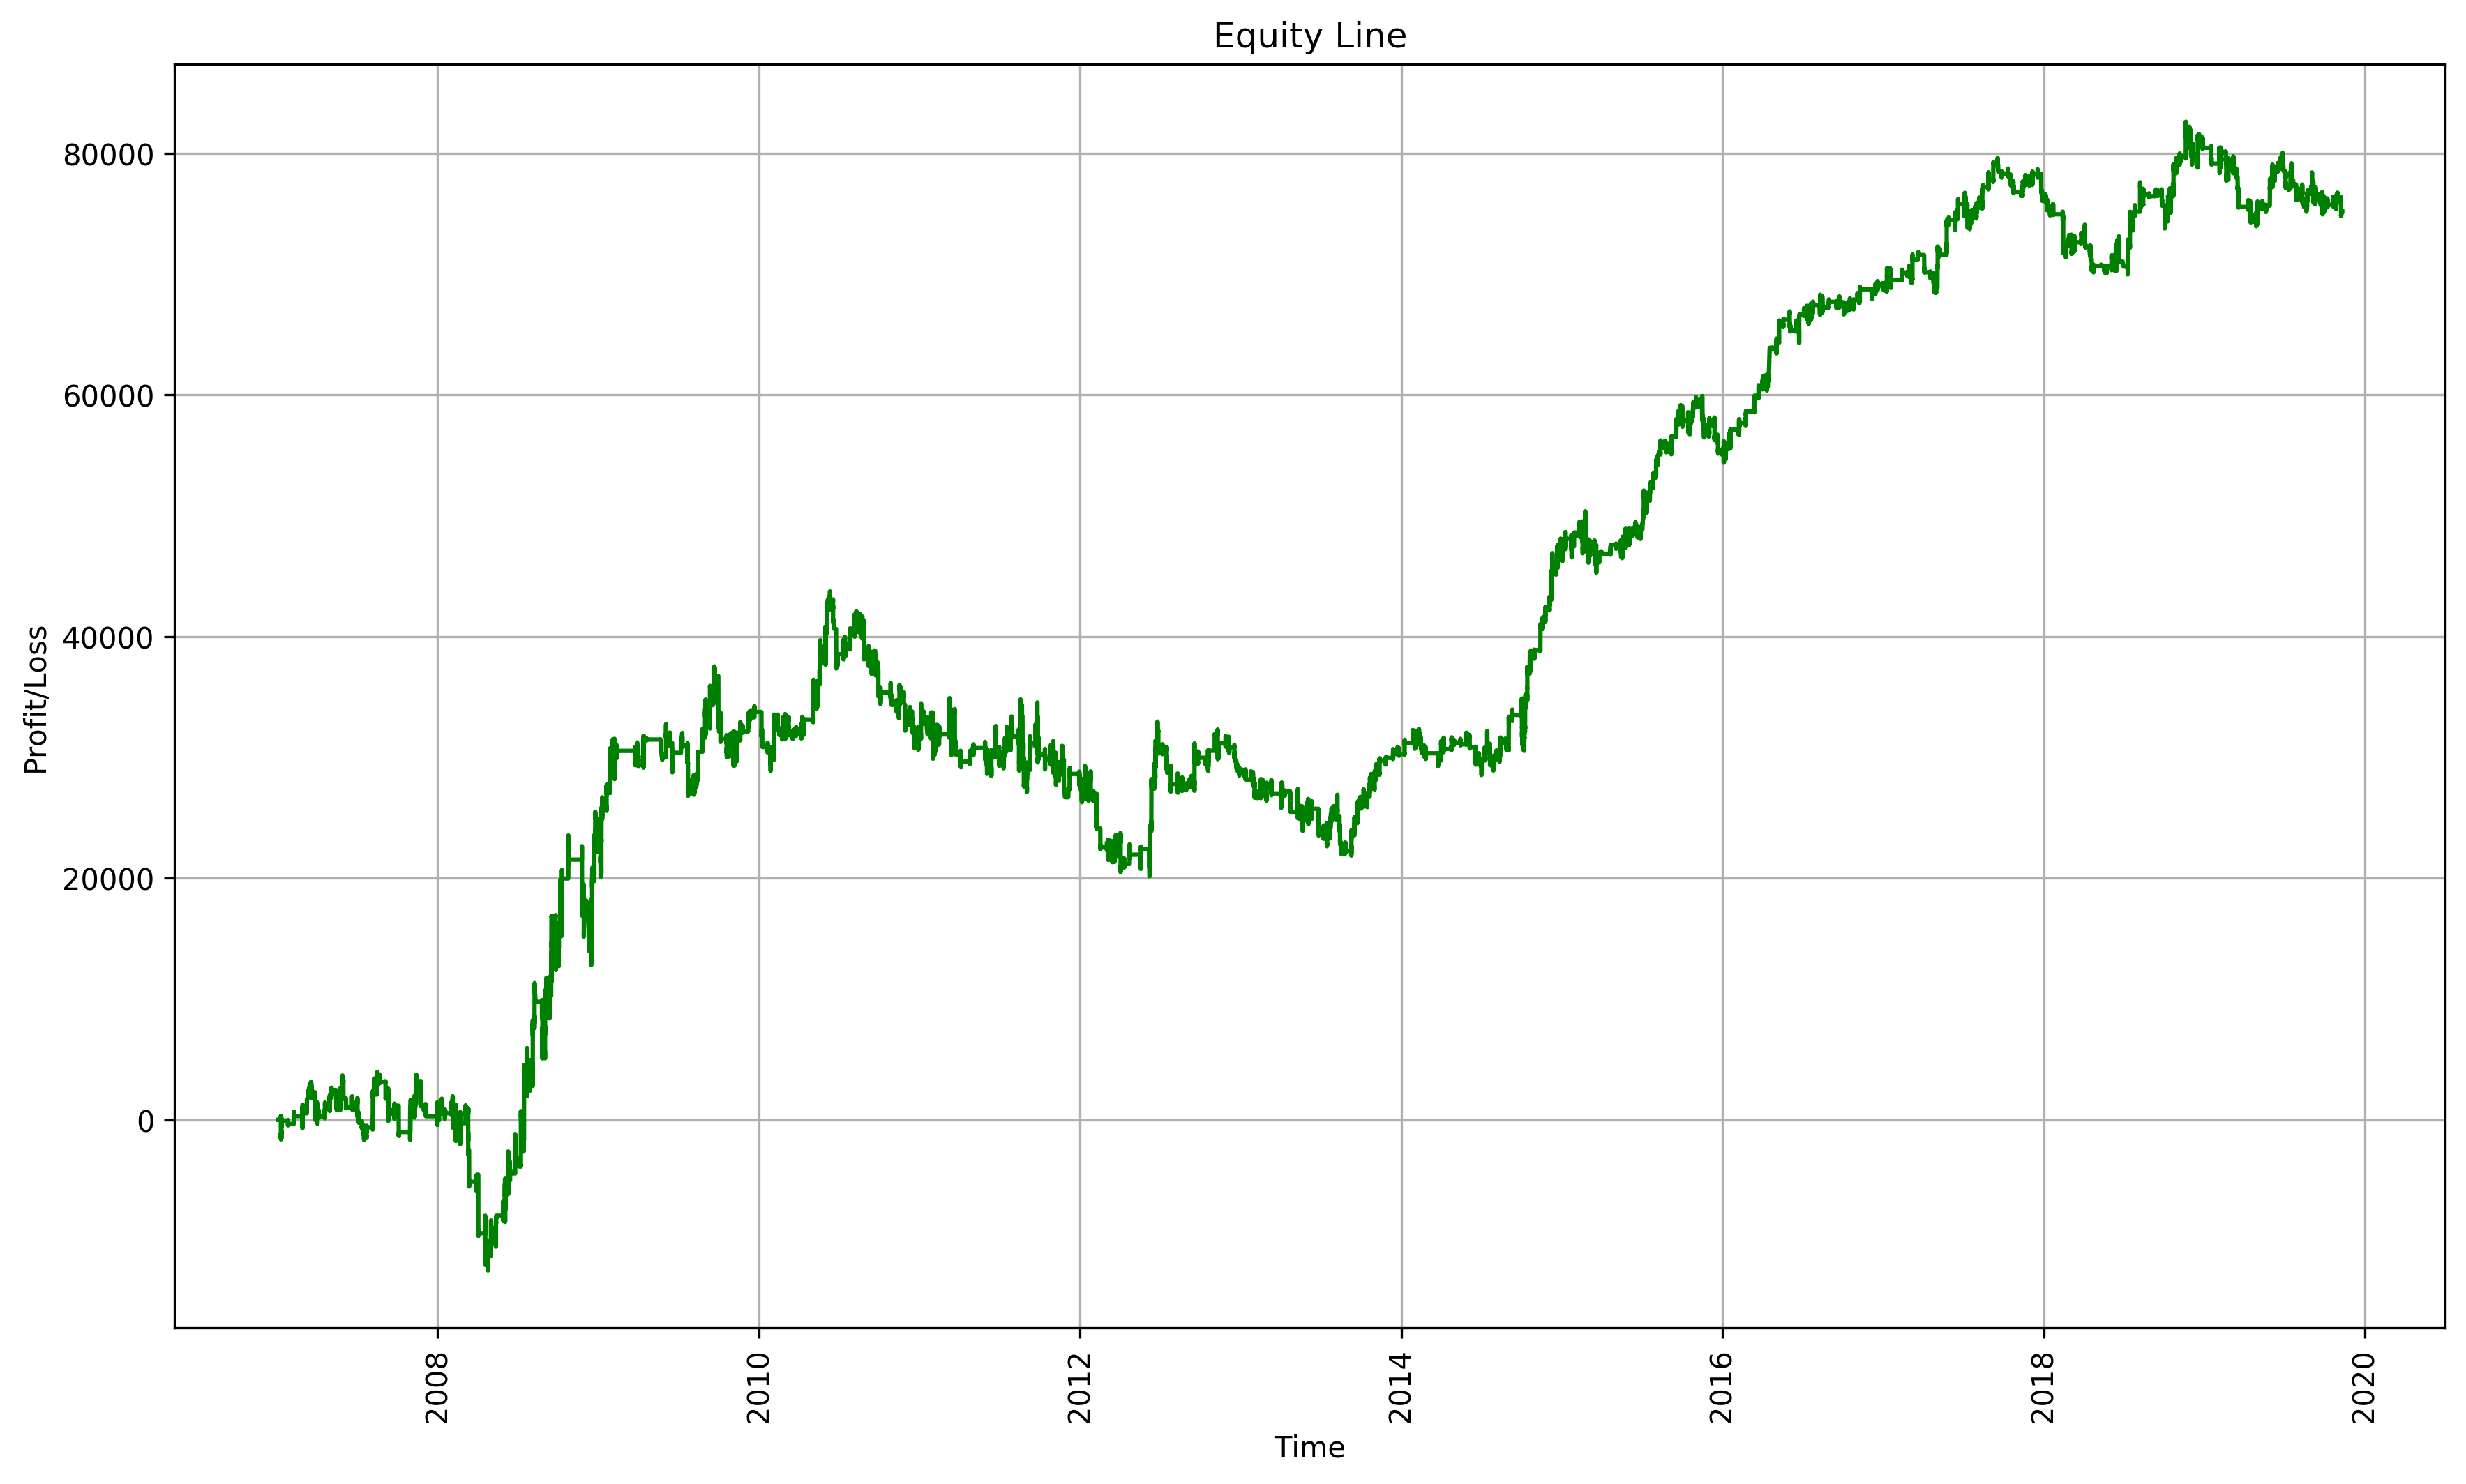

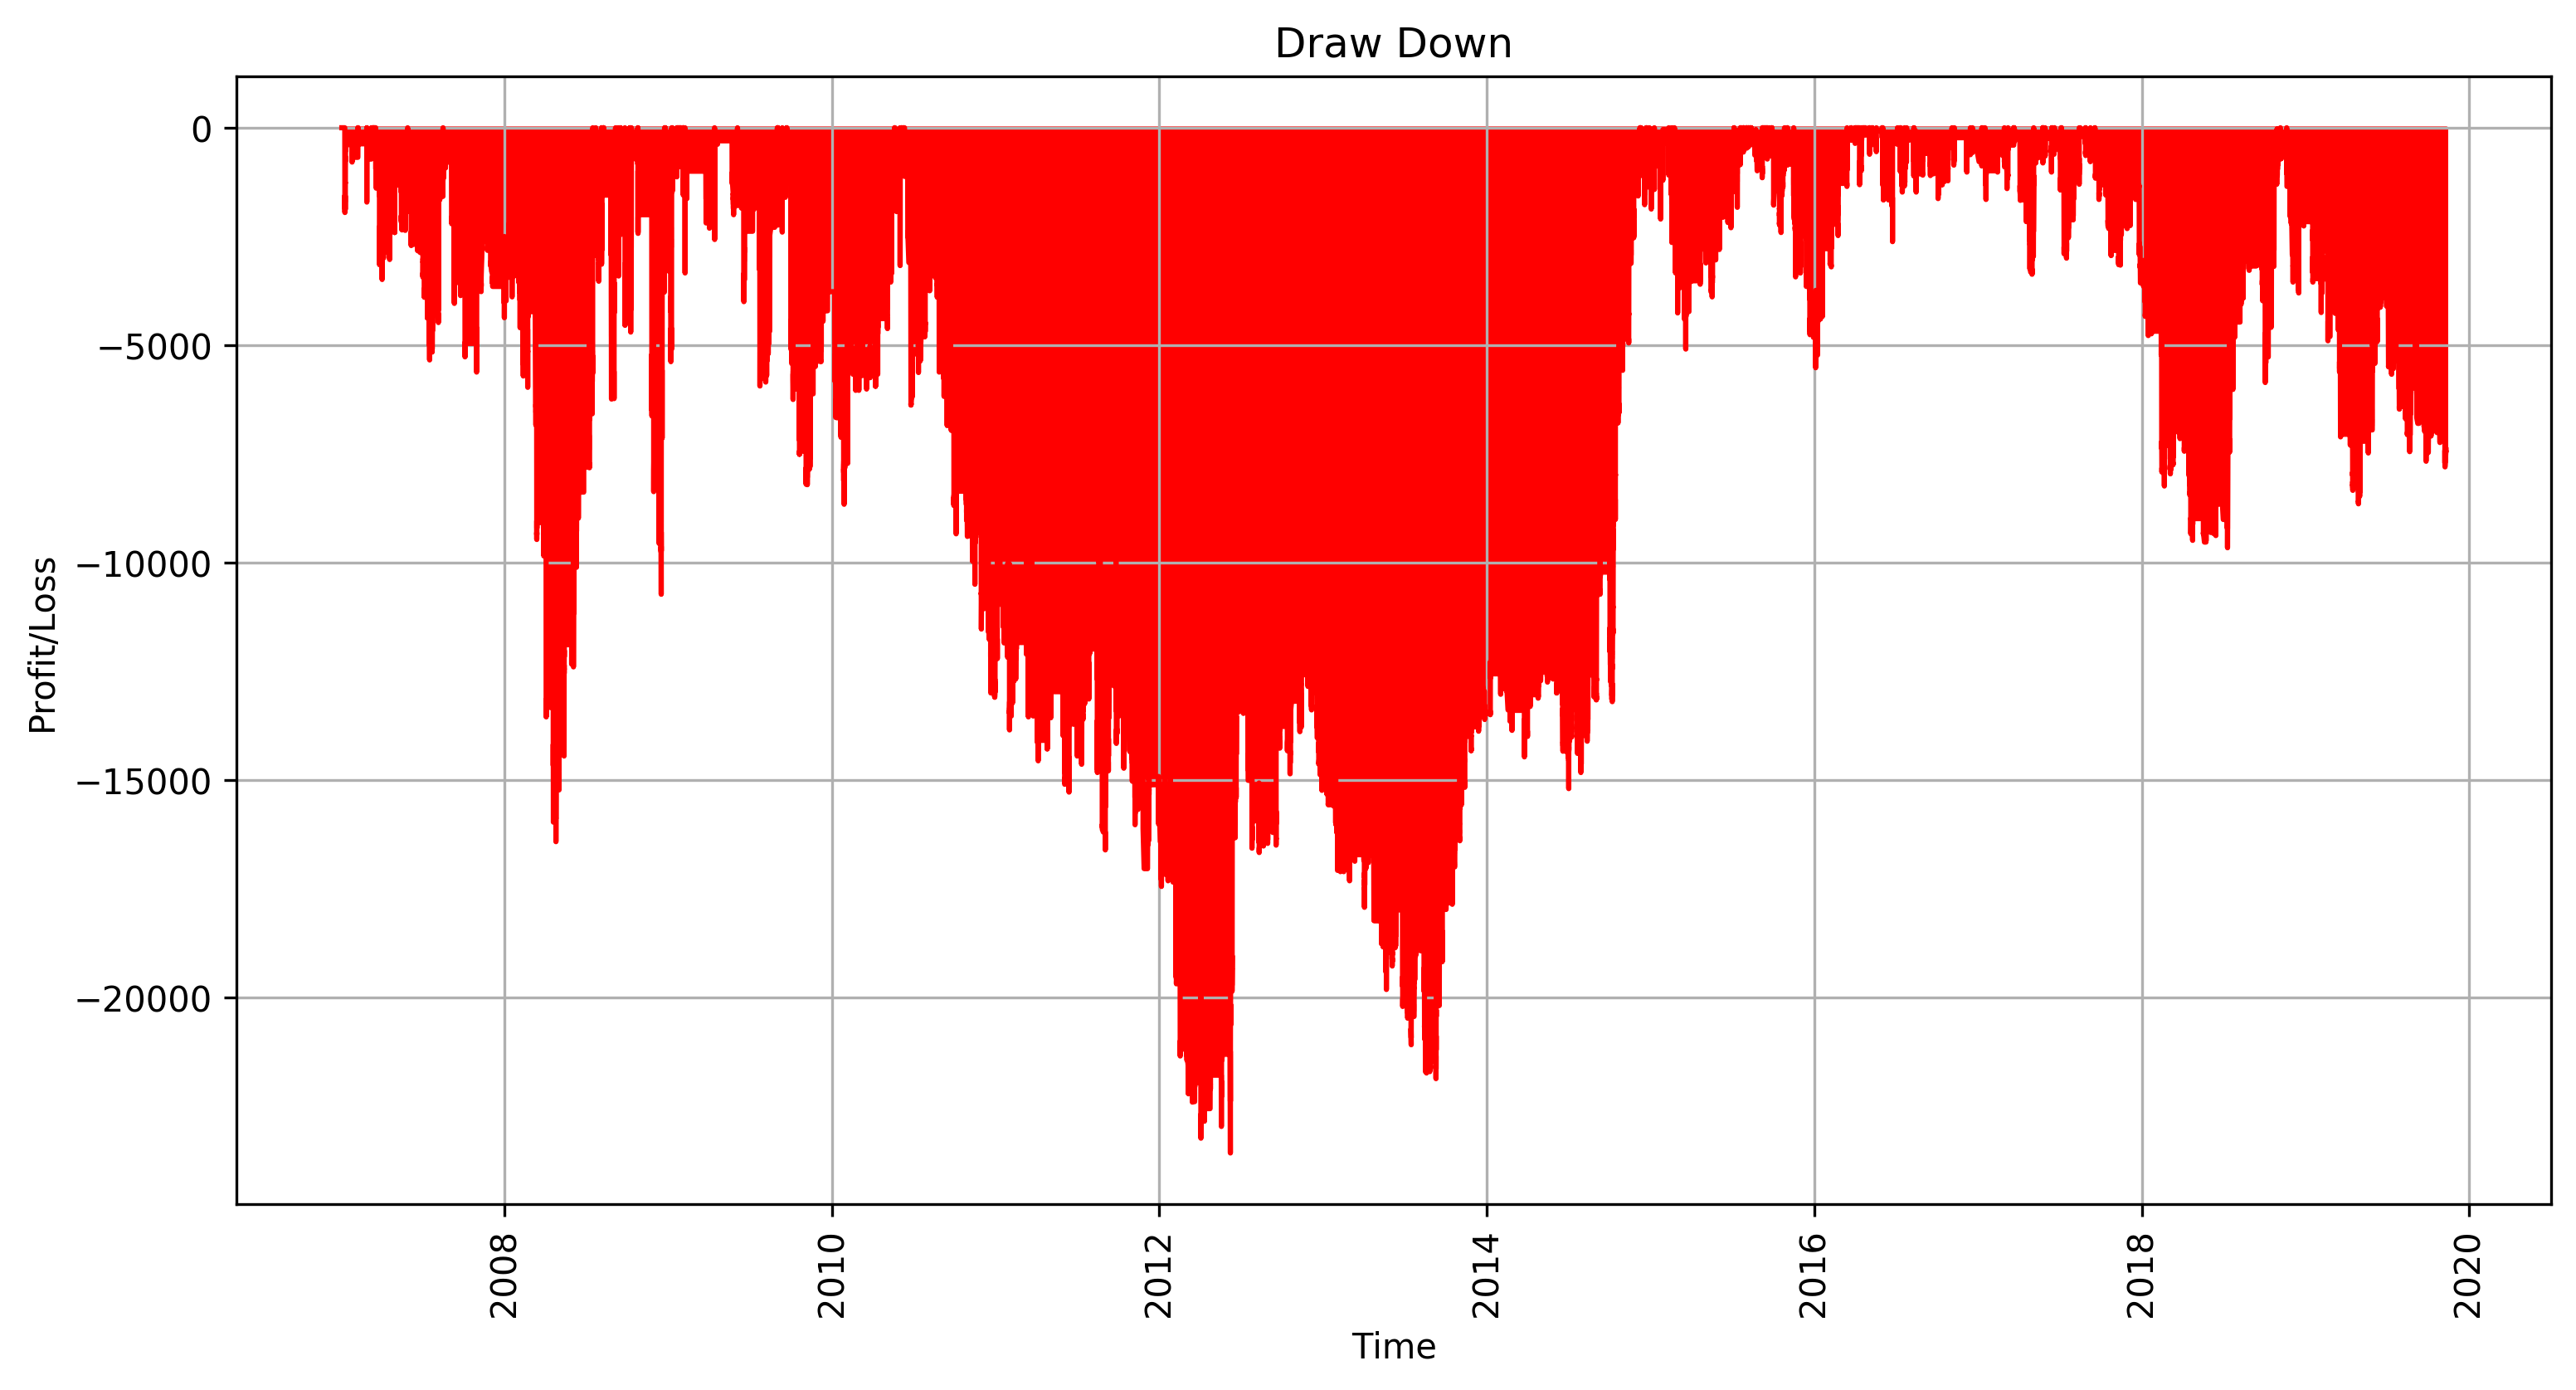

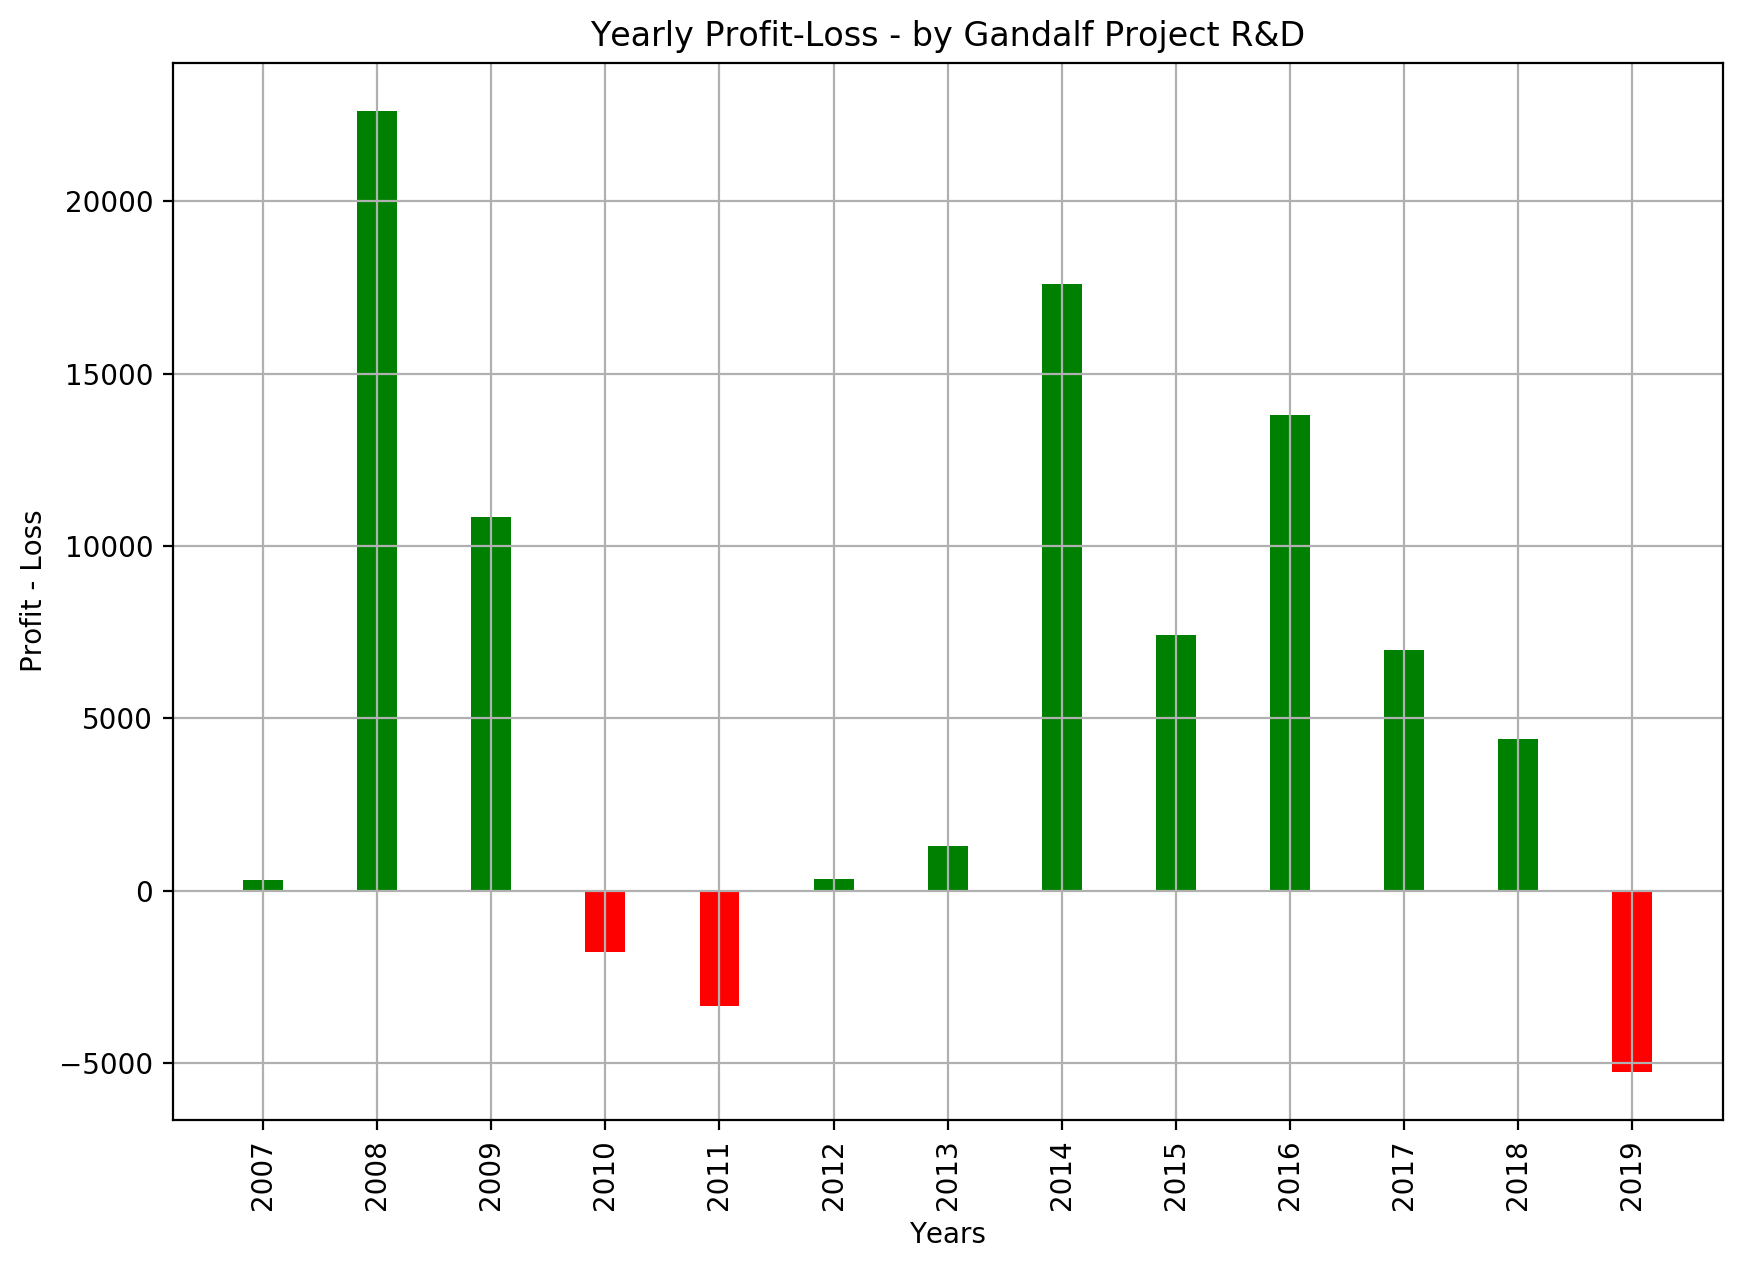

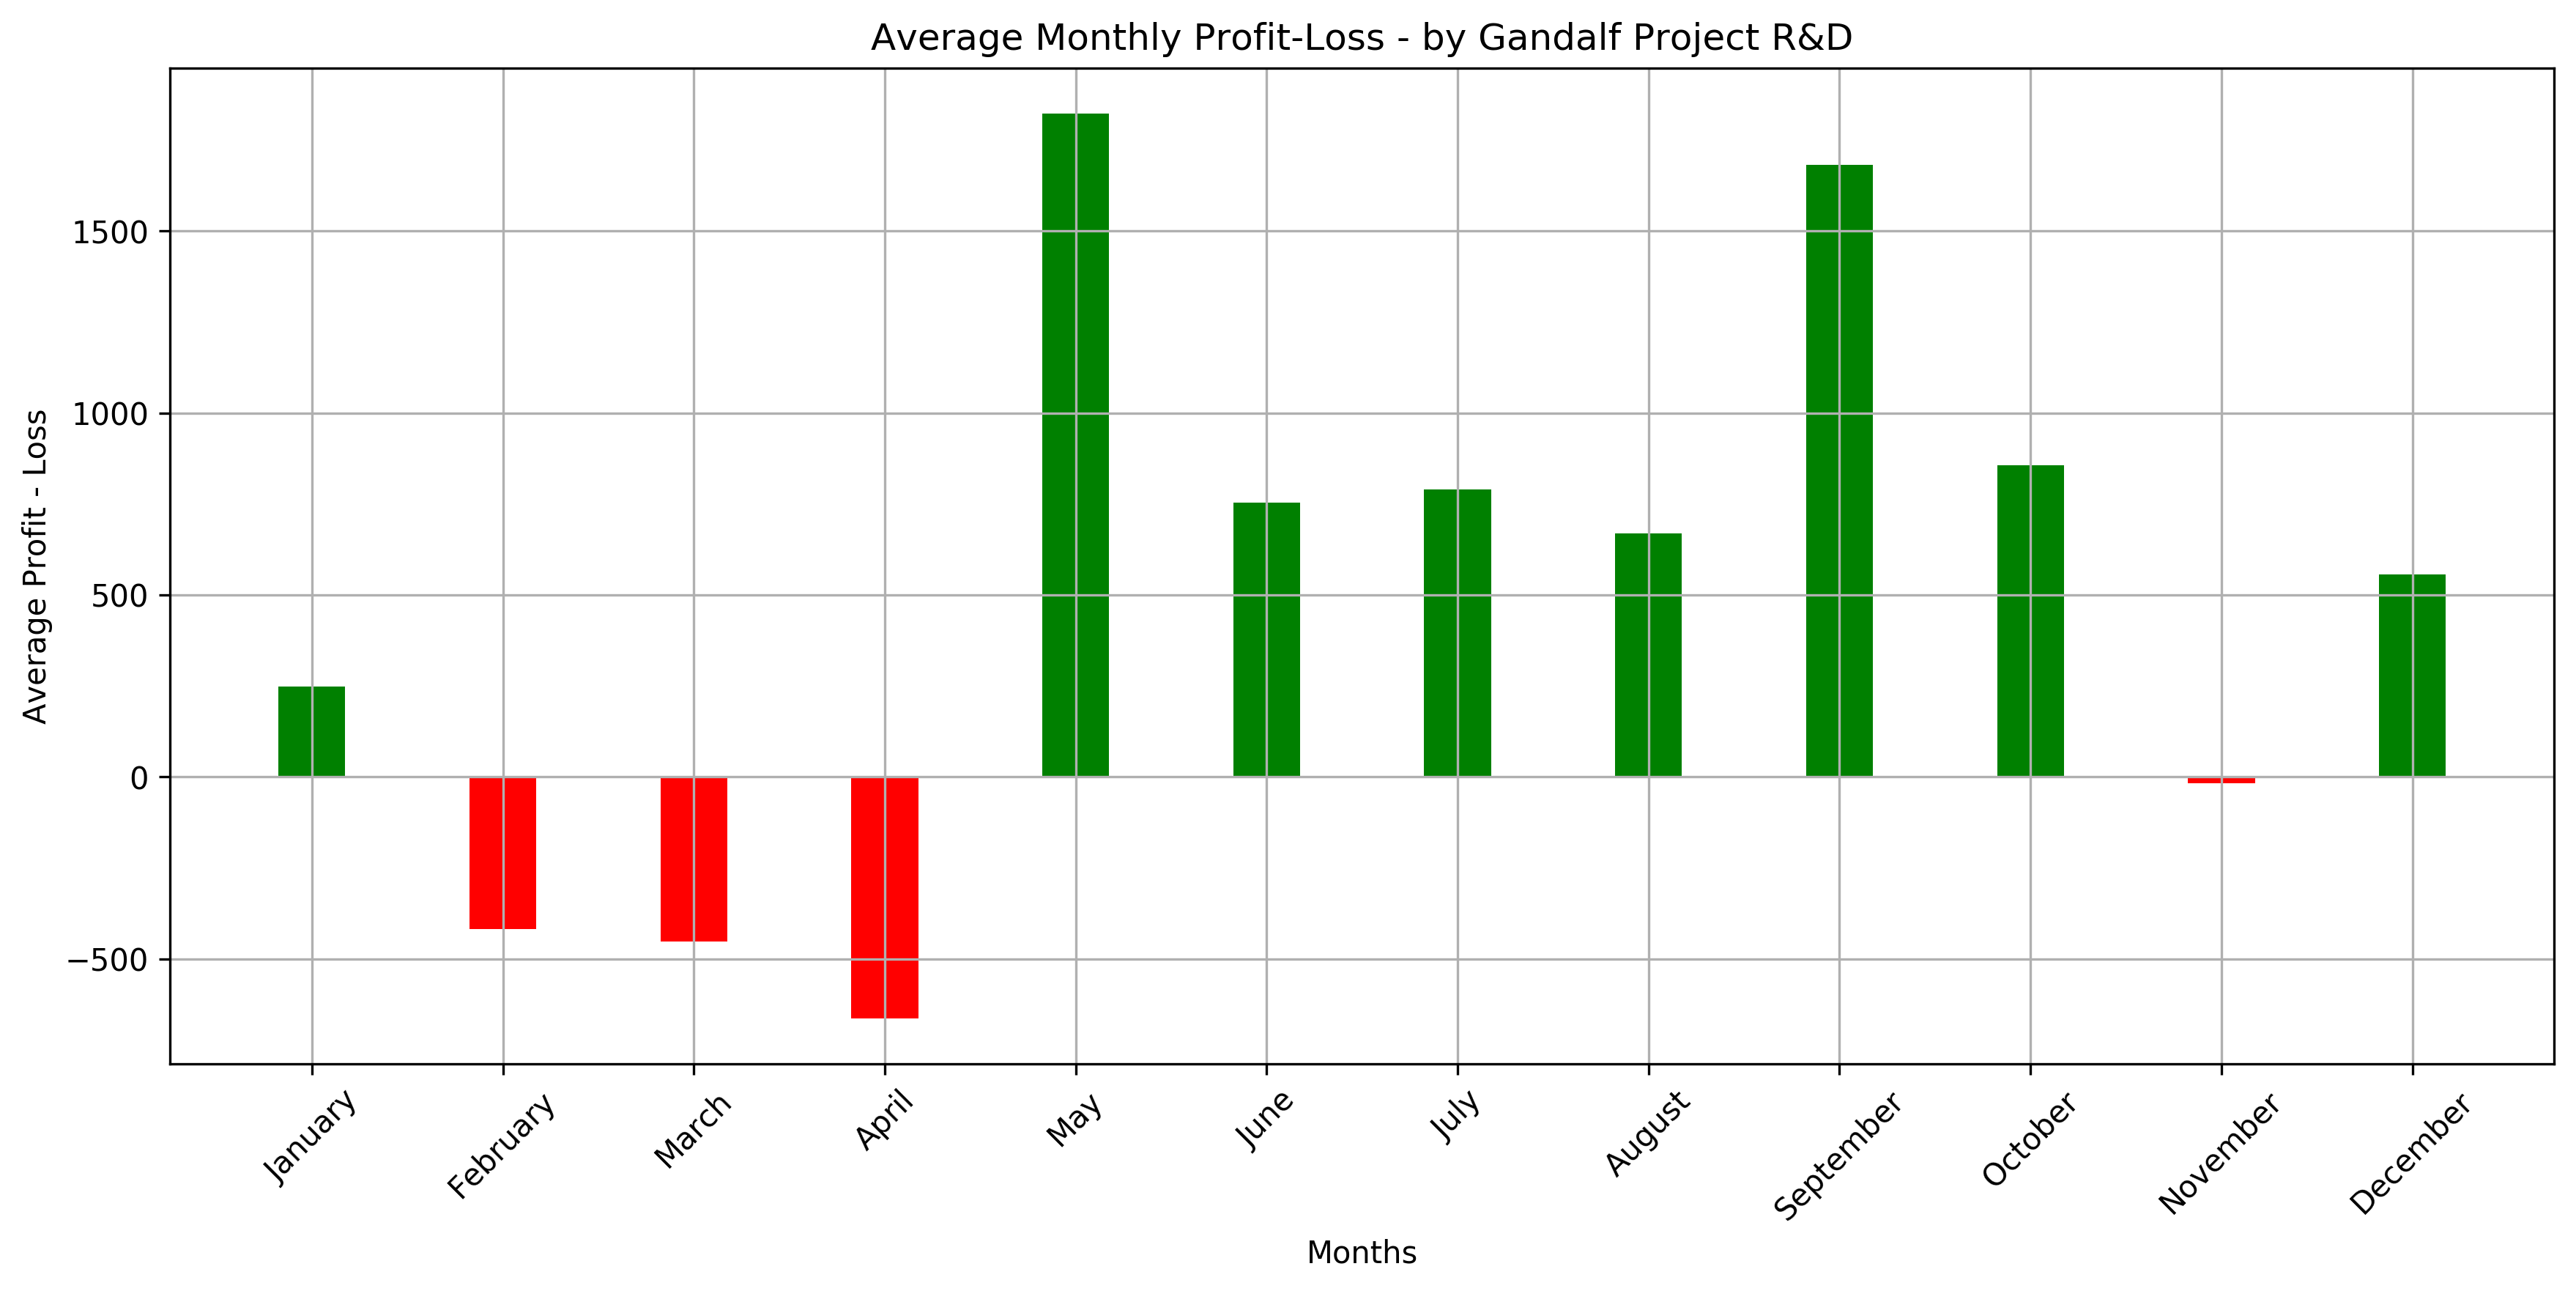

Backtesting ended in: 0:00:22.676406


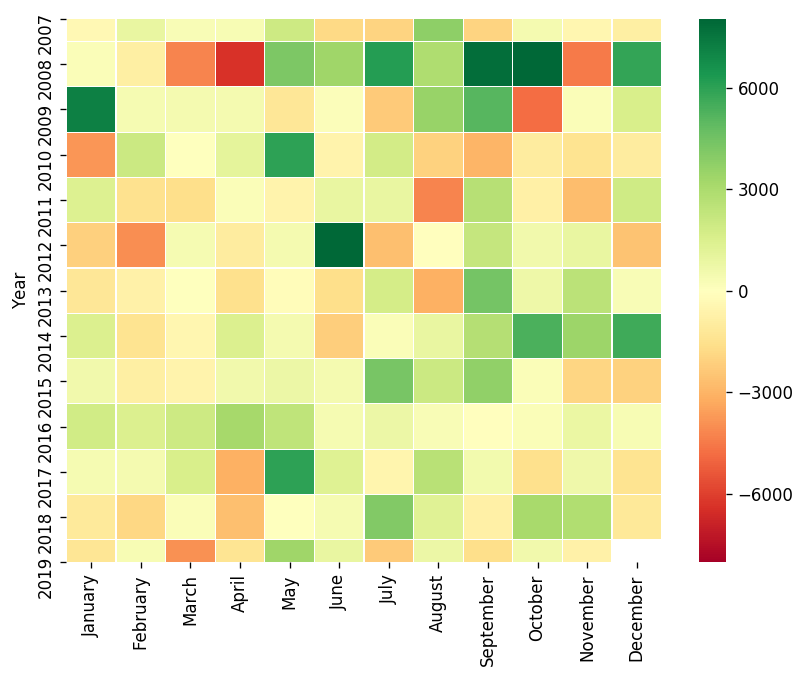

In [24]:
dataset = load_data_intraday("@CL_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.open.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.close.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')

dataset["range1"] = dataset["daily_high1"] - dataset["daily_low1"]
dataset["ORB_UP"] = np.where(dataset.day != dataset.day.shift(1),dataset.open + 0.5 * dataset.range1,np.NaN)
dataset["ORB_UP"] = dataset["ORB_UP"].fillna(method = 'ffill')
dataset["ORB_DOWN"] = np.where(dataset.day != dataset.day.shift(1),dataset.open - 0.5 * dataset.range1,np.NaN)
dataset["ORB_DOWN"] = dataset["ORB_DOWN"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 1000
TICK = 0.01
OPERATION_MONEY = 10000
DIRECTION = "short"
ORDER_TYPE = "stop"

enter_rules = blastoff #dataset.dayofweek == 4
enter_level = dataset.ORB_DOWN

exit_rules = dataset.day != dataset.day.shift(1)

start = datetime.datetime.now()
print("Backtesting start at:", start)
trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")
    
end = datetime.datetime.now()
print("Backtesting ended in:", end - start)

# Gap Filler

Performance Report - by Gandalf Project R&D

Profit:                   17662.5
Operations:               242
Average Trade:            72.99

Profit Factor:            1.64
Gross Profit:             45062.5
Gross Loss:               -27400.0

Percent Winning Trades:   77.27
Percent Losing Trades:    22.730000000000004
Reward Risk Ratio:        0.48

Max Gain:                 1175.0  in date  2008-10-23 09:45:00
Average Gain:             240.98
Max Loss:                 -2000.0  in date  2007-08-03 15:00:00
Average Loss:             -507.41

Avg Open Draw Down:       -1289.67
Max Open Draw Down:       -5187.5

Avg Closed Draw Down:     -1304.88
Max Closed Draw Down:     -5125.0

Avg Delay Between Peaks:  1220.35
Max Delay Between Peaks:  32423


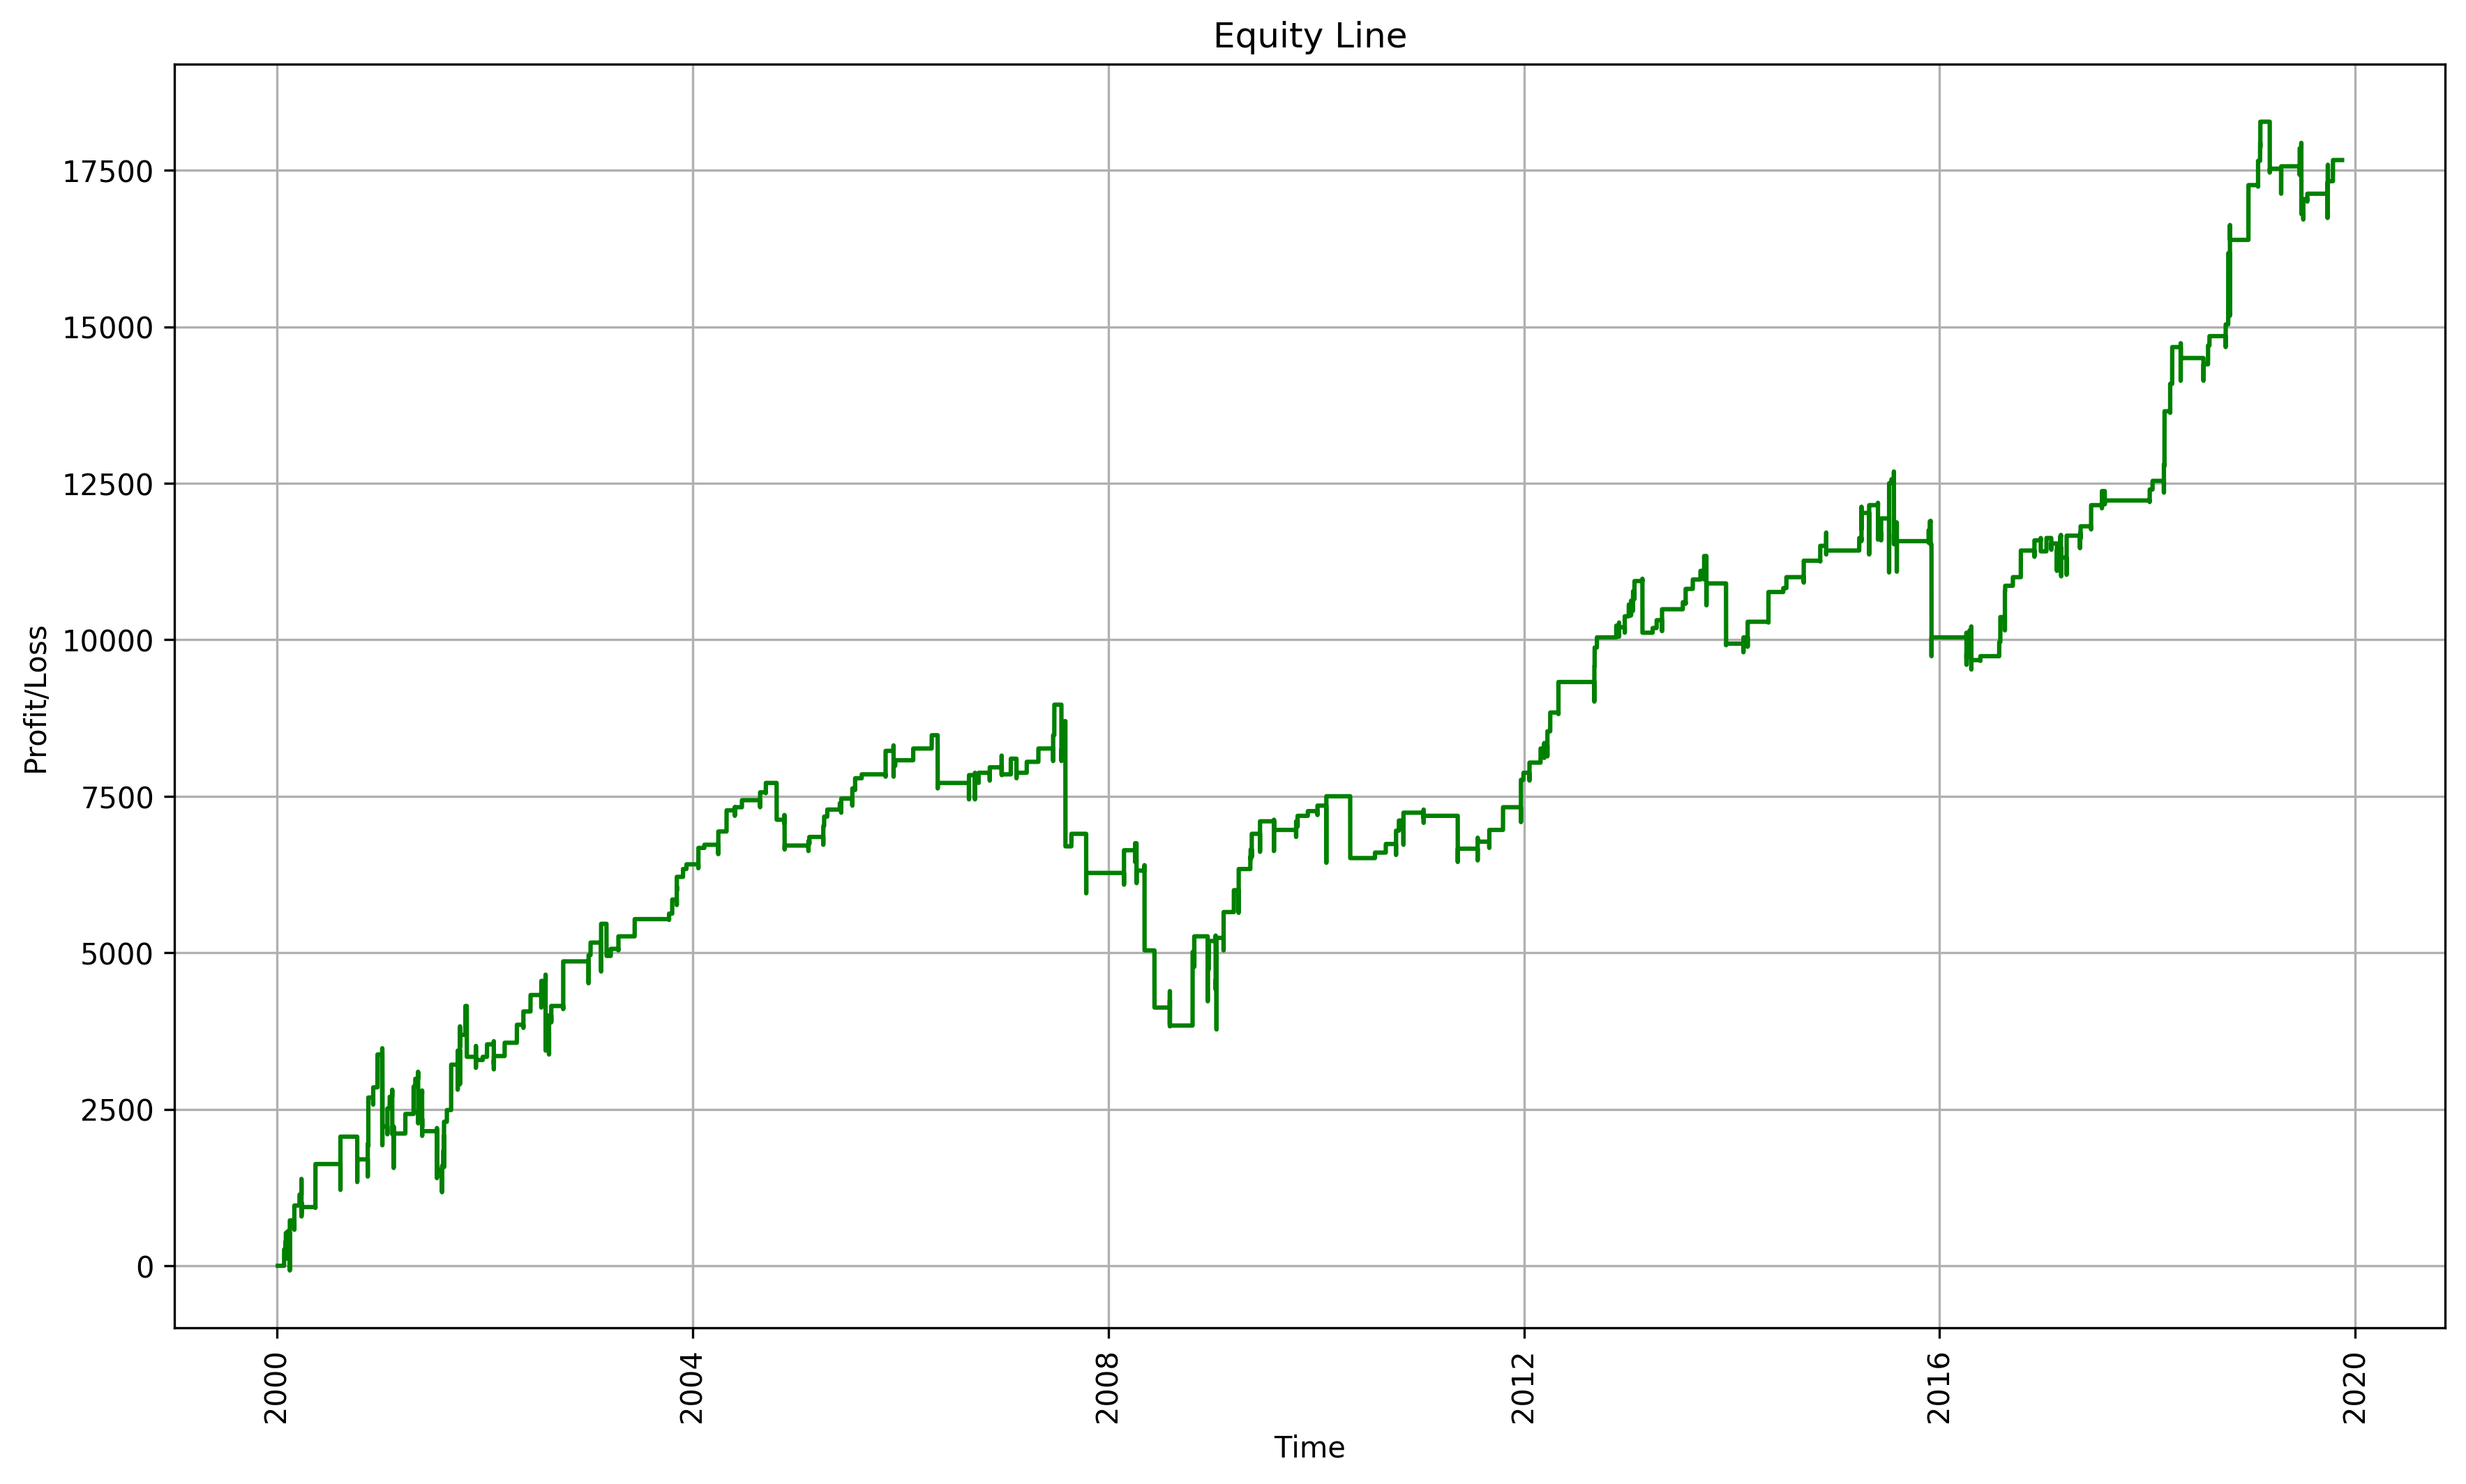

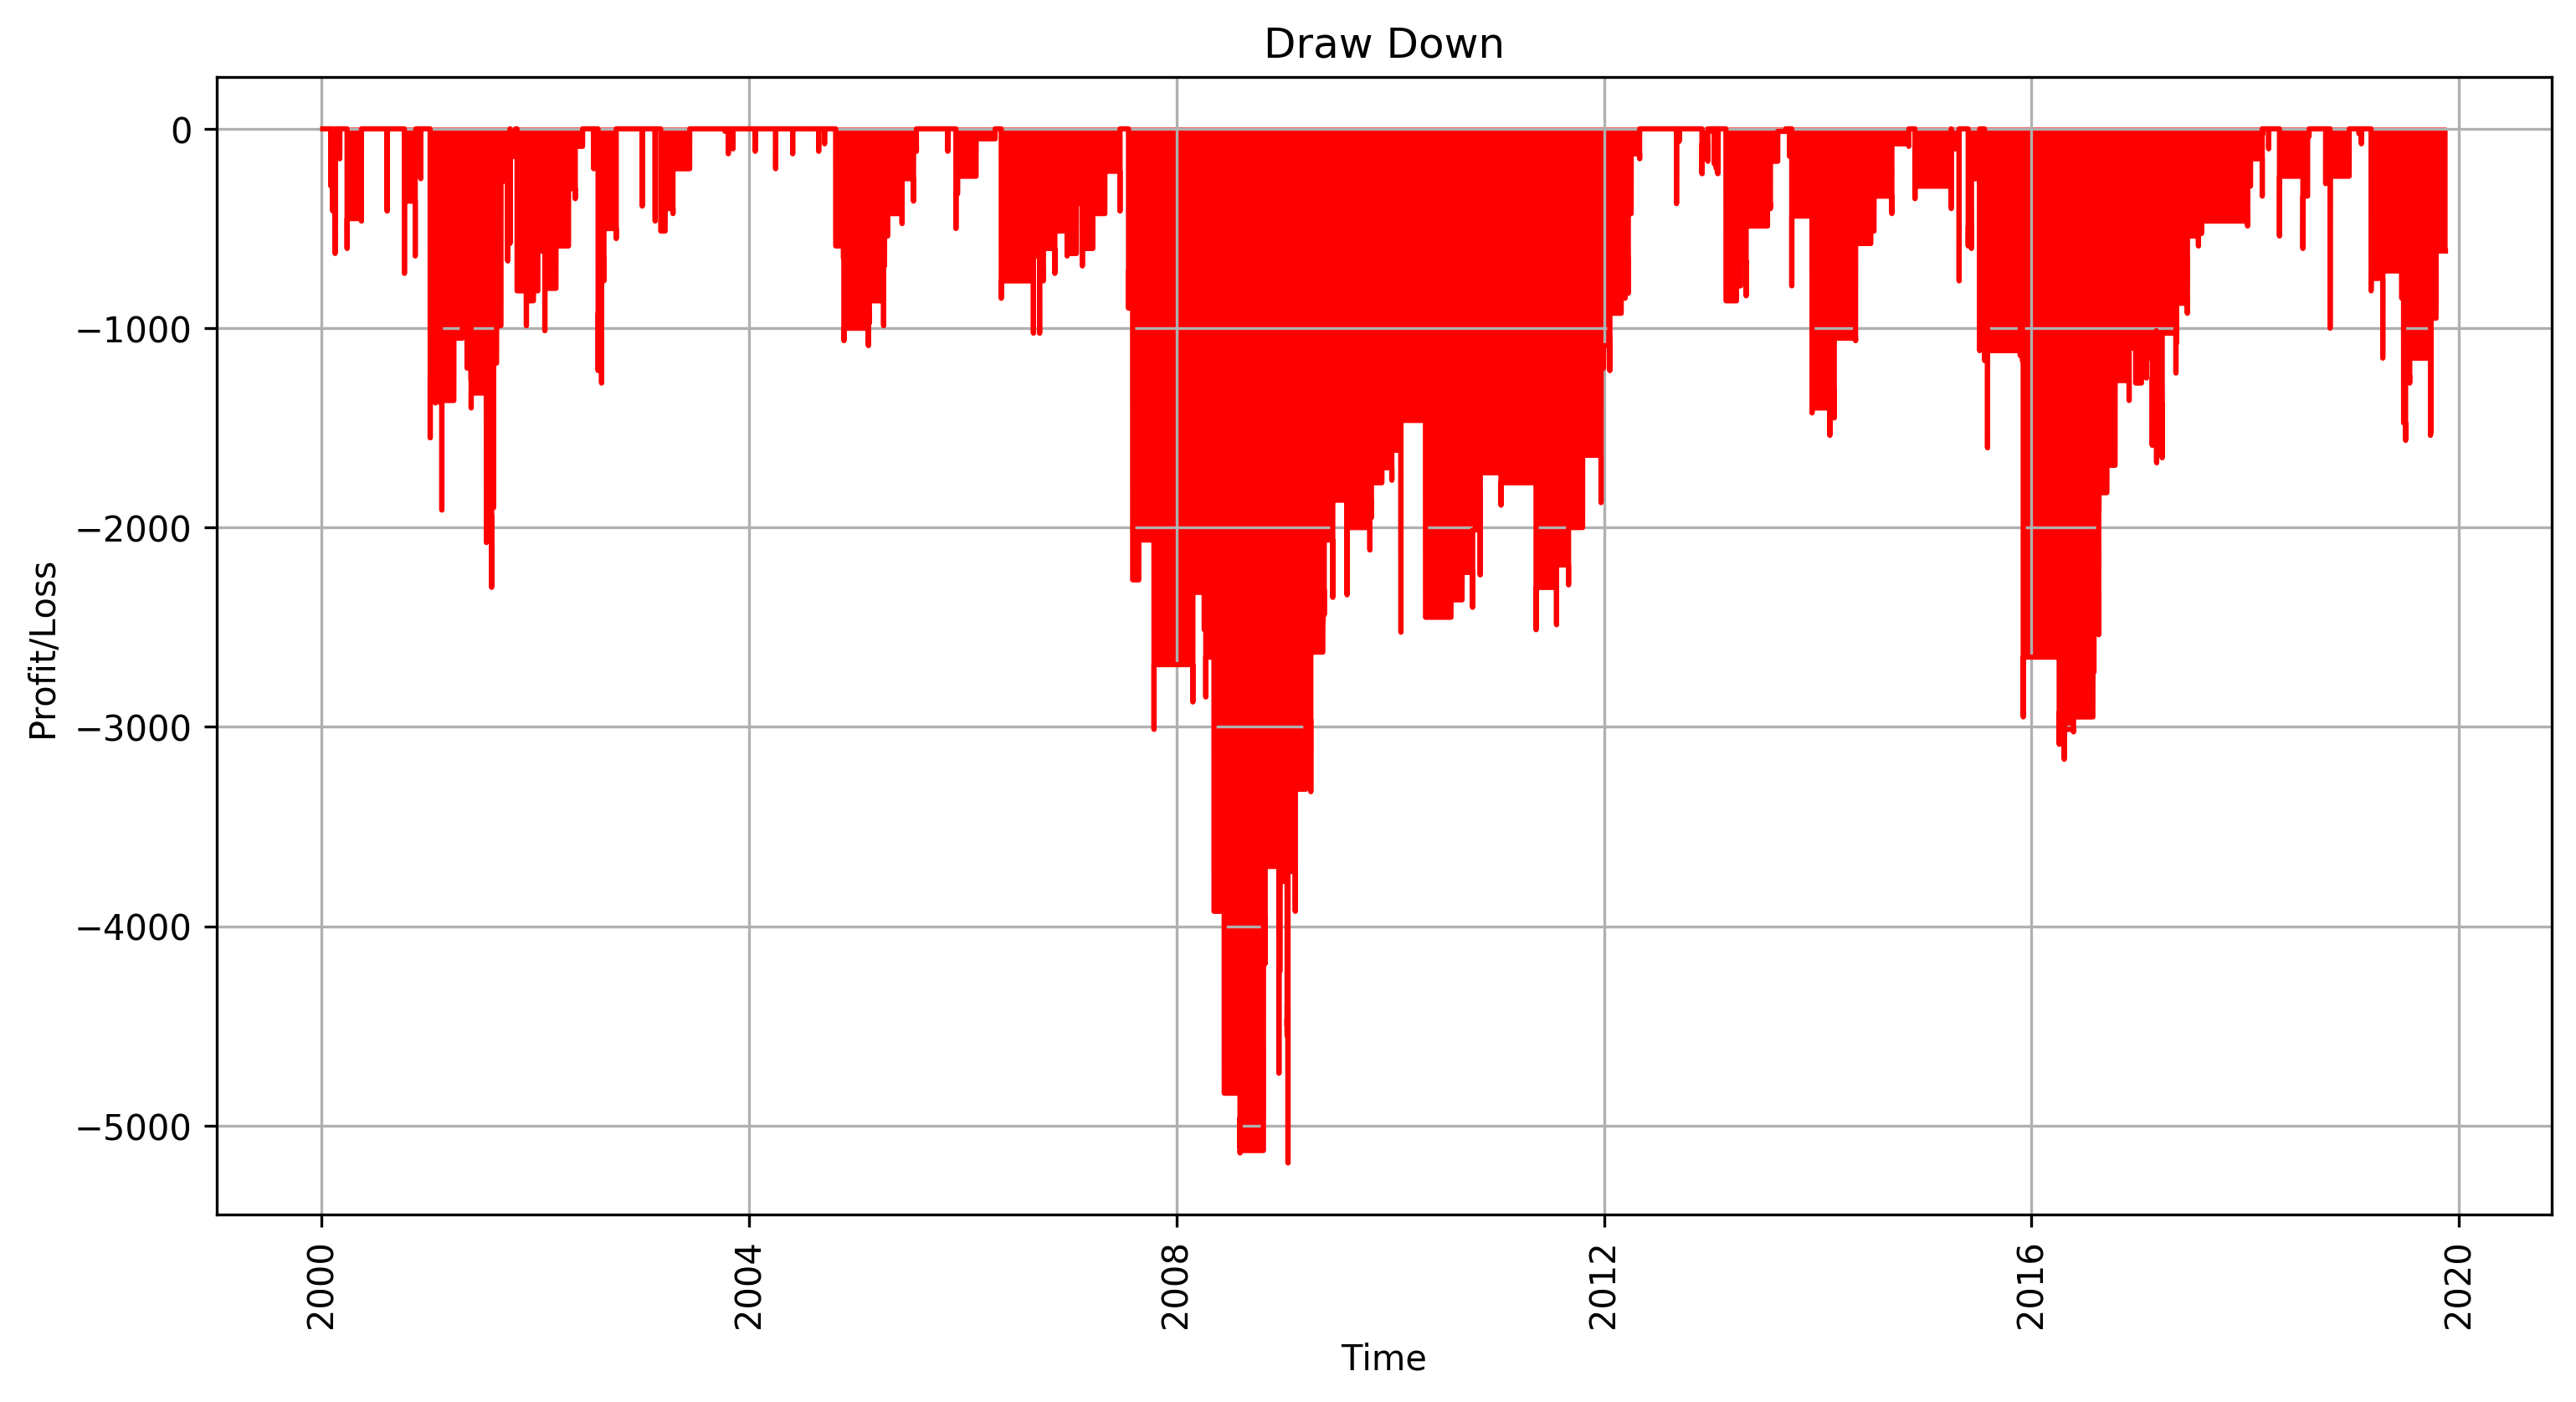

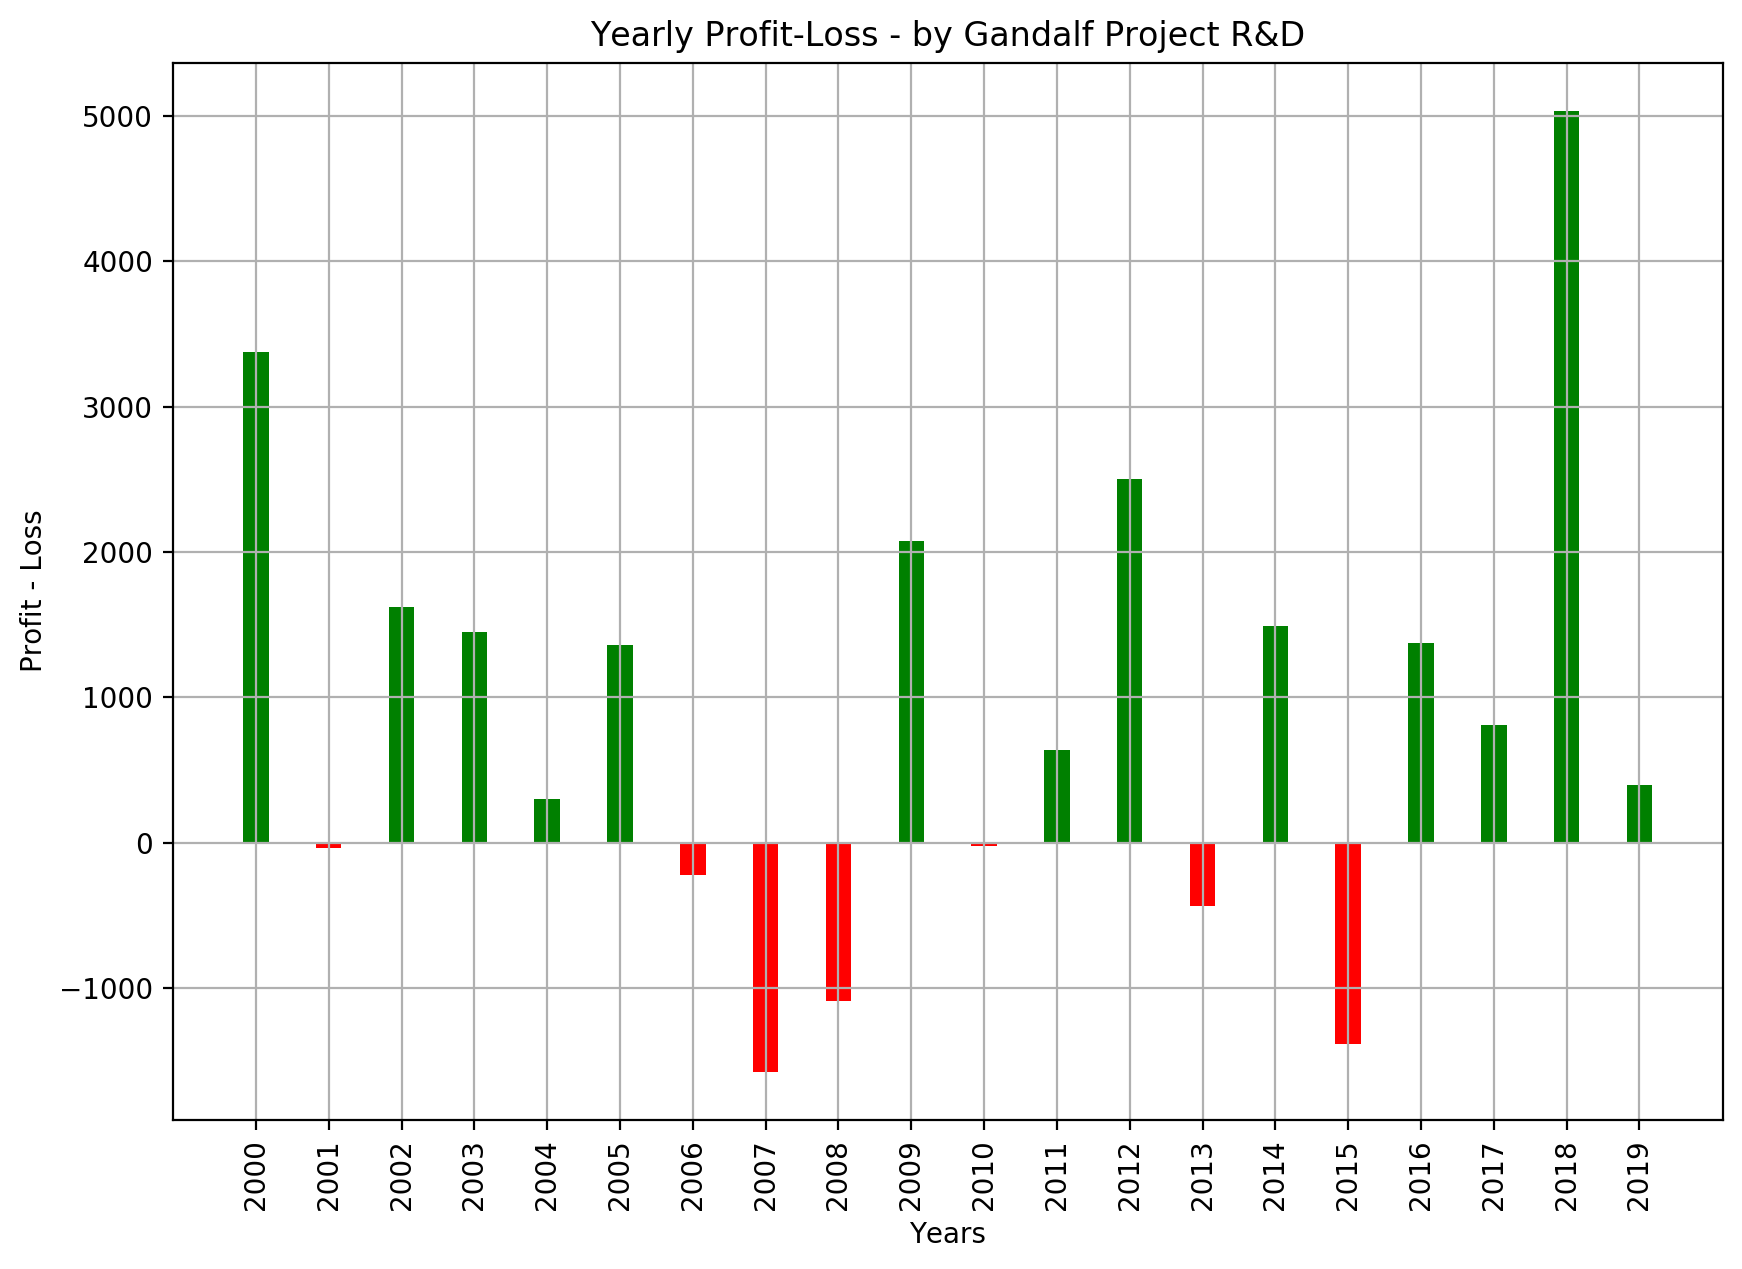

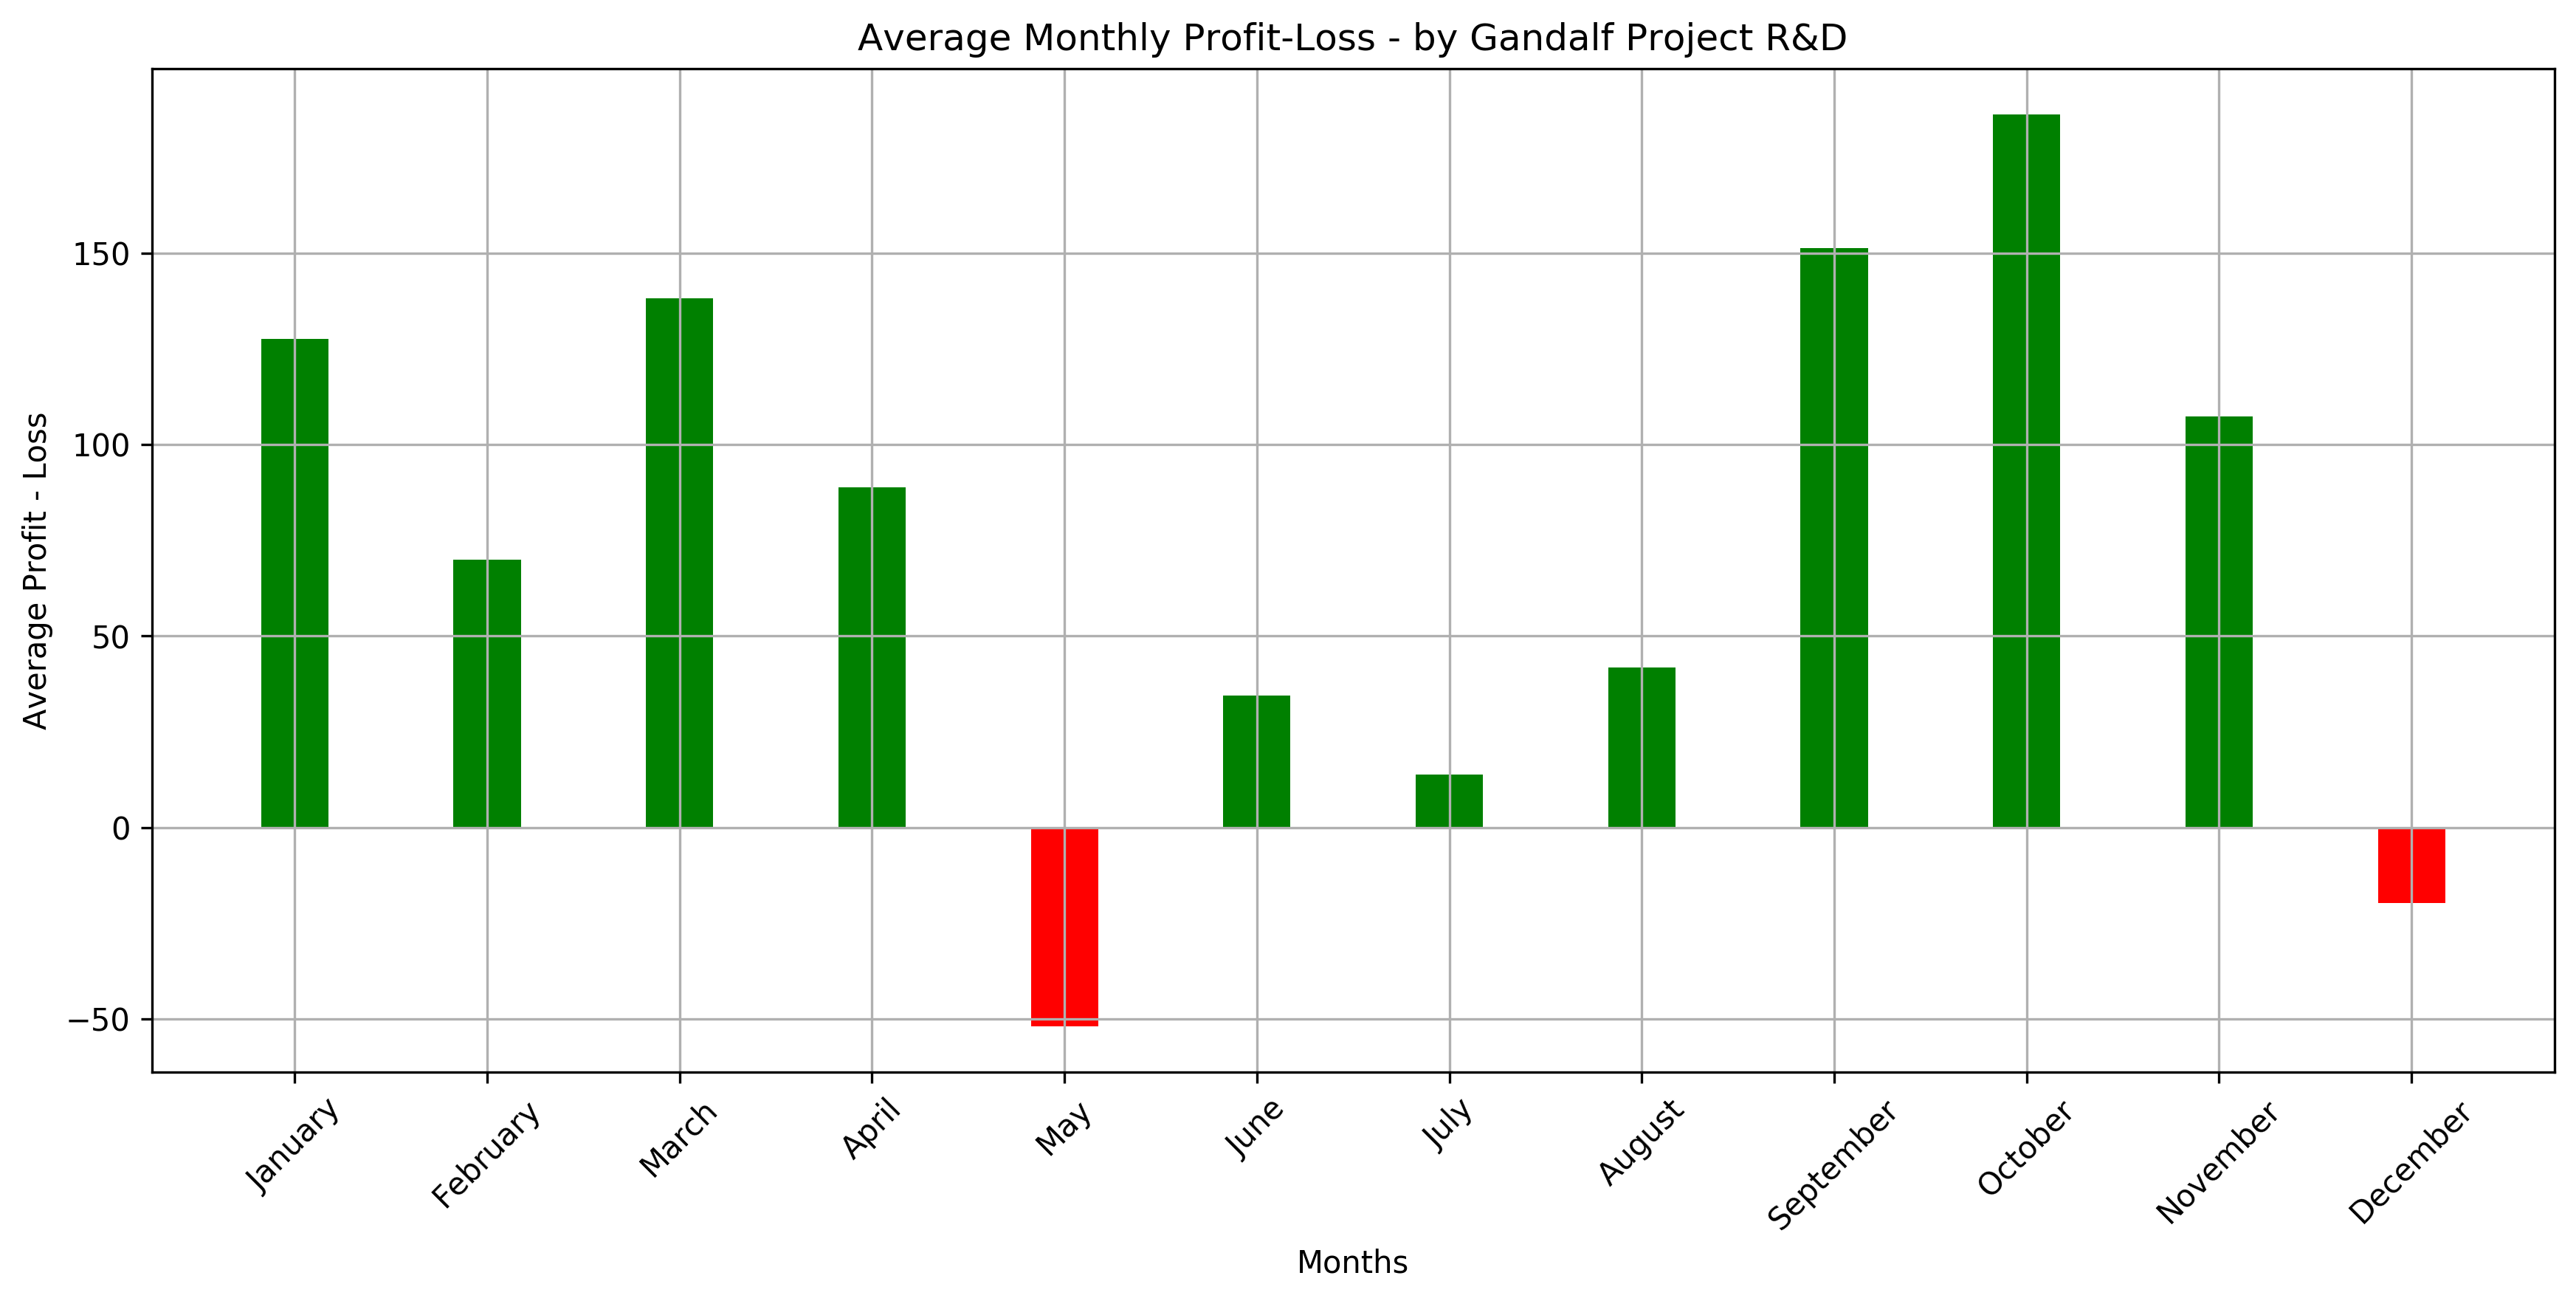

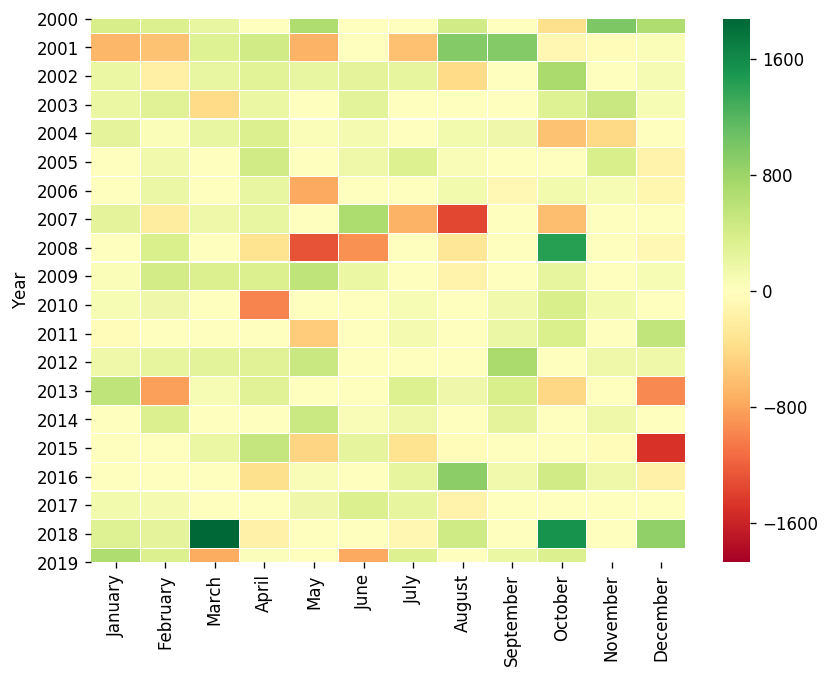

In [27]:
COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 50
TICK = 0.25
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "limit"

dataset = load_data_intraday("@ES.D_15min_Exchange.txt")

dataset["daily_open"] = np.where(dataset.day != dataset.day.shift(1), dataset.open, np.NaN)
dataset["daily_open"] = dataset["daily_open"].fillna(method = 'ffill')
dataset["daily_close1"] = np.where(dataset.day != dataset.day.shift(1), dataset.close.shift(1), np.NaN)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')
dataset["trigger"] = np.where(dataset.day != dataset.day.shift(1), dataset.open - 2 * TICK, np.NaN)
dataset["trigger"] = dataset["trigger"].fillna(method = 'ffill')
dataset.dropna(inplace=True)

enter_rules = (dataset.day != dataset.day.shift(1)) & (dataset.open > dataset.low.shift(1)) &\
                                                      (dataset.open < dataset.close.shift(1))
enter_level = dataset.trigger.shift(1)

exit_rules = (dataset.close > dataset.daily_close1) | (dataset.day != dataset.day.shift(-2))

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

In [28]:
long_equity = trading_system.open_equity
long_equity.tail(10)

date_time
2019-11-15 13:00:00    17662.5
2019-11-15 13:15:00    17662.5
2019-11-15 13:30:00    17662.5
2019-11-15 13:45:00    17662.5
2019-11-15 14:00:00    17662.5
2019-11-15 14:15:00    17662.5
2019-11-15 14:30:00    17662.5
2019-11-15 14:45:00    17662.5
2019-11-15 15:00:00    17662.5
2019-11-15 15:15:00    17662.5
Name: open_equity, dtype: float64

Performance Report - by Gandalf Project R&D

Profit:                   13375.0
Operations:               191
Average Trade:            70.03

Profit Factor:            1.54
Gross Profit:             38237.5
Gross Loss:               -24862.5

Percent Winning Trades:   71.73
Percent Losing Trades:    28.269999999999996
Reward Risk Ratio:        0.61

Max Gain:                 1300.0  in date  2019-10-03 09:15:00
Average Gain:             279.11
Max Loss:                 -1700.0  in date  2000-01-07 15:00:00
Average Loss:             -460.42

Avg Open Draw Down:       -1296.6
Max Open Draw Down:       -3775.0

Avg Closed Draw Down:     -1271.52
Max Closed Draw Down:     -3550.0

Avg Delay Between Peaks:  1873.53
Max Delay Between Peaks:  55449


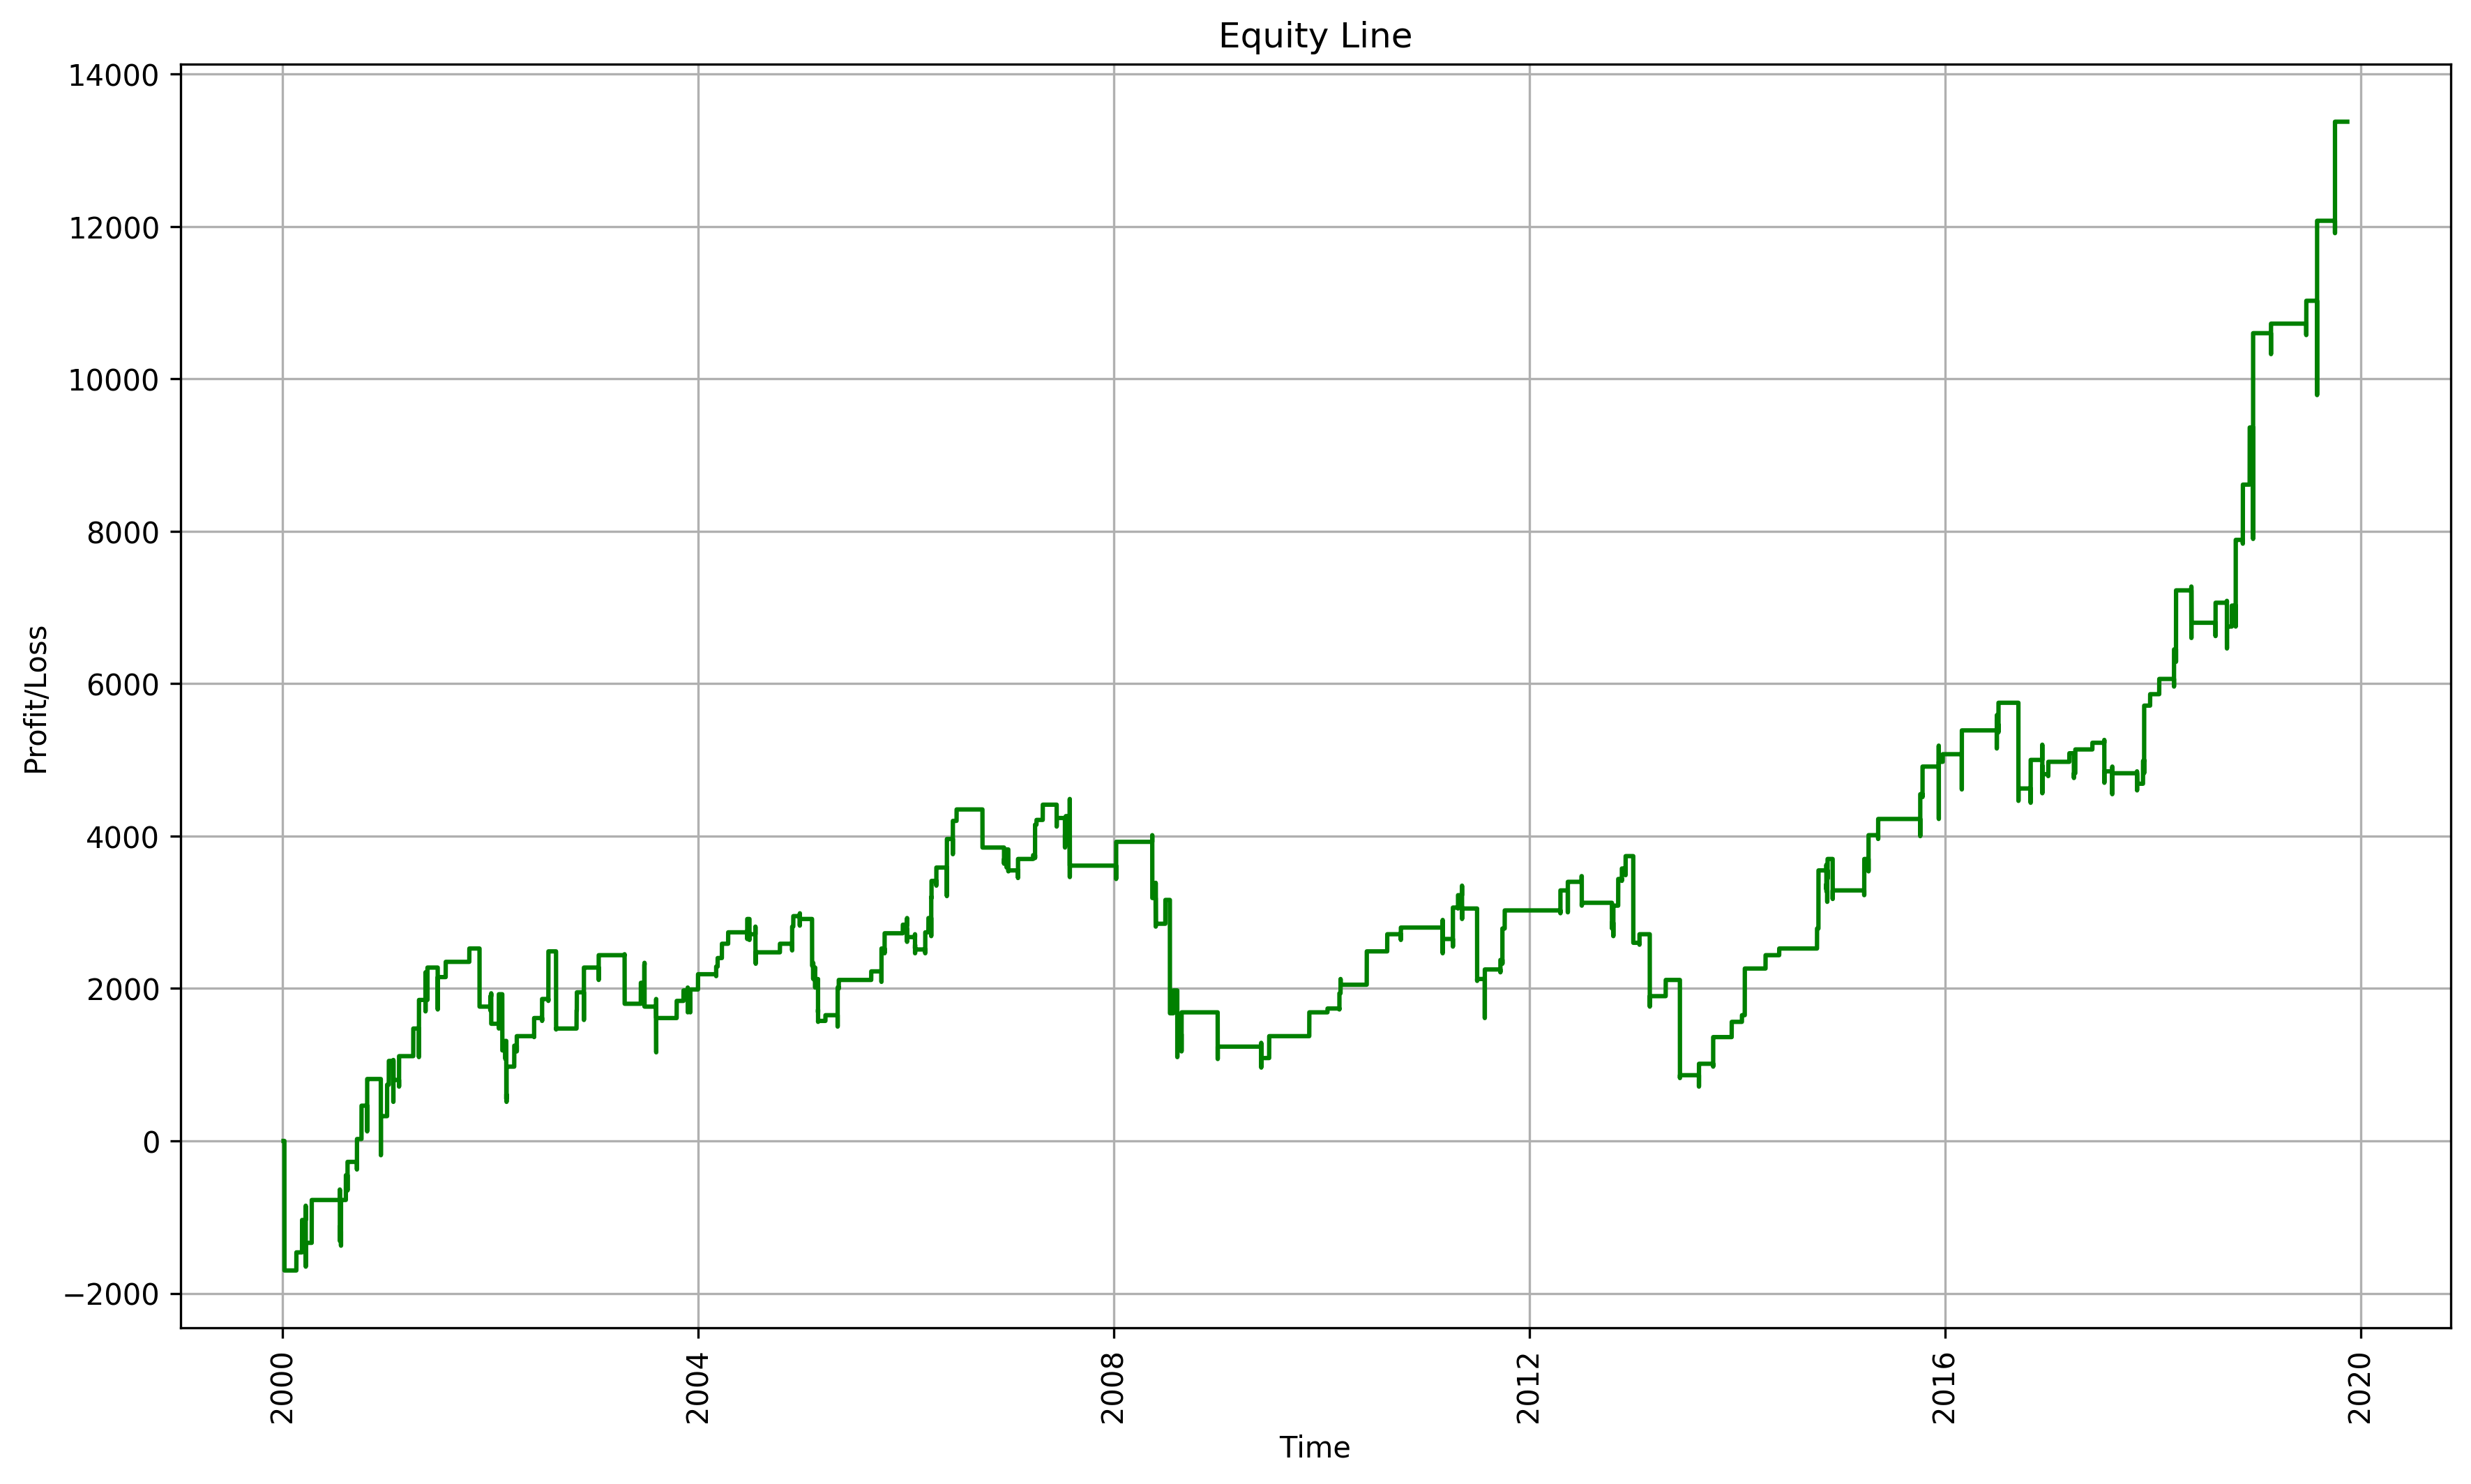

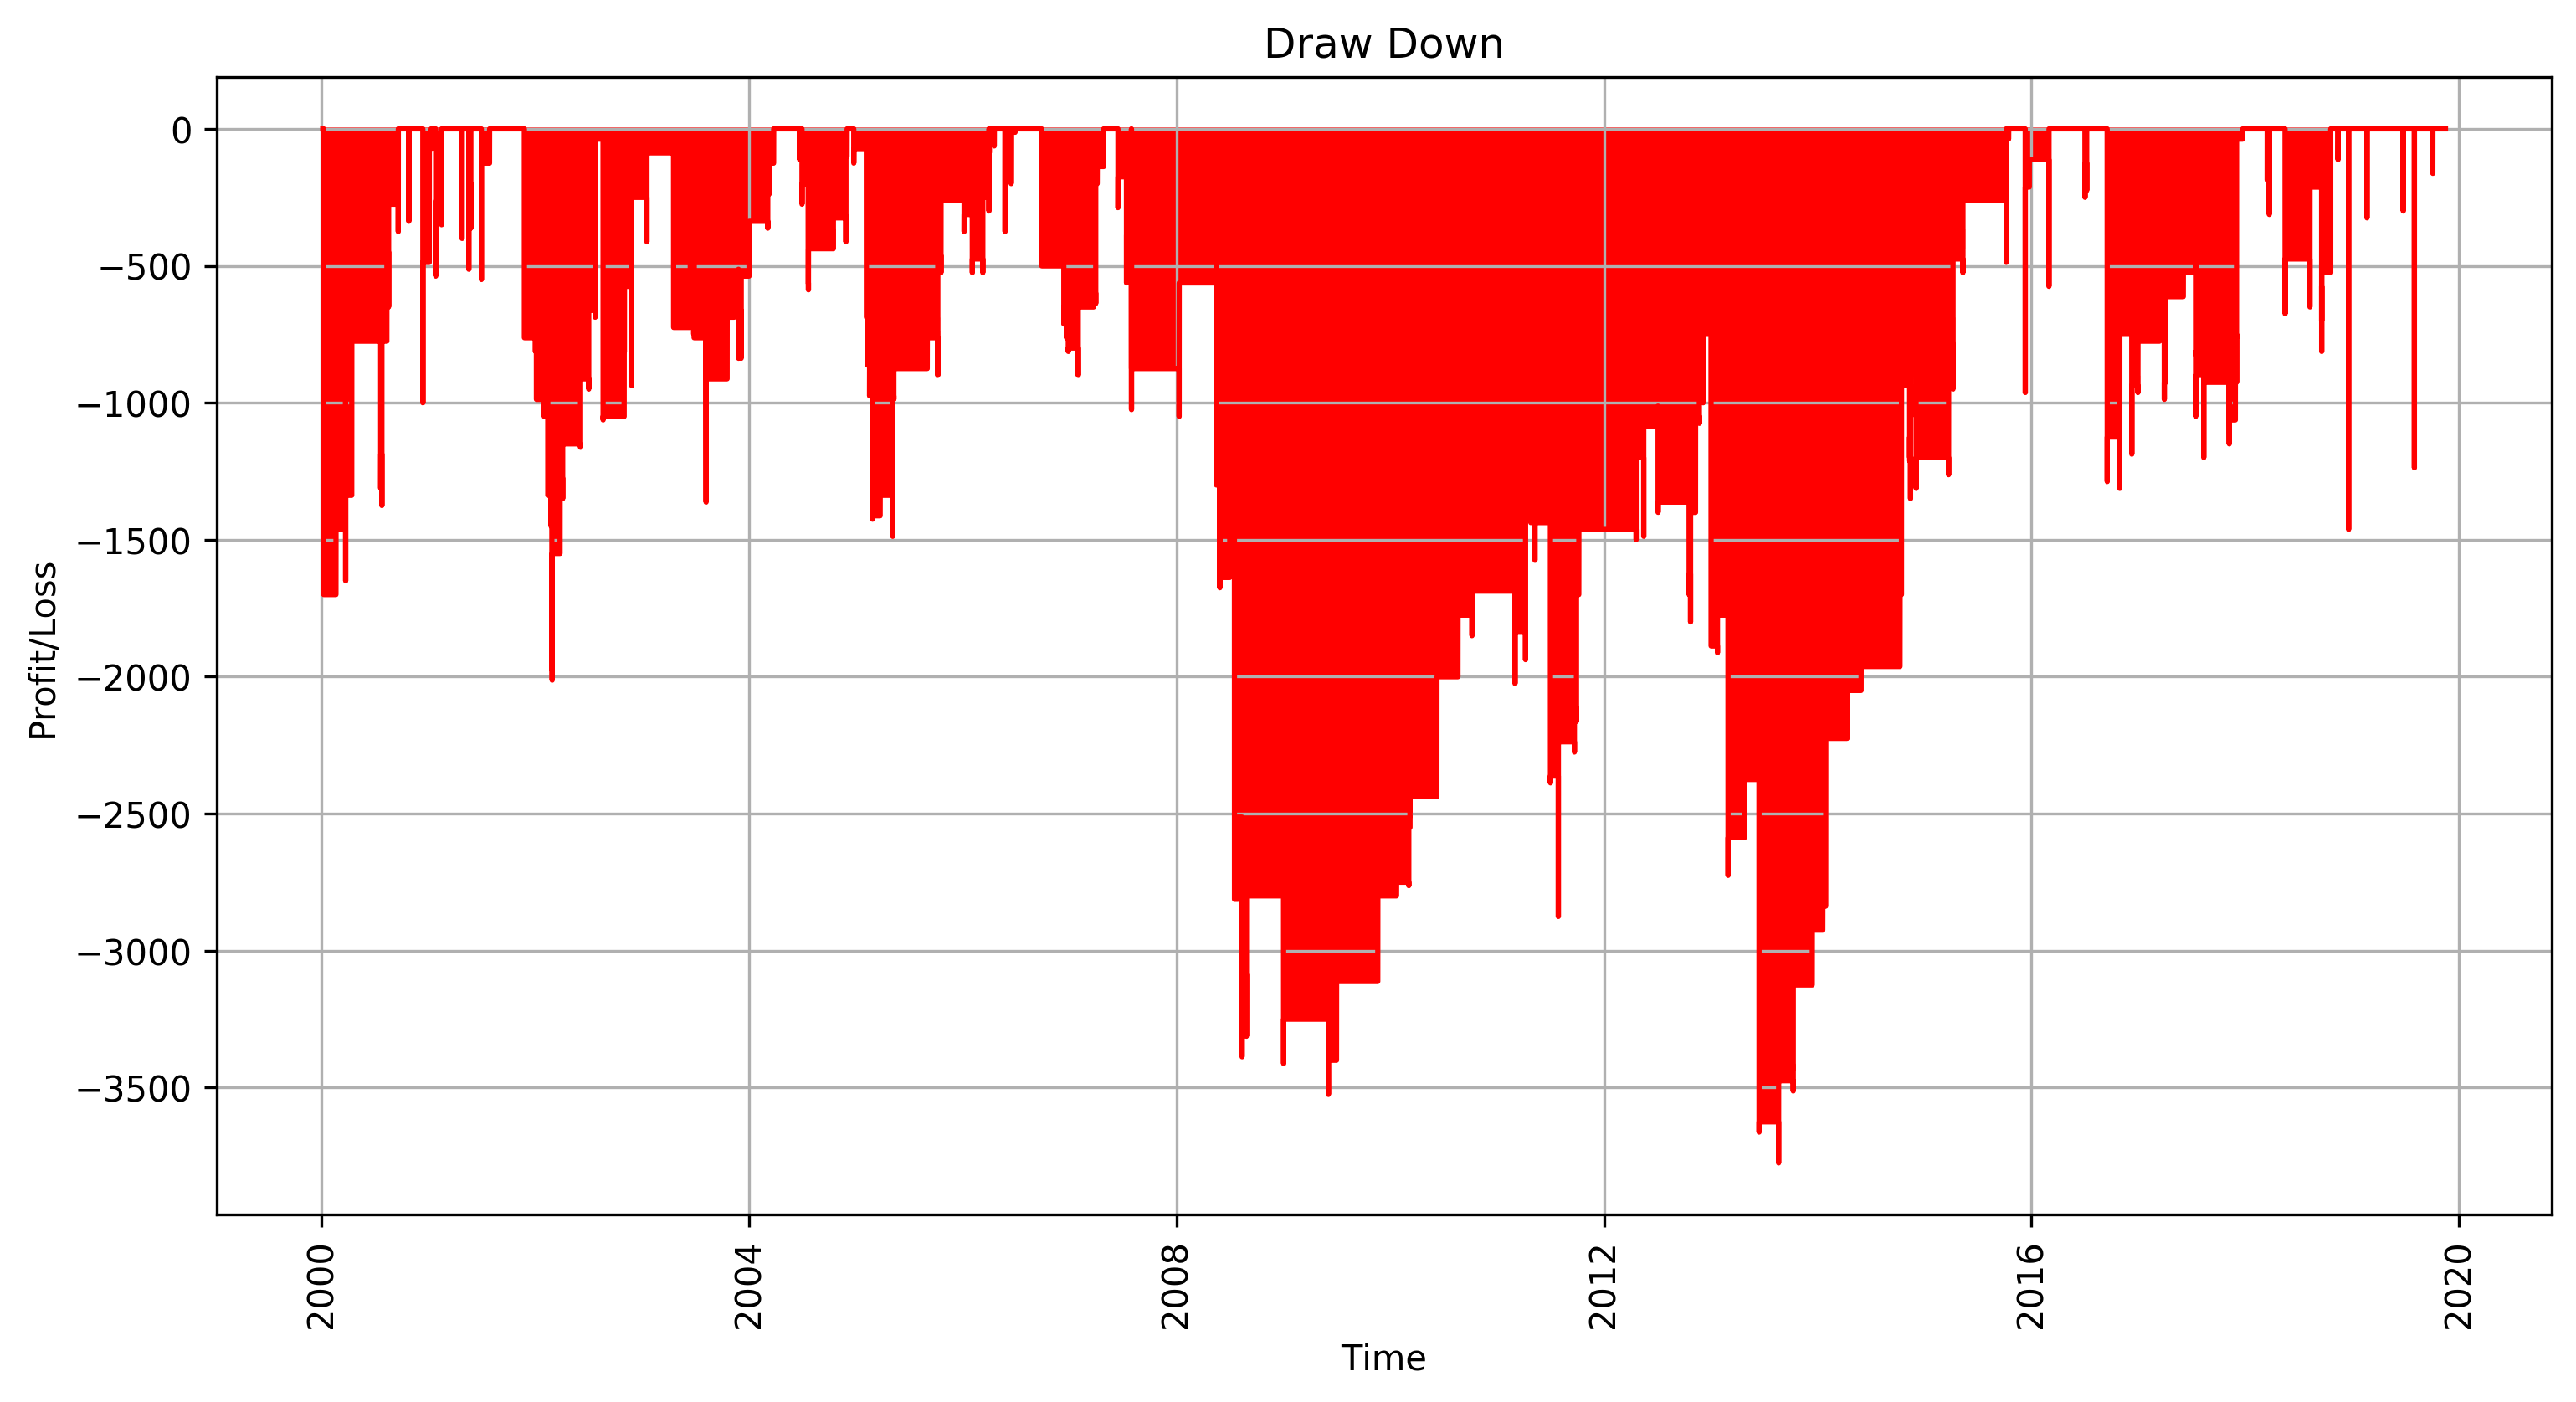

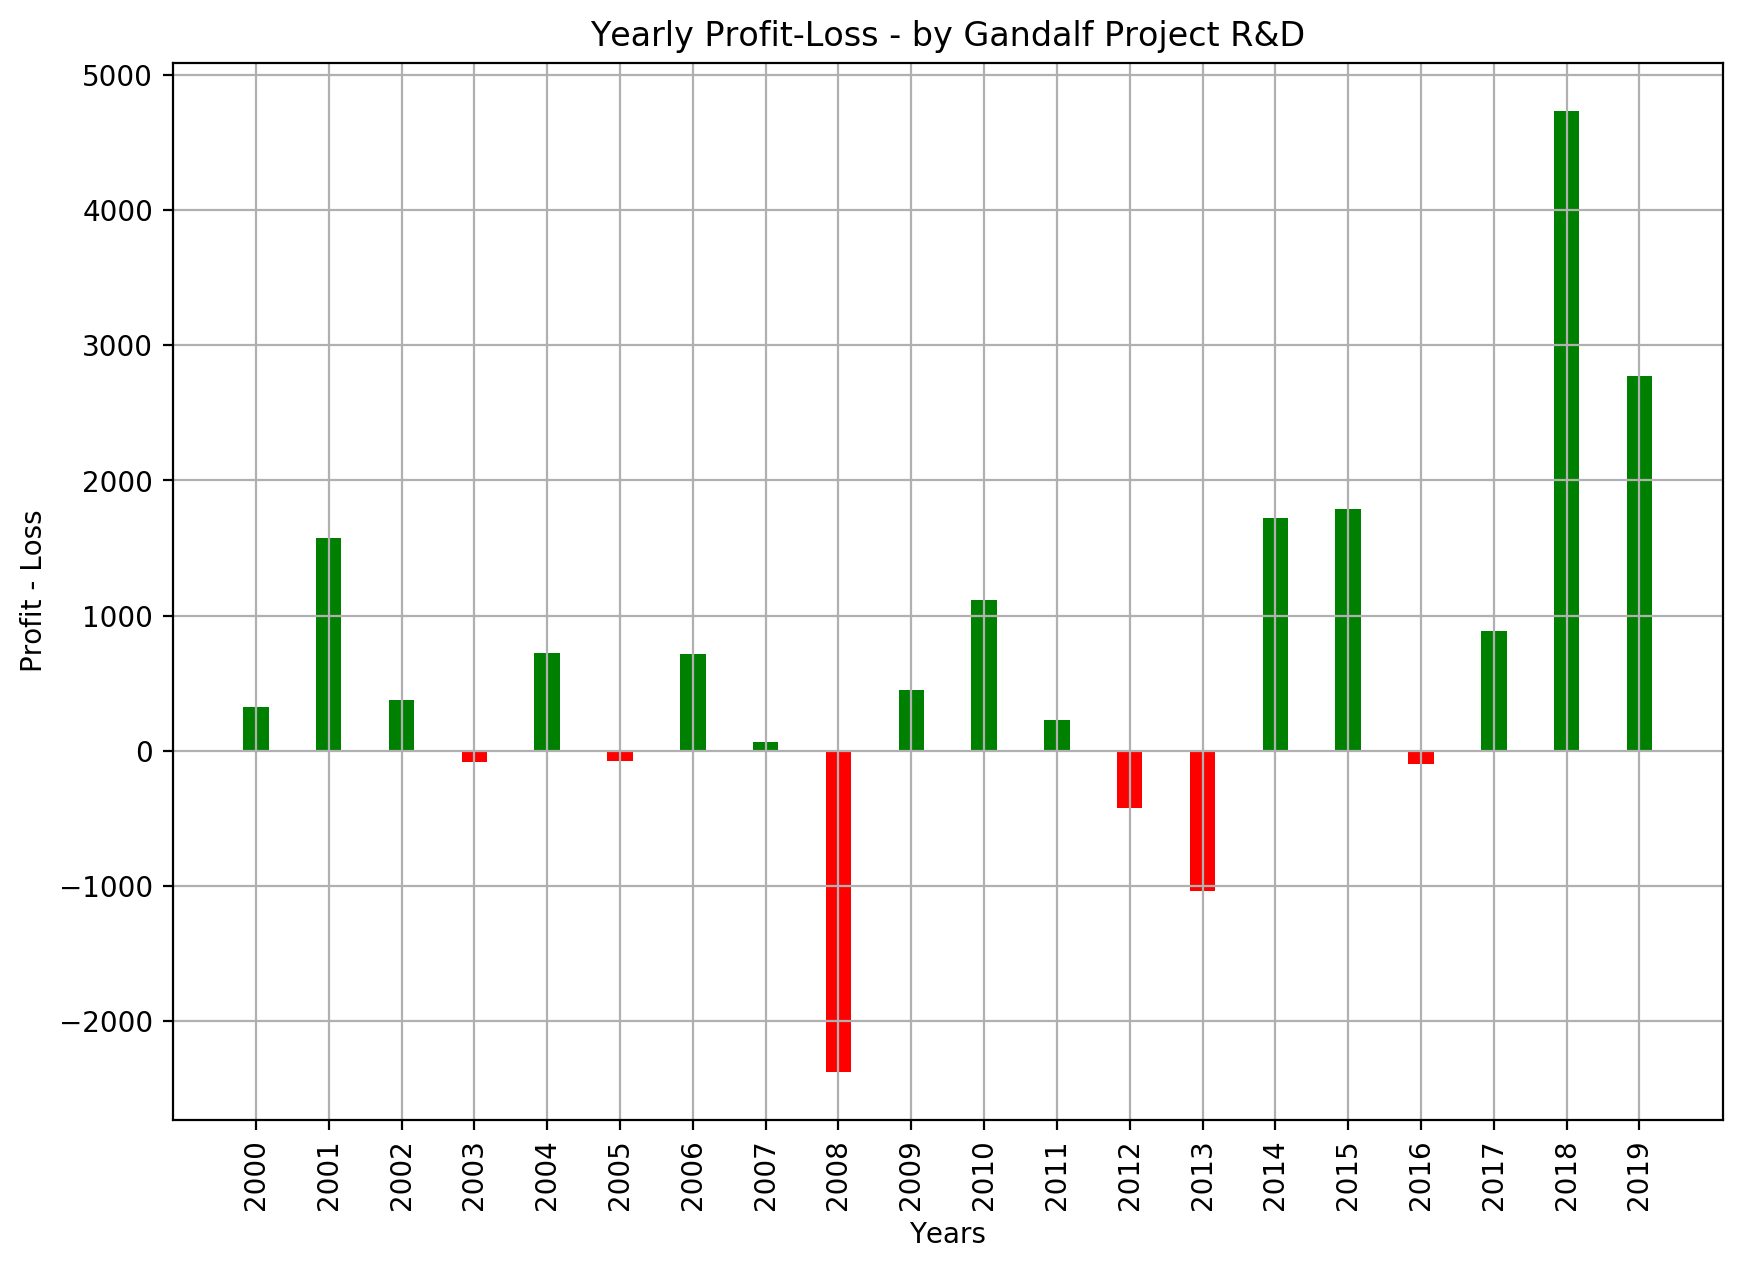

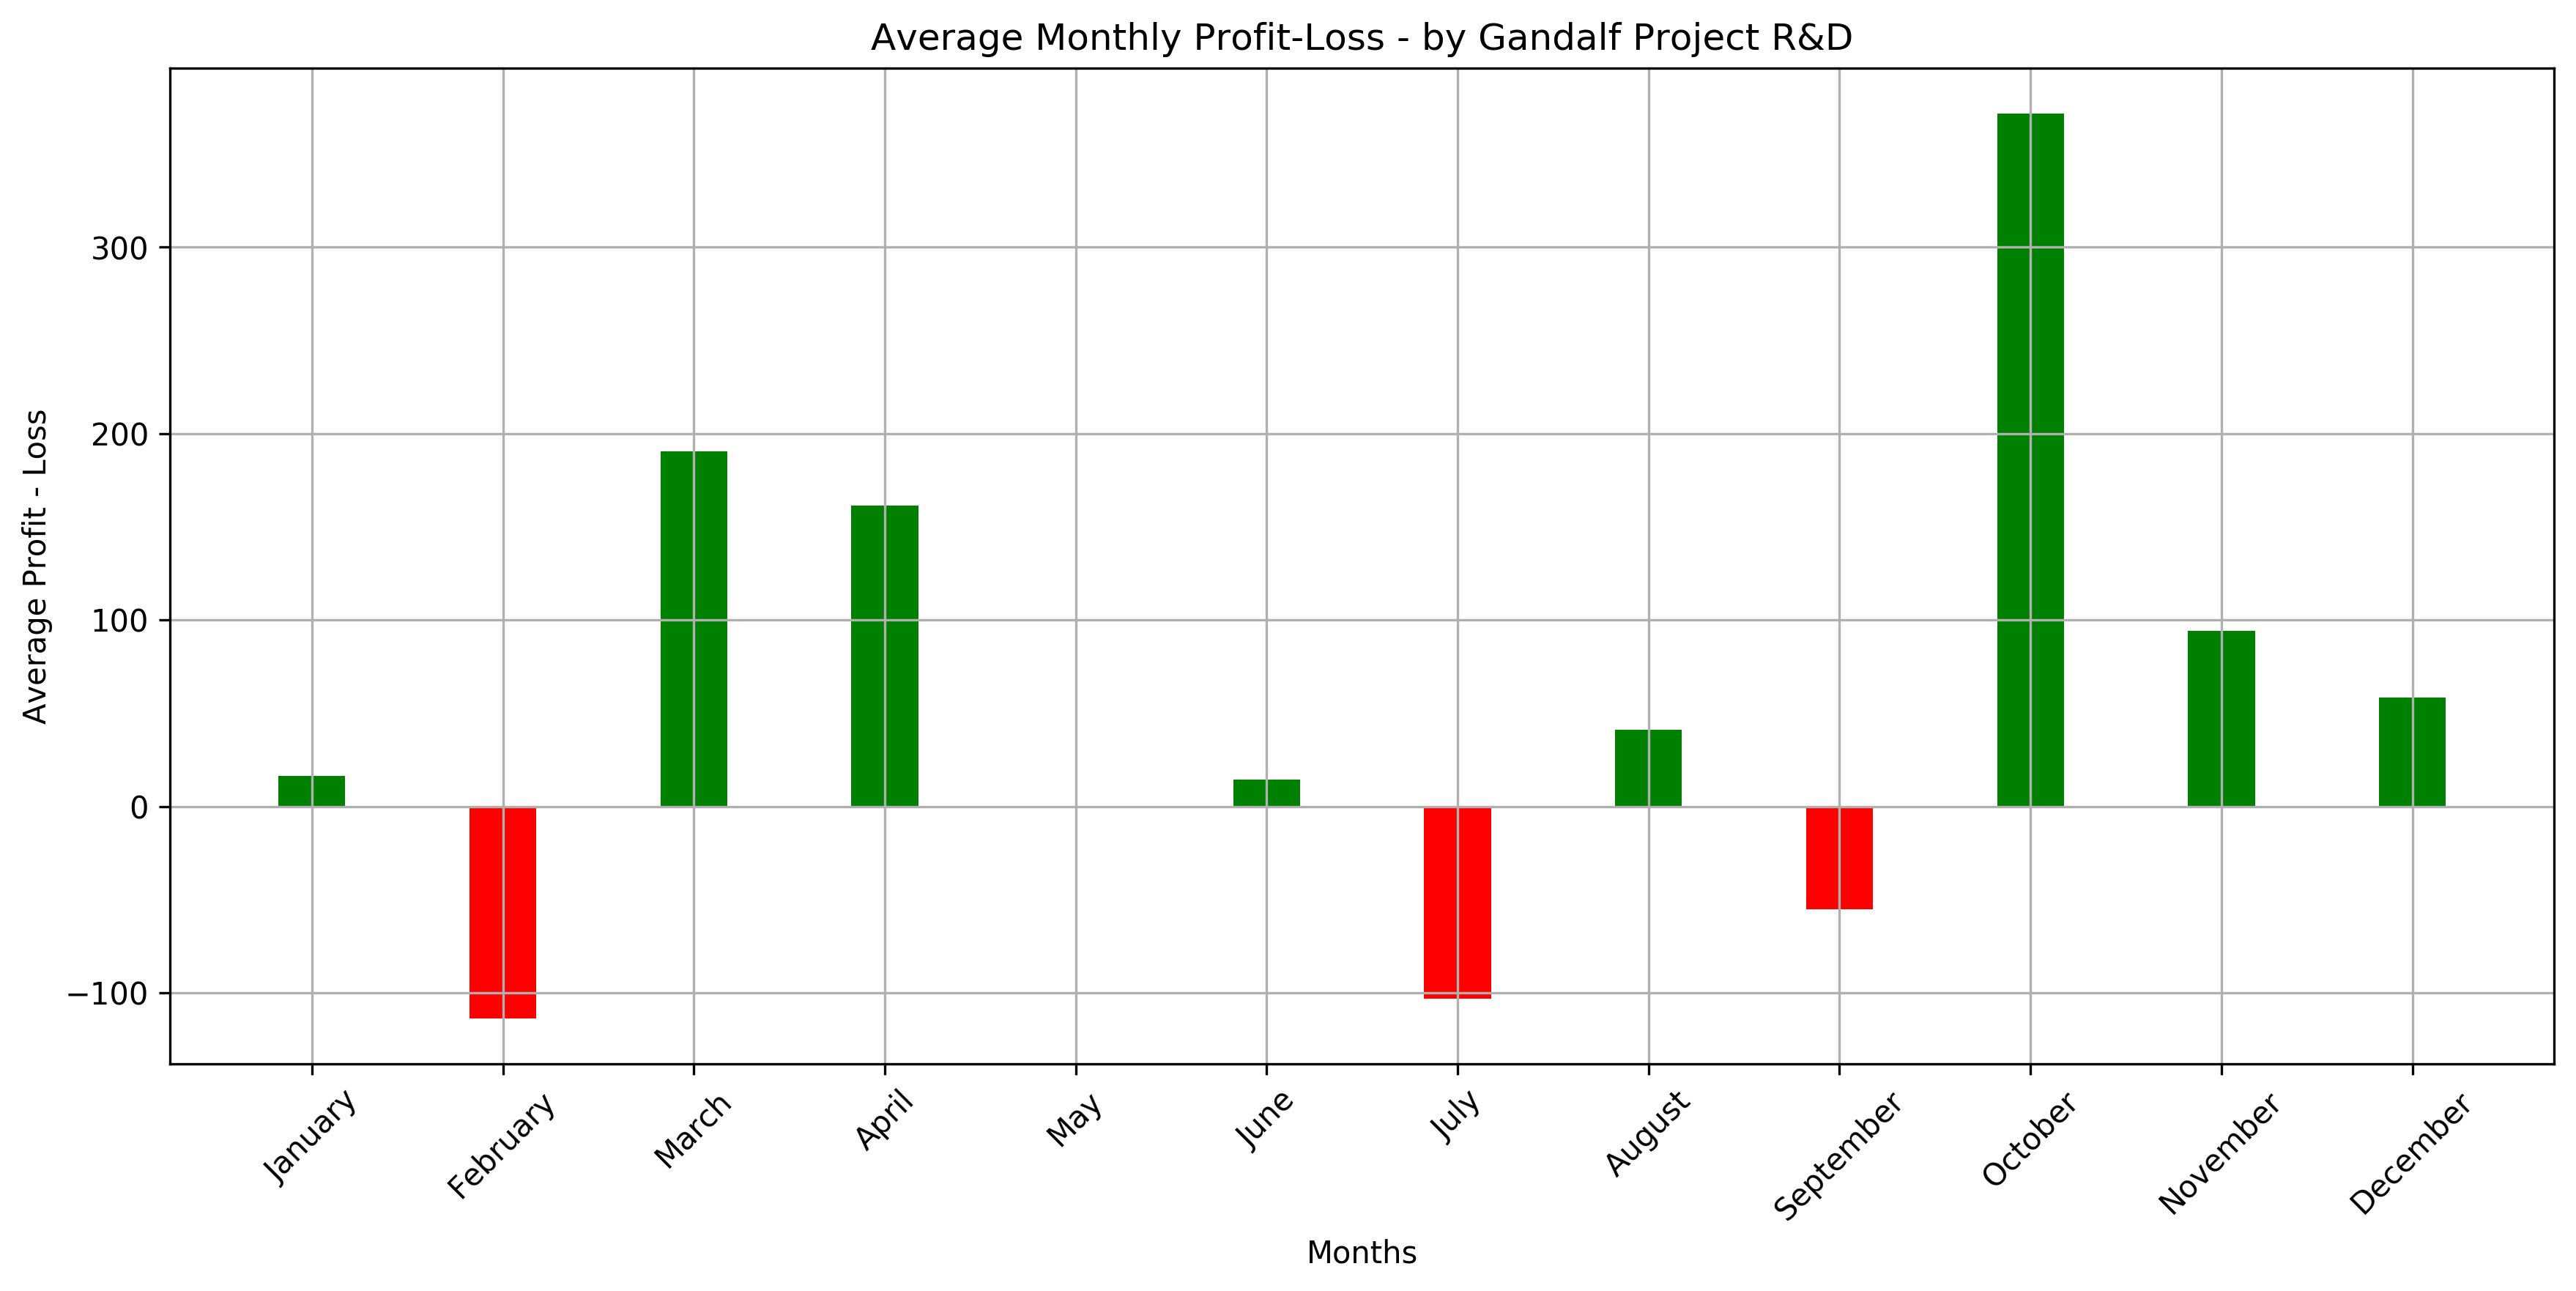

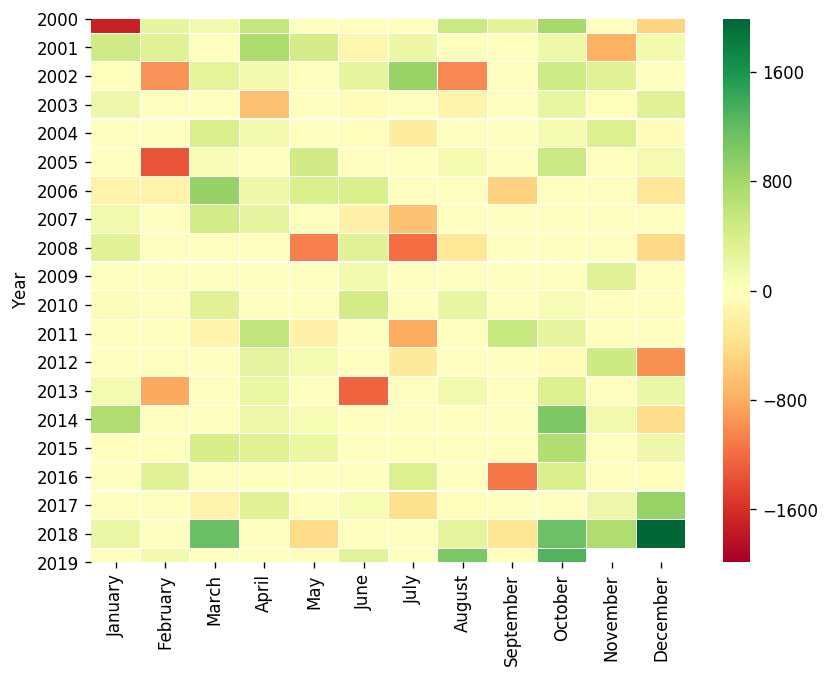

In [29]:
COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 50
TICK = 0.25
OPERATION_MONEY = 10000
DIRECTION = "short"
ORDER_TYPE = "limit"

dataset = load_data_intraday("@ES.D_15min_Exchange.txt")

dataset["daily_open"] = np.where(dataset.day != dataset.day.shift(1), dataset.open, np.NaN)
dataset["daily_open"] = dataset["daily_open"].fillna(method = 'ffill')
dataset["daily_close1"] = np.where(dataset.day != dataset.day.shift(1), dataset.close.shift(1), np.NaN)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')
dataset["trigger"] = np.where(dataset.day != dataset.day.shift(1), dataset.open + 2 * TICK, np.NaN)
dataset["trigger"] = dataset["trigger"].fillna(method = 'ffill')
dataset.dropna(inplace=True)

enter_rules = (dataset.day != dataset.day.shift(1)) & (dataset.open < dataset.high.shift(1)) &\
                                                      (dataset.open > dataset.close.shift(1))
enter_level = dataset.trigger.shift(1)

exit_rules = (dataset.close < dataset.daily_close1) | (dataset.day != dataset.day.shift(-2))

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

In [ ]:
short_equity = trading_system.open_equity
short_equity.tail(10)

In [ ]:
plt.figure(figsize=(14, 8), dpi=300)
plt.plot(long_equity, color="green")
plt.plot(short_equity, color="red")
plt.plot(short_equity + long_equity, color="blue")
plt.xlabel("Time")
plt.ylabel("Profit/Loss")
plt.title('Equity Line')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.show()